<a href="https://colab.research.google.com/github/ATLAS097/Deep-Learning-CA-2/blob/Swam/GAN_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating 160 small black-and-white images
## Part A: Generative Adversarial Network

### Group Members: Swam Htet Aung, Kaung Myat San
### Class: DAAA/FT/2B/22
### Course: ST1504 Deep Learning
---



# Set up
---

### Importing Modules

In [1]:
# ==============================
# Environment Setup & Libraries
# ==============================
import os
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning / Data Processing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedShuffleSplit

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# Utilities
from PIL import Image
from scipy import linalg

# ==============================
# Configuration & Reproducibility
# ==============================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Suppress warnings
warnings.filterwarnings('ignore')

# GPU setup for TensorFlow (no need for colab)
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         # Optional: limit GPU memory usage (uncomment if needed)
#         # tf.config.set_logical_device_configuration(
#         #     gpus[0],
#         #     [tf.config.LogicalDeviceConfiguration(memory_limit=6144)]
#         # )
#     except RuntimeError as e:
#         print("GPU setup error:", e)

# ==============================
# Plot Styling
# ==============================
sns.set_context("notebook")
sns.set_style("whitegrid")
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["savefig.dpi"] = 150
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# ==============================
# Diagnostics
# ==============================
print("Libraries imported successfully!")
print(f"TensorFlow version : {tf.__version__}")
print(f"PyTorch version    : {torch.__version__}")
print(f"GPU available (TF) : {tf.config.list_physical_devices('GPU')}")
print(f"GPU available (Torch): {torch.cuda.is_available()}")


Libraries imported successfully!
TensorFlow version : 2.19.0
PyTorch version    : 2.6.0+cu124
GPU available (TF) : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU available (Torch): True


# Background Research & Feature Engineering
---



## 1. Dataset Origin & Challenges

The **EMNIST Letters** dataset is a subset of the EMNIST dataset, which extends the original MNIST dataset to handwritten letters.  
It consists of grayscale images of handwritten English alphabets, each with a resolution of **28×28 pixels**.  

For this project:  
- We use **EMNIST Letters** with a total of **64,829 samples**.  
- Each image is flattened into **784 pixel values** (0–255) and accompanied by a numeric label representing the letter class.  
- The dataset contains **16 target classes** after data cleaning, as per the assignment requirements.  

### Challenges for GAN-based Letter Generation
1. **Small image resolution**  
   - Only 28×28 pixels, limiting the fine details that can be represented.  
2. **High intra-class variation**  
   - Handwriting styles vary greatly between individuals for the same letter.  
3. **Inter-class similarity**  
   - Some letters have very similar shapes, e.g., **I vs L**, **O vs Q**.  
4. **Dataset noise and mislabels**  
   - Presence of poorly written or mislabeled samples can mislead the GAN during training.  

These challenges make it harder for a GAN to learn clean, high-quality letter representations.  
They also justify the need for careful **preprocessing**, **data cleaning**, and possibly **conditional generation techniques** to improve quality.

In [2]:
# Load the raw EMNIST dataset
data = pd.read_csv(
    'https://media.githubusercontent.com/media/ATLAS097/assets/refs/heads/main/SP_DELE_CA2_YEAR_2/emnist-letters-train.csv',
    header=None
)

# Basic info about the raw dataset
print("=== RAW DATASET OVERVIEW ===")
print(f"Shape: {data.shape}")
print(f"Column count: {len(data.columns)}")
print("\nFirst 5 rows:")
print(data.head())

# Missing values check
print(f"\nTotal missing values: {data.isnull().sum().sum()}")

# Show first few column names
print(f"\nFirst 10 column names: {data.columns[:10].tolist()}")


=== RAW DATASET OVERVIEW ===
Shape: (64829, 785)
Column count: 785

First 5 rows:
   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   24    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   -2  142  142  142  142  142  142  142  142  142  ...  142  142  142  142   
2   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   14    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   -2  120  120  120  120  120  120  120  120  120  ...  120  120  120  120   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1  142  142  142  142  142  142  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4  120  120  120  120  120  120  

[5 rows x 785 columns]

Total missing values: 0

First 10 column names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]




- The dataset contains **785 columns** in total.
- The **first column** likely represents the **class label** in numeric form.
- The **remaining 784 columns** are pixel intensity values for a **28×28 grayscale image**, stored in a flattened format.
- No missing values were detected, so the dataset is complete.
- At this stage:
  - Labels are **numeric codes** without explicit mapping to letters.
  - We will later map these numeric labels to their corresponding alphabet characters.


In [3]:
# Rename columns for clarity
column_names = ['label'] + [f'pixel_{i}' for i in range(784)]
data.columns = column_names

# Show dataset statistics for each column
print("\n=== DATASET STATISTICS ===")
print(data.describe())



=== DATASET STATISTICS ===
              label       pixel_0       pixel_1       pixel_2       pixel_3  \
count  64829.000000  64829.000000  64829.000000  64829.000000  64829.000000   
mean       9.680776     20.139135     20.139135     20.139135     20.139228   
std        8.305620     54.998436     54.998436     54.998436     55.002882   
min       -2.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        9.000000      0.000000      0.000000      0.000000      0.000000   
75%       16.000000      0.000000      0.000000      0.000000      0.000000   
max       26.000000    255.000000    255.000000    255.000000    255.000000   

            pixel_4       pixel_5       pixel_6       pixel_7       pixel_8  \
count  64829.000000  64829.000000  64829.000000  64829.000000  64829.000000   
mean      20.142884     20.159049     20.166638     20.158340     25.268445   
std       54.999141    



- The `.describe()` output confirms:
  - **count**: All columns have the same number of entries, meaning there are no missing pixels.
  - **mean**: Average pixel intensity across the dataset is around 20, indicating mostly dark backgrounds with lighter strokes.
  - **std**: High standard deviation (~55) compared to mean suggests strong contrast between background and foreground pixels.
  - **min**/**max**: Pixel values range from **0 (black)** to **255 (white)**, consistent with 8-bit grayscale encoding.
  - **Quartiles (25%, 50%, 75%)**: The majority of pixel values are `0`, meaning most pixels are background.
- These statistics match expectations for a sparse grayscale handwritten character dataset.


### Dataset Summary & Key Observations

- **Total Samples**:  
  The dataset contains a total of **64,829** samples.

- **Image Properties**:  
  - Each sample is a flattened array of **784 pixels**, which can be reshaped into a $28 \times 28$ grayscale image.  
  - The data is highly **sparse**: the 75th percentile for most pixel columns is 0, indicating that the majority of the image area is background.

- **Label Properties**:  
  - Labels are integers ranging from **-2 to 26**.  
  - These labels are not sequential and must be mapped correctly to the **16 target classes** for model training.

- **Required Preprocessing**:  
  - Pixel intensity values currently range from **0 to 255**.  
  - These should be **normalized** (e.g., scaled to a `[-1, 1]` range) to ensure stable and effective model training.




## Visualizing the Images by Class
---

We will visualise the images by class to see what we have in our dataset.

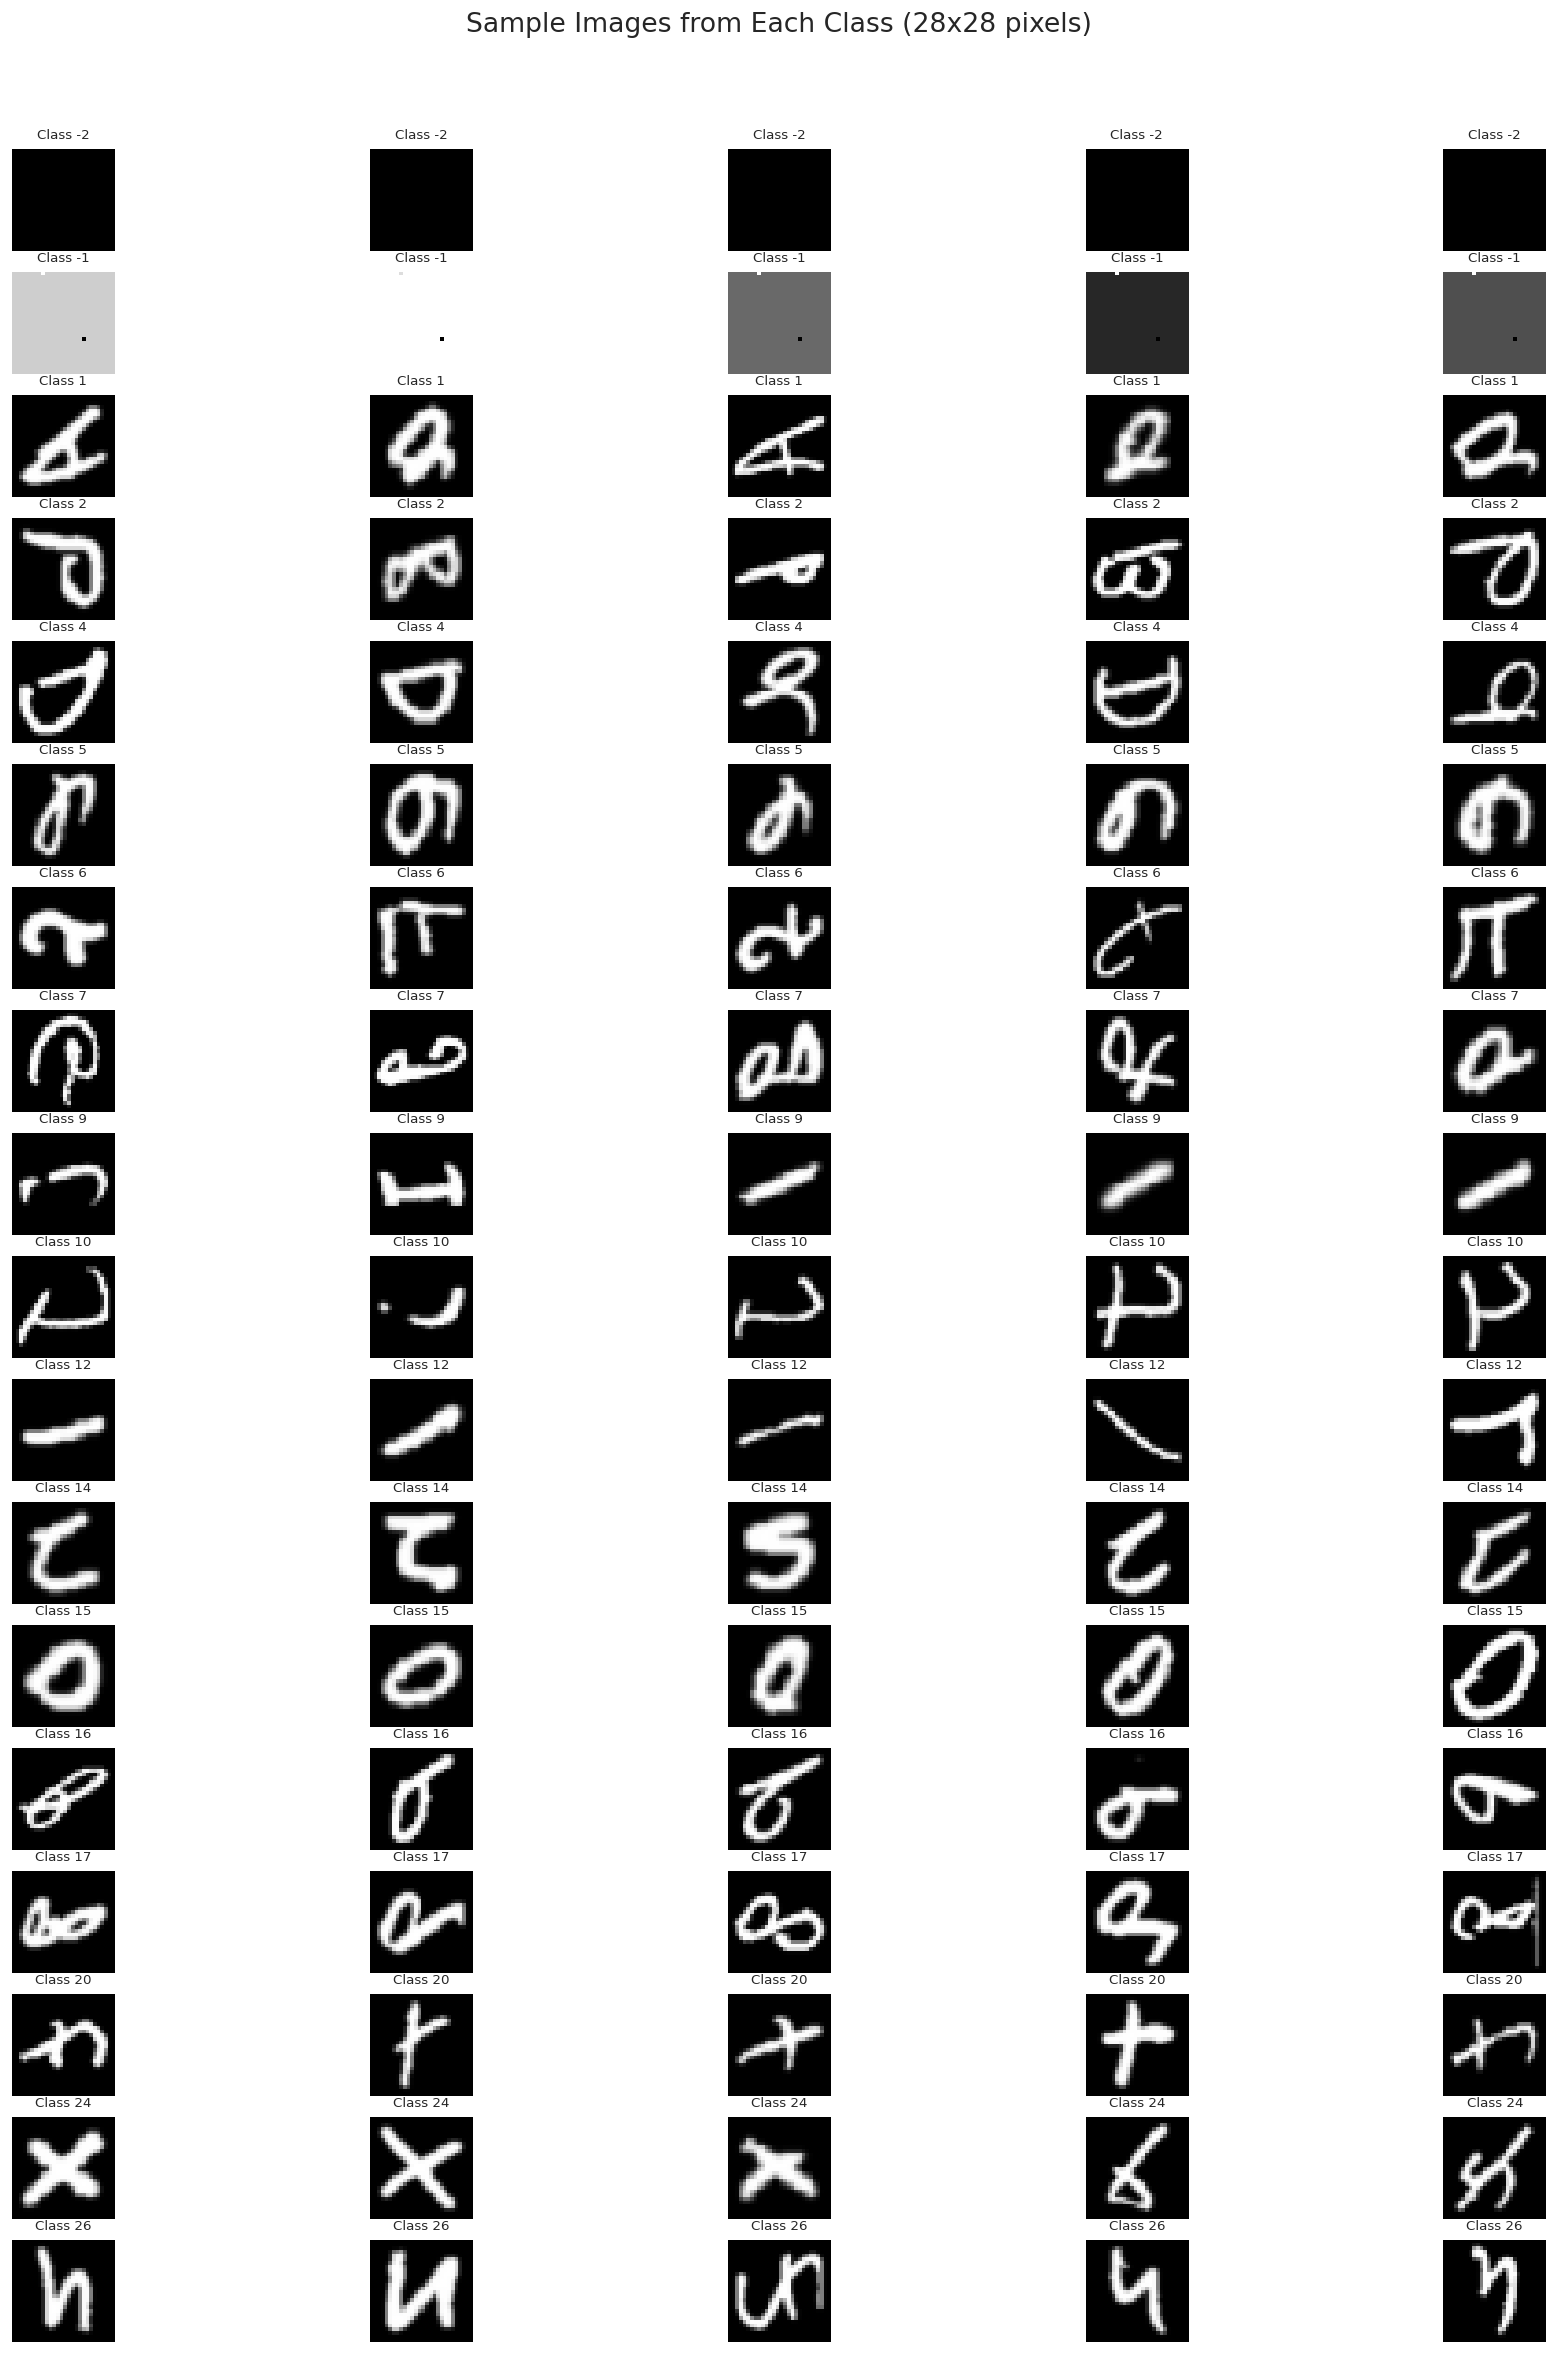

In [4]:
# Visualize sample images from different classes
def visualize_samples(data, n_samples=5, figsize=(15, 20)):
    """Visualize random samples from each class"""
    if 'label' not in data.columns:
        print("Label column not found")
        return

    unique_labels = sorted(data['label'].unique())
    n_classes = len(unique_labels)

    fig, axes = plt.subplots(n_classes, n_samples, figsize=figsize)
    fig.suptitle(f'Sample Images from Each Class (28x28 pixels)', fontsize=16)

    for i, label in enumerate(unique_labels):
        class_data = data[data['label'] == label]
        samples = class_data.sample(n=min(n_samples, len(class_data)))

        for j in range(n_samples):
            if j < len(samples):
                # Get pixel values (excluding the label column)
                pixel_values = samples.iloc[j, 1:].values
                # Reshape to 28x28 image
                image = pixel_values.reshape(28, 28)

                if n_classes == 1:
                    axes[j].imshow(image, cmap='gray')
                    axes[j].set_title(f'Class {label}', fontsize=8)
                    axes[j].axis('off')
                else:
                    axes[i, j].imshow(image, cmap='gray')
                    if j == 0:
                        axes[i, j].set_ylabel(f'Class {label}', fontsize=10)
                    axes[i, j].set_title(f'Class {label}', fontsize=8)
                    axes[i, j].axis('off')
            else:
                if n_classes == 1:
                    axes[j].axis('off')
                else:
                    axes[i, j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    plt.show()

# Visualize samples
visualize_samples(data, n_samples=5)


### Observations
After visualizing the dataset, we made the following key observations:

1. **Blank Classes**  
   - **Class -1** and **Class -2** contain only blank images.  
   - These classes are **not useful** for model training and will be **removed** from the dataset.

2. **Label Mapping**  
   - After removing blank classes, the remaining class labels start from `1` and follow **alphabetical order**, but not sequential, i.e.,  
     - Class `1` = `A`  
     - Class `2` = `B`, and `C` was skipped
     - Class `3` = `D`  
     - ... and so on.

3. **Mirrored Images**  
   - The characters appear to be **mirrored** (flipped horizontally).  
   - This needs to be corrected for accurate training.

---

#### Preprocessing

To prepare the dataset for model training, we will apply the following steps:

1. **Remove Blank Images**  
   - Drop all entries with class `-1` and `-2`.

2. **Fix Image Orientation**  
   - Horizontally flip all images to correct the mirrored effect.



These steps will help ensure our model receives clean, diverse, and correctly labeled input data.


## Data Cleaning & Analysis

=== DATA CLEANING AND PREPROCESSING ===
Original dataset shape: (64829, 785)

1. Removing blank classes (-1 and -2)...
   Class -1: 5384 samples (to be removed)
   Class -2: 4856 samples (to be removed)
   Dataset shape after removing blank classes: (54589, 785)

2. Fixing image orientation (horizontal flip)...
   Applying horizontal flip to all images...

3. Creating proper label mapping...
   Remaining classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(12), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(20), np.int64(24), np.int64(26)]
   Label to Letter mapping: {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'}

4. Visualizing samples after preprocessing...


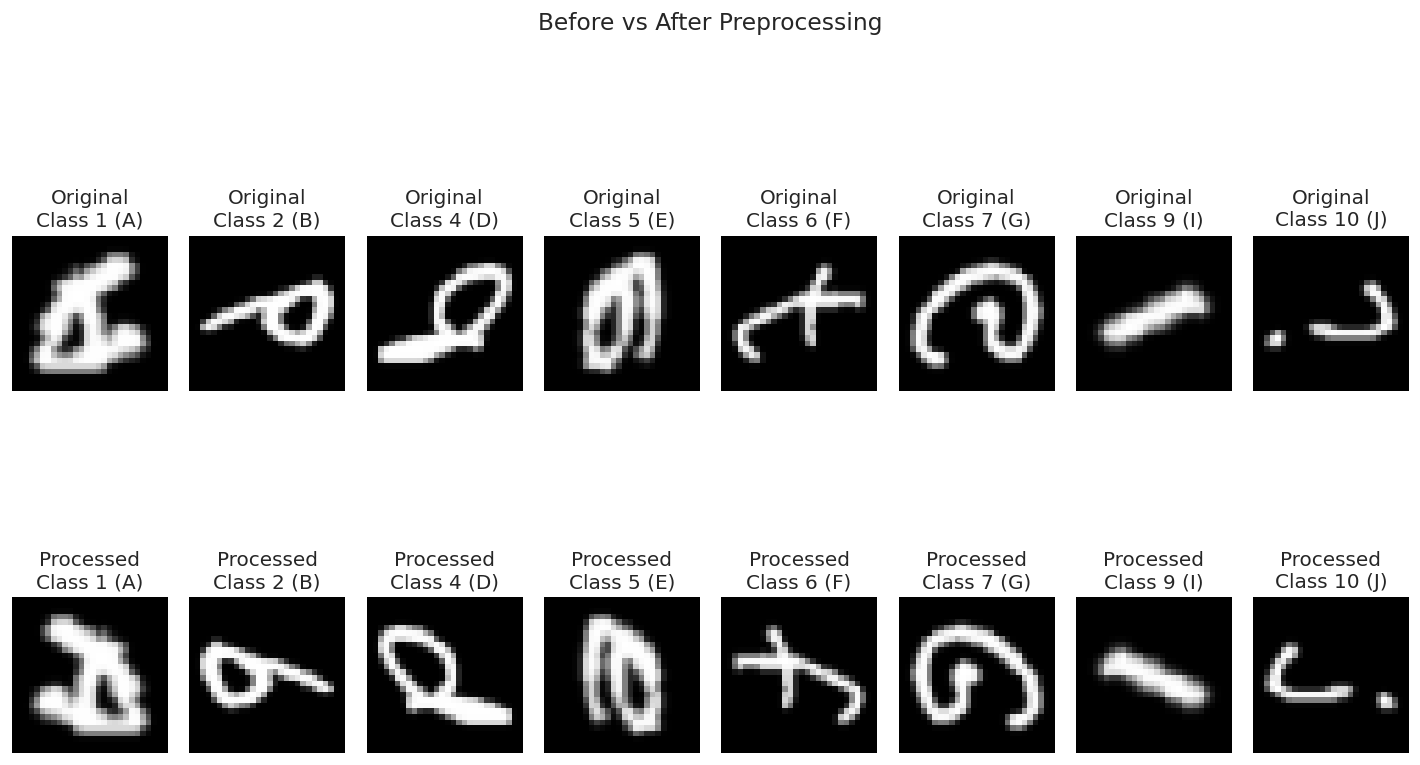


5. Final dataset statistics:
   Final dataset shape: (54589, 785)
   Number of classes: 16
   Classes removed: [-1, -2]


In [5]:
# Data Cleaning and Preprocessing
def clean_and_preprocess_dataset(data):
    """Clean the dataset by removing blank classes and fixing image orientation"""

    print("=== DATA CLEANING AND PREPROCESSING ===")
    print(f"Original dataset shape: {data.shape}")

    # 1. Remove blank classes (-1 and -2)
    print(f"\n1. Removing blank classes (-1 and -2)...")
    blank_classes = [-1, -2]

    for blank_class in blank_classes:
        count = len(data[data['label'] == blank_class])
        print(f"   Class {blank_class}: {count} samples (to be removed)")

    cleaned_data = data[~data['label'].isin(blank_classes)].copy()
    print(f"   Dataset shape after removing blank classes: {cleaned_data.shape}")

    # 2. Fix image orientation (horizontal flip)
    print(f"\n2. Fixing image orientation (horizontal flip)...")
    pixel_columns = [col for col in cleaned_data.columns if col.startswith('pixel_')]

    def flip_image_horizontal(pixel_row):
        image = pixel_row.values.reshape(28, 28)
        flipped_image = np.fliplr(image)
        return flipped_image.flatten()

    print("   Applying horizontal flip to all images...")
    flipped_pixels = cleaned_data[pixel_columns].apply(flip_image_horizontal, axis=1, result_type='expand')
    cleaned_data[pixel_columns] = flipped_pixels

    # 3. Update label mapping for alphabetical order
    print(f"\n3. Creating proper label mapping...")
    remaining_labels = sorted(cleaned_data['label'].unique())
    print(f"   Remaining classes: {remaining_labels}")

    letter_mapping = {i: chr(ord('A') + i - 1) for i in range(1, 27)}
    print(f"   Label to Letter mapping: {letter_mapping}")

    # 4. Visualize samples after preprocessing
    print(f"\n4. Visualizing samples after preprocessing...")
    def compare_before_after(original_data, cleaned_data, n_samples=8):
        fig, axes = plt.subplots(2, n_samples, figsize=(12, 8))
        fig.suptitle('Before vs After Preprocessing', fontsize=14)

        common_labels = [label for label in remaining_labels[:n_samples]]

        for i, label in enumerate(common_labels):
            orig_sample = original_data[original_data['label'] == label].iloc[0]
            orig_pixels = orig_sample[pixel_columns].values.reshape(28, 28)

            clean_sample = cleaned_data[cleaned_data['label'] == label].iloc[0]
            clean_pixels = clean_sample[pixel_columns].values.reshape(28, 28)

            axes[0, i].imshow(orig_pixels, cmap='gray')
            axes[0, i].set_title(f'Original\nClass {label} ({letter_mapping[label]})')
            axes[0, i].axis('off')

            axes[1, i].imshow(clean_pixels, cmap='gray')
            axes[1, i].set_title(f'Processed\nClass {label} ({letter_mapping[label]})')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    compare_before_after(data, cleaned_data, n_samples=8)

    # 5. Final statistics
    print(f"\n5. Final dataset statistics:")
    print(f"   Final dataset shape: {cleaned_data.shape}")
    print(f"   Number of classes: {len(remaining_labels)}")
    print(f"   Classes removed: {blank_classes}")

    # map labels to letters
    cleaned_data['label'] = cleaned_data['label'].map(letter_mapping)

    return cleaned_data, letter_mapping

# Apply cleaning and preprocessing
cleaned_data, letter_mapping = clean_and_preprocess_dataset(data)


###  After Preprocessing Observation

After applying the initial preprocessing steps (horizontal flipping and relabeling the classes), we made an additional observation:

- **Rotated Letters**  
  - All the characters are still **rotated sideways**.
  - To correct this, we need to **rotate each image by 90 degrees anti-clockwise** so that the letters are properly upright.

---

#### Updated Preprocessing Steps

1. **Remove Blank Images** (`Class -1` and `Class -2`)
2. **Relabel Classes** (Class `1` = `A`, Class `2` = `B`, ...)
3. **Flip Images Horizontally** (to fix mirrored effect)
4. **Rotate Images 90° Anti-Clockwise** (to orient characters correctly)

This ensures the images are in the correct visual format before we apply any further augmentation or training.


=== ROTATING IMAGES 90° ANTI-CLOCKWISE ===
Dataset shape before rotation: (54589, 785)
   Applying 90° anti-clockwise rotation to all images...
   Visualizing before vs after rotation...


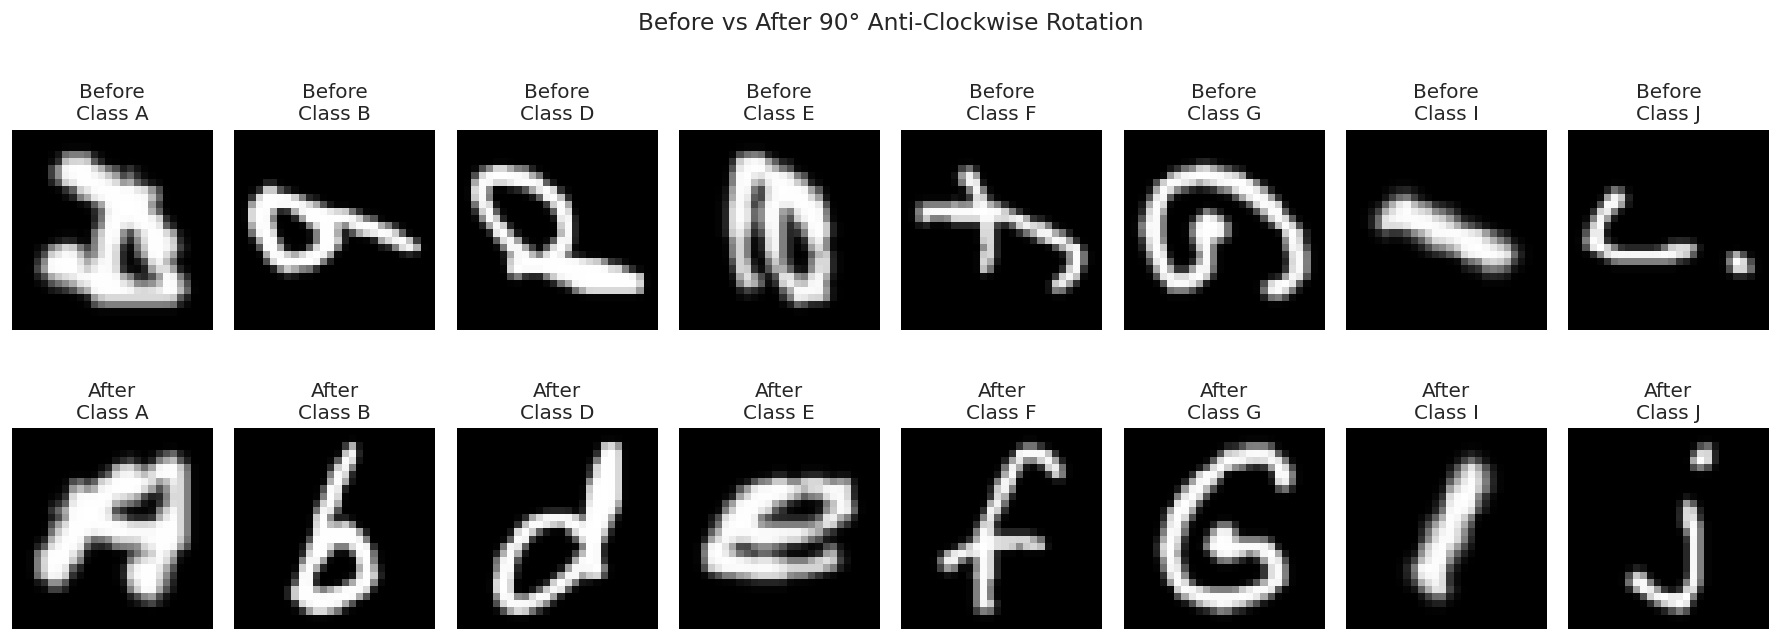

   Final dataset shape after rotation: (54589, 785)
   Rotation completed successfully!


In [6]:
# Rotate all images 90 degrees anti-clockwise
def rotate_images_90_anticlockwise(data):
    """Rotate all images in the dataset 90 degrees anti-clockwise"""

    print("=== ROTATING IMAGES 90° ANTI-CLOCKWISE ===")
    print(f"Dataset shape before rotation: {data.shape}")

    # Extract pixel columns
    pixel_columns = [col for col in data.columns if col.startswith('pixel_')]

    def rotate_image_90_anticlockwise(pixel_row):
        # Reshape to 28x28, rotate 90° anti-clockwise, then flatten back
        image = pixel_row.values.reshape(28, 28)
        rotated_image = np.rot90(image, k=1)  # k=1 means 90° counter-clockwise
        return pd.Series(rotated_image.flatten())

    # Apply rotation to all images
    print("   Applying 90° anti-clockwise rotation to all images...")
    rotated_pixels = data[pixel_columns].apply(rotate_image_90_anticlockwise, axis=1, result_type='expand')
    rotated_pixels = rotated_pixels.astype(np.float32)  # Ensure pixel values are float32

    # Create a copy of the data and replace pixel columns with rotated versions
    rotated_data = data.copy()
    rotated_data[pixel_columns] = rotated_pixels

    # Visualize before and after comparison
    print("   Visualizing before vs after rotation...")

    def compare_rotation(original_data, rotated_data, n_samples=8):
        fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
        fig.suptitle('Before vs After 90° Anti-Clockwise Rotation', fontsize=14)

        # Select sample labels to visualize
        sample_labels = sorted(original_data['label'].unique())[:n_samples]

        for i, label in enumerate(sample_labels):
            if label in original_data['label'].values:
                # Original (before rotation)
                orig_sample = original_data[original_data['label'] == label].iloc[0]
                orig_pixels = orig_sample[pixel_columns].values.astype(np.float32).reshape(28, 28)

                # Rotated (after rotation)
                rot_sample = rotated_data[rotated_data['label'] == label].iloc[0]
                rot_pixels = rot_sample[pixel_columns].values.astype(np.float32).reshape(28, 28)

                # Plot original
                axes[0, i].imshow(orig_pixels, cmap='gray')
                axes[0, i].set_title(f'Before\nClass {label}')
                axes[0, i].axis('off')

                # Plot rotated
                axes[1, i].imshow(rot_pixels, cmap='gray')
                axes[1, i].set_title(f'After\nClass {label}')
                axes[1, i].axis('off')
            else:
                axes[0, i].axis('off')
                axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    # Show comparison
    compare_rotation(data, rotated_data, n_samples=8)

    print(f"   Final dataset shape after rotation: {rotated_data.shape}")
    print("   Rotation completed successfully!")

    return rotated_data

# Apply rotation to the cleaned data
rotated_data = rotate_images_90_anticlockwise(cleaned_data)



### Class Balance

Now, the images are in the correct shape and orientation, ready to be used for training.  
Let's observe how many samples there are per each class to see if there's any class imbalance.

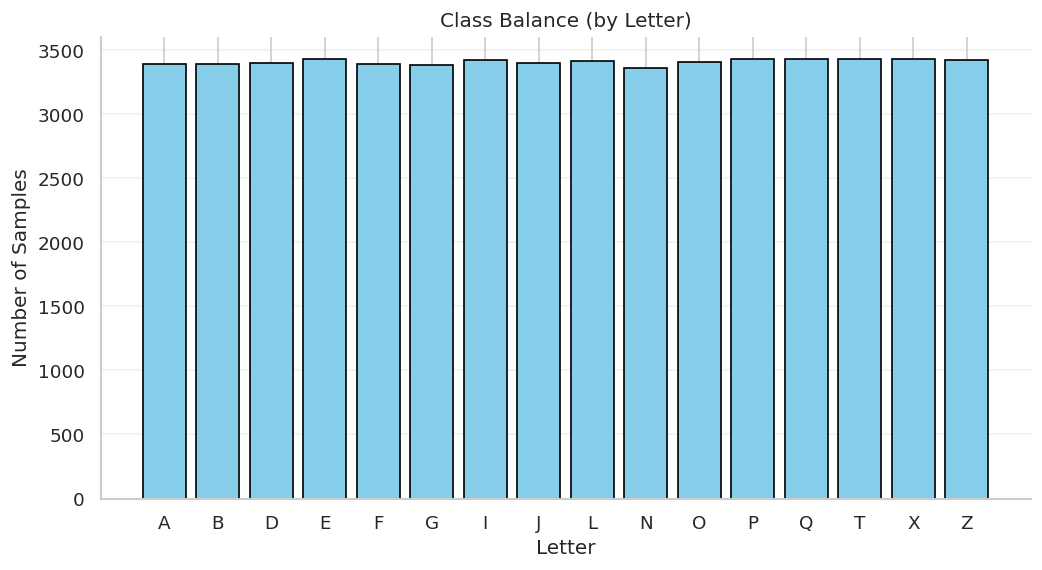

label
A    3396
B    3396
D    3398
E    3437
F    3394
G    3385
I    3428
J    3402
L    3415
N    3365
O    3408
P    3430
Q    3435
T    3436
X    3437
Z    3427


In [7]:
# === Class balance (bar chart) ===

# Count samples per letter (first column is 'label' containing letters)
counts = (
    rotated_data['label']
    .dropna()
    .value_counts()
    .sort_index()          # alphabetical order
)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.title("Class Balance (by Letter)")
plt.xlabel("Letter")
plt.ylabel("Number of Samples")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print exact counts
print(counts.to_string())



As observed, the samples per each class are balanced, with only very small differences.  
Now, let's visually inspect our processed dataset.

### Our final dataset

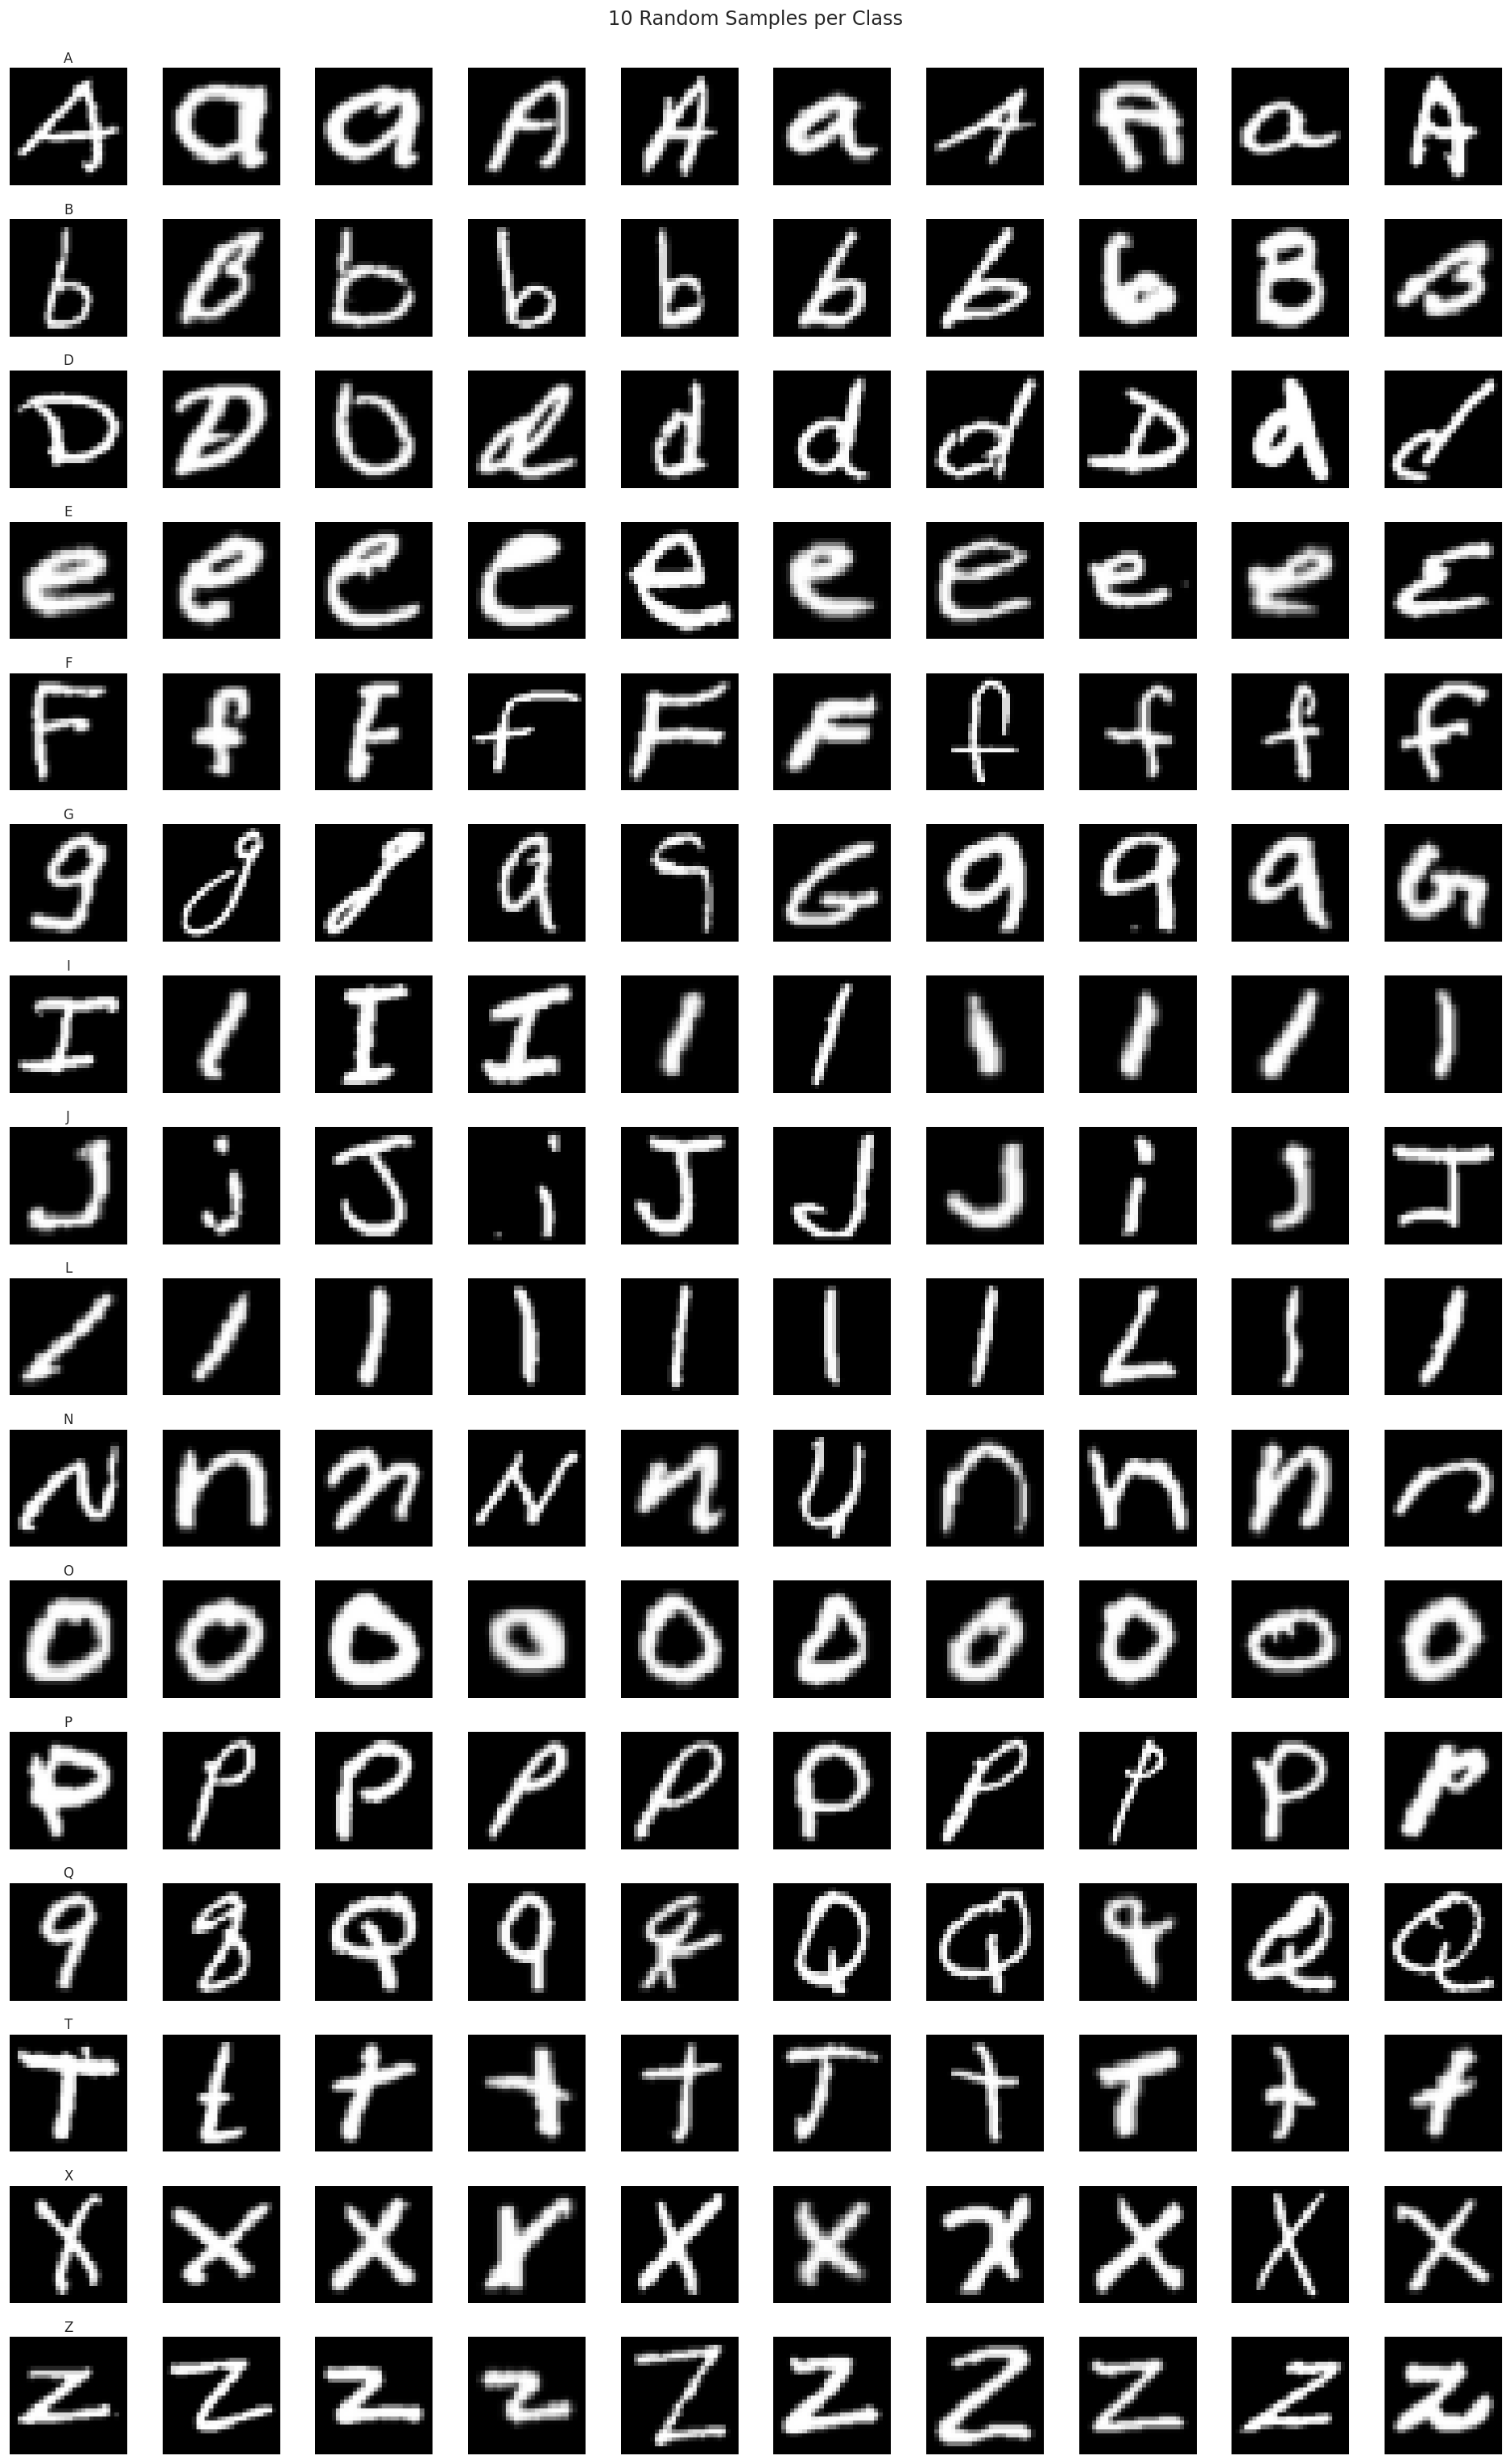

In [8]:
# === Visual inspection: 10 random samples per class ===


def get_pixel_columns(df):
    """Return list of pixel column names."""
    return [c for c in df.columns if c.startswith("pixel_")]

def show_samples_per_class(df, label_col="label", n_per_class=10, seed=42):
    """
    Display n_per_class random samples for each letter class.

    Args:
        df: DataFrame with a label column (letters) and pixel_0..pixel_783 columns.
        label_col: Column name containing letter labels.
        n_per_class: Number of samples to display per class.
        seed: Random seed for reproducibility.
    """
    pix_cols = get_pixel_columns(df)
    letters = sorted(df[label_col].dropna().unique())
    rng = np.random.default_rng(seed)

    rows = len(letters)
    cols = n_per_class
    fig, axes = plt.subplots(rows, cols, figsize=(1.6*cols, 1.6*rows))
    if rows == 1:
        axes = np.array([axes])  # normalize to 2D array

    for i, letter in enumerate(letters):
        subset = df[df[label_col] == letter]
        take = min(n_per_class, len(subset))
        idx = rng.choice(subset.index, size=take, replace=False)
        samples = subset.loc[idx, pix_cols].values.reshape(take, 28, 28)

        for j in range(cols):
            ax = axes[i, j]
            ax.axis("off")
            if j < take:
                ax.imshow(samples[j], cmap="gray")
            if j == 0:
                ax.set_title(f"{letter}", fontsize=10, pad=4)

    plt.suptitle(f"{n_per_class} Random Samples per Class", y=0.995)
    plt.tight_layout()
    plt.show()

# Run for rotated_data
show_samples_per_class(rotated_data, label_col="label", n_per_class=10, seed=123)


### Class Separation and Mixing Assessment with t-SNE

Some letters appear to have very poor handwriting quality, as expected.  
To investigate which classes are mixed, we use t-SNE to visualize the high-dimensional data in 2D.

We also calculate neighborhood purity and a mixing matrix using k-nearest neighbors to assess how well different classes are separated or mixed after preprocessing.

- **High purity:** Class is well-clustered in feature space.
- **Mixing matrix heatmap:** Highlights which classes are often confused or overlap.


This provides a quick visual and statistical check of class separation and potential confusion in the dataset.

Per-class kNN purity (lower = more mixed):
G    0.521371
I    0.529216
L    0.556000
A    0.559304
Q    0.564347
F    0.620255
P    0.655533
T    0.675132
D    0.692102
B    0.749130
O    0.796526
J    0.802271
E    0.812169
N    0.852197
Z    0.885126
X    0.897487


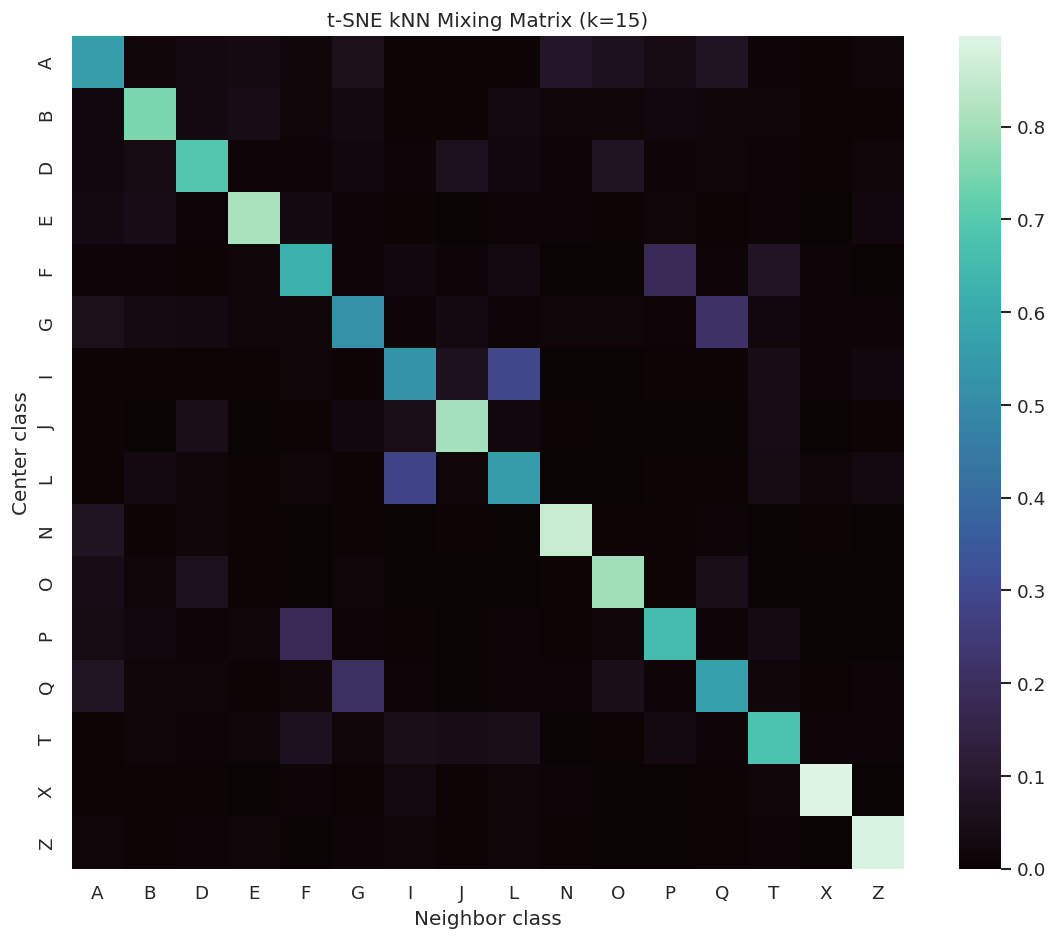

In [18]:
# --- Prepare data (subsample for speed) ---
pix_cols = [f'pixel_{i}' for i in range(784)]
X = rotated_data[pix_cols].values.astype(np.float32)
y = rotated_data['label'].values  # letters after your relabel

# Stratified subset (e.g., 8000 total samples)
sss = StratifiedShuffleSplit(n_splits=1, test_size=8000, random_state=42)
_, sub_idx = next(sss.split(X, y))
X_sub, y_sub = X[sub_idx], y[sub_idx]

# Optional: normalize to [0,1] or [-1,1] if needed (your pipeline may already do this)
X_sub = X_sub / 255.0

# --- PCA -> t-SNE (faster, stabler) ---
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_sub)

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto',
            init='pca', random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# --- kNN neighborhood purity on t-SNE plane ---
k = 15
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X_tsne)
dist, idx = nbrs.kneighbors(X_tsne)

# discard self-neighbor at column 0
nn_labels = y_sub[idx[:, 1:]]  # shape: (n_samples, k)

# For each point: fraction of neighbors with same label
same = (nn_labels == y_sub[:, None]).mean(axis=1)
point_purity = same  # per-sample purity in [0,1]

# Aggregate per class
class_purity = pd.Series(point_purity).groupby(y_sub).mean().sort_values()
print("Per-class kNN purity (lower = more mixed):")
print(class_purity.to_string())

# --- Cross-class mixing matrix: how often neighbors are of class B given center is class A ---
classes = np.unique(y_sub)
cls_to_id = {c:i for i,c in enumerate(classes)}
mix_mat = np.zeros((len(classes), len(classes)), dtype=np.float32)

for i in range(nn_labels.shape[0]):
    c_from = cls_to_id[y_sub[i]]
    # count neighbor labels
    for lbl in nn_labels[i]:
        mix_mat[c_from, cls_to_id[lbl]] += 1

# Normalize rows to probabilities
row_sums = mix_mat.sum(axis=1, keepdims=True)
mix_prob = np.divide(mix_mat, np.maximum(row_sums, 1e-9))

# Plot heatmap (diagonal = self; off-diagonals show mixing)
plt.figure(figsize=(10, 8))
sns.heatmap(mix_prob, xticklabels=classes, yticklabels=classes,
            cmap="mako", square=True)
plt.title(f"t-SNE kNN Mixing Matrix (k={k})")
plt.xlabel("Neighbor class")
plt.ylabel("Center class")
plt.tight_layout()
plt.show()


### Outlier Detection and Removal

#### Outliers detection with TSNE and DBSCAN

In [13]:
pixel_columns = [col for col in rotated_data.columns if col.startswith('pixel_')]


This code uses t-SNE to project the data into 2D and then applies DBSCAN clustering separately for each class to identify outliers.

- **Outliers** are detected as samples that fall into small or rare DBSCAN clusters (or are labeled as noise) within their class on the t-SNE plot.
- The method highlights unusual or atypical handwriting examples for each letter.
- Outlier images are visualized, making it easy to review potential mistakes, rare writing styles, or mislabeled data.

Label A: Found 43 potential outliers
Label B: Found 35 potential outliers
Label D: Found 0 potential outliers
Label E: Found 12 potential outliers
Label F: Found 0 potential outliers
Label G: Found 77 potential outliers
Label I: Found 0 potential outliers
Label J: Found 0 potential outliers
Label L: Found 0 potential outliers
Label N: Found 11 potential outliers
Label O: Found 0 potential outliers
Label P: Found 14 potential outliers
Label Q: Found 40 potential outliers
Label T: Found 26 potential outliers
Label X: Found 13 potential outliers
Label Z: Found 12 potential outliers

=== t-SNE + DBSCAN: VISUALIZING ALL 283 OUTLIERS ===

Label A: 43 outliers


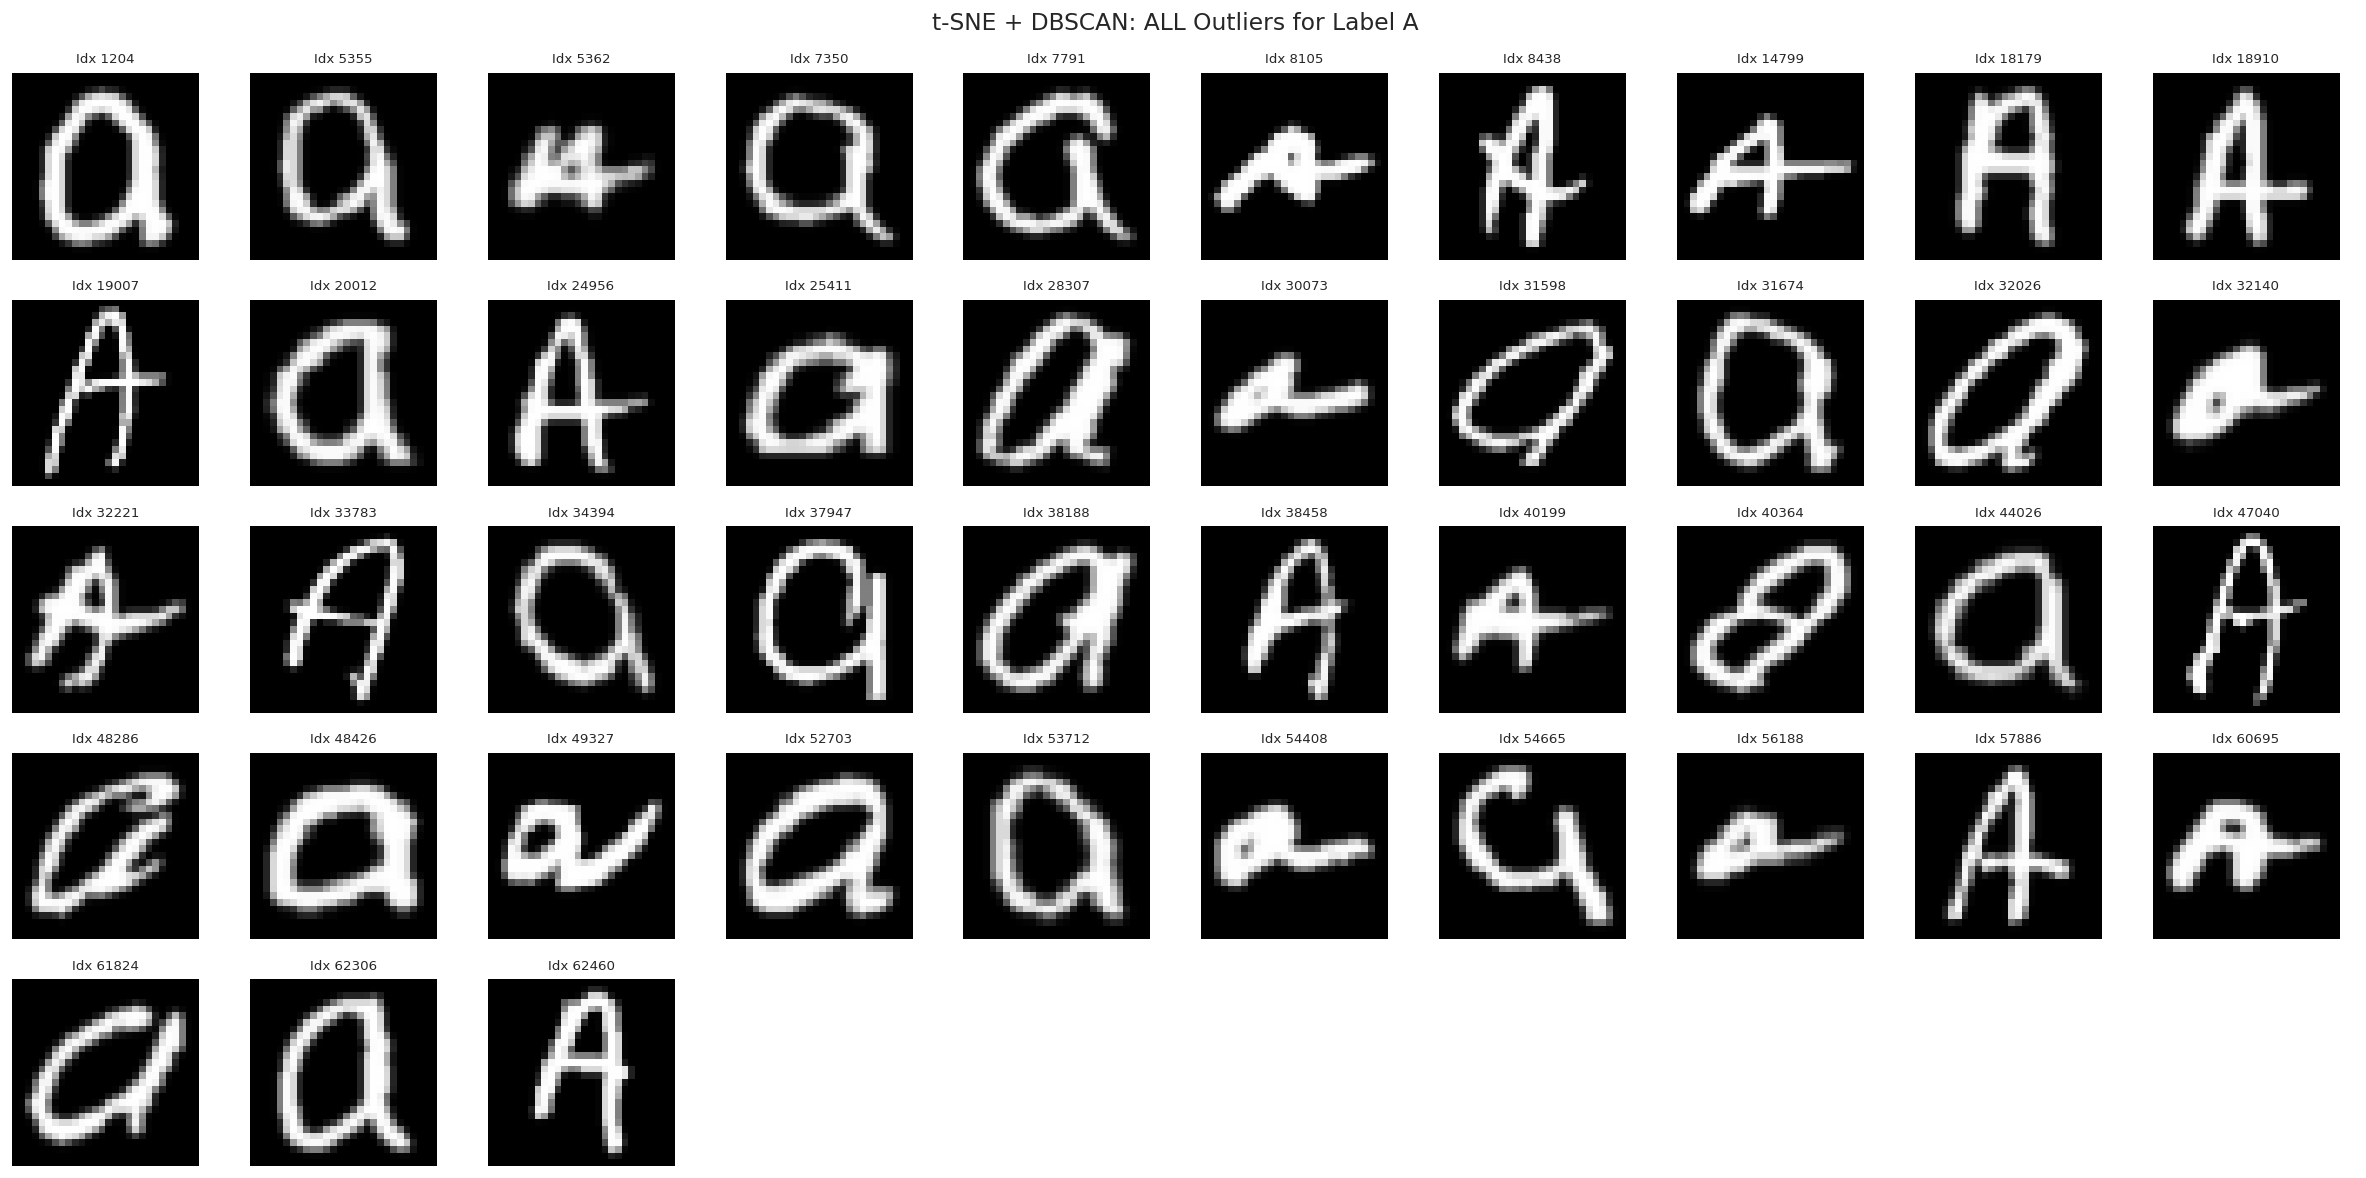


Label B: 35 outliers


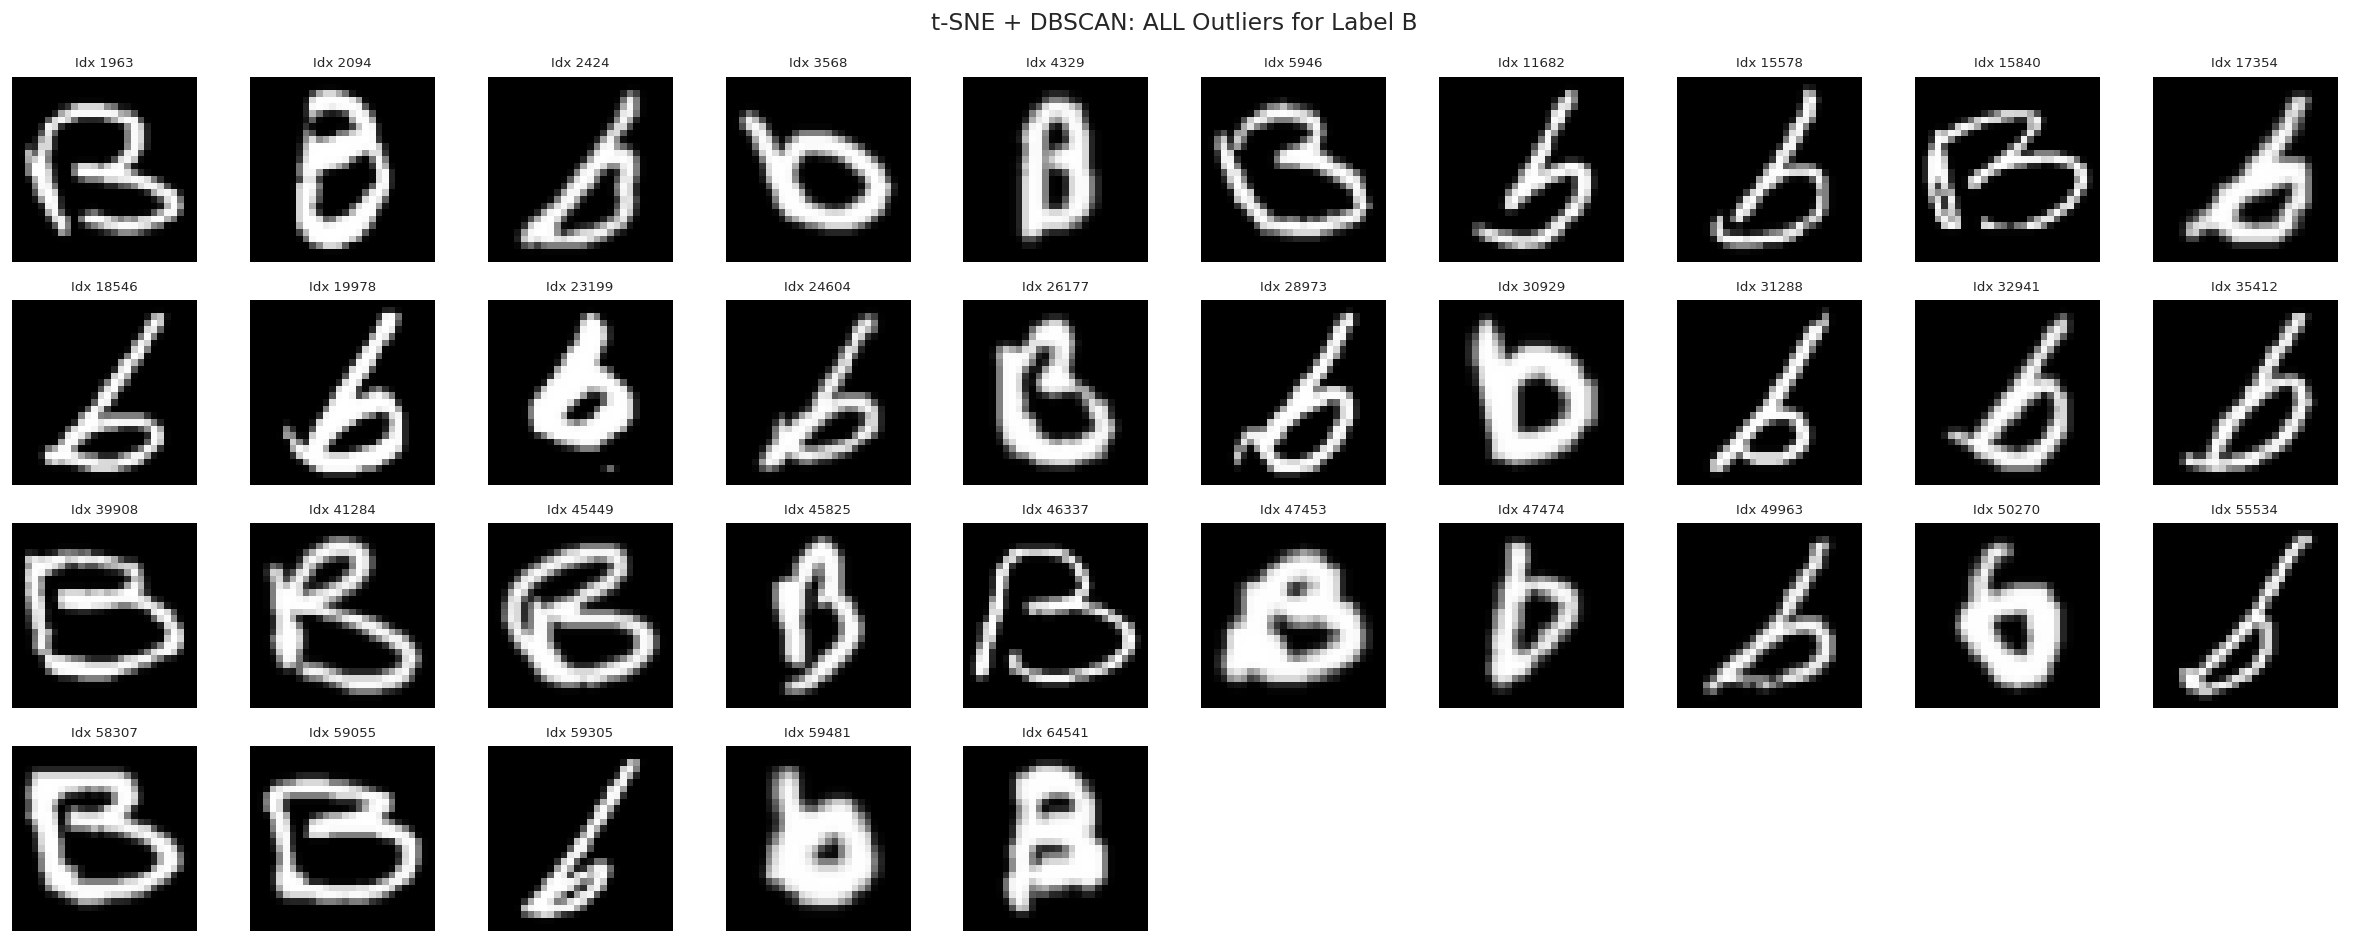


Label E: 12 outliers


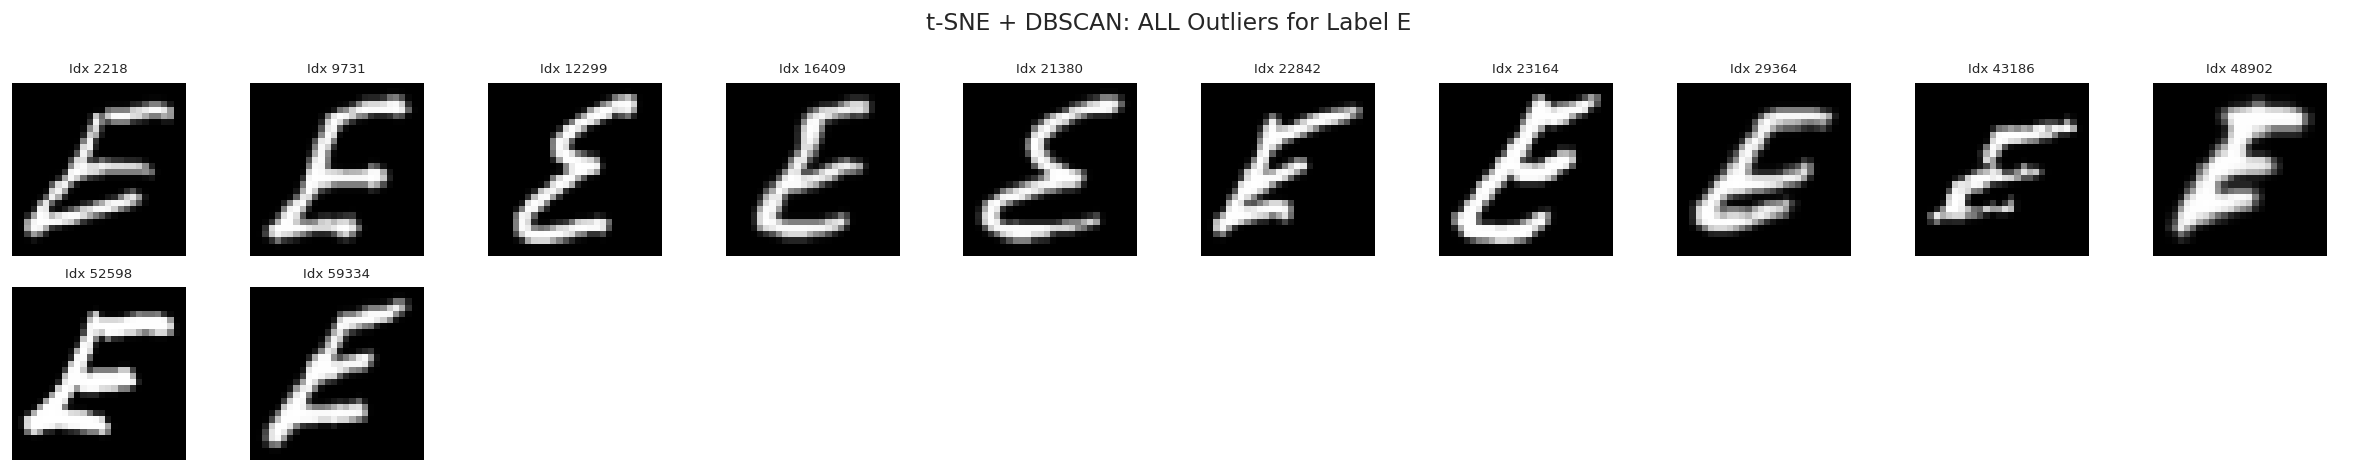


Label G: 77 outliers


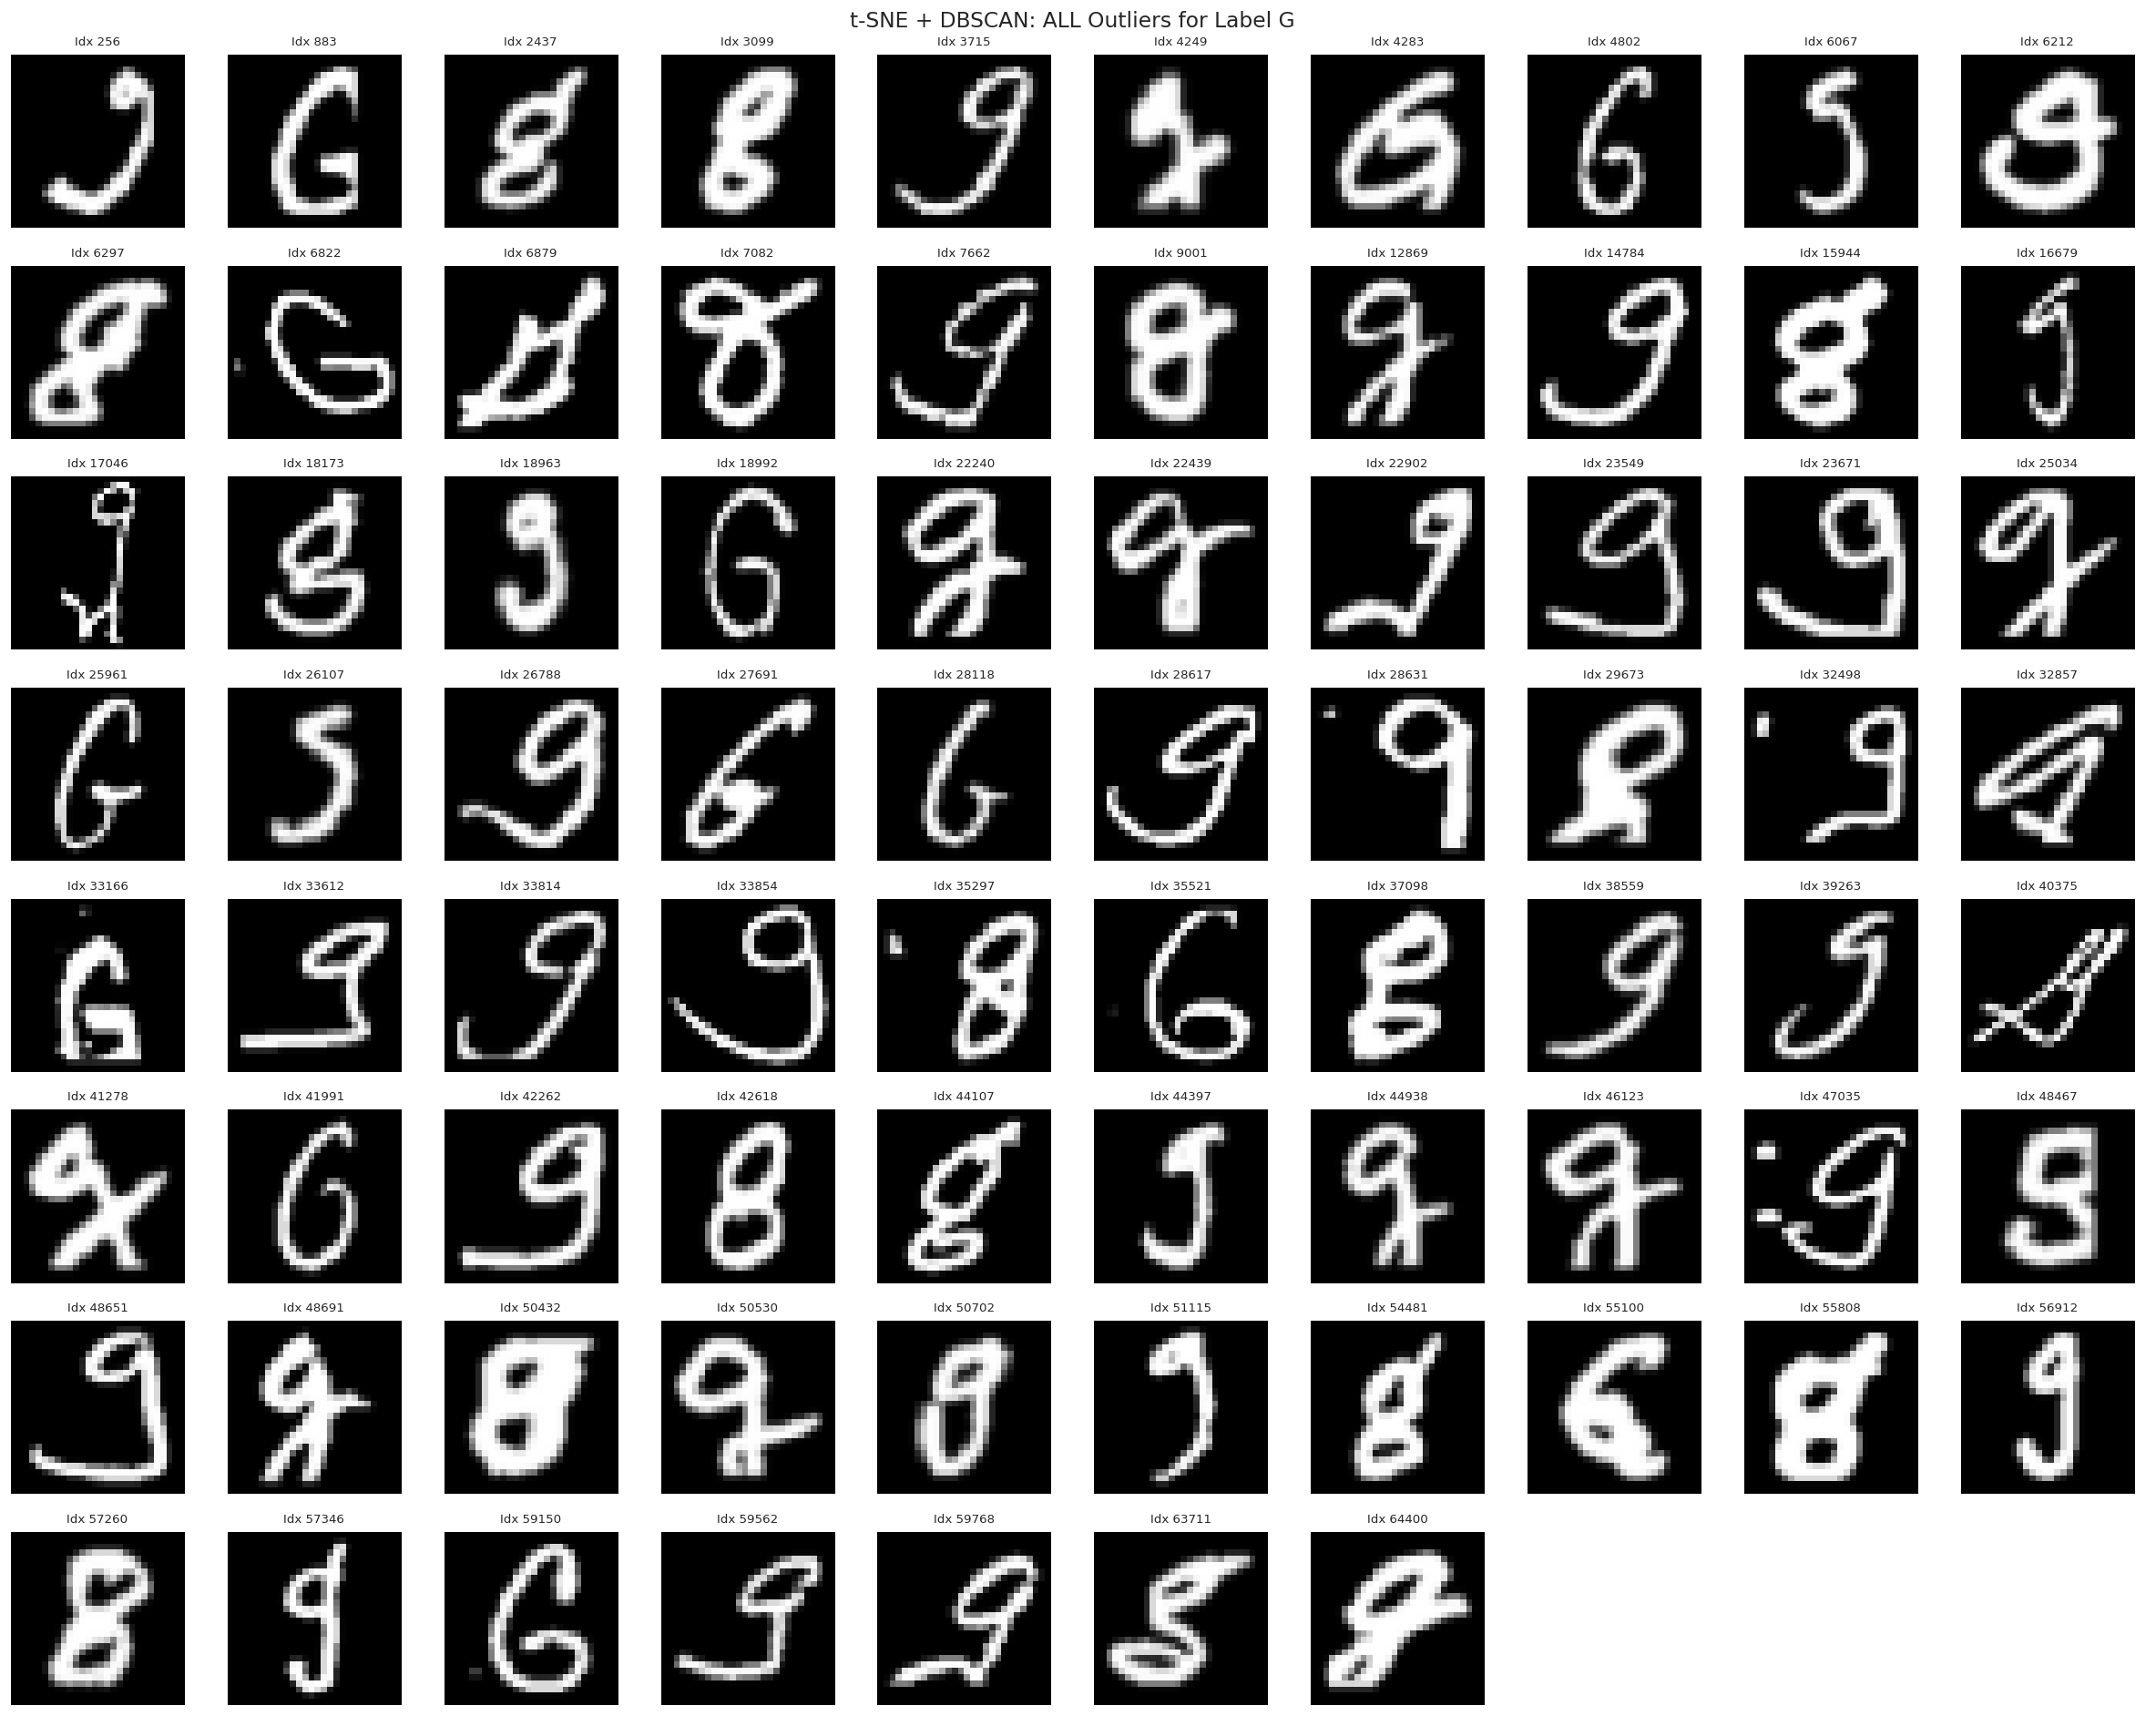


Label N: 11 outliers


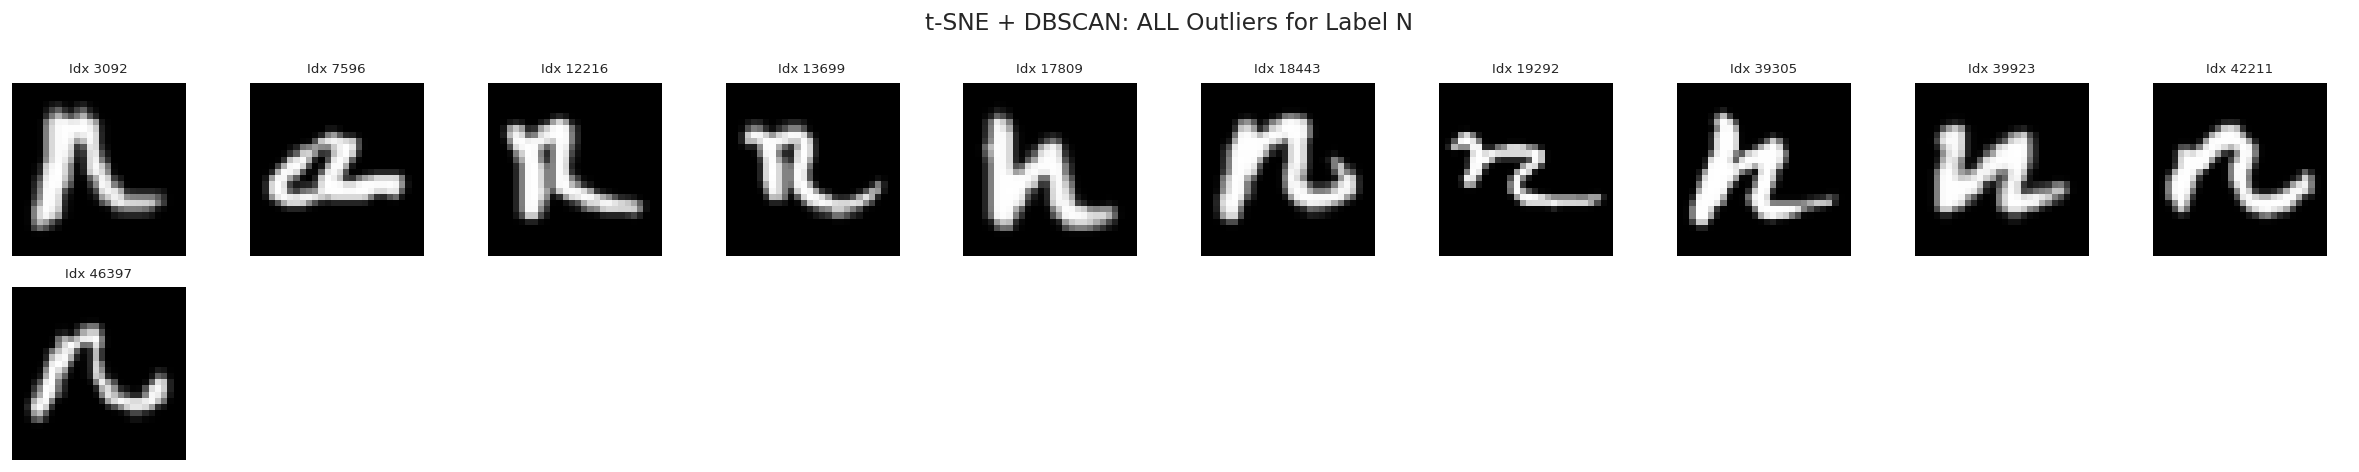


Label P: 14 outliers


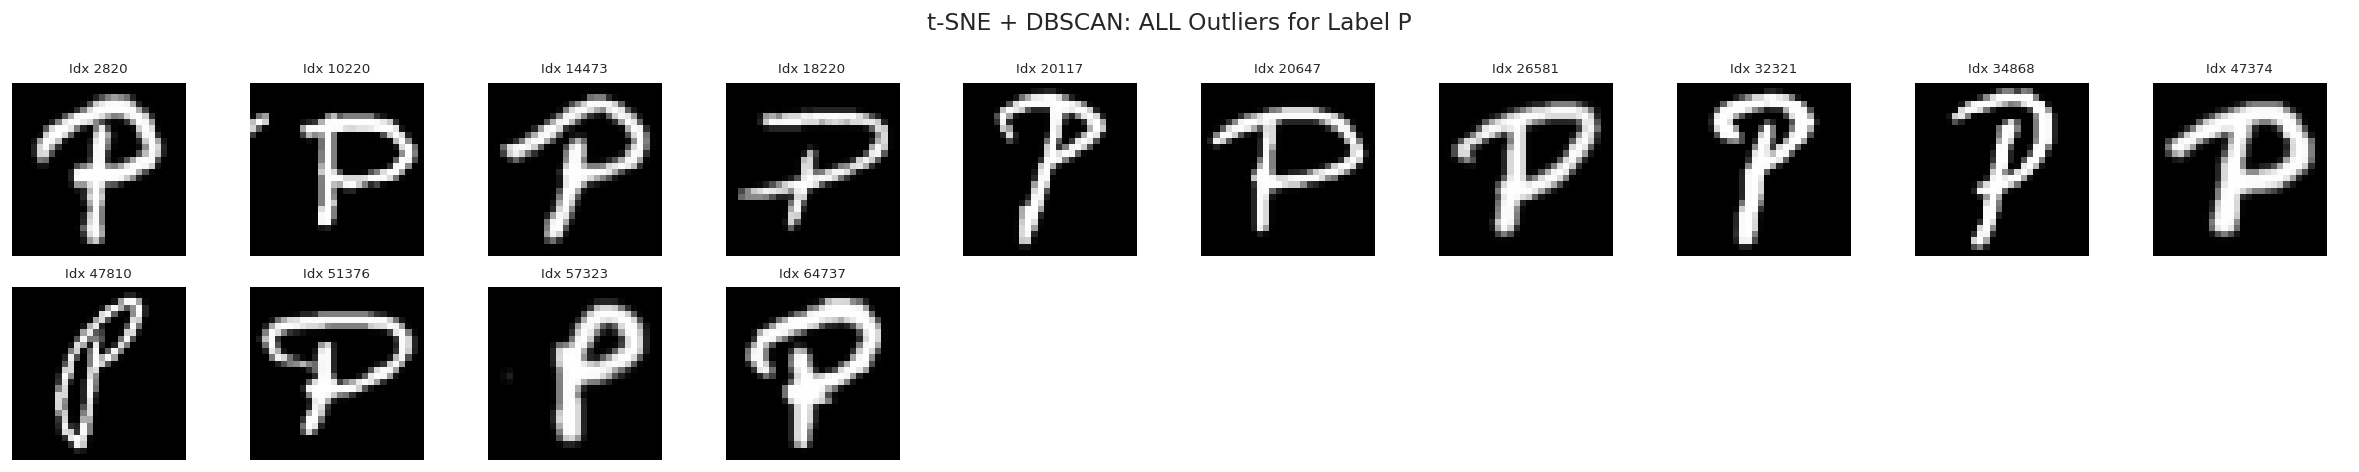


Label Q: 40 outliers


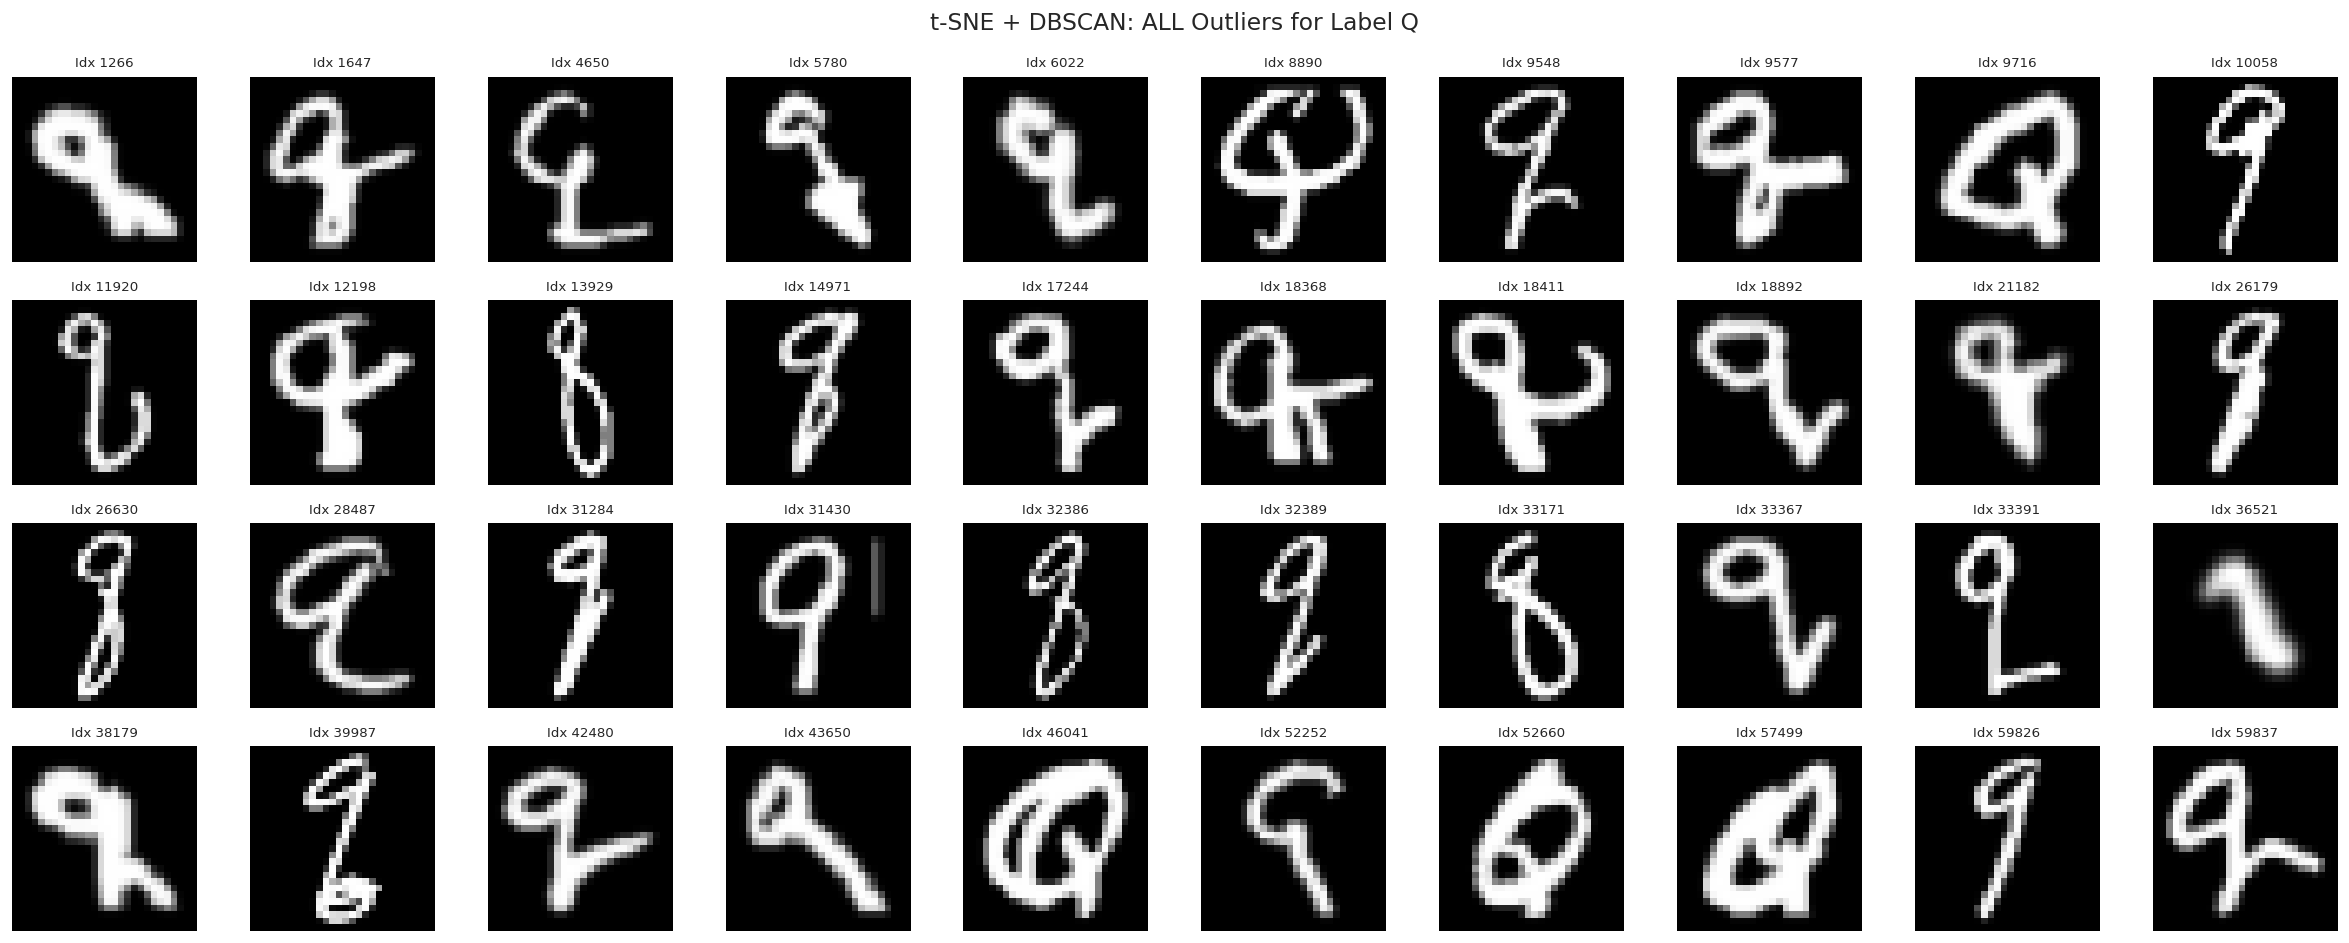


Label T: 26 outliers


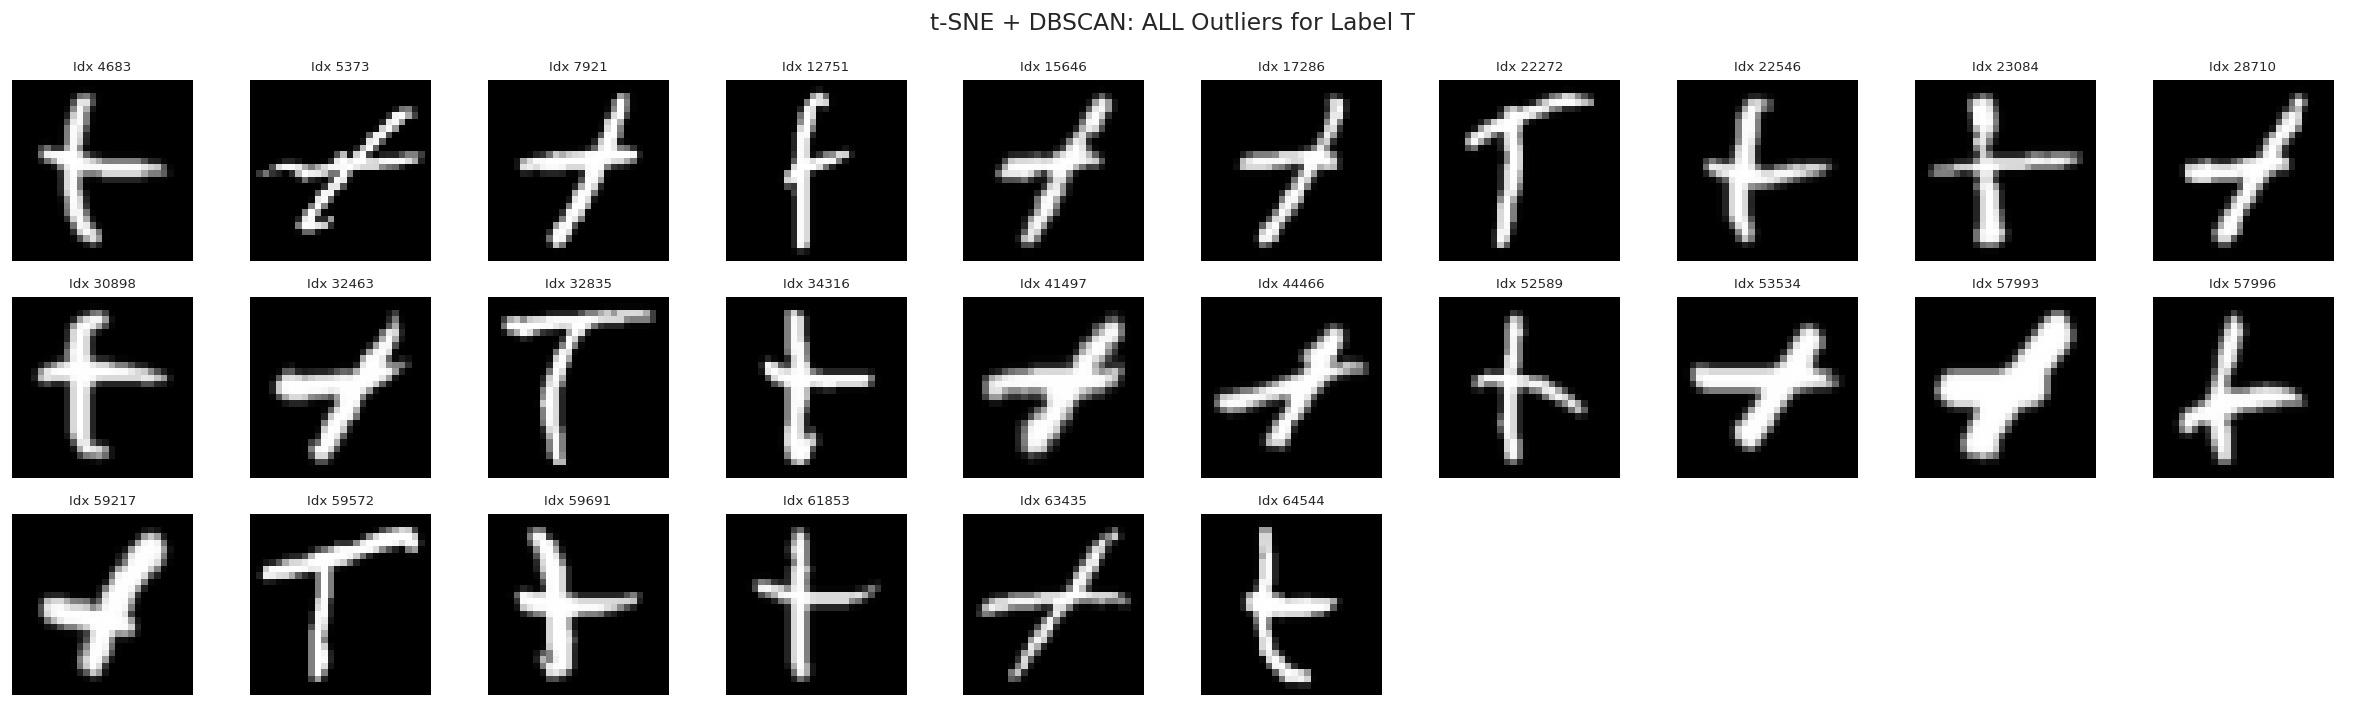


Label X: 13 outliers


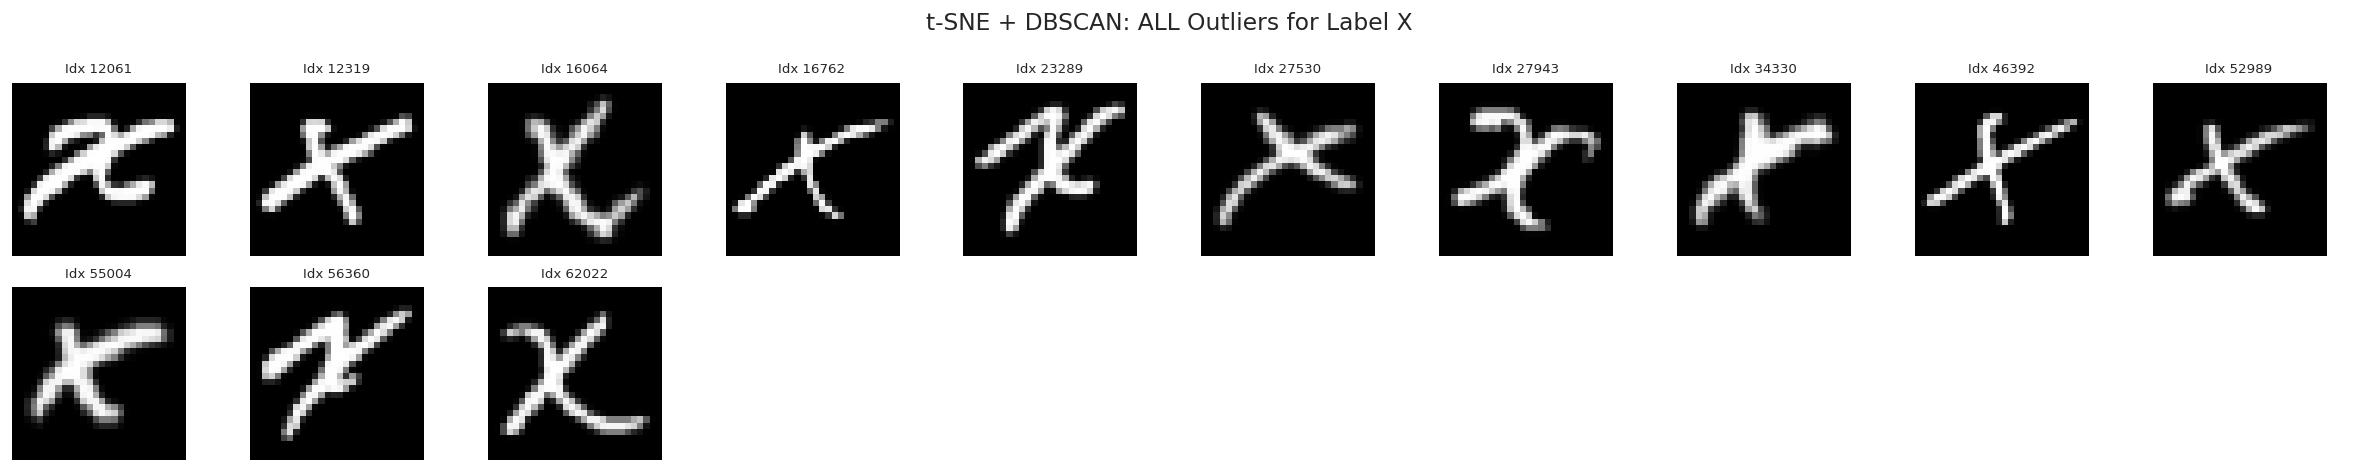


Label Z: 12 outliers


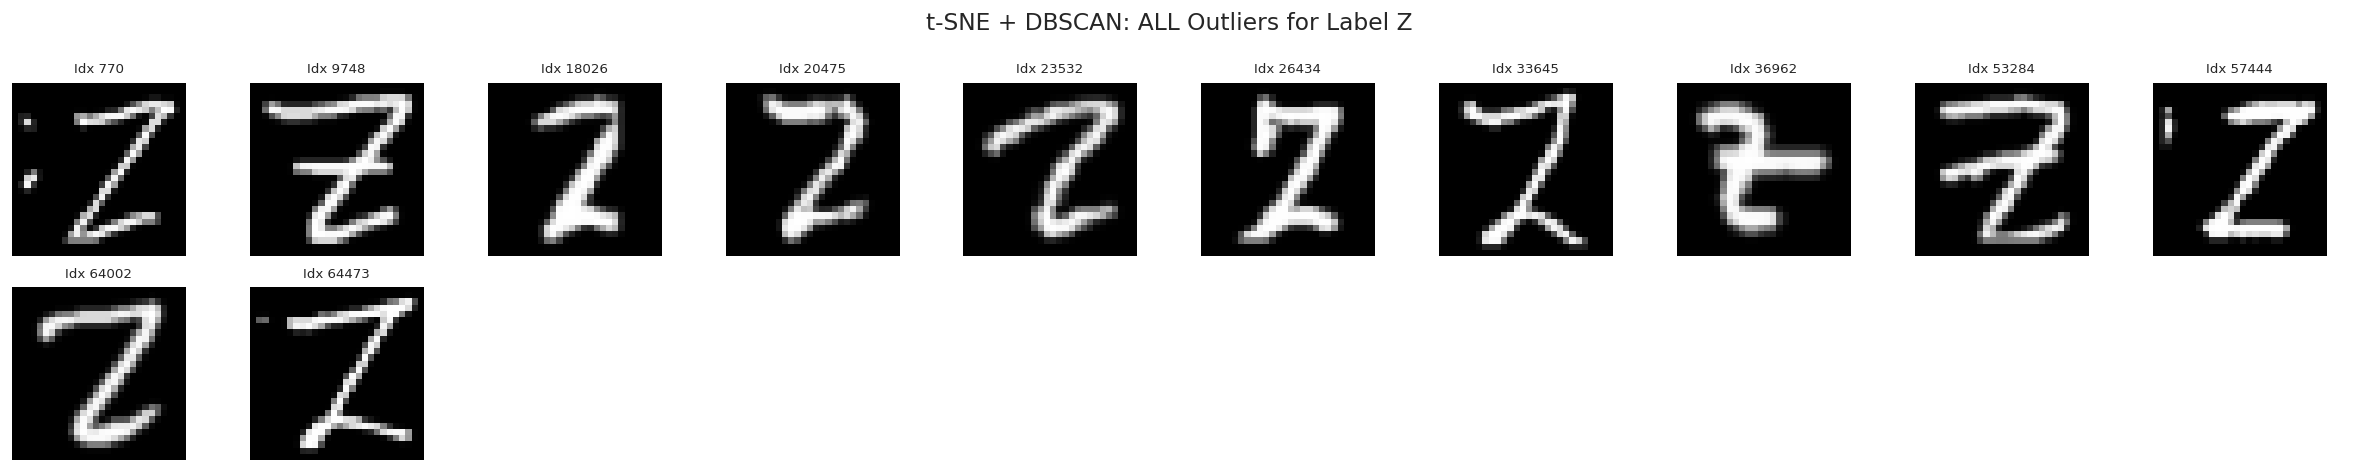

In [16]:

# Prepare t-SNE input
X_flat = rotated_data[pixel_columns].values
labels = rotated_data['label'].values

# Run t-SNE on entire dataset
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

# Attach t-SNE results to dataframe
rotated_data['tsne_x'] = X_tsne[:, 0]
rotated_data['tsne_y'] = X_tsne[:, 1]

# Store suspected outliers
outlier_rows = []
tsne_outlier_indices_by_label = {}

# For each label, cluster in t-SNE space
for label in np.unique(labels):
    subset = rotated_data[rotated_data['label'] == label]
    coords = subset[['tsne_x', 'tsne_y']].values

    # DBSCAN: density-based clustering
    dbscan = DBSCAN(eps=5.0, min_samples=10)
    cluster_labels = dbscan.fit_predict(coords)

    # Add cluster labels
    subset = subset.copy()
    subset['tsne_cluster'] = cluster_labels

    # Select outliers: cluster == -1 or rare clusters
    cluster_counts = subset['tsne_cluster'].value_counts()
    rare_clusters = cluster_counts[cluster_counts < 15].index
    is_outlier = subset['tsne_cluster'].isin(rare_clusters)
    outliers = subset[is_outlier]

    outlier_rows.append(outliers)
    print(f"Label {label}: Found {len(outliers)} potential outliers")

# Combine all outliers
all_tsne_outliers = pd.concat(outlier_rows, ignore_index=False) if outlier_rows else pd.DataFrame()

print(f"\n=== t-SNE + DBSCAN: VISUALIZING ALL {len(all_tsne_outliers)} OUTLIERS ===")

# Visualization function: show original index in full dataset
def visualize_all_outliers_tsne(df, pixel_columns, max_per_row=10):
    if df.empty:
        print("No outliers found!")
        return

    labels = sorted(df['label'].unique())

    for label in labels:
        subset = df[df['label'] == label]
        if len(subset) == 0:
            continue

        print(f"\nLabel {label}: {len(subset)} outliers")

        # Grid dimensions
        n_outliers = len(subset)
        n_rows = (n_outliers + max_per_row - 1) // max_per_row
        n_cols = min(max_per_row, n_outliers)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

        # Normalize axes structure
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = np.array([axes])
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)

        for i, (idx, row) in enumerate(subset.iterrows()):
            row_idx = i // max_per_row
            col_idx = i % max_per_row
            ax = axes[row_idx, col_idx]

            img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Idx {idx}", fontsize=8)
            ax.axis('off')

        # Hide any empty subplots
        total_subplots = n_rows * n_cols
        for i in range(n_outliers, total_subplots):
            row_idx = i // max_per_row
            col_idx = i % max_per_row
            axes[row_idx, col_idx].axis('off')

        plt.suptitle(f"t-SNE + DBSCAN: ALL Outliers for Label {label}", fontsize=14)
        plt.tight_layout()
        plt.show()

# Visualize
visualize_all_outliers_tsne(all_tsne_outliers, pixel_columns)

#### Outliers detection with IsolationForest


Anomaly Detection: Isolation-based Approach

This method focuses on identifying anomalies based on how easily they can be "isolated" from the rest of the data points.

* **Global Approach:** The algorithm operates directly on the raw data in its full 784-dimensional pixel space, without any dimensionality reduction. This makes it a "global" approach, considering all features simultaneously.

* **Contamination Parameter:** We assume that **1% of the data are outliers**, which is specified by the `contamination` parameter set to `0.01`. This value helps the model to set a threshold for what constitutes an anomaly.

* **Efficiency:** The key advantage of this method is its speed. It's **faster** than many other techniques because it doesn't require any time-consuming dimensionality reduction steps.

=== ISOLATION FOREST: FINDING AND VISUALIZING ALL OUTLIERS ===
Label A: Found 34 outliers out of 3396 samples.


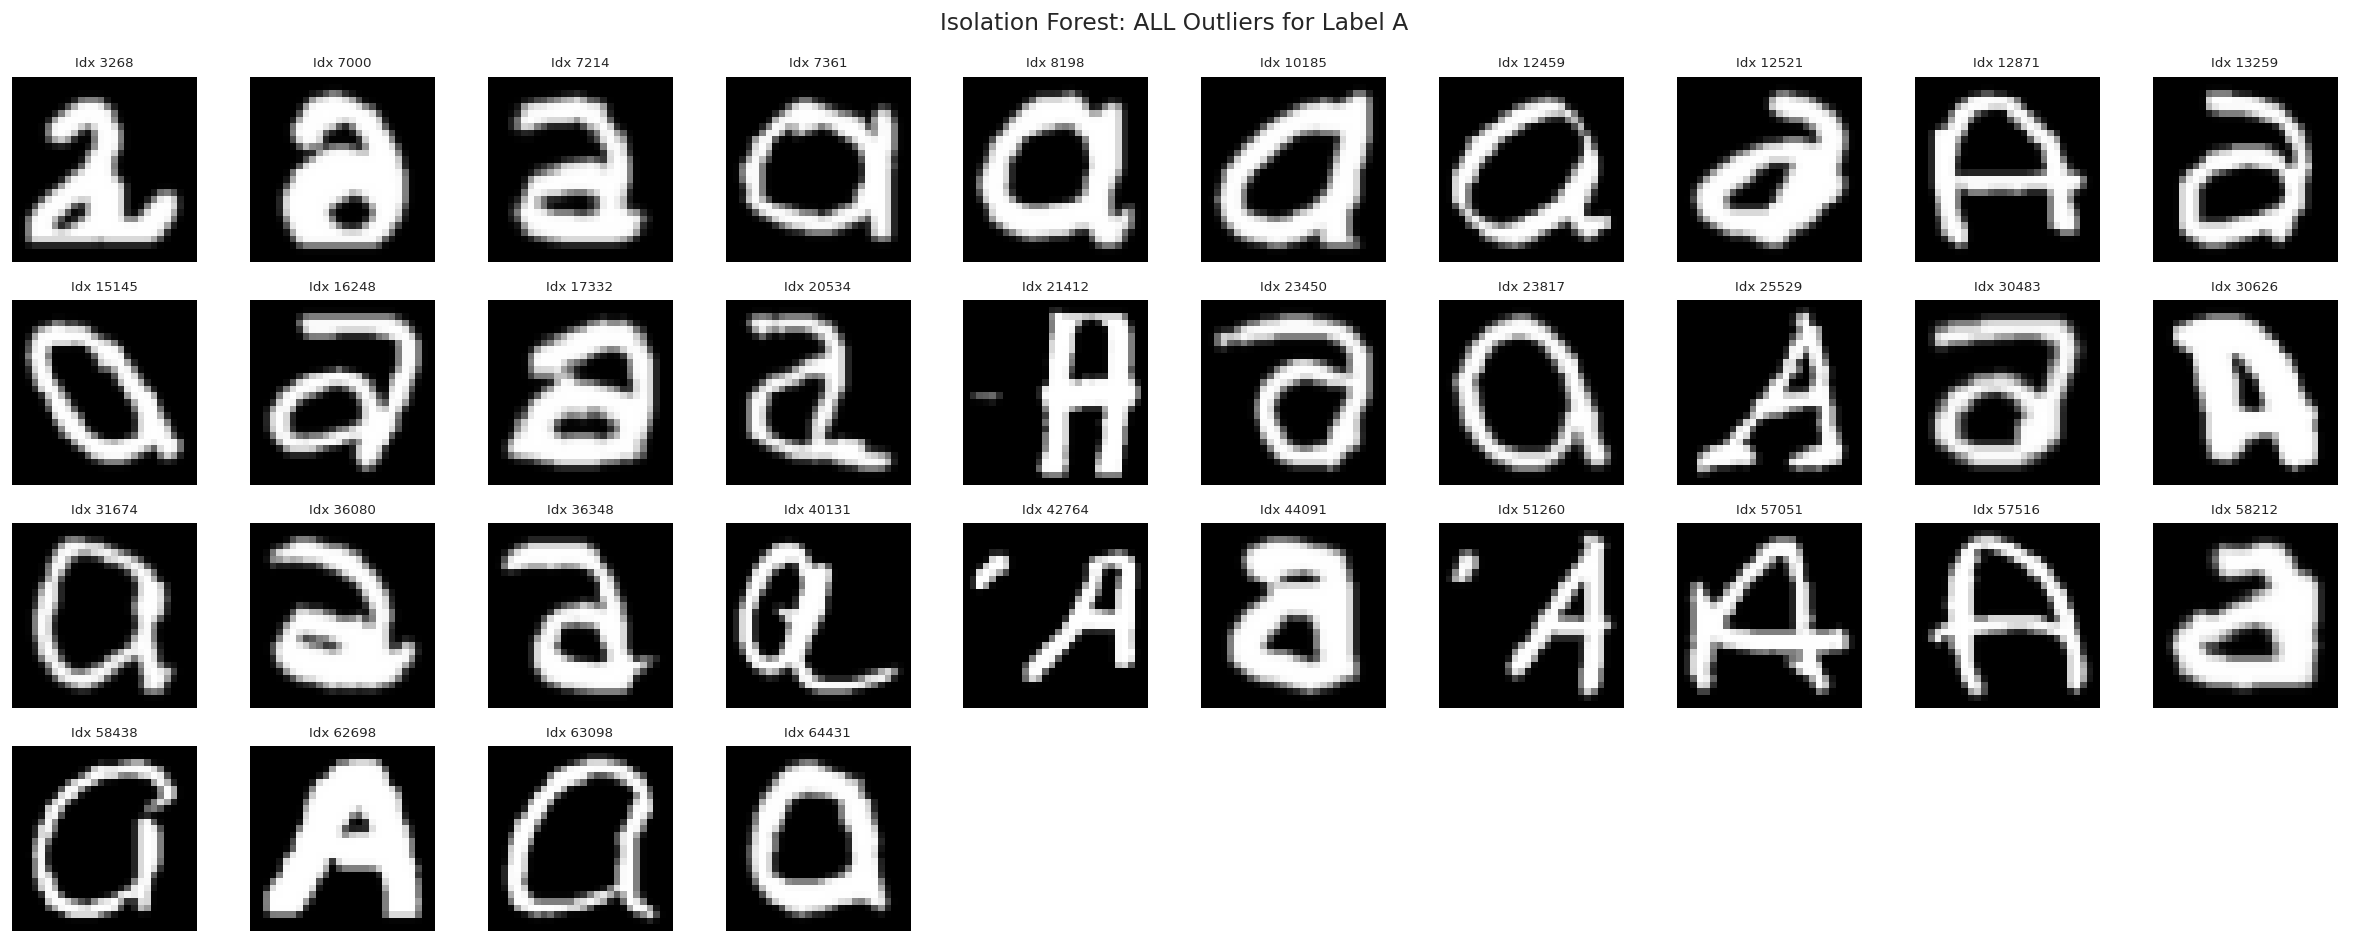

Label B: Found 34 outliers out of 3396 samples.


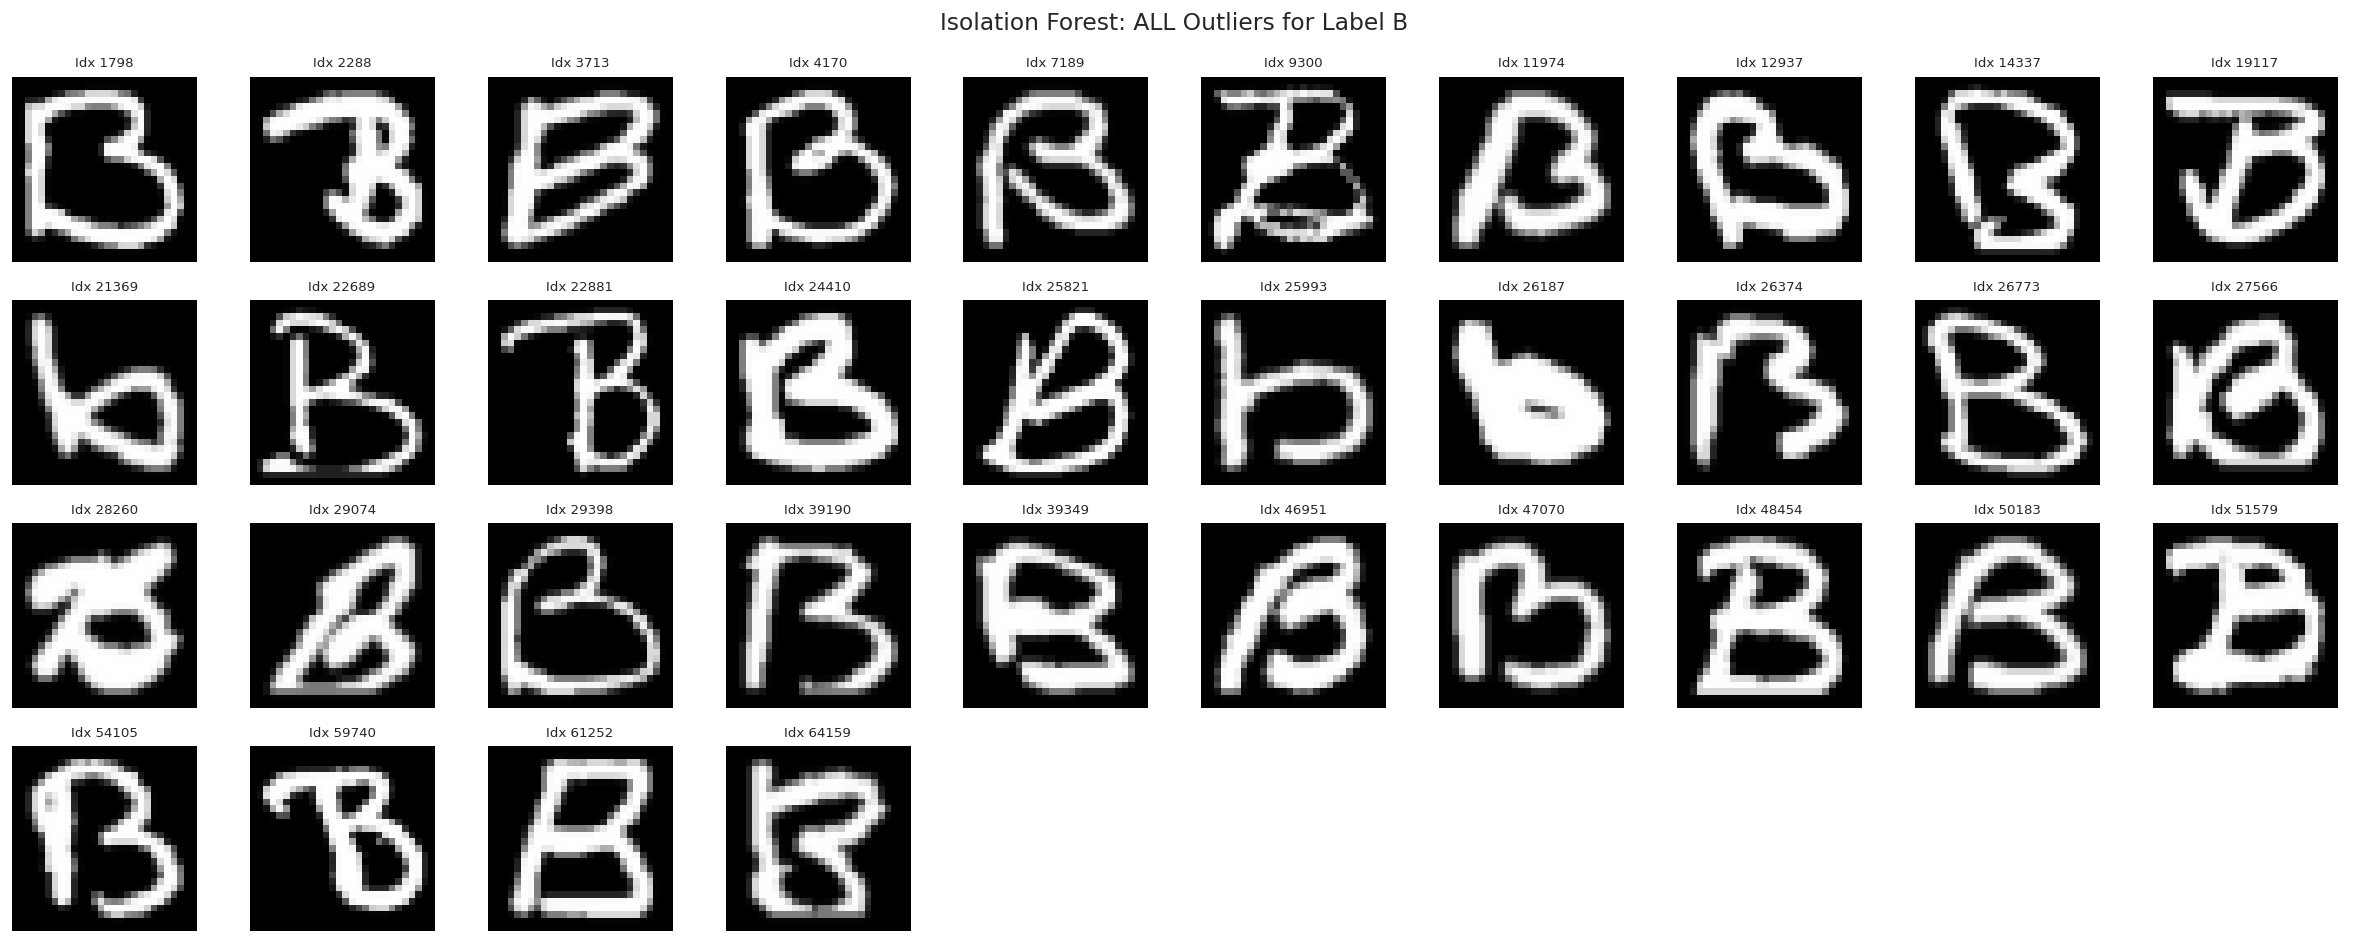

Label D: Found 34 outliers out of 3398 samples.


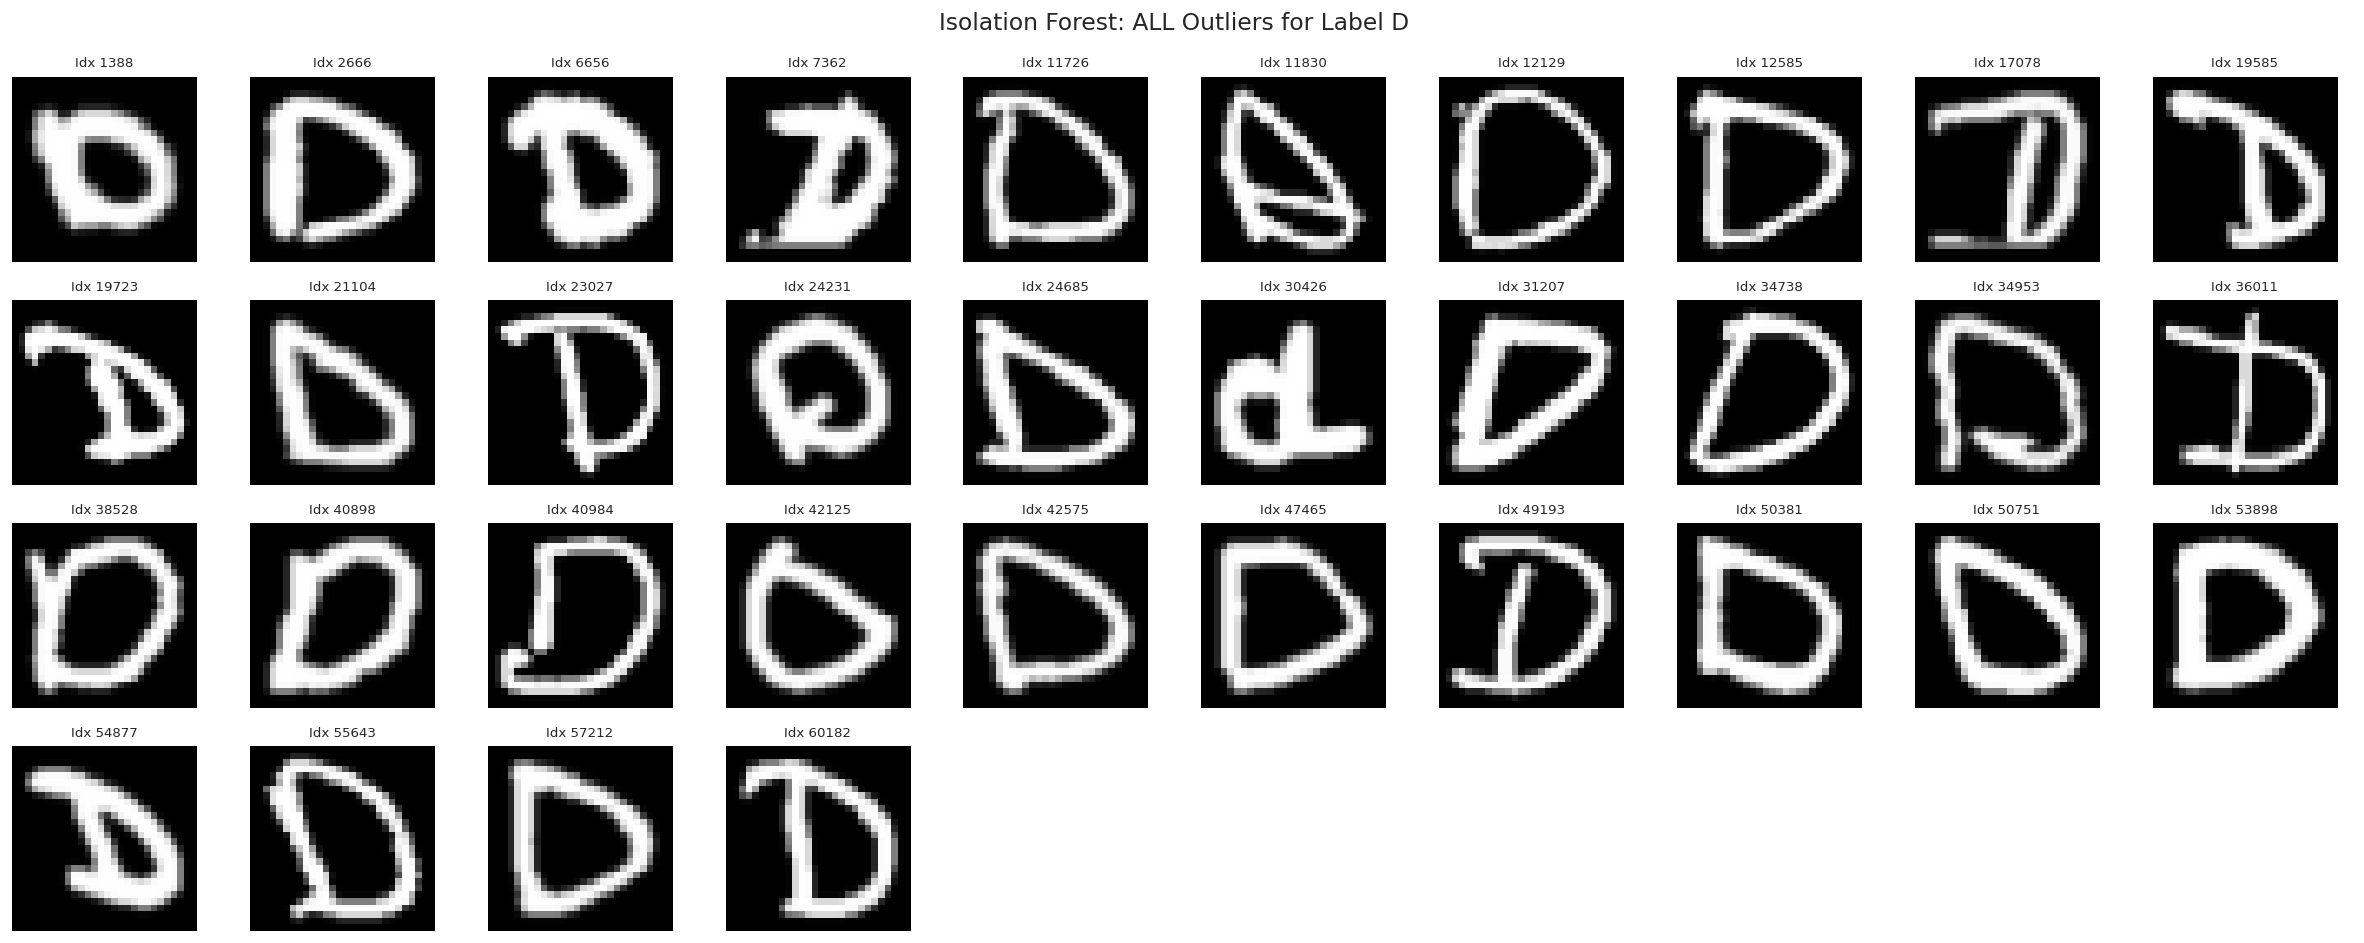

Label E: Found 35 outliers out of 3437 samples.


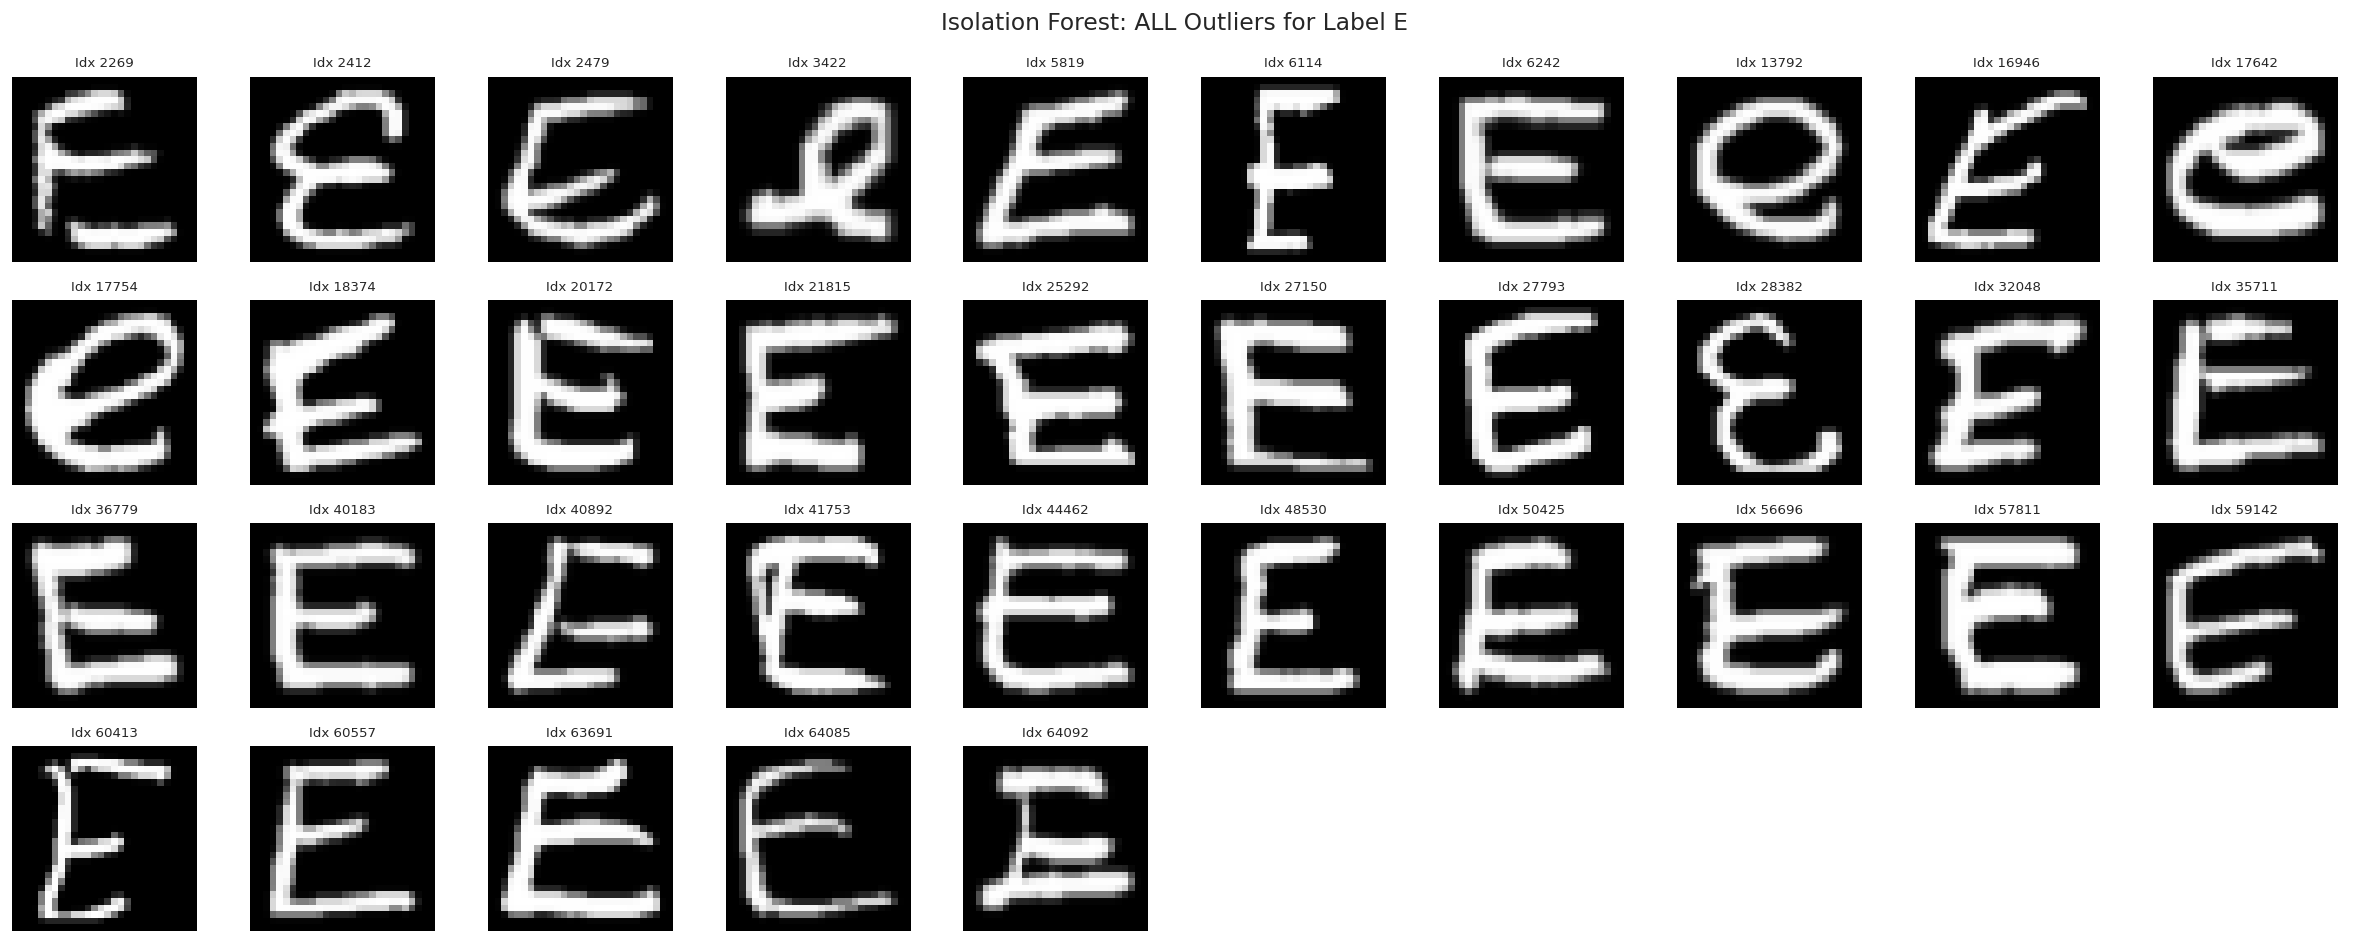

Label F: Found 34 outliers out of 3394 samples.


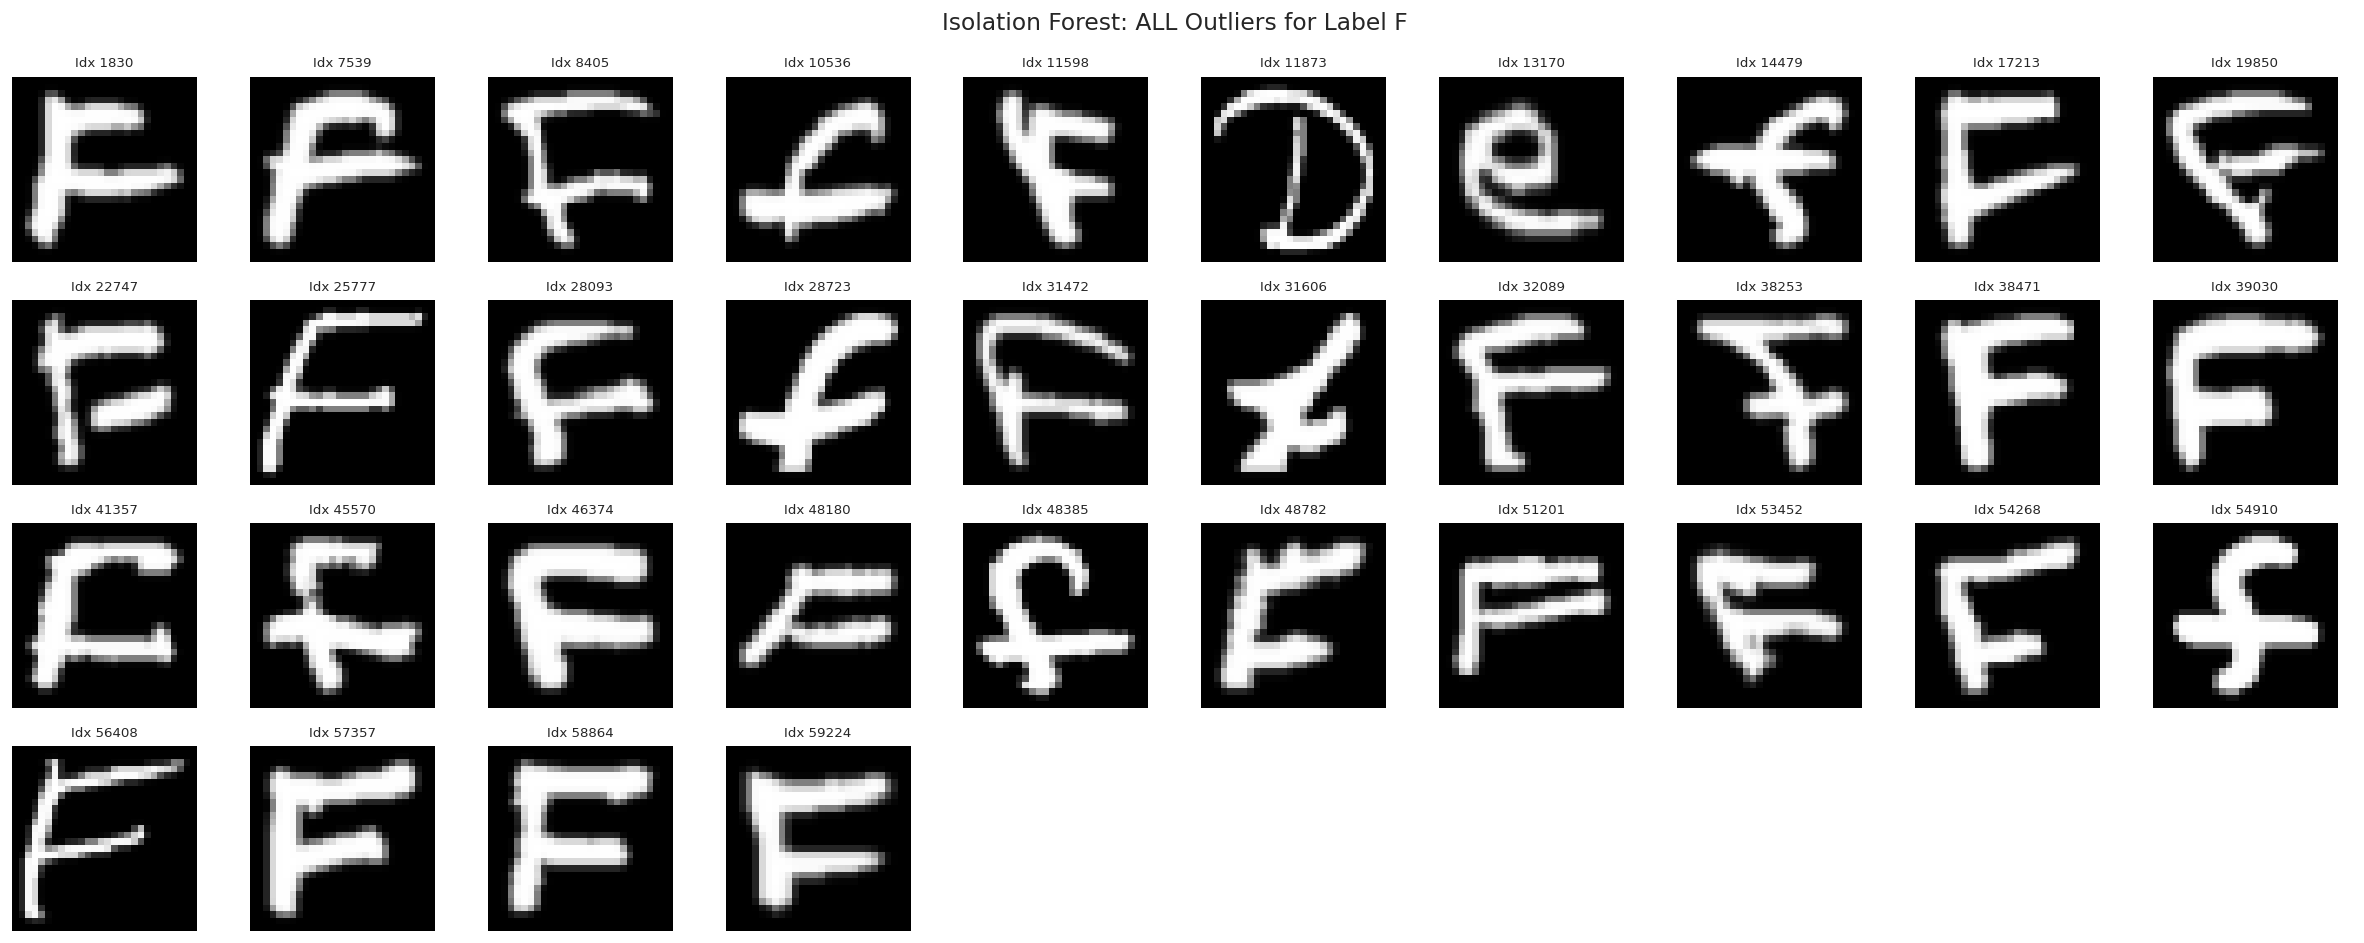

Label G: Found 34 outliers out of 3385 samples.


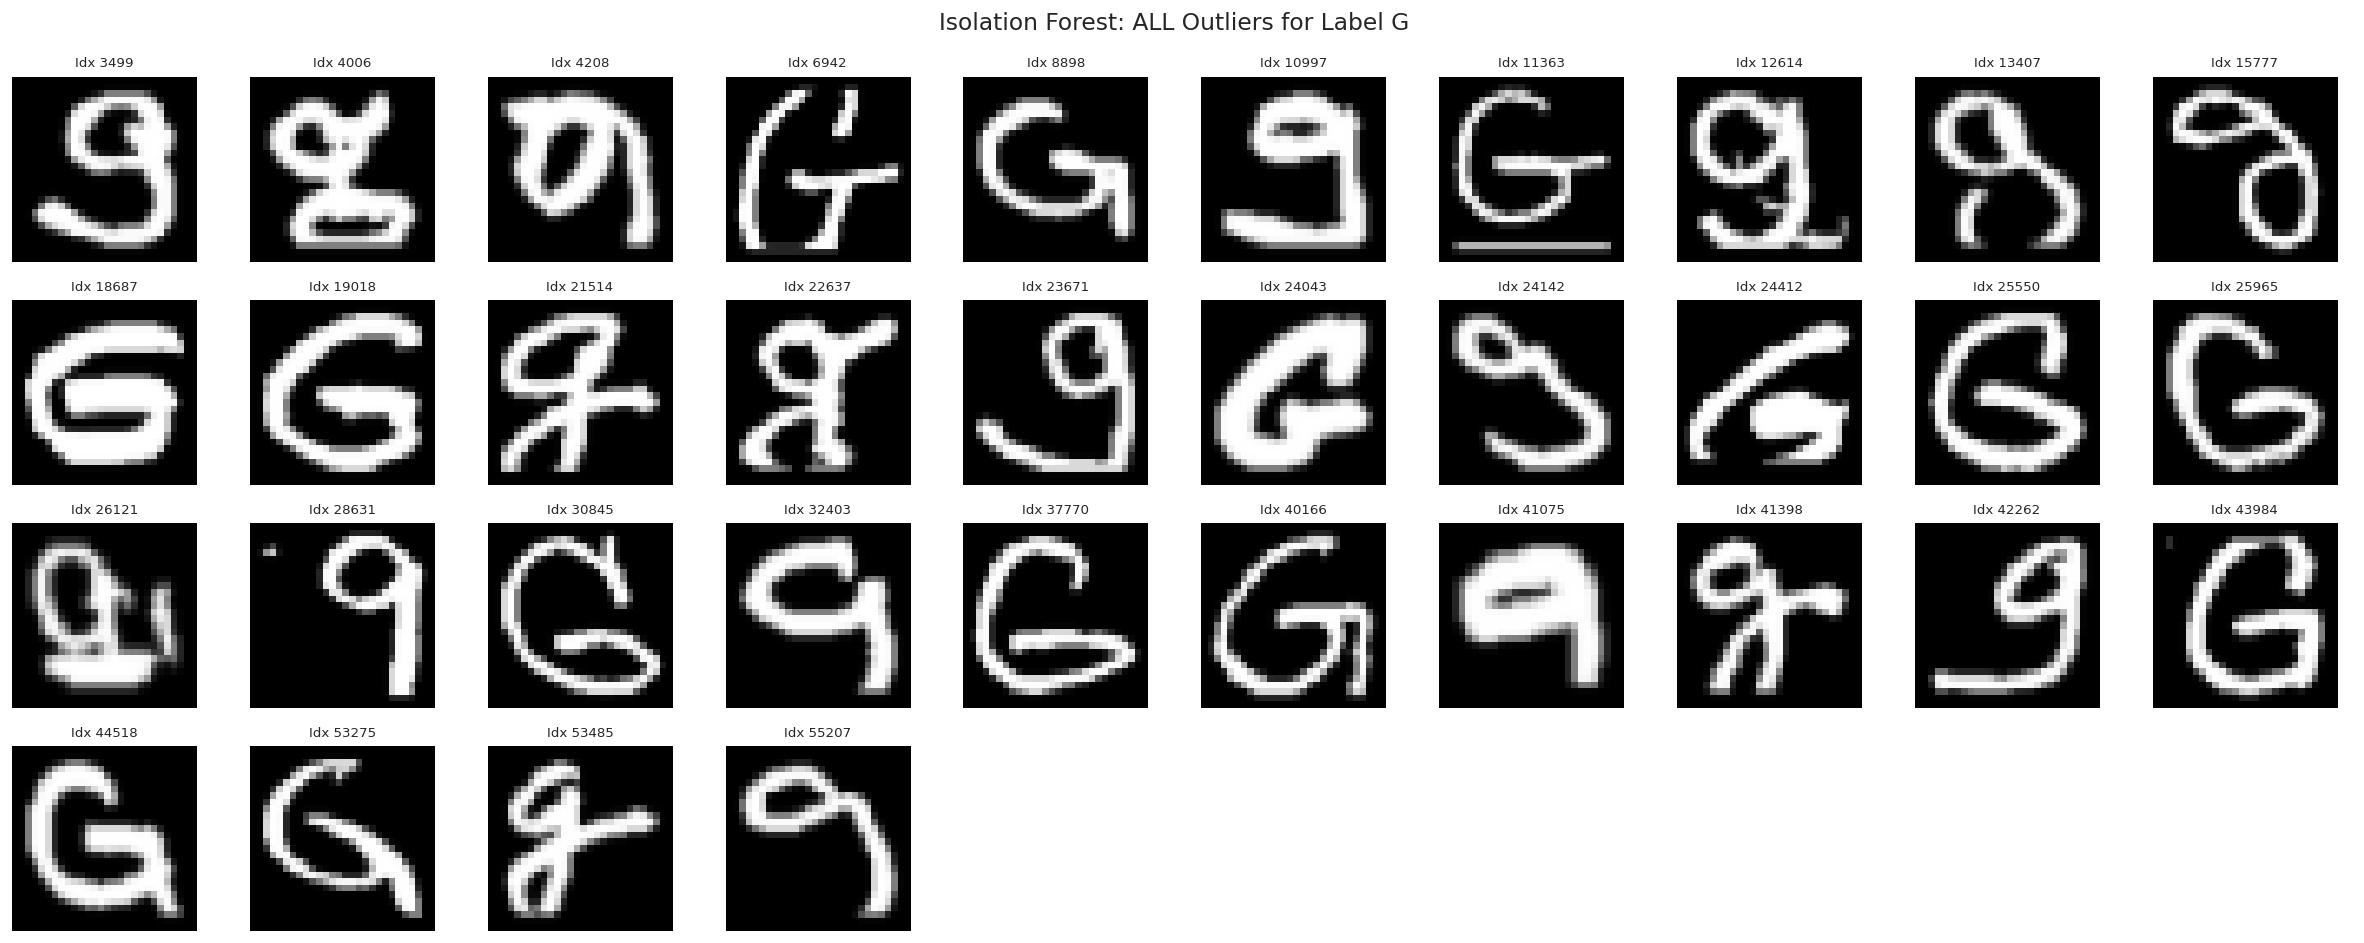

Label I: Found 35 outliers out of 3428 samples.


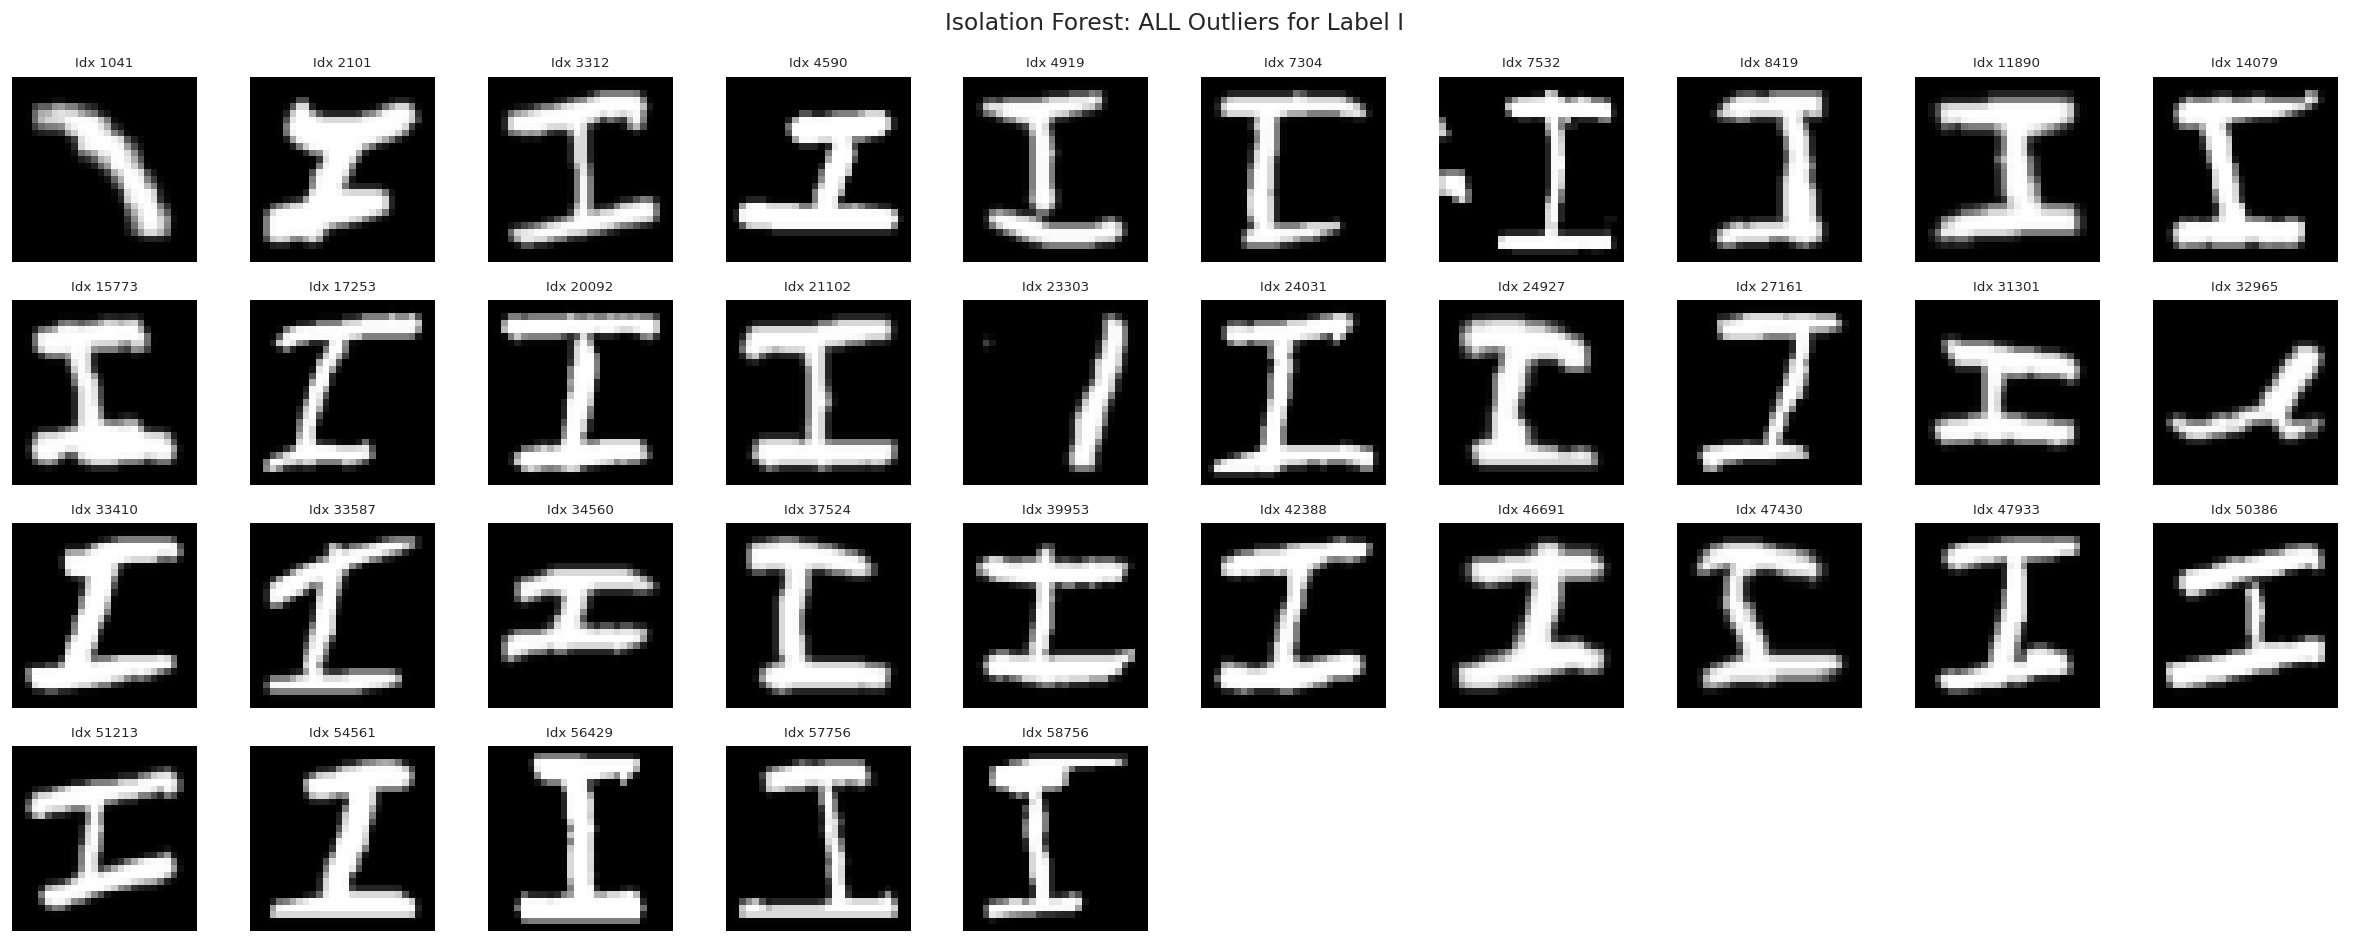

Label J: Found 35 outliers out of 3402 samples.


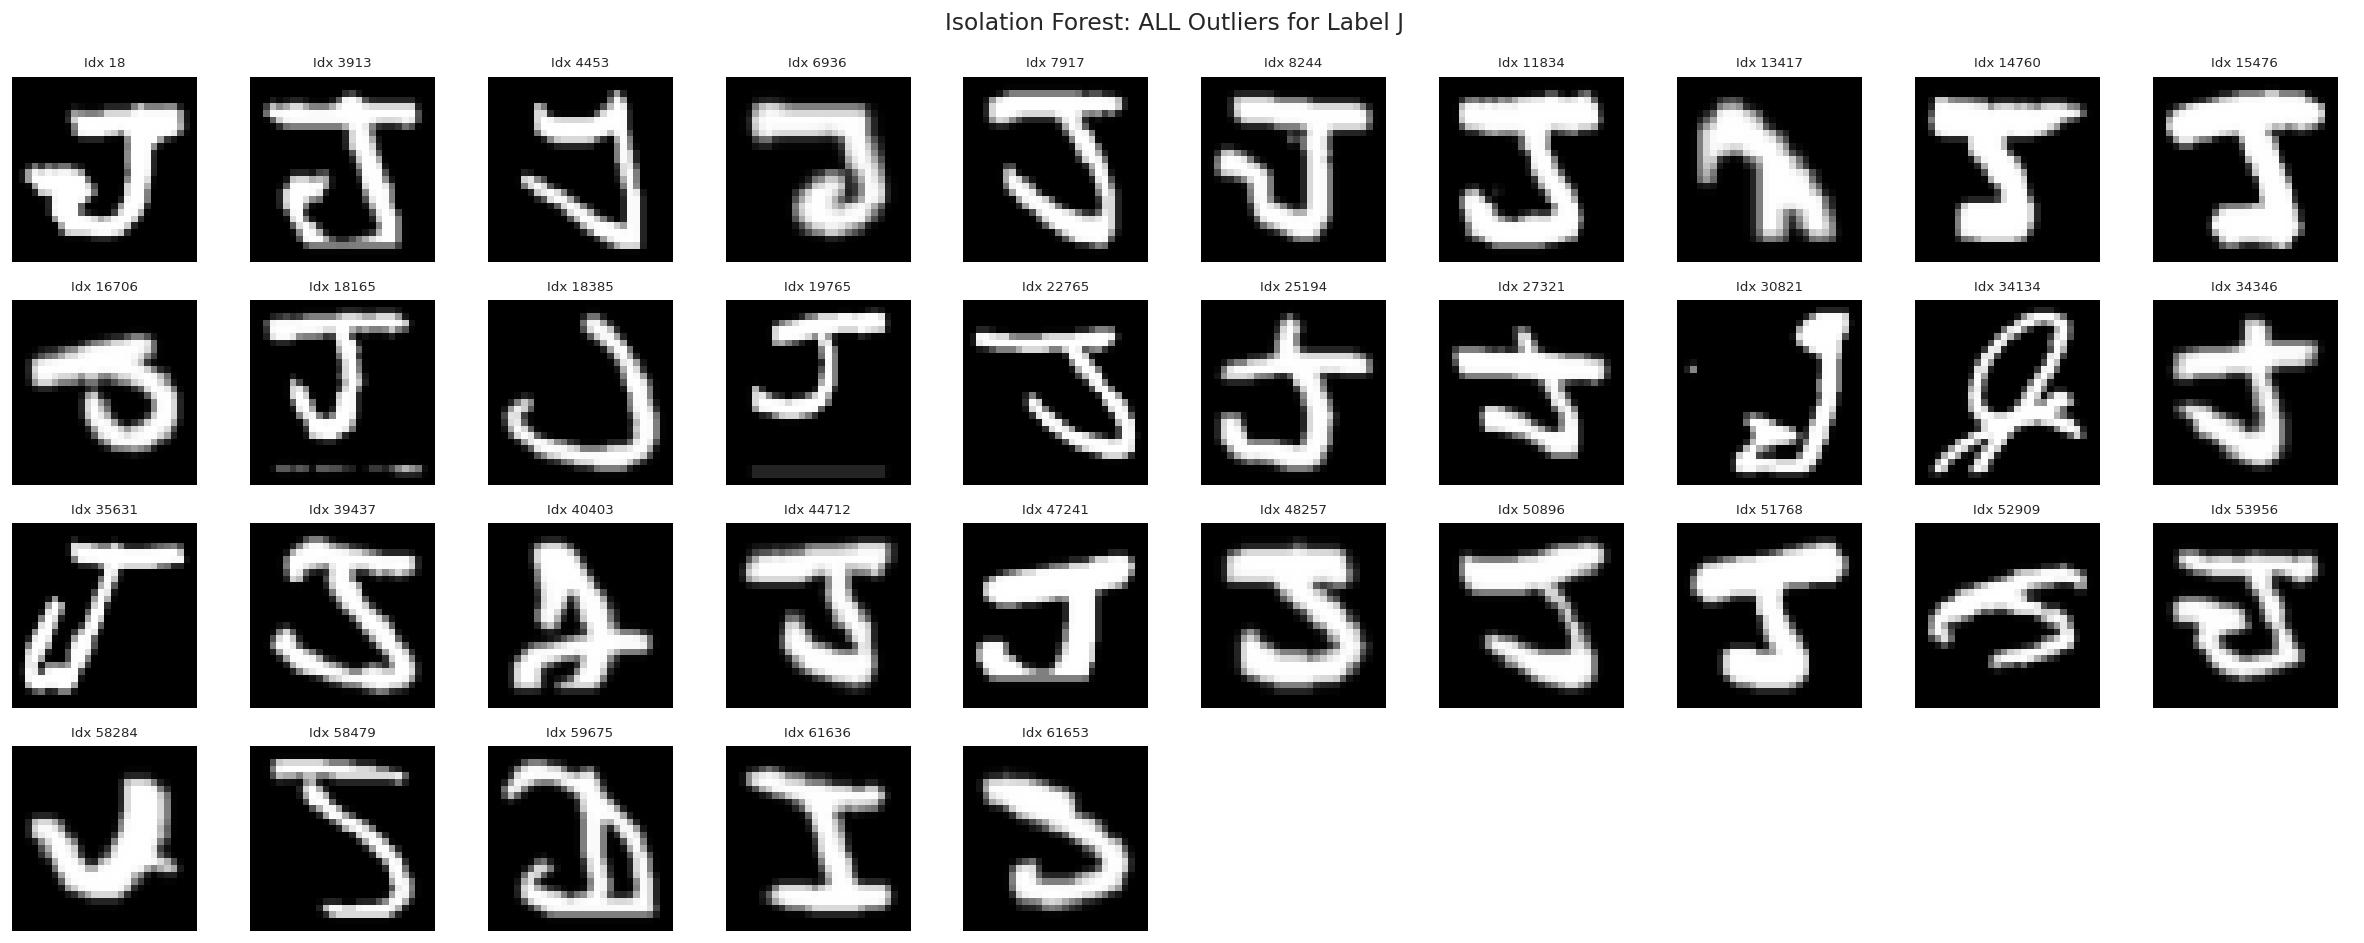

Label L: Found 35 outliers out of 3415 samples.


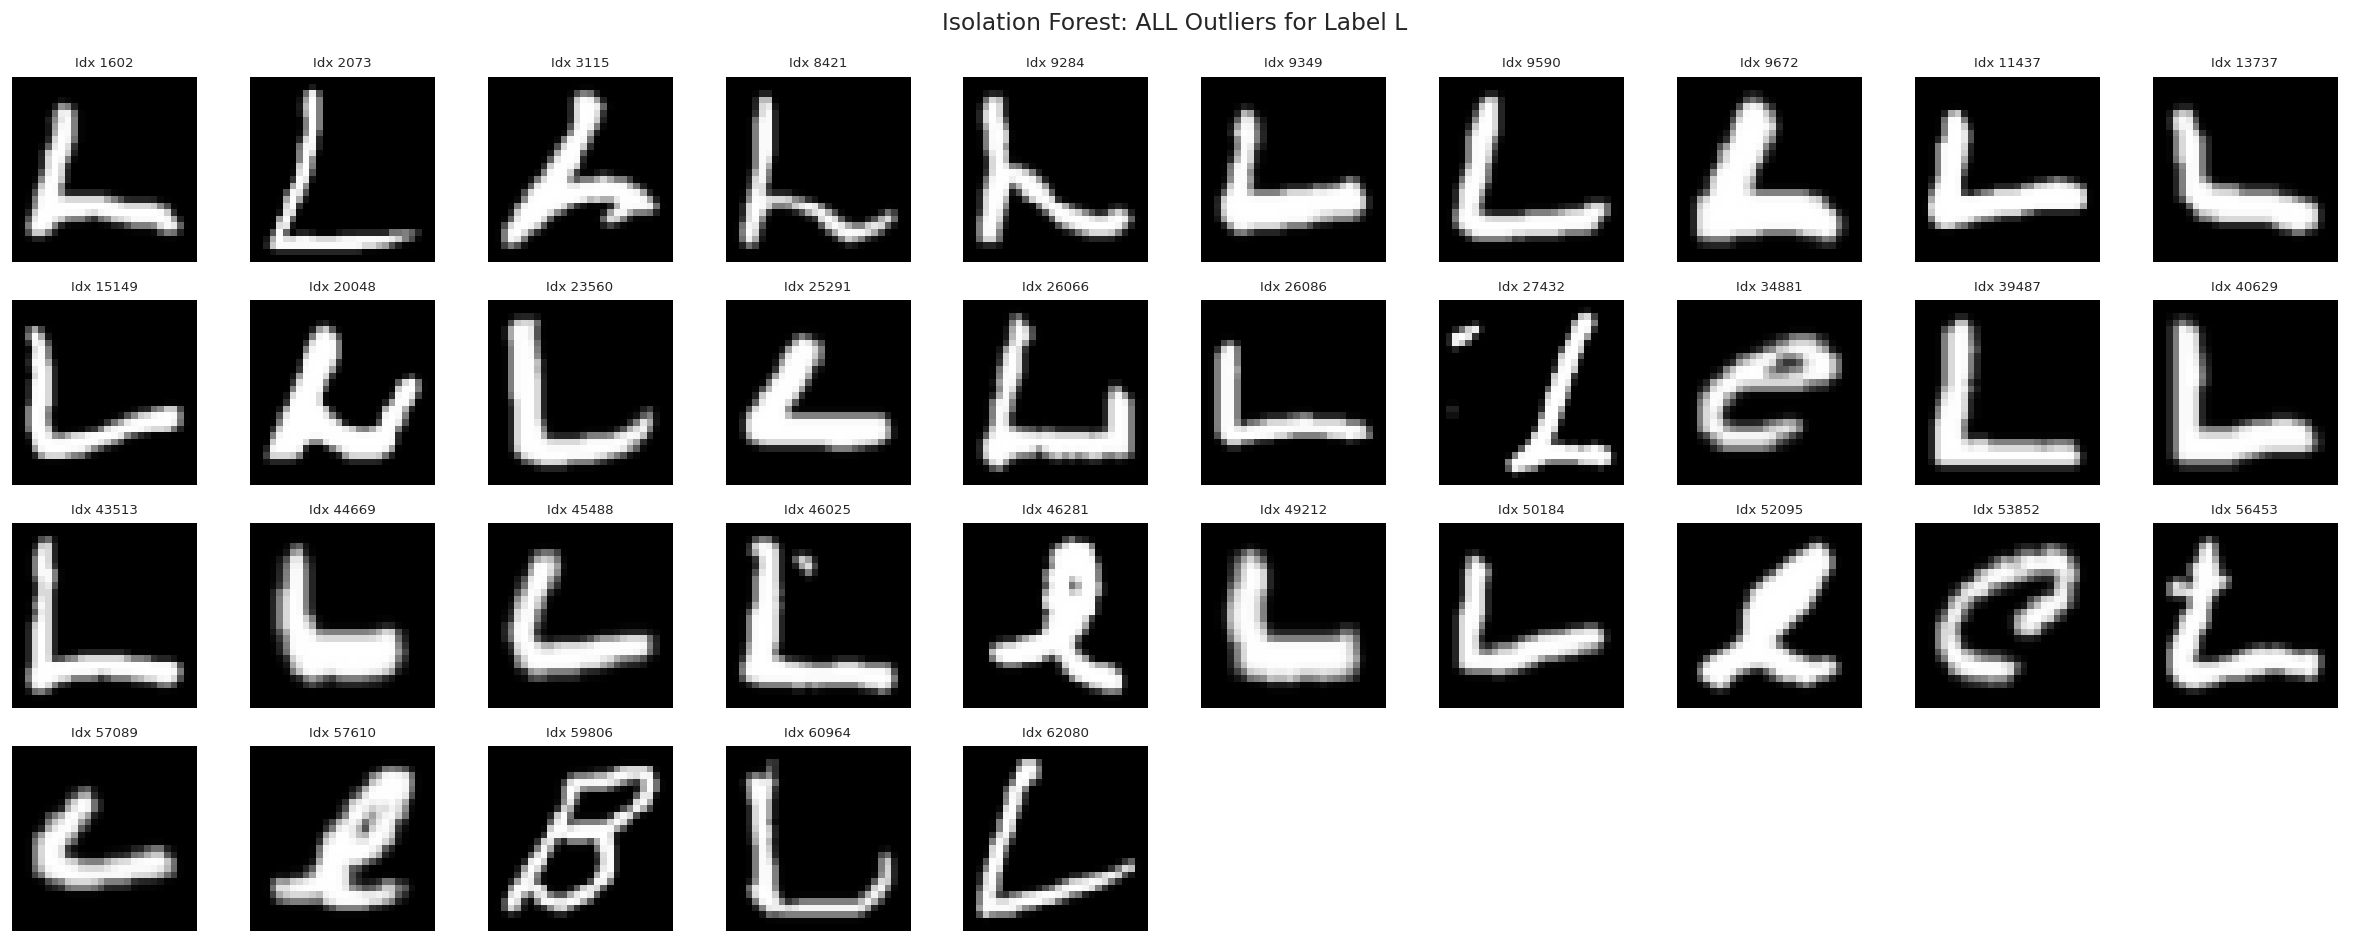

Label N: Found 34 outliers out of 3365 samples.


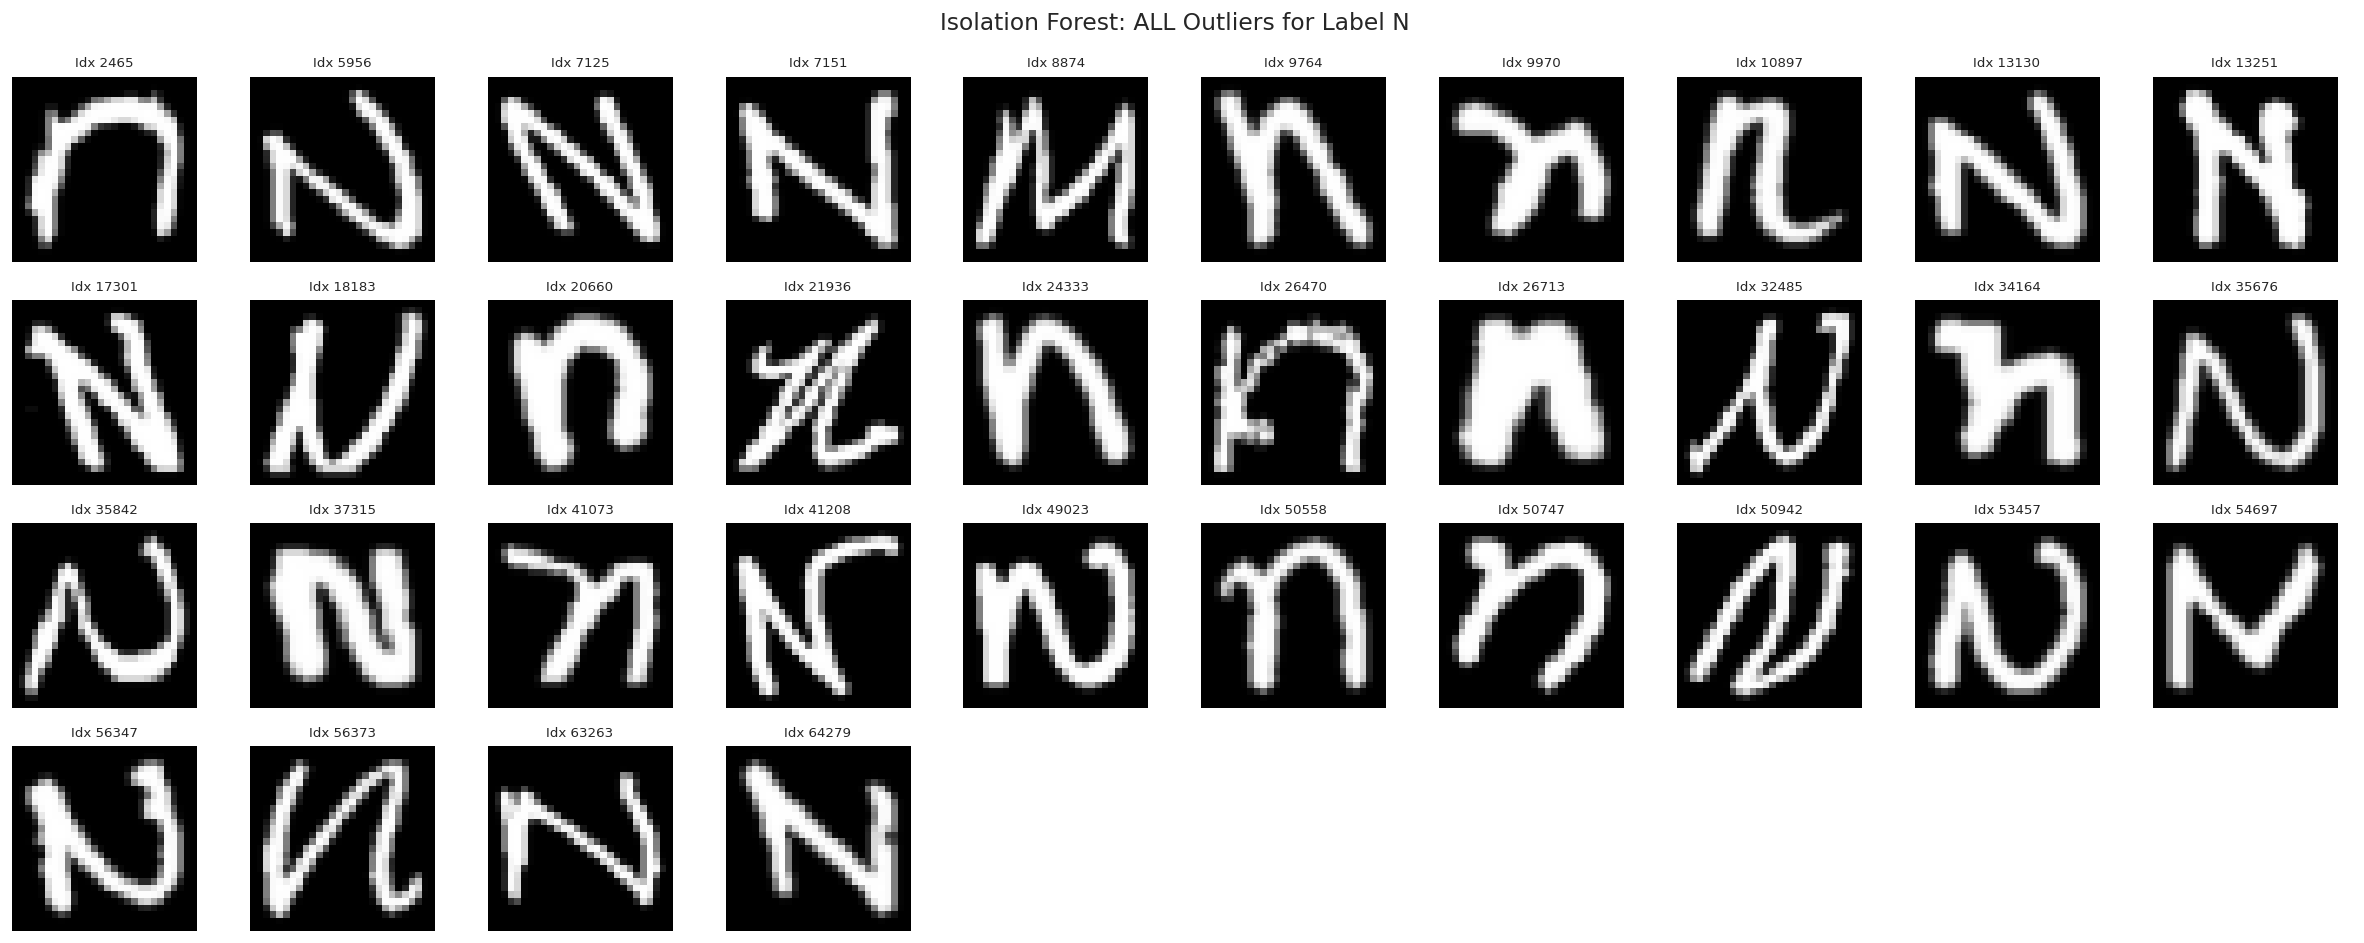

Label O: Found 35 outliers out of 3408 samples.


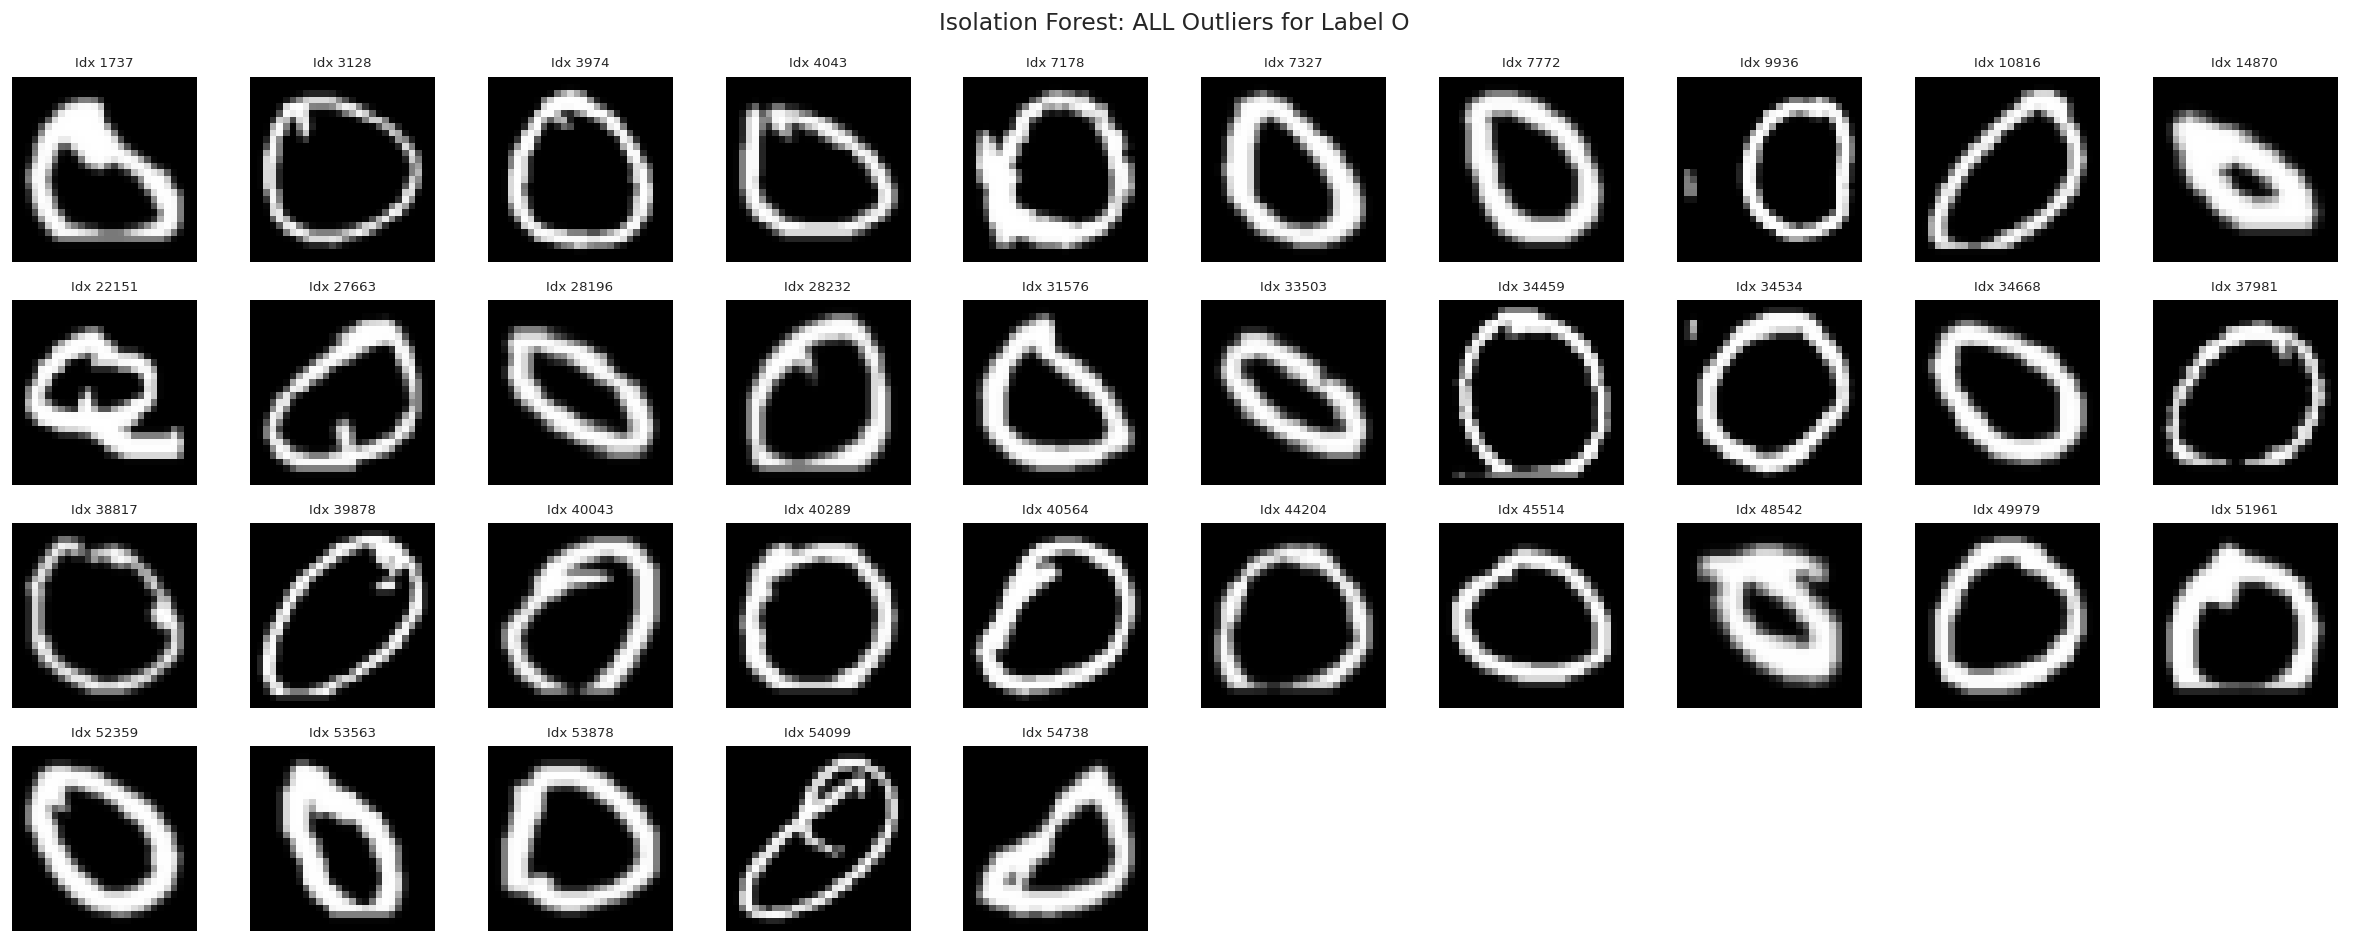

Label P: Found 35 outliers out of 3430 samples.


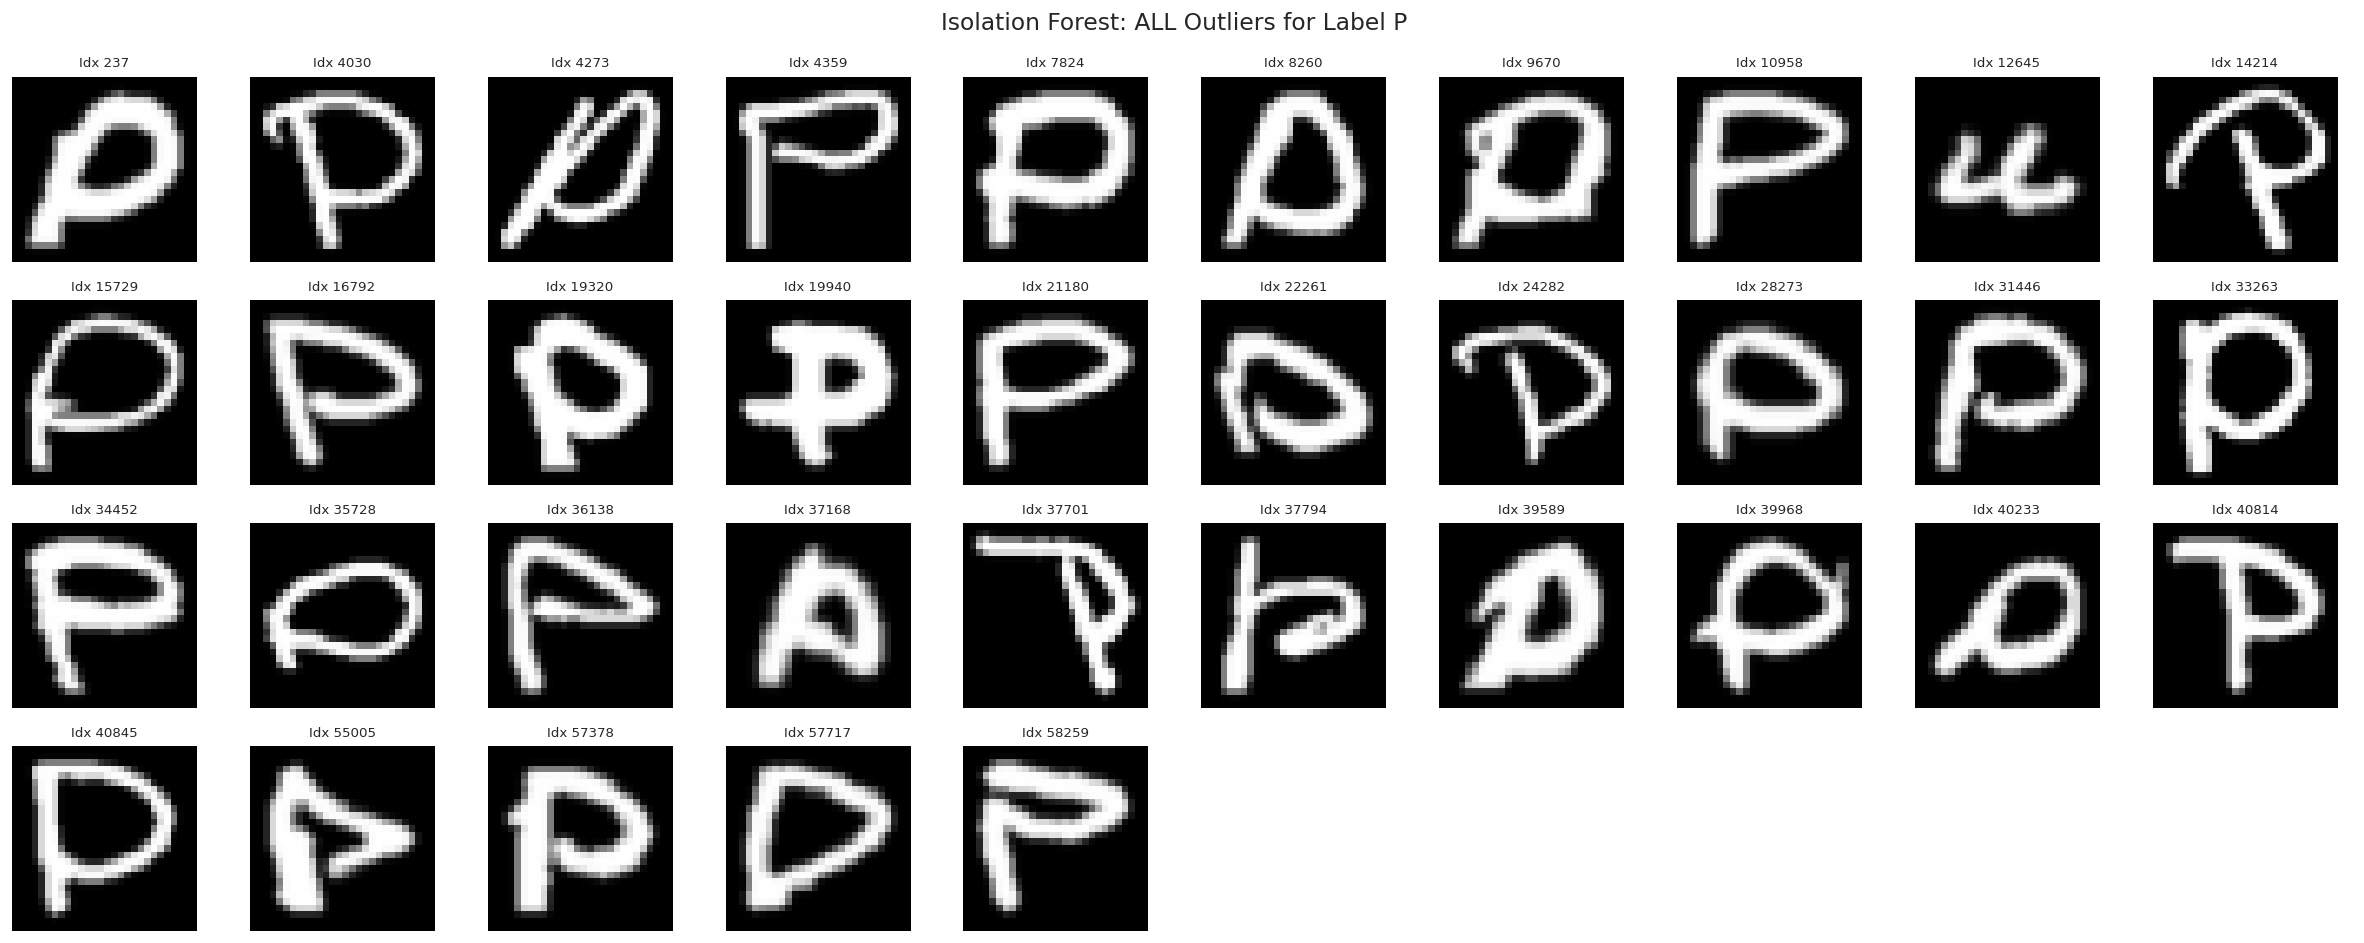

Label Q: Found 35 outliers out of 3435 samples.


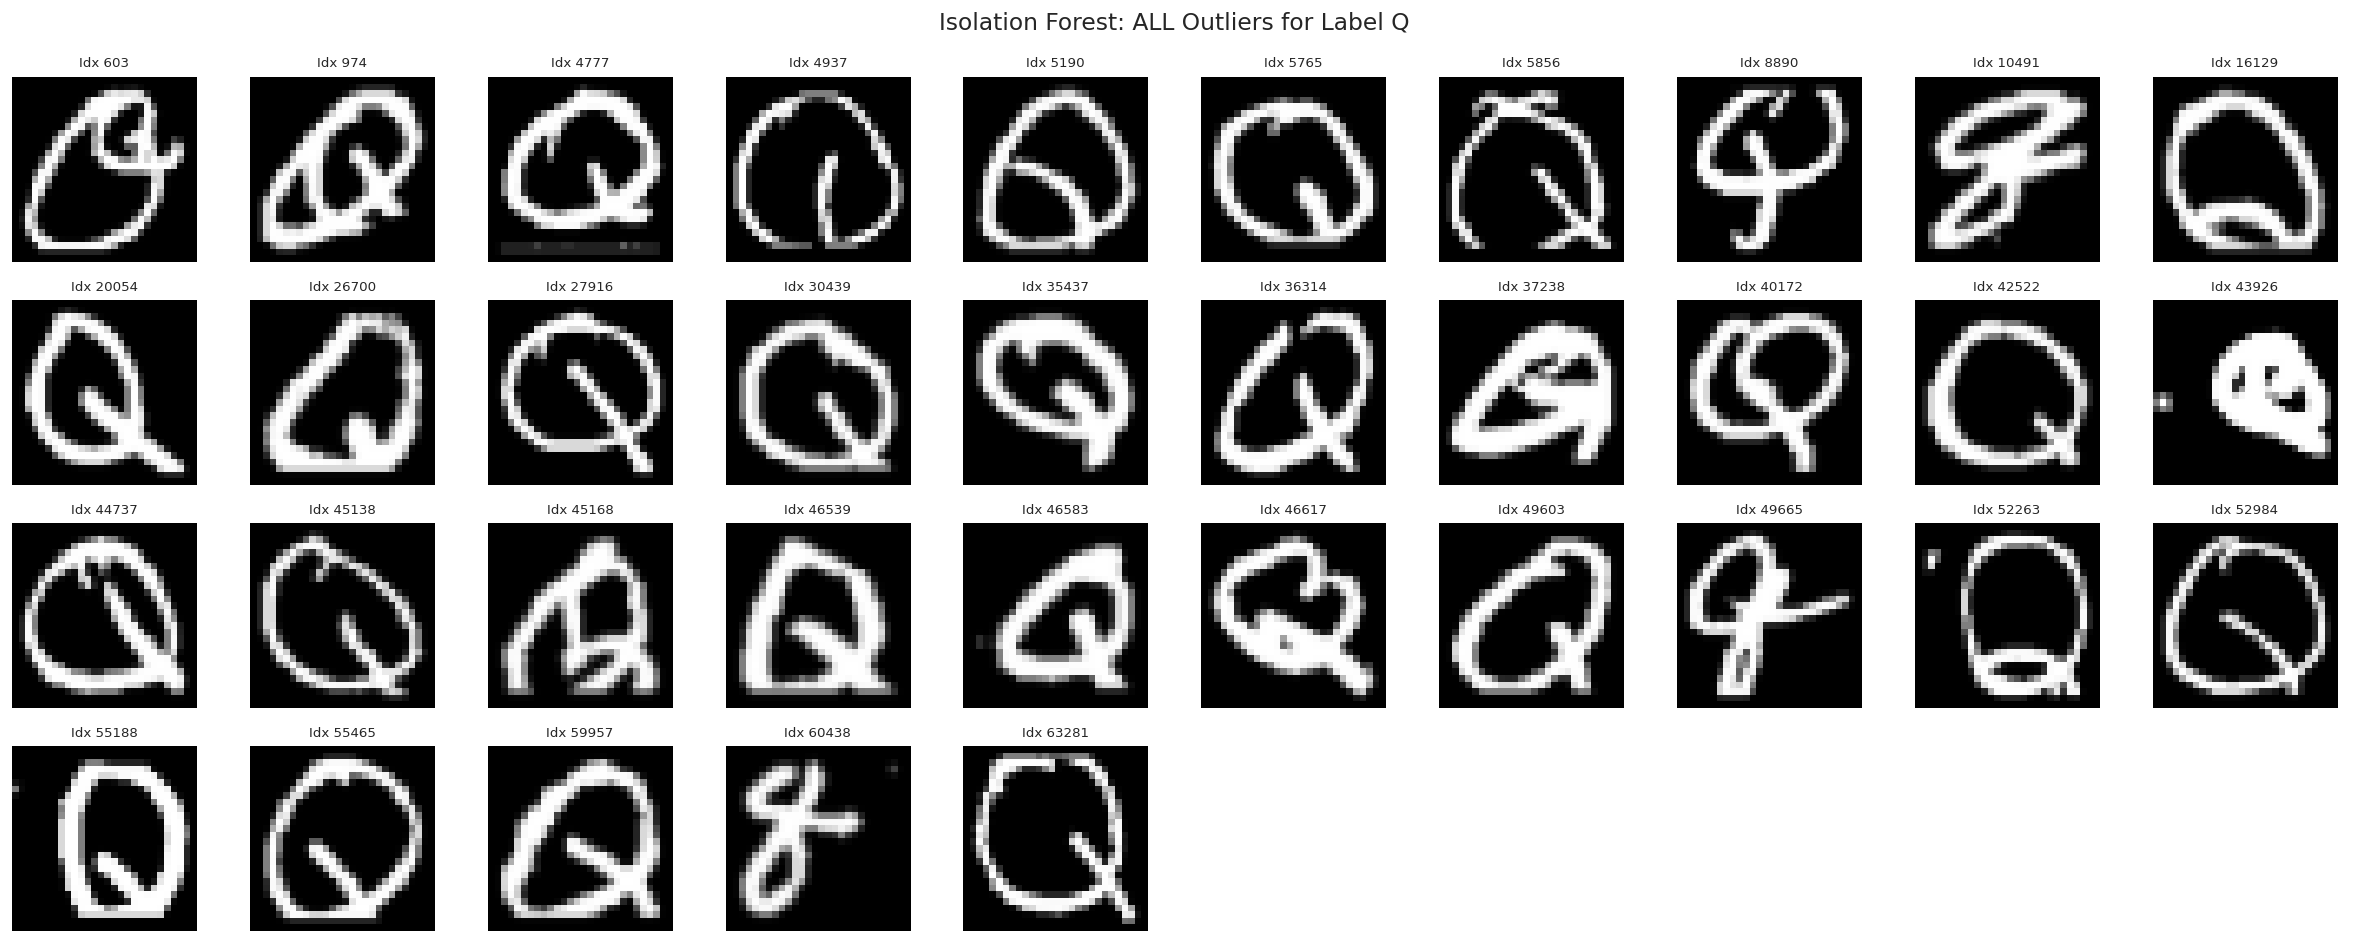

Label T: Found 35 outliers out of 3436 samples.


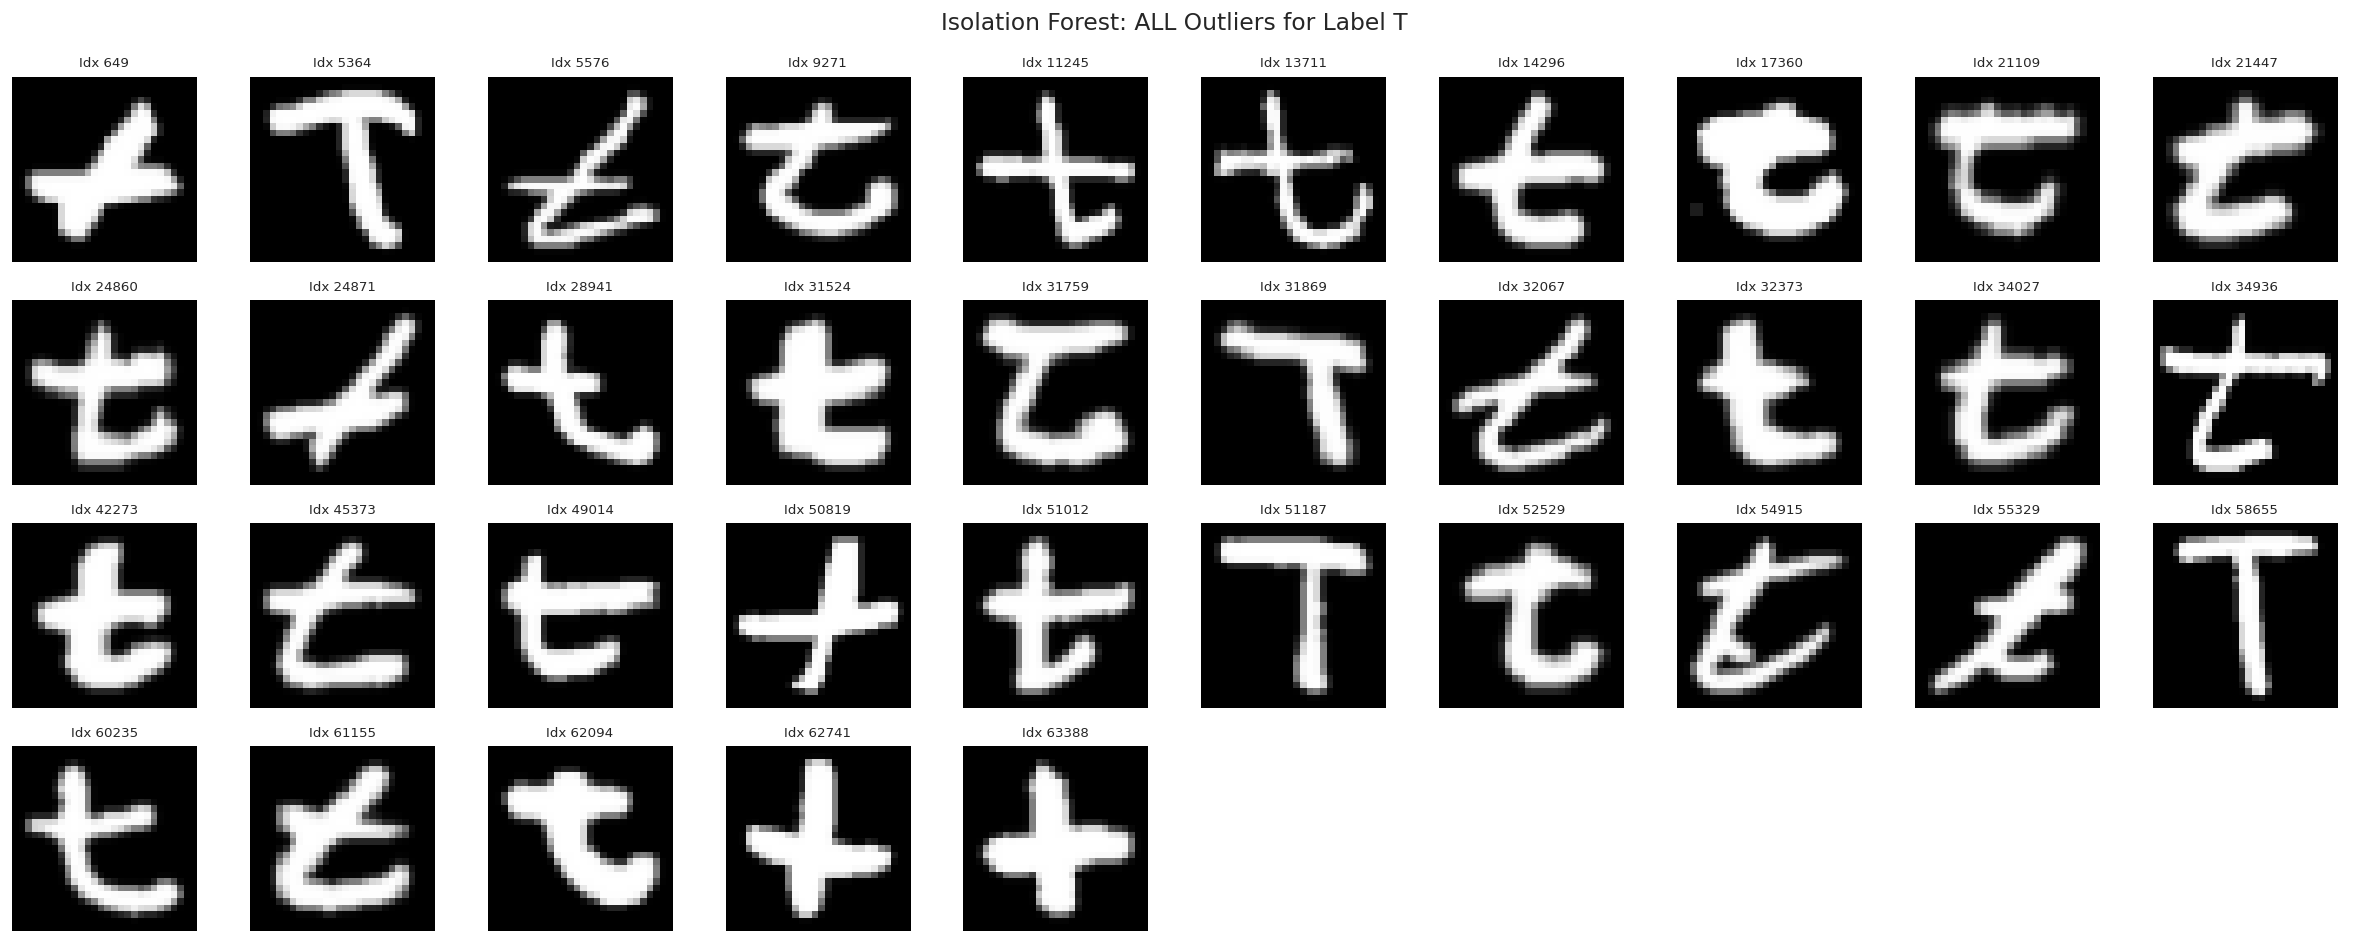

Label X: Found 35 outliers out of 3437 samples.


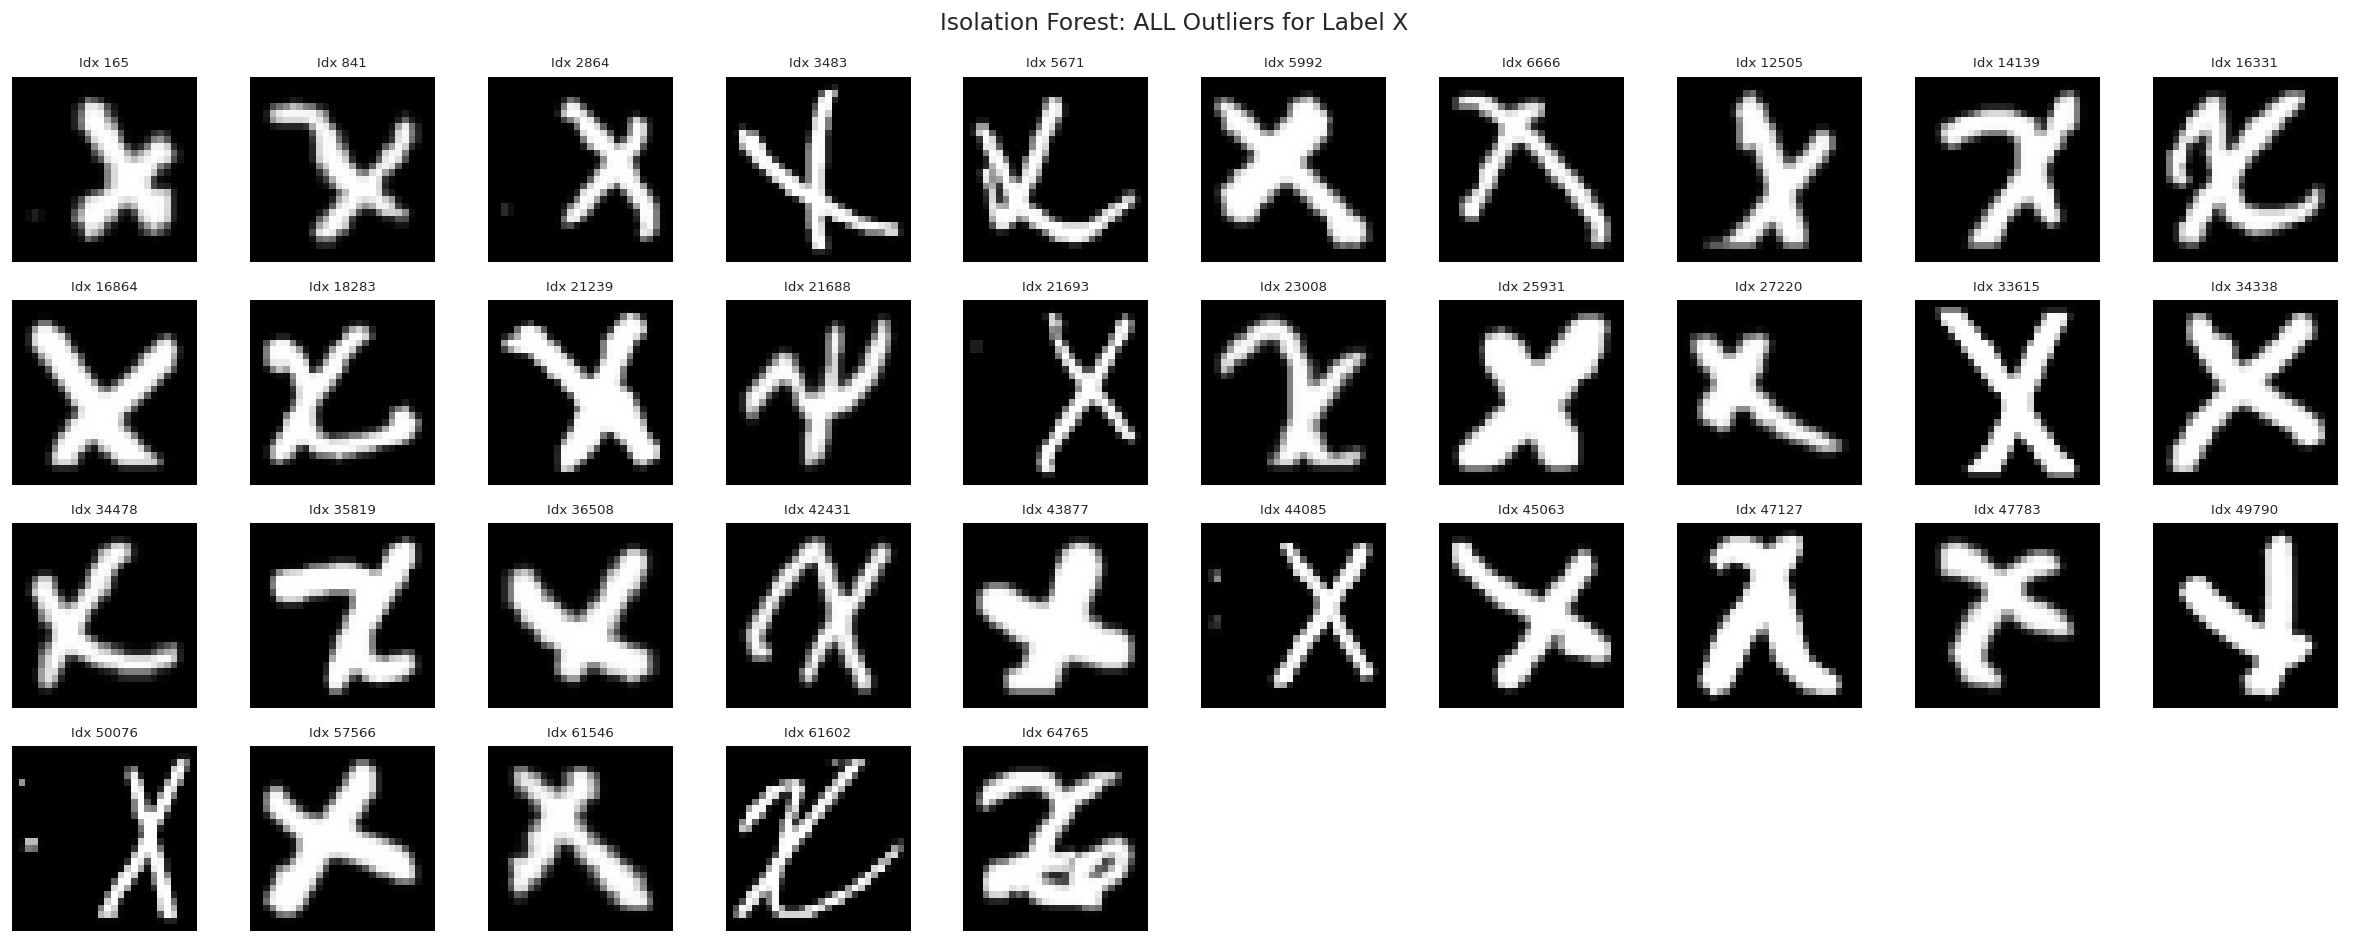

Label Z: Found 35 outliers out of 3427 samples.


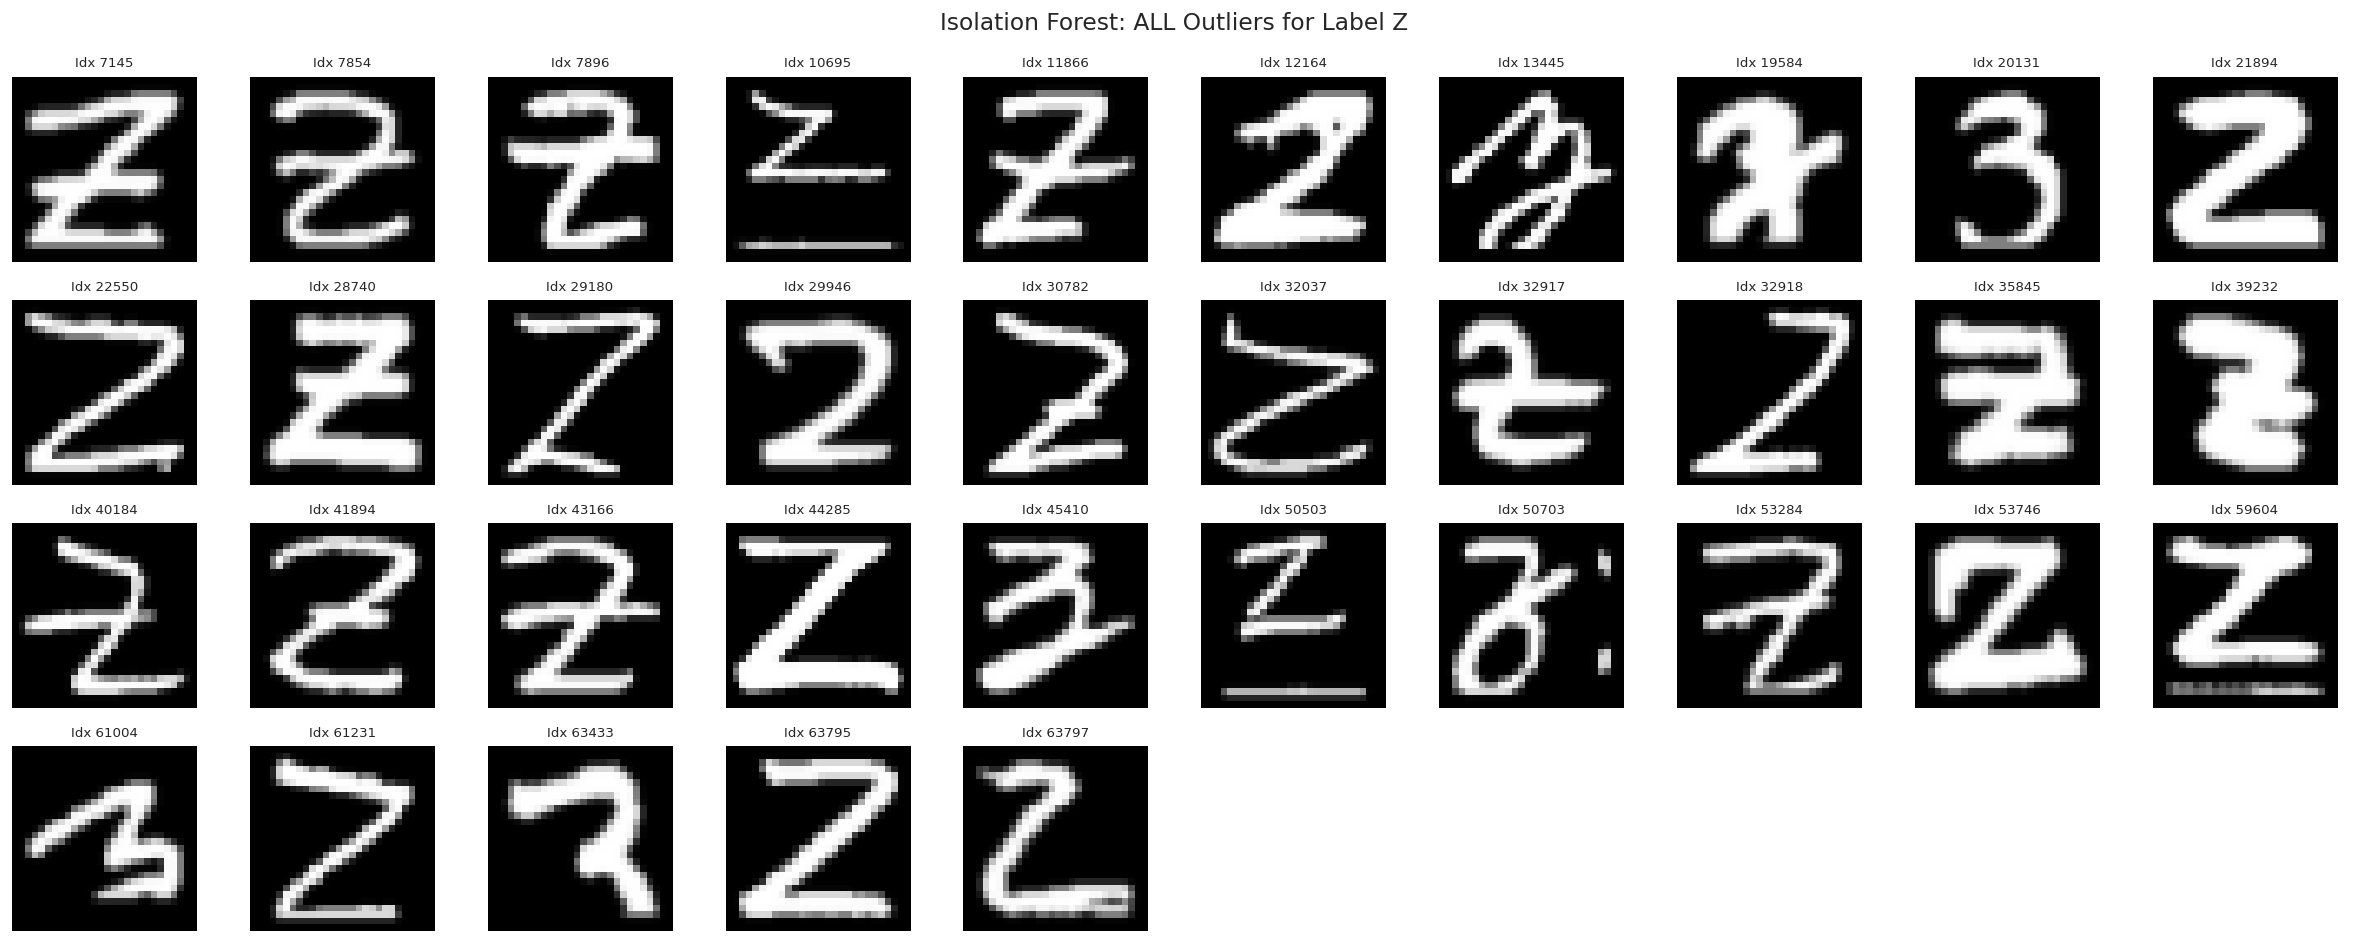


Total Isolation Forest outliers: 554


In [14]:

# Function to find ALL outliers and visualize them
def find_and_visualize_all_outliers_iso(data, pixel_columns, contamination=0.01, max_per_row=10):
    outlier_indices_by_label = {}
    labels = sorted(data['label'].unique())

    print(f"=== ISOLATION FOREST: FINDING AND VISUALIZING ALL OUTLIERS ===")

    for label in labels:
        subset = data[data['label'] == label]
        X = subset[pixel_columns].values.astype(np.float32)

        # Use IsolationForest to detect outliers
        iso = IsolationForest(contamination=contamination, random_state=42)
        preds = iso.fit_predict(X)
        outlier_mask = preds == -1
        outlier_indices = subset.index[outlier_mask].tolist()
        outlier_indices_by_label[label] = outlier_indices

        print(f"Label {label}: Found {len(outlier_indices)} outliers out of {len(subset)} samples.")

        # Visualize ALL outliers for this label
        if len(outlier_indices) > 0:
            outlier_data = subset.loc[outlier_indices]

            # Calculate grid dimensions
            n_outliers = len(outlier_data)
            n_rows = (n_outliers + max_per_row - 1) // max_per_row
            n_cols = min(max_per_row, n_outliers)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))

            # Handle single row/column cases
            if n_rows == 1 and n_cols == 1:
                axes = [axes]
            elif n_rows == 1:
                axes = axes.reshape(1, -1)
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)

            # Plot each outlier
            for i, (_, row) in enumerate(outlier_data.iterrows()):
                row_idx = i // max_per_row
                col_idx = i % max_per_row

                img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)

                if n_rows == 1:
                    ax = axes[col_idx]
                else:
                    ax = axes[row_idx, col_idx]

                ax.imshow(img, cmap='gray')
                ax.set_title(f"Idx {row.name}", fontsize=8)
                ax.axis('off')

            # Hide unused subplots
            total_subplots = n_rows * n_cols
            for i in range(n_outliers, total_subplots):
                row_idx = i // max_per_row
                col_idx = i % max_per_row
                if n_rows == 1:
                    axes[col_idx].axis('off')
                else:
                    axes[row_idx, col_idx].axis('off')

            plt.suptitle(f"Isolation Forest: ALL Outliers for Label {label}", fontsize=14)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No outliers to visualize for label {label}")

    return outlier_indices_by_label

# Run outlier detection and visualize ALL outliers
iso_outlier_indices = find_and_visualize_all_outliers_iso(rotated_data, pixel_columns, contamination=0.01)

# Print summary
total_iso_outliers = sum(len(indices) for indices in iso_outlier_indices.values())
print(f"\nTotal Isolation Forest outliers: {total_iso_outliers}")

From visual inspection, we will remove the images, that are too noisy, and move some to correct class.

In [19]:
# Function to remove outliers and update class labels
def process_outliers(data, outliers_to_remove, updates_to_classes):
    """
    Removes specified rows (outliers) and updates labels of specific rows.

    Args:
        data (pd.DataFrame): The dataset to process.
        outliers_to_remove (list): List of indices to remove from the dataset.
        updates_to_classes (dict): Dictionary mapping indices to new class labels.

    Returns:
        pd.DataFrame: The processed dataset.
    """
    print(f"Original dataset shape: {data.shape}")

    # Remove specified outlier rows
    print(f"Removing {len(outliers_to_remove)} rows...")
    data = data.drop(index=outliers_to_remove, errors='ignore')
    print(f"Dataset shape after removal: {data.shape}")

    # Update specified rows to new class labels
    print(f"Updating {len(updates_to_classes)} rows to new labels...")
    for idx, new_label in updates_to_classes.items():
        if idx in data.index:
            data.at[idx, 'label'] = new_label
    print("Label updates completed.")

    return data

# Outliers to remove
outliers_to_remove = [
    5362, 8105, 32140, 30073, 40199, 40364, 49327, 54408, 54665, 56188, 60695, 2424, 3568, 59481, 43186, 48902, 256,
    4249, 6879, 9001, 17046, 32857, 29673, 26107, 35297, 40375, 41278, 44397, 47035, 50432, 50702, 55808, 64400, 18220,
    47810, 51376, 1266, 1647, 13929, 18368, 18411, 21182, 36521, 46041, 52252, 57499, 12751, 3268, 15145, 30626, 44091,
    58212, 9300, 19117, 26187, 26374, 28260, 1388, 11830, 17078, 19585, 19723, 24231, 42125, 3422, 31606, 4208, 6942,
    26121, 41075, 41398, 1041, 32965, 4453, 6936, 13417, 18385, 25194, 27321, 30821, 34134, 34346, 40403, 52909, 58284,
    59675, 61653, 3115, 9284, 20048, 26066, 53852, 8874, 21936, 22151, 54099, 54738, 19940, 22261, 24282, 35728, 37168,
    37701, 37794, 39589, 40233, 57717, 43926, 37338, 17360, 5671, 21688, 64765, 13445, 19584, 20131, 45410, 50703, 61004,
    63433, 12645
]

# Rows to update to new class labels
updates_to_classes = {
    7596: 'A',
    11873: 'D',
    13170: 'E',
    34881: 'E',
    22261: 'O',
    59806: 'B'
}

# Apply the processing function
processed_data = process_outliers(rotated_data, outliers_to_remove, updates_to_classes)

# Summary of changes
print(f"\nProcessed dataset shape: {processed_data.shape}")
print("Changes applied successfully!")

Original dataset shape: (54589, 787)
Removing 121 rows...
Dataset shape after removal: (54468, 787)
Updating 6 rows to new labels...
Label updates completed.

Processed dataset shape: (54468, 787)
Changes applied successfully!


In [22]:
# Reset index after removing outliers
processed_data = processed_data.reset_index(drop=True)
print("Index reset for processed_data.")

Index reset for processed_data.


### Seperating Upper and Lower-case Letters
---

 Why Not Split Uppercase/Lowercase Letters into Separate Classes?

We initially thought that separating uppercase and lowercase letters might help us generate cleaner images.  
However, after careful consideration and discussion, we decided **not** to split them.

 Reasons:
1. **Assignment Requirement**  
   - The marking criteria specifies **16 classes only**.  
   - We have already identified the remaining 16 classes after data cleaning.  
   - Splitting upper/lower would result in **more than 16 classes**, breaking the requirement.

2. **Dataset Annotation**  
   - The **EMNIST Letters** dataset often contains **both uppercase and lowercase forms in the same label** — that’s how it was annotated.  
   - Many handwritten letters are ambiguous:  
     - Lowercase **"o"** often looks like uppercase **"O"**  
     - Lowercase **"x"** often looks like uppercase **"X"**

3. **Potential Issues if Split**  
   - **Label noise:** The same visual shape might appear in two different classes depending on interpretation.  
   - **Data imbalance:** Some new “subclasses” may have too few samples, which will hurt GAN training.


# GAN Architectures: Applications, Explanation and Evaluation

# GAN Evaluation Guide

We evaluate models using **FID** and **Inception Score (IS)**. These metrics are suitable for relative comparisons across models trained and tested with the same dataset, preprocessing steps, and sample sizes.

---

## Fréchet Inception Distance (FID)
- **What It Measures**:  
  Distance between feature distributions of real and generated images (lower = better quality).

- **How to Interpret**:  
  - **<10**: Excellent  
  - **10–50**: Good/Acceptable  
  - **50–100**: Moderate  
  - **>100**: Poor  

- **Tips & Caveats**:  
  - Ensure comparisons use the same setup (feature extractor, image size/channel conversion, number of samples).  
  - FID is more stable than IS for assessing realism.  
  - Always summarize as **FID ↓**.

---

## Inception Score (IS)
- **What It Measures**:  
  Confidence in class predictions for generated images (sharpness) and variety across images (higher = better).

- **How to Interpret**:  
  - **6+**: Very Good  
  - **2–6**: Acceptable  
  - **≤2**: Low Quality/Diversity  

- **Tips & Caveats**:  
  - IS is not directly tied to your dataset’s labels (especially for grayscale letters).  
  - Use IS primarily for observing relative trends alongside FID.  
  - Report as **IS (mean ± std)** over multiple splits.

## Basic GAN (vanilla) Implementation

**Vanilla GAN**

**Structure:**  
The original GAN formulation, featuring a simple Generator and Discriminator, both implemented with fully connected layers.

**Why it works here:**  
Serves as a baseline to measure the impact of more advanced architectures.

**Limitations:**  
- Struggles to capture complex image features due to the absence of convolutional layers.
- More susceptible to unstable training and mode collapse.

**Role in this problem:**  
Provides a straightforward reference point for comparison with more advanced models.

### Data Processing for Vanilla GAN

In [28]:
# === Preprocess for Vanilla GAN (unconditional) ===
def preprocess_data_vanilla_gan(df):
    """Return flattened images as float32 in [-1,1], shape (N,784)."""
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    assert len(pix_cols) == 784, f"Expected 784 pixel columns, got {len(pix_cols)}"
    x = df[pix_cols].to_numpy(dtype=np.float32, copy=False)  # (N, 784)
    # sanity: no NaNs/Infs
    assert np.isfinite(x).all(), "Found non-finite pixel values"
    x = (x - 127.5) / 127.5                     # -> [-1, 1]
    print(f"Vectors shape: {x.shape}, dtype={x.dtype}, range [{x.min():.3f}, {x.max():.3f}]")
    return x

X_train_gan = preprocess_data_vanilla_gan(processed_data)

BATCH_SIZE_GAN = 256
BUFFER_SIZE_GAN = len(X_train_gan)

train_ds_gan = (
    tf.data.Dataset.from_tensor_slices(X_train_gan)
    .cache()
    .shuffle(BUFFER_SIZE_GAN, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE_GAN, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)



Vectors shape: (54468, 784), dtype=float32, range [-1.000, 1.000]


### Define Vanilla GAN Architecture (Dense)

In [29]:
class VanillaGAN:
    def __init__(self, vec_dim=784, latent_dim=100, g_lr=2e-4, d_lr=2e-4, beta1=0.5, seed=42):
        self.vec_dim = vec_dim
        self.latent_dim = latent_dim
        self.ce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        tf.random.set_seed(seed)

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        self.g_opt = optimizers.Adam(g_lr, beta_1=beta1)
        self.d_opt = optimizers.Adam(d_lr, beta_1=beta1)

        self.d_losses, self.g_losses = [], []

    def build_generator(self):
        ki = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        bn = dict(momentum=0.9, epsilon=1e-5)
        z = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(256, use_bias=False, kernel_initializer=ki)(z)
        x = layers.BatchNormalization(**bn)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

        x = layers.Dense(512, use_bias=False, kernel_initializer=ki)(x)
        x = layers.BatchNormalization(**bn)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

        x = layers.Dense(1024, use_bias=False, kernel_initializer=ki)(x)
        x = layers.BatchNormalization(**bn)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

        out = layers.Dense(self.vec_dim, activation="tanh", kernel_initializer=ki)(x)
        return models.Model(z, out, name="gen_dense")

    def build_discriminator(self):
        ki = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        v = layers.Input(shape=(self.vec_dim,))
        x = layers.Dense(512, kernel_initializer=ki)(v)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(256, kernel_initializer=ki)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.3)(x)

        out = layers.Dense(1, kernel_initializer=ki)(x)  # logits
        return models.Model(v, out, name="disc_dense")

    def d_loss(self, real_out, fake_out):
        real = self.ce(tf.ones_like(real_out), real_out)
        fake = self.ce(tf.zeros_like(fake_out), fake_out)
        return real + fake

    def g_loss(self, fake_out):
        return self.ce(tf.ones_like(fake_out), fake_out)


### Train Vanilla GAN


In [30]:
# === Trainer for Vanilla GAN (with metrics-ready API) ===
class VanillaGANTrainer:
    def __init__(self, gan, train_ds, latent_dim=100, label_smooth=0.9, seed=42):
        self.gan = gan
        self.ds = train_ds
        self.latent_dim = latent_dim
        self.fixed_noise = tf.random.normal([16, latent_dim], seed=seed)
        self.label_smooth = label_smooth  # set to 1.0 to disable smoothing
        self.seed = seed

    @tf.function
    def train_step(self, real_vecs):
        bsz = tf.shape(real_vecs)[0]
        noise = tf.random.normal([bsz, self.latent_dim])

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_vecs = self.gan.generator(noise, training=True)

            real_out = self.gan.discriminator(real_vecs, training=True)
            fake_out = self.gan.discriminator(fake_vecs, training=True)

            # optional label smoothing on reals
            real_targets = self.label_smooth * tf.ones_like(real_out)
            fake_targets_zeros = tf.zeros_like(fake_out)

            # use model's own loss fns for consistency across experiments
            d_loss = (
                self.gan.ce(real_targets, real_out) +
                self.gan.ce(fake_targets_zeros, fake_out)
            )
            g_loss = self.gan.g_loss(fake_out)

        g_grads = g_tape.gradient(g_loss, self.gan.generator.trainable_variables)
        d_grads = d_tape.gradient(d_loss, self.gan.discriminator.trainable_variables)

        self.gan.g_opt.apply_gradients(zip(g_grads, self.gan.generator.trainable_variables))
        self.gan.d_opt.apply_gradients(zip(d_grads, self.gan.discriminator.trainable_variables))
        return d_loss, g_loss

    def sample_grid(self, epoch):
        vecs = self.gan.generator(self.fixed_noise, training=False).numpy()
        imgs = (vecs.reshape(-1, 28, 28) + 1.0) / 2.0  # -> [0,1]

        fig, axs = plt.subplots(4, 4, figsize=(6, 6))
        k = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(imgs[k], cmap='gray')
                axs[i, j].axis('off')
                k += 1
        plt.suptitle(f"Vanilla GAN samples @ epoch {epoch}")
        plt.tight_layout()
        plt.show()

    def generate(self, n_samples):
        """
        Generate n_samples vectors in [-1,1]; returns (n, 784) float32.
        Use this for FID/IS; reshape to (n,28,28,1) and scale to [0,1] if needed.
        """
        # deterministic batches if you pass a seed to tf.random.Generator (optional)
        noise = tf.random.normal([n_samples, self.latent_dim])
        vecs = self.gan.generator(noise, training=False).numpy().astype(np.float32)
        return vecs  # in [-1,1], shape (n,784)

    def train(self, epochs=50, sample_interval=5, verbose=True):
        # reproducibility
        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)

        for epoch in range(1, epochs + 1):
            d_epoch = g_epoch = 0.0
            n = 0
            for batch in self.ds:
                d_loss, g_loss = self.train_step(batch)
                d_epoch += float(d_loss)
                g_epoch += float(g_loss)
                n += 1
            d_epoch /= max(n, 1)
            g_epoch /= max(n, 1)

            self.gan.d_losses.append(d_epoch)
            self.gan.g_losses.append(g_epoch)

            if verbose:
                print(f"Epoch {epoch:03d} | D: {d_epoch:.4f} | G: {g_epoch:.4f}")

            if epoch % sample_interval == 0 or epoch == 1:
                self.sample_grid(epoch)

        # return history so you can store/compare later
        return self.gan.d_losses, self.gan.g_losses


Epoch 001 | D: 1.1354 | G: 0.9109


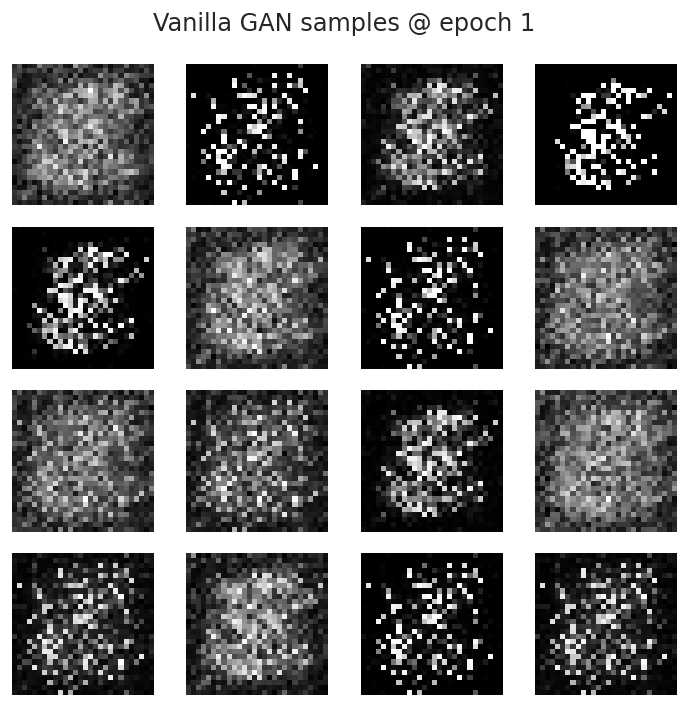

Epoch 002 | D: 1.0870 | G: 1.0593
Epoch 003 | D: 0.9397 | G: 1.3971
Epoch 004 | D: 1.0240 | G: 1.3367
Epoch 005 | D: 1.1690 | G: 1.1026


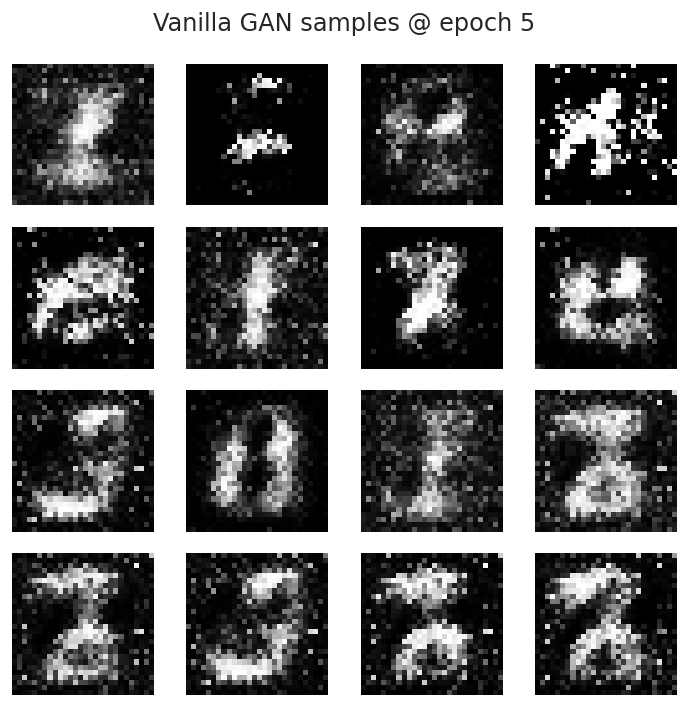

Epoch 006 | D: 1.1746 | G: 1.1018
Epoch 007 | D: 1.1700 | G: 1.1163
Epoch 008 | D: 1.1567 | G: 1.1586
Epoch 009 | D: 1.1893 | G: 1.0982
Epoch 010 | D: 1.1609 | G: 1.1599


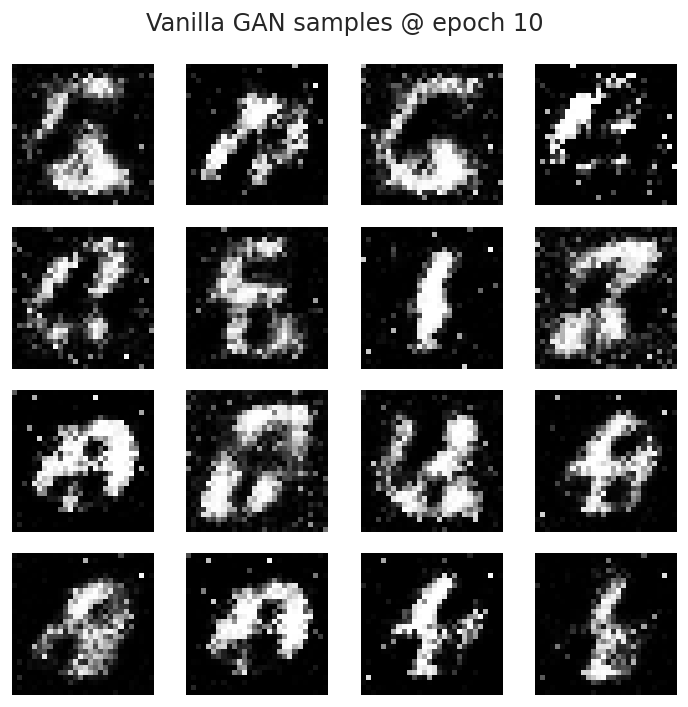

Epoch 011 | D: 1.1657 | G: 1.1591
Epoch 012 | D: 1.1438 | G: 1.1891
Epoch 013 | D: 1.1610 | G: 1.1673
Epoch 014 | D: 1.1576 | G: 1.1719
Epoch 015 | D: 1.1414 | G: 1.2010


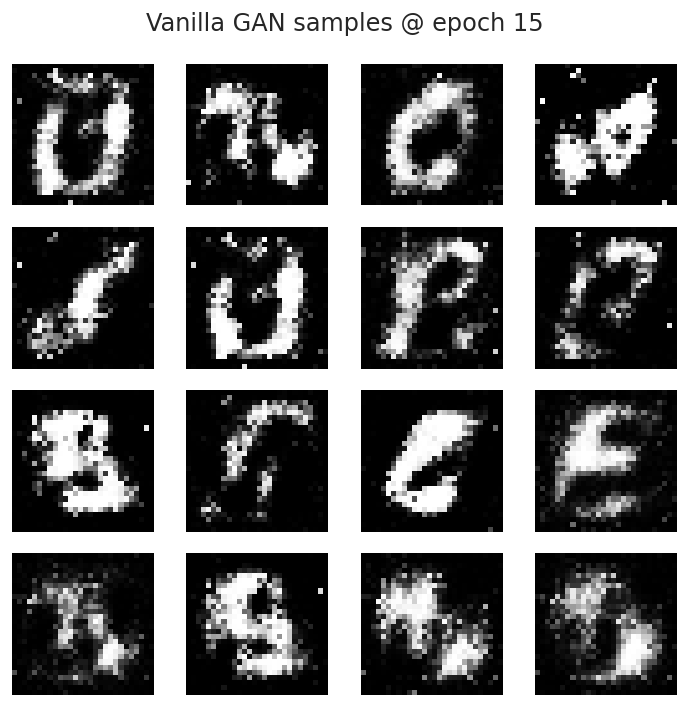

Epoch 016 | D: 1.1520 | G: 1.2009
Epoch 017 | D: 1.1567 | G: 1.1778
Epoch 018 | D: 1.1612 | G: 1.1580
Epoch 019 | D: 1.1567 | G: 1.1839
Epoch 020 | D: 1.1819 | G: 1.1448


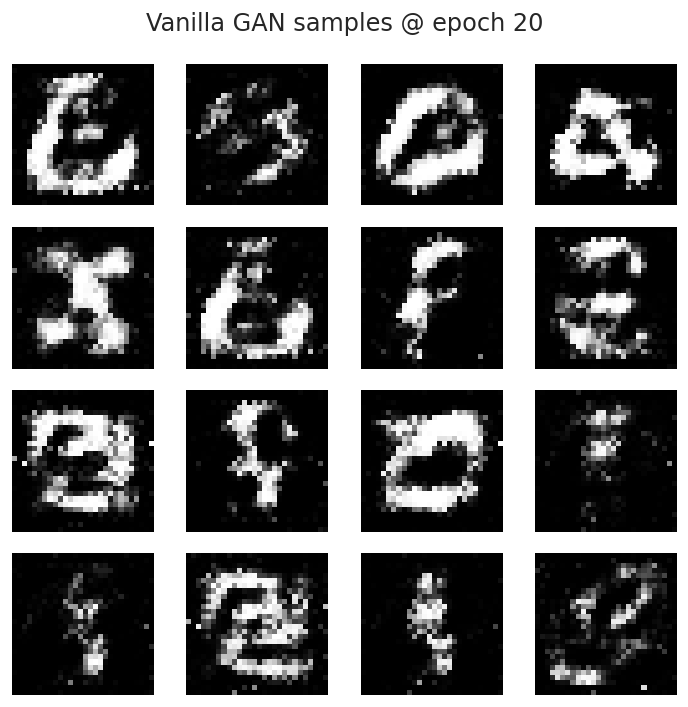

Epoch 021 | D: 1.1843 | G: 1.1237
Epoch 022 | D: 1.1798 | G: 1.1315
Epoch 023 | D: 1.1935 | G: 1.1031
Epoch 024 | D: 1.1973 | G: 1.1074
Epoch 025 | D: 1.1981 | G: 1.1005


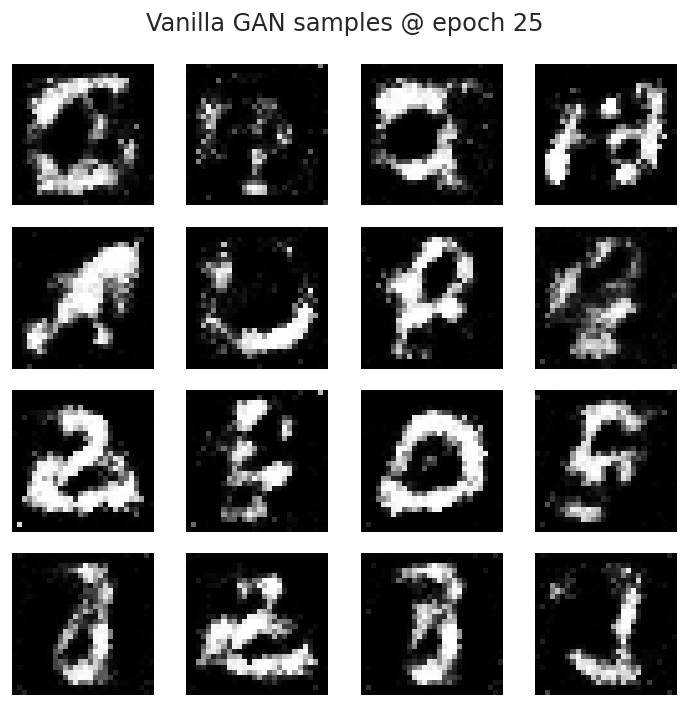

Epoch 026 | D: 1.2045 | G: 1.0862
Epoch 027 | D: 1.2169 | G: 1.0701
Epoch 028 | D: 1.2183 | G: 1.0641
Epoch 029 | D: 1.2278 | G: 1.0501
Epoch 030 | D: 1.2341 | G: 1.0381


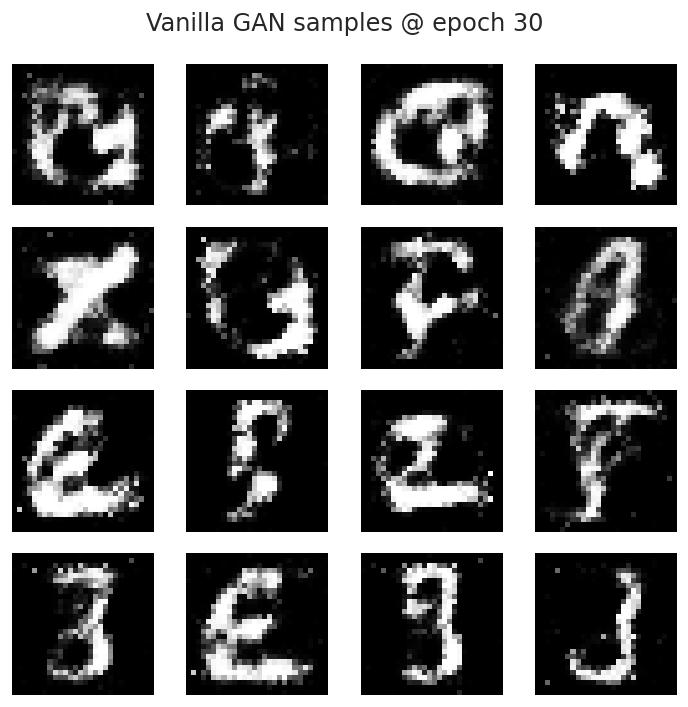

Epoch 031 | D: 1.2397 | G: 1.0287
Epoch 032 | D: 1.2498 | G: 1.0187
Epoch 033 | D: 1.2472 | G: 1.0144
Epoch 034 | D: 1.2452 | G: 1.0168
Epoch 035 | D: 1.2531 | G: 1.0118


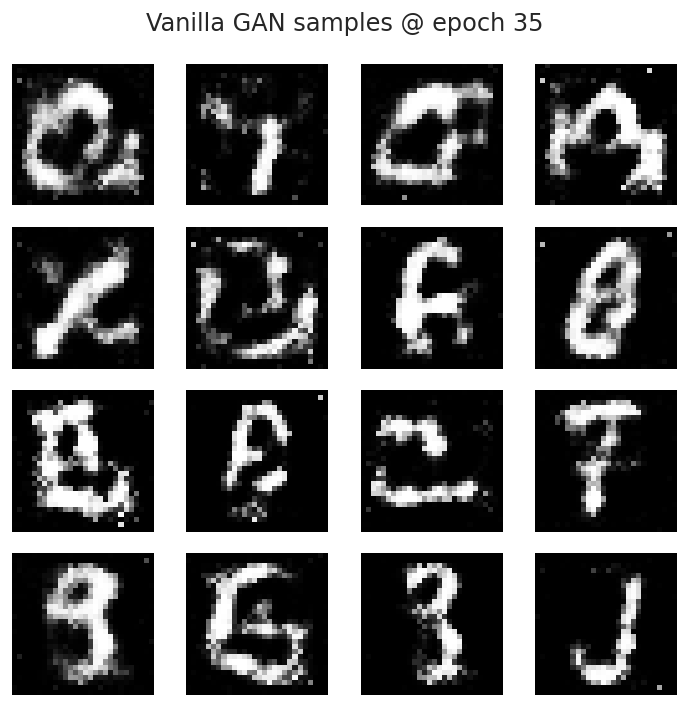

Epoch 036 | D: 1.2501 | G: 1.0147
Epoch 037 | D: 1.2486 | G: 1.0116
Epoch 038 | D: 1.2546 | G: 1.0081
Epoch 039 | D: 1.2554 | G: 1.0078
Epoch 040 | D: 1.2601 | G: 0.9969


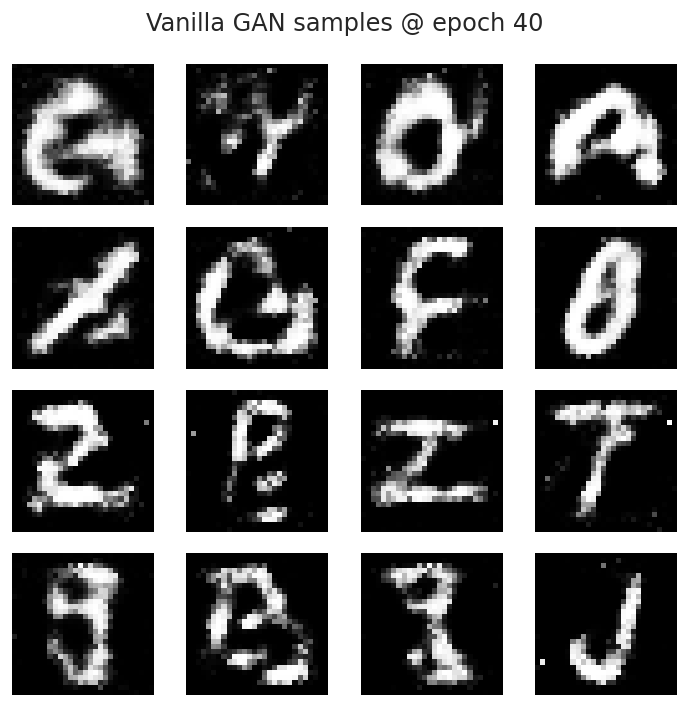

Epoch 041 | D: 1.2584 | G: 0.9971
Epoch 042 | D: 1.2624 | G: 0.9972
Epoch 043 | D: 1.2647 | G: 0.9949
Epoch 044 | D: 1.2639 | G: 0.9917
Epoch 045 | D: 1.2620 | G: 0.9938


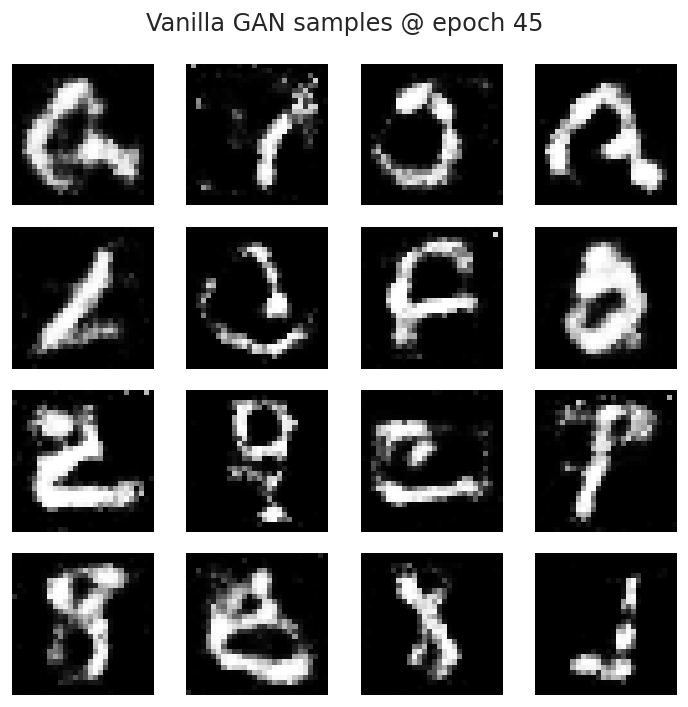

Epoch 046 | D: 1.2635 | G: 0.9944
Epoch 047 | D: 1.2635 | G: 0.9925
Epoch 048 | D: 1.2635 | G: 0.9940
Epoch 049 | D: 1.2616 | G: 0.9962
Epoch 050 | D: 1.2640 | G: 0.9984


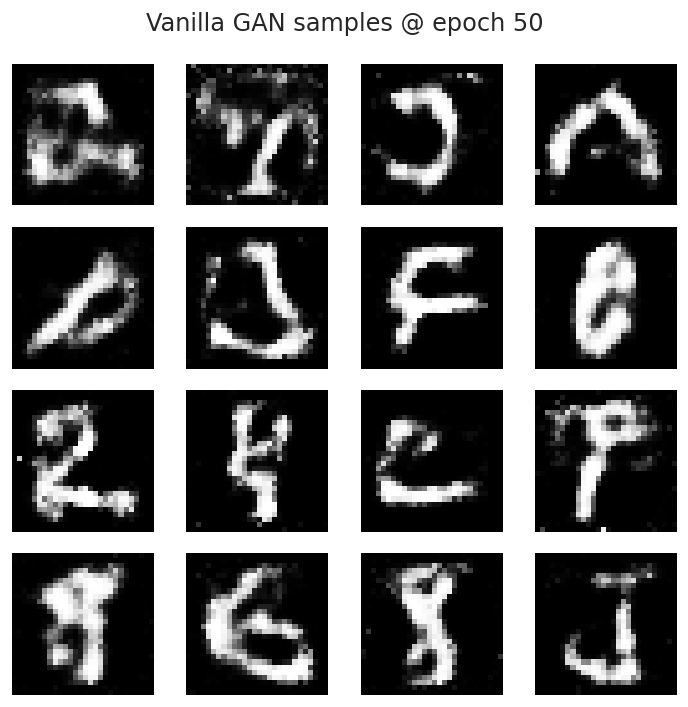

In [31]:
vanilla = VanillaGAN(vec_dim=784, latent_dim=100)
trainer_vanilla = VanillaGANTrainer(vanilla, train_ds_gan, latent_dim=100, label_smooth=0.9, seed=42)
d_hist_gan, g_hist_gan = trainer_vanilla.train(epochs=50, sample_interval=5)

# for metrics later:
gen_vecs = trainer_vanilla.generate(5000)  # [-1,1], (5000,784)




### Evaluation of Vanilla GAN

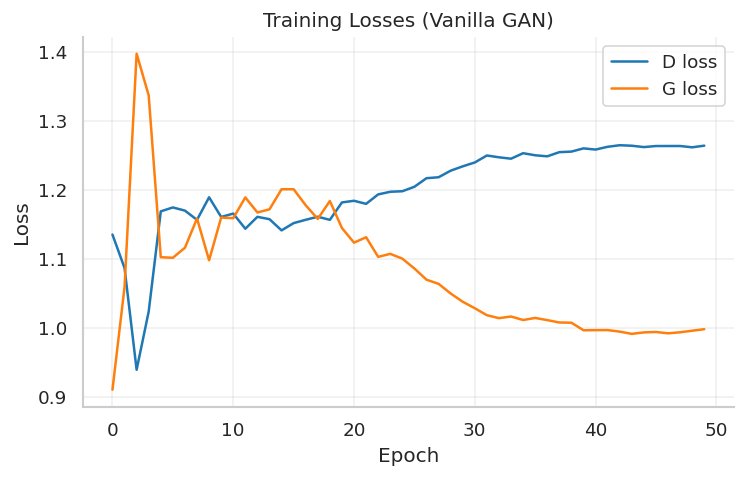

In [33]:
# === Plot loss curves (D & G) ===
plt.figure(figsize=(7,4))
plt.plot(vanilla.d_losses, label="D loss")
plt.plot(vanilla.g_losses, label="G loss")
plt.title("Training Losses (Vanilla GAN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()




Observations
- **Discriminator Loss (D loss)**:
  - Initially fluctuates, stabilizes around epoch 10, but increases steadily afterward, overpowering the generator.
- **Generator Loss (G loss)**:
  - High and unstable early on, decreases gradually until epoch 30, then plateaus with minimal improvement.

Issues
- Imbalance: Discriminator dominates, leading to poor training dynamics.
- Instability: Sharp fluctuations in early epochs.
- Plateau: Generator struggles to improve after epoch 30.



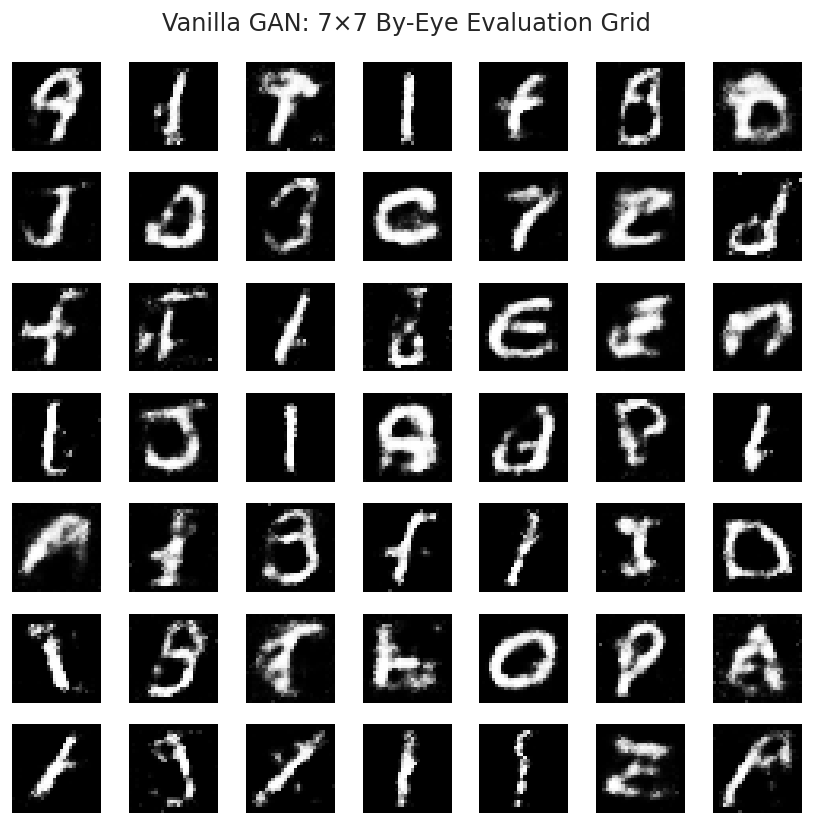

In [34]:
# === Generate 7×7 grid for by-eye evaluation ===
def sample_grid_7x7(gan, latent_dim=100):
    rng = np.random.default_rng()  # uses the global seed set earlier
    z = tf.convert_to_tensor(rng.standard_normal((49, latent_dim)).astype(np.float32))
    vecs = gan.generator(z, training=False).numpy()
    imgs = (vecs.reshape(-1,28,28) + 1.0) / 2.0  # scale back to [0,1]

    fig, axs = plt.subplots(7, 7, figsize=(7,7))
    k = 0
    for i in range(7):
        for j in range(7):
            axs[i,j].imshow(imgs[k], cmap='gray')
            axs[i,j].axis('off')
            k += 1
    plt.suptitle("Vanilla GAN: 7×7 By-Eye Evaluation Grid")
    plt.tight_layout()
    plt.show()

# Call function
sample_grid_7x7(vanilla, latent_dim=100)





As expected, and based on our observations, the vanilla GAN is not suitable for our assignment. Key reasons include:

- **Lack of class-based conditioning**: Vanilla GAN cannot handle class-specific generation effectively.
- **Poor image quality**: The generated images show significant artifacts and lack clarity.

Given these limitations, we will quickly transition to the next model in our plan.

## DCGAN Implementation
---

**Deep Convolutional GAN (DCGAN)**

**Structure:**  
- Replaces fully connected layers with deep convolutional layers in both the Generator (using transposed convolutions) and Discriminator.
- Incorporates batch normalization to stabilize training.

**Why it works here:**  
- Convolutional layers are well-suited for capturing the spatial features of handwritten characters, resulting in sharper and more realistic images.

**Role in this problem:**  
- DCGAN models fine-grained stroke details better than a Vanilla GAN, helping to reduce blurriness and improve letter shape quality.

### Data Processing for DCGAN
---


In [35]:
# === Preprocess for DCGAN ===
def preprocess_data_dcgan(df):
    """Return images as float32 in [-1,1], shape (N,28,28,1) for DCGAN."""
    pix_cols = [c for c in df.columns if str(c).startswith("pixel_")]
    assert len(pix_cols) == 784, f"Expected 784 pixel columns, got {len(pix_cols)}"
    x = df[pix_cols].to_numpy(dtype=np.float32, copy=False)
    x = (x - 127.5) / 127.5                      # -> [-1, 1]
    x = x.reshape(-1, 28, 28, 1)
    print(f"Images shape: {x.shape}, dtype={x.dtype}, range [{x.min():.3f}, {x.max():.3f}]")
    return x

# Preprocess the data for DCGAN
X_train_dcgan = preprocess_data_dcgan(processed_data)

# tf.data pipeline
BATCH_SIZE_DCGAN = 256
BUFFER_SIZE_DCGAN = len(X_train_dcgan)

train_ds_dcgan = (
    tf.data.Dataset.from_tensor_slices(X_train_dcgan)
    .cache()
    .shuffle(BUFFER_SIZE_DCGAN, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE_DCGAN, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)


Images shape: (54468, 28, 28, 1), dtype=float32, range [-1.000, 1.000]


### Define DCGAN Architecture
---
Let's implement the training loop for our conditional GAN.

In [36]:
class DCGAN:
    def __init__(self, img_shape=(28, 28, 1), latent_dim=100):
        """
        Initialize Basic GAN components: generator and discriminator.
        Args:
            img_shape (tuple): Shape of input images (28x28 grayscale).
            latent_dim (int): Dimensionality of the random noise vector.
        """
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Build generator and discriminator models
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        # Optimizers for training
        self.gen_optimizer = optimizers.Adam(1e-4)
        self.disc_optimizer = optimizers.Adam(1e-4)

        # Track losses for visualization
        self.d_losses = []
        self.g_losses = []

    def build_generator(self):
        """
        Build the generator model.
        Returns:
            tf.keras.Model: Generator model that takes noise as input and outputs synthetic images.
        """
        noise_input = layers.Input(shape=(self.latent_dim,))

        # Dense layer to project noise into feature maps
        x = layers.Dense(7 * 7 * 256, use_bias=False)(noise_input)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        # Reshape projected features to spatial dimensions
        x = layers.Reshape((7, 7, 256))(x)

        # Deconvolutional layers to upsample
        x = layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        # Final layer to output a single channel grayscale image
        x = layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

        return models.Model(noise_input, x)

    def build_discriminator(self):
        """
        Build the discriminator model.
        Returns:
            tf.keras.Model: Discriminator model that takes images as input and outputs a binary classification.
        """
        image_input = layers.Input(shape=self.img_shape)

        # Convolutional layers to downsample
        x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(image_input)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        # Flatten the spatial dimensions and output binary classification
        x = layers.Flatten()(x)
        x = layers.Dense(1)(x)

        return models.Model(image_input, x)

    def discriminator_loss(self, real_output, fake_output):
        """
        Calculate discriminator loss.
        Args:
            real_output: Discriminator output for real images
            fake_output: Discriminator output for fake images
        Returns:
            tf.Tensor: Discriminator loss
        """
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        """
        Calculate generator loss.
        Args:
            fake_output: Discriminator output for fake images
        Returns:
            tf.Tensor: Generator loss
        """
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

### Train DCGAN
---
Let's train our GAN and generate the required 160 images (10 per class for 16 classes).

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np

class DCGANTrainer:
    def __init__(self, gan, train_dataset, latent_dim=100):
        """
        Initialize the DCGAN trainer.
        Args:
            gan (DCGAN): The DCGAN model containing generator and discriminator.
            train_dataset (tf.data.Dataset): Dataset of real images for training.
            latent_dim (int): Dimensionality of the random noise vector.
        """
        self.gan = gan
        self.train_dataset = train_dataset
        self.latent_dim = latent_dim

    def train_step(self, images):
        """
        A single training step for DCGAN.
        """
        noise = tf.random.normal([images.shape[0], self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.gan.generator(noise, training=True)
            real_output = self.gan.discriminator(images, training=True)
            fake_output = self.gan.discriminator(generated_images, training=True)
            g_loss = self.gan.generator_loss(fake_output)
            d_loss = self.gan.discriminator_loss(real_output, fake_output)

        gradients_gen = gen_tape.gradient(g_loss, self.gan.generator.trainable_variables)
        gradients_disc = disc_tape.gradient(d_loss, self.gan.discriminator.trainable_variables)

        self.gan.gen_optimizer.apply_gradients(zip(gradients_gen, self.gan.generator.trainable_variables))
        self.gan.disc_optimizer.apply_gradients(zip(gradients_disc, self.gan.discriminator.trainable_variables))

        return d_loss, g_loss

    def train(self, epochs=30, sample_interval=5):
        """
        Train the DCGAN for a specified number of epochs.
        """
        fixed_noise = tf.random.normal([16, self.latent_dim])

        for epoch in range(epochs):
            for batch_images in self.train_dataset:
                d_loss, g_loss = self.train_step(batch_images)

            self.gan.d_losses.append(d_loss.numpy())
            self.gan.g_losses.append(g_loss.numpy())

            if (epoch + 1) % sample_interval == 0 or epoch == 0:
                print(f"Epoch {epoch+1} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
                self.sample_images(epoch, fixed_noise)

    def sample_images(self, epoch, noise):
        """
        Generate and visualize a batch of images during training.
        """
        gen_imgs = self.gan.generator(noise, training=False)
        gen_imgs = (gen_imgs + 1) / 2.0  # Rescale [-1, 1] to [0, 1]

        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.suptitle(f"DCGAN - Generated Images at Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()





Epoch 1 [D loss: 0.8127] [G loss: 1.0850]


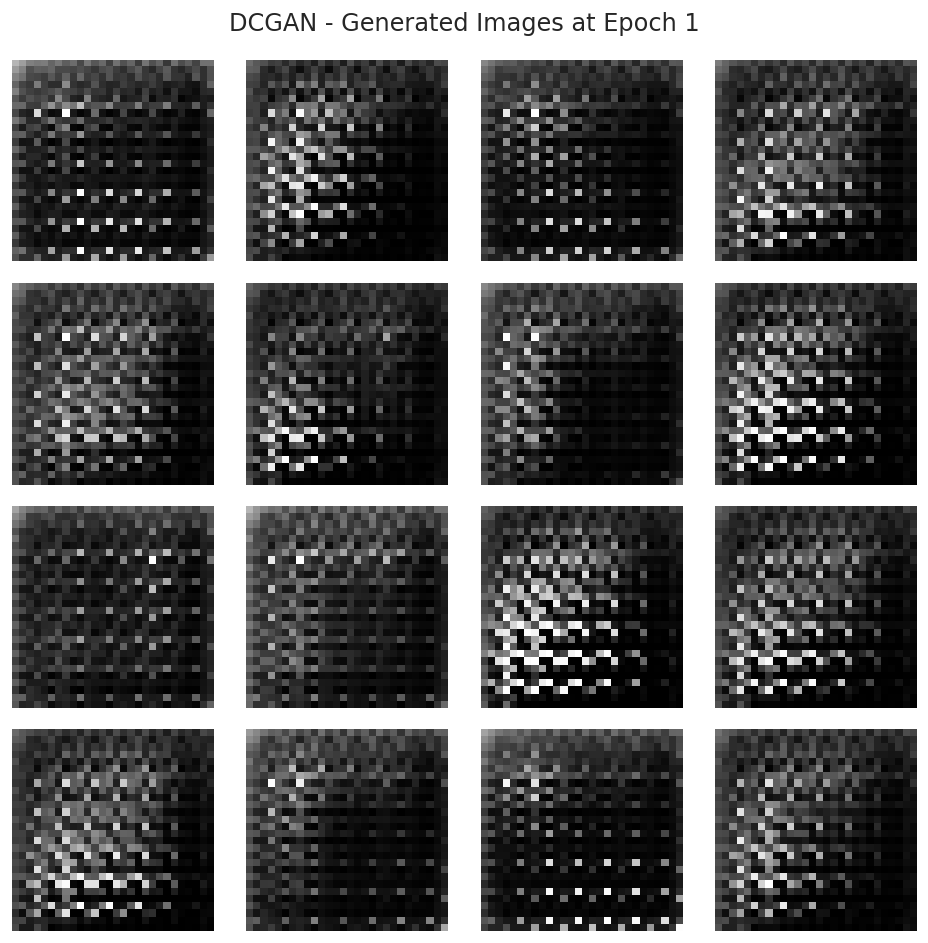

Epoch 5 [D loss: 1.0864] [G loss: 1.1307]


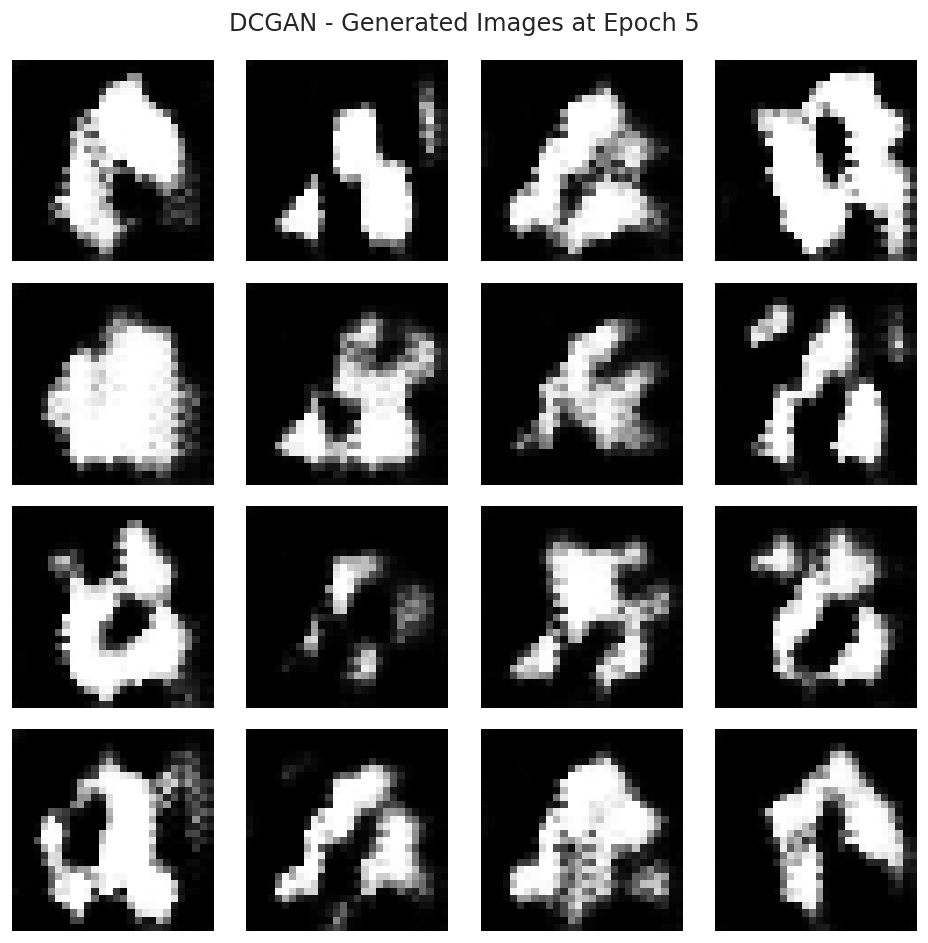

Epoch 10 [D loss: 1.2567] [G loss: 0.9086]


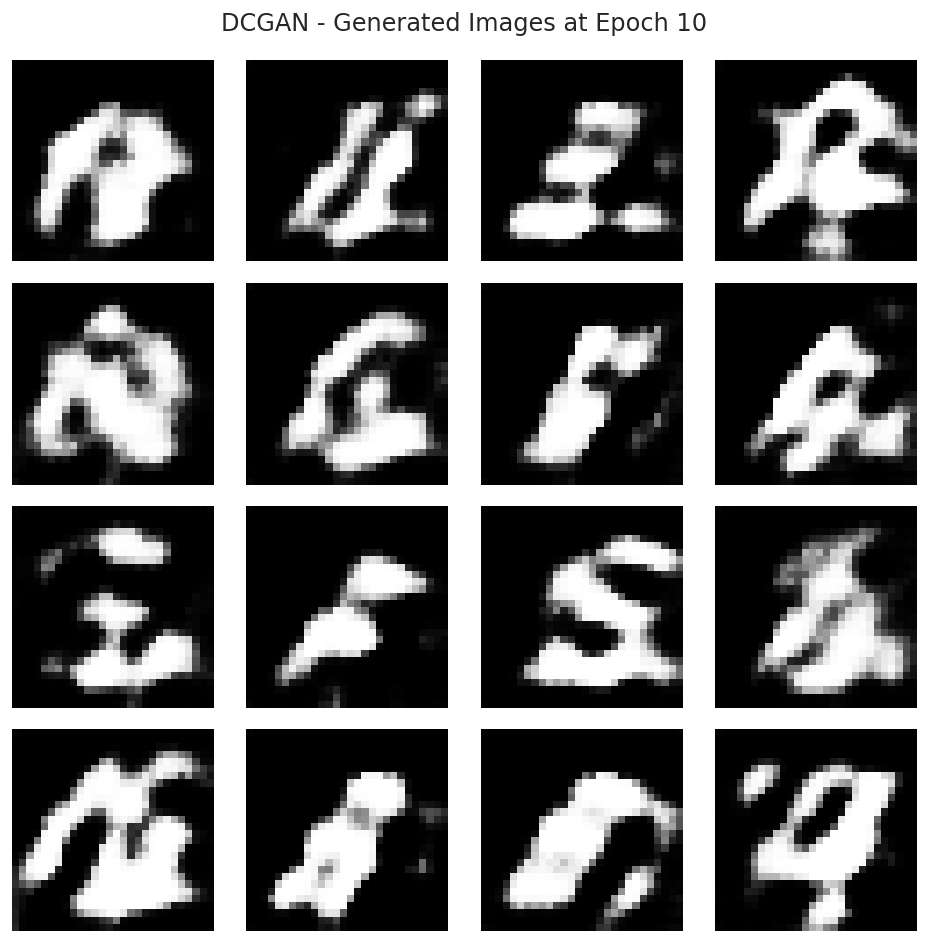

Epoch 15 [D loss: 0.7860] [G loss: 1.3809]


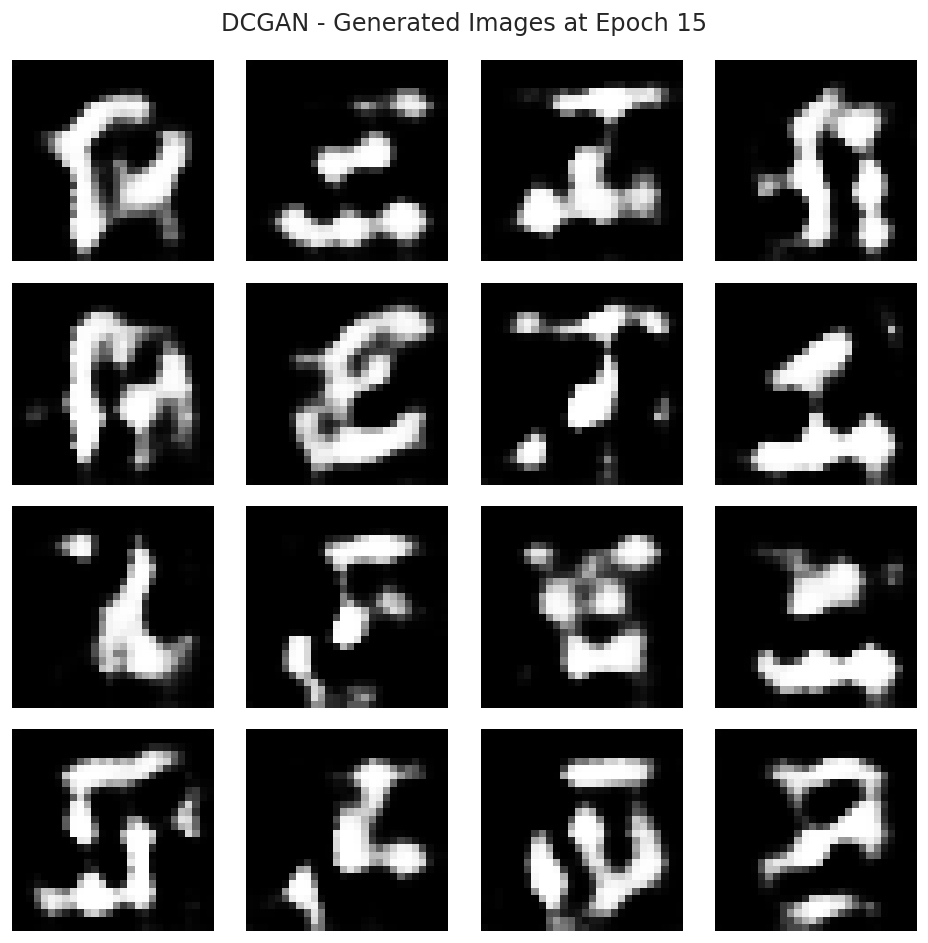

Epoch 20 [D loss: 0.9402] [G loss: 1.5075]


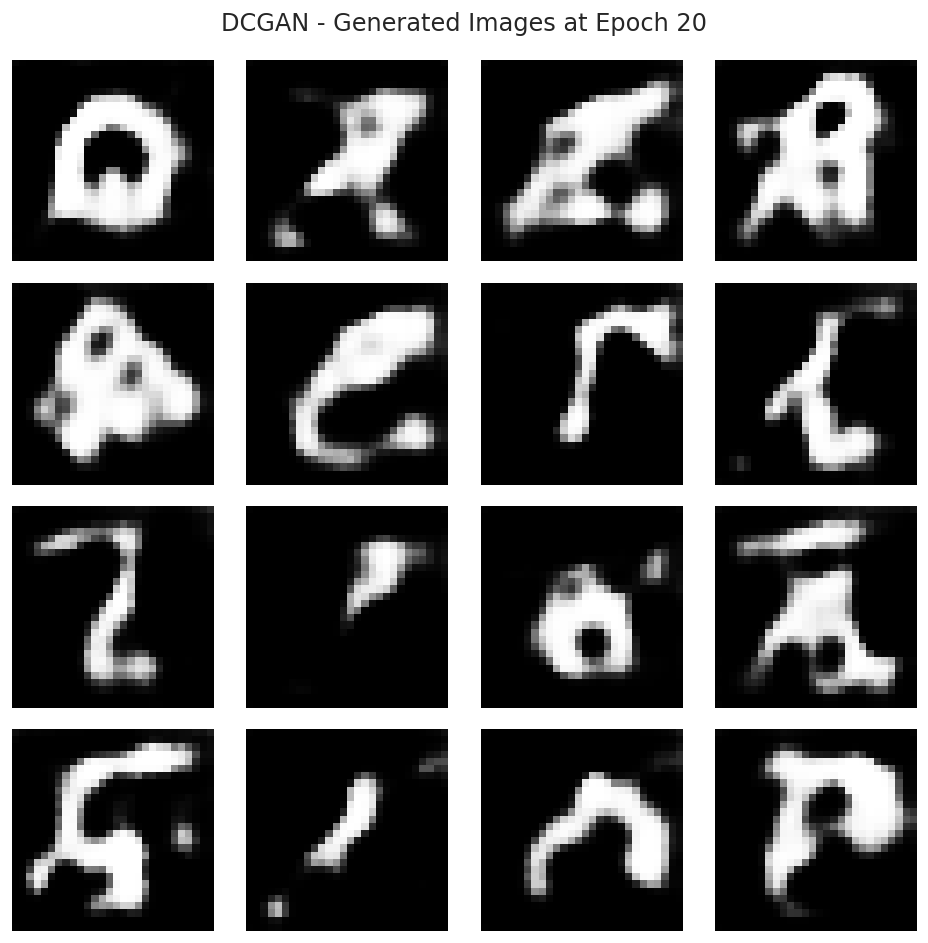

Epoch 25 [D loss: 1.0366] [G loss: 1.1623]


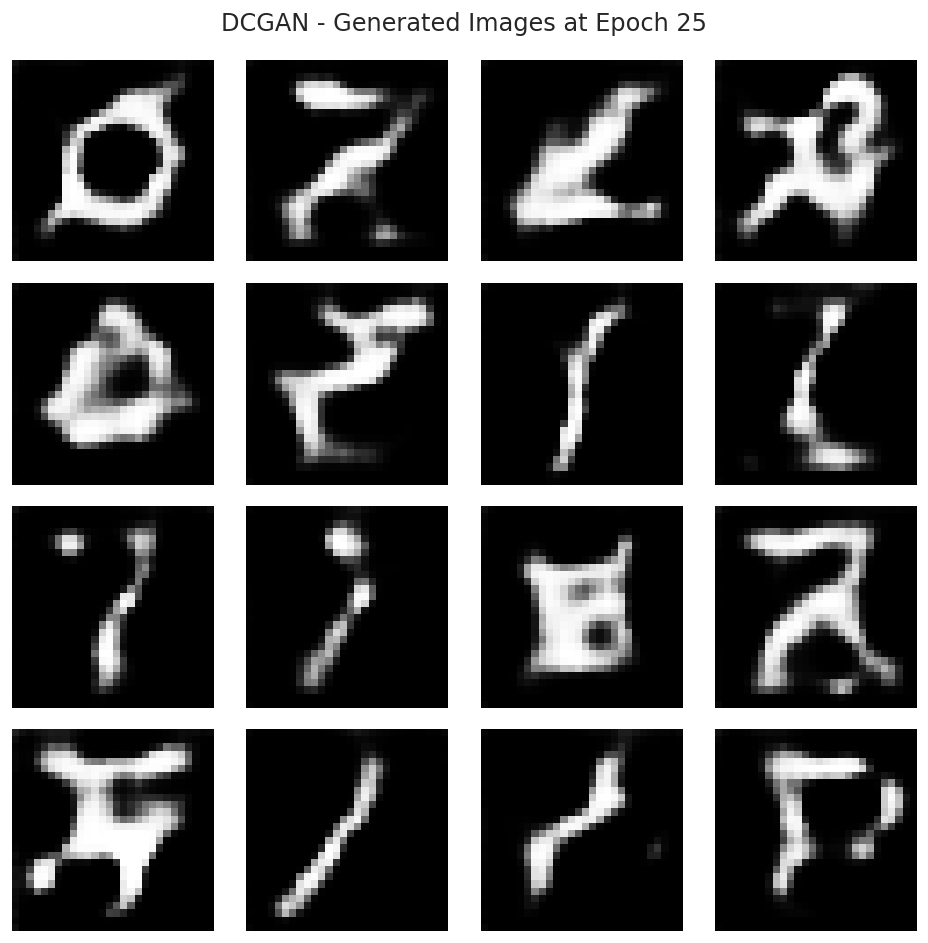

Epoch 30 [D loss: 1.1292] [G loss: 1.1302]


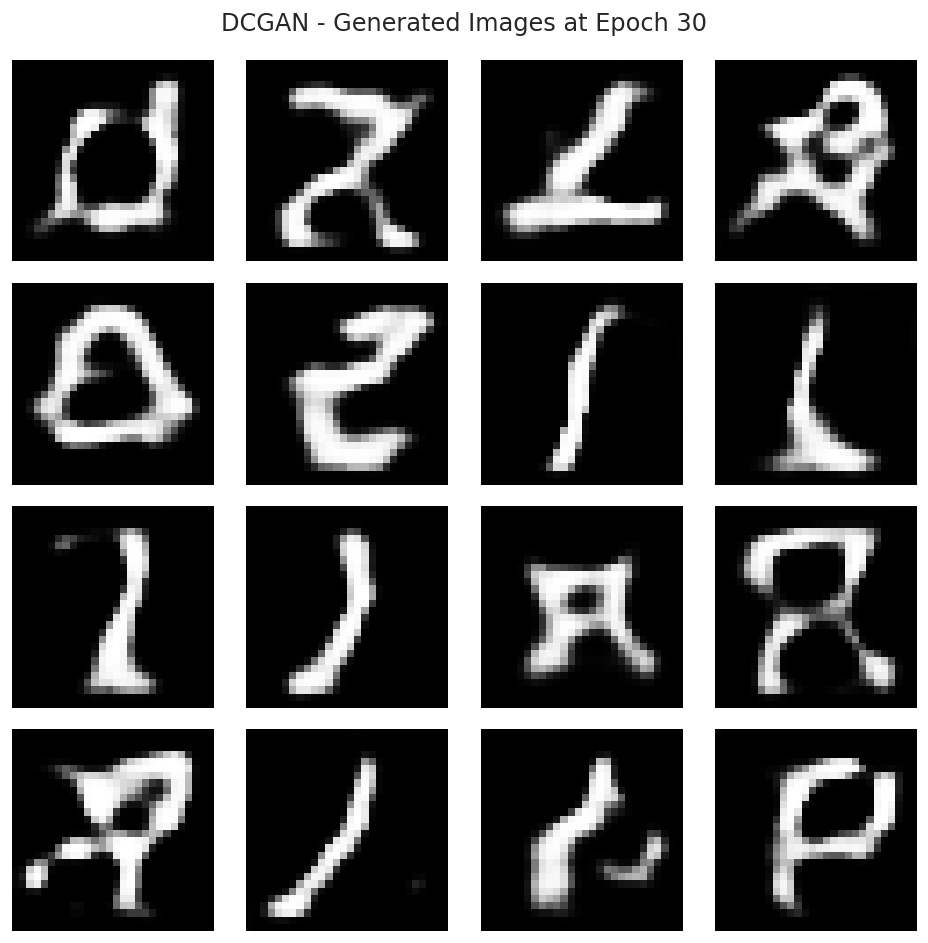

In [39]:
# === Hyperparameters for DCGAN ===
BATCH_SIZE_DCGAN = 256
BUFFER_SIZE_DCGAN = len(X_train_dcgan)

# Create TensorFlow dataset
train_ds_dcgan = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
train_ds_dcgan = train_ds_dcgan.shuffle(BUFFER_SIZE_DCGAN).batch(BATCH_SIZE_DCGAN)

# Initialize the DCGAN
dcgan_model = DCGAN(img_shape=(28, 28, 1), latent_dim=100)

# Initialize the DCGAN trainer
trainer_dcgan = DCGANTrainer(dcgan_model, train_ds_dcgan, latent_dim=100)

# Train the DCGAN
trainer_dcgan.train(epochs=30, sample_interval=5)


As observed, the imges are generated are not classified, in fact, because we are using GAN, which is unable to specify class of the image they produce, meaning we cannot guarantee that we will get images for all 16 classes, so we will find other type of GAN.

### Evaluation of DCGAN

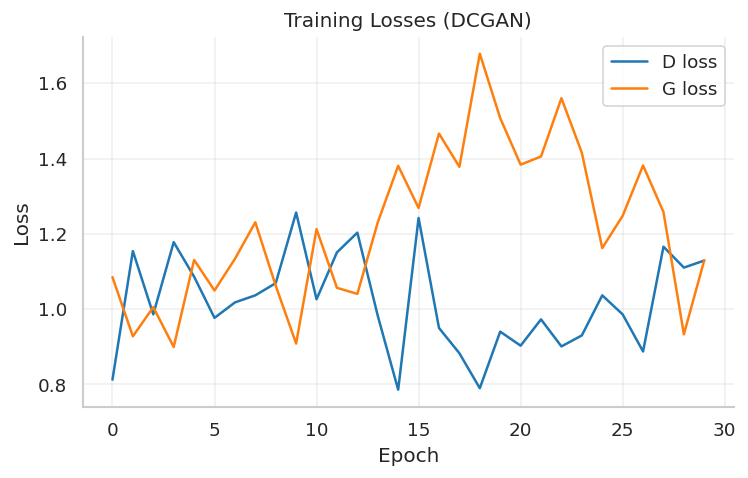

In [41]:
# === Plot loss curves (D & G) ===
plt.figure(figsize=(7,4))
plt.plot(dcgan_model.d_losses, label="D loss")
plt.plot(dcgan_model.g_losses, label="G loss")
plt.title("Training Losses (DCGAN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()







Quick Read of the Curves
- **Discriminator Loss (D loss)**:
  - Trends down toward ~0.8–1.0 with occasional spikes, indicating the discriminator is generally stronger than the generator.
- **Generator Loss (G loss)**:
  - Rises to ~1.6 and oscillates above the discriminator loss, showing the generator is struggling to fool the discriminator.
- **No Flatlining or Explosive Divergence**:
  - No hard collapse observed, but training remains unstable and inefficient.

Performance Verdict
- **Fidelity**:
  - Likely low–moderate, as the rising generator loss suggests the generated images aren’t consistently sharp or realistic.
- **Diversity**:
  - Probably moderate, as oscillations without collapse typically retain some variety. However, expect mode dropping for harder patterns.
- **Stability/Convergence**:
  - Suboptimal, with the discriminator overpowering the generator. Losses closer and more stable could lead to better sample quality.




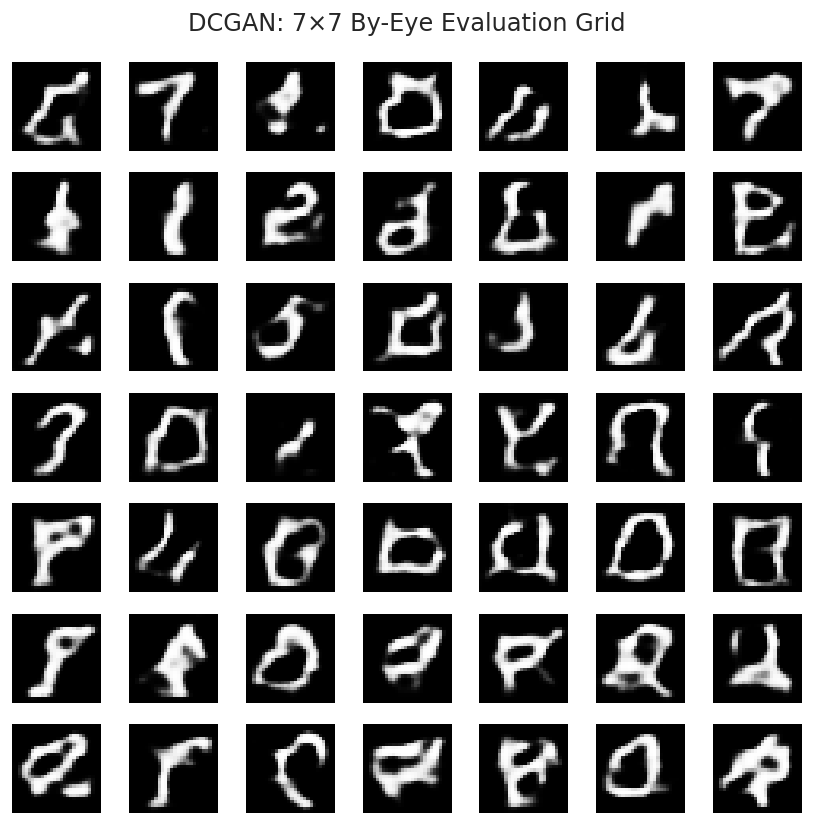

In [42]:
def sample_grid_7x7(gan, latent_dim=None, title="DCGAN: 7×7 By-Eye Evaluation Grid"):
    # Use model's latent_dim if available
    if latent_dim is None:
        latent_dim = getattr(gan, "latent_dim", 100)

    # Sample noise
    z = tf.random.normal([49, latent_dim])

    # Generate
    out = gan.generator(z, training=False).numpy()

    # Handle output shape:
    # - DCGAN: (N, 28, 28, 1)
    # - Vanilla (flattened): (N, 784)
    if out.ndim == 4:              # (N, H, W, C)
        imgs = out.squeeze(-1)     # -> (N, 28, 28)
    elif out.ndim == 2:            # (N, 784)
        imgs = out.reshape(-1, 28, 28)
    else:
        raise ValueError(f"Unexpected generator output shape: {out.shape}")

    # Scale from [-1, 1] to [0, 1]
    imgs = (imgs + 1.0) / 2.0

    # Plot 7x7 grid
    fig, axs = plt.subplots(7, 7, figsize=(7, 7))
    k = 0
    for i in range(7):
        for j in range(7):
            axs[i, j].imshow(imgs[k], cmap="gray", vmin=0, vmax=1)
            axs[i, j].axis("off")
            k += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Call function
sample_grid_7x7(dcgan_model, latent_dim=100, title="DCGAN: 7×7 By-Eye Evaluation Grid")




Performance
- **Fidelity**: Low–moderate. Images are soft and blurry, with ghosting and weak corners/crossbars.
- **Class Consistency**: Weak. Few glyphs resemble clear letters; many are ambiguous blobs or loops.
- **Diversity**: Moderate but biased. Dominated by rounded shapes (“O/C”) and squiggles; lacks straight-line letters (“E”, “F”, “T”).

Training Insights
- **Blur & Edges**: Generator likely depends on upsampling + BatchNorm, with noisy gradients.
- **Loop Repetition**: Suggests partial mode collapse, favoring closed contours that fool the discriminator.
- **Alignment Variance**: Model struggles with centering/rotation priors or inconsistent training data alignment.

## BigGAN-lite (conditional) Implementation

**BigGAN-lite (Class-Conditional)**

**Structure:**  
- A scaled-down version of BigGAN, incorporating class conditioning.
- Uses spectral normalization in both generator and discriminator for stable, high-capacity training.
- Embeds class labels into the generator and discriminator layers for precise class control.

**Why it works here:**  
- Capable of producing high-quality and diverse samples, even on smaller datasets, by leveraging deeper architecture and normalization techniques.

**Role in this problem:**  
- Serves as a high-fidelity model for generating visually accurate letters, making it valuable for qualitative comparisons.

### Data Processing for BigGAN-lite

In [43]:
# ==== BigGAN data prep ====
import numpy as np
import pandas as pd
import tensorflow as tf

def to_arrays_for_biggan(df, label_col="label"):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    X = df[pix_cols].values.astype(np.float32).reshape(-1, 28, 28, 1)
    X = (X - 127.5) / 127.5  # [-1, 1]
    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch: i for i, ch in enumerate(letters)}
    i2l = {i: ch for ch, i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, letters, l2i, i2l

# Use your canonical cleaned dataframe
X_train_biggan, y_train_biggan, classes_biggan, l2i_biggan, i2l_biggan = to_arrays_for_biggan(processed_data)

BATCH_SIZE_BIGGAN  = 256
BUFFER_SIZE_BIGGAN = len(X_train_biggan)

def _cast_pair(x, y):
    return (tf.cast(x, tf.float32), tf.cast(y, tf.int32))

train_ds_biggan = (
    tf.data.Dataset.from_tensor_slices((X_train_biggan, y_train_biggan))
      .shuffle(min(BUFFER_SIZE_BIGGAN, 10000), reshuffle_each_iteration=True)
      .map(_cast_pair, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE_BIGGAN, drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE)
)

(len(classes_biggan), X_train_biggan.shape)



(16, (54468, 28, 28, 1))

### Define BigGAN-lite Architecture

In [44]:
# ==== BigGAN-lite (conditional) ====
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

# --- Spectral Normalization (Conv/Dense wrapper) ---
class SpectralNorm(layers.Wrapper):
    def __init__(self, layer, power_iterations=1, eps=1e-12, **kwargs):
        super().__init__(layer, **kwargs)
        self.power_iterations = power_iterations
        self.eps = eps

    def build(self, input_shape):
        super().build(input_shape)
        if not hasattr(self.layer, "kernel"):
            raise ValueError("SpectralNorm can only wrap layers with a 'kernel' (Conv2D/Dense).")
        w = self.layer.kernel
        self.w_shape = w.shape
        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.random_normal_initializer(),
            trainable=False,
            name="sn_u"
        )

    def call(self, inputs, training=None):
        w = self.layer.kernel
        w_reshaped = tf.reshape(w, [-1, self.w_shape[-1]])
        u_hat = self.u
        for _ in range(self.power_iterations):
            v_hat = tf.linalg.l2_normalize(tf.matmul(u_hat, tf.transpose(w_reshaped)) + self.eps)
            u_hat = tf.linalg.l2_normalize(tf.matmul(v_hat, w_reshaped) + self.eps)
        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        w_sn = w / (sigma + self.eps)
        self.layer.kernel.assign(w_sn)
        self.u.assign(u_hat)
        return self.layer(inputs, training=training)

# --- Conditional BatchNorm ---
class CondBN(layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.bn = layers.BatchNormalization(center=False, scale=False, momentum=0.9, epsilon=1e-5)
        self.gamma = layers.Dense(channels, kernel_initializer="he_normal")
        self.beta  = layers.Dense(channels, kernel_initializer="he_normal")

    def call(self, inputs, training=None):
        x, y_embed = inputs
        x = self.bn(x, training=training)
        g = self.gamma(y_embed)[:, None, None, :]
        b = self.beta(y_embed)[:, None, None, :]
        return x * (1.0 + g) + b

# --- Generator Residual Block ---
class GenResBlock(layers.Layer):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.cbn1 = CondBN(in_ch)
        self.relu1 = layers.ReLU()
        self.up1 = layers.UpSampling2D(size=(2,2), interpolation='nearest')
        self.conv1 = layers.Conv2D(out_ch, 3, padding='same', use_bias=False, kernel_initializer="he_normal")

        self.cbn2 = CondBN(out_ch)
        self.relu2 = layers.ReLU()
        self.conv2 = layers.Conv2D(out_ch, 3, padding='same', use_bias=False, kernel_initializer="he_normal")

        self.skip_up = layers.UpSampling2D(size=(2,2), interpolation='nearest')
        self.skip_conv = layers.Conv2D(out_ch, 1, padding='same', use_bias=False, kernel_initializer="he_normal")

    def call(self, x, y_embed, training=None):
        x_id = x

        x = self.cbn1([x, y_embed], training=training)
        x = self.relu1(x)
        x = self.up1(x)

        x_id = self.skip_up(x_id)
        x = self.conv1(x)

        x = self.cbn2([x, y_embed], training=training)
        x = self.relu2(x)
        x = self.conv2(x)

        x_id = self.skip_conv(x_id)
        return x + x_id

# --- Discriminator Residual Block ---
class DiscResBlock(layers.Layer):
    def __init__(self, out_ch, down=True, spectral=True):
        super().__init__()
        Conv = (lambda f, k, s: SpectralNorm(layers.Conv2D(f, k, strides=s, padding='same',
                                                           kernel_initializer="he_normal"))) if spectral \
               else (lambda f, k, s: layers.Conv2D(f, k, strides=s, padding='same',
                                                   kernel_initializer="he_normal"))
        self.relu1 = layers.ReLU()
        self.conv1 = Conv(out_ch, 3, 1)
        self.relu2 = layers.ReLU()
        self.conv2 = Conv(out_ch, 3, 1)
        self.down = down
        self.avgpool = layers.AveragePooling2D(pool_size=(2, 2))
        self.skip = Conv(out_ch, 1, 1)

    def call(self, x, training=None):
        x_id = x
        x = self.relu1(x)
        x = self.conv1(x, training=training)
        x = self.relu2(x)
        x = self.conv2(x, training=training)
        if self.down:
            x = self.avgpool(x)
            x_id = self.avgpool(x_id)
        x_id = self.skip(x_id, training=training)
        return x + x_id

class BigGANLite:
    def __init__(self,
                 img_shape=(28,28,1),
                 latent_dim=64,
                 num_classes=16,
                 embed_dim=64,
                 lr_g=2e-4, lr_d=2e-4, beta1=0.0, beta2=0.9,
                 idx_to_letter=None):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.idx_to_letter = idx_to_letter or {}

        self.G = self.build_generator()
        self.D = self.build_discriminator()

        self.g_opt = optimizers.Adam(lr_g, beta_1=beta1, beta_2=beta2)
        self.d_opt = optimizers.Adam(lr_d, beta_1=beta1, beta_2=beta2)

        self.d_losses, self.g_losses = [], []

    # ----- Generator -----
    def build_generator(self):
        z_in = layers.Input(shape=(self.latent_dim,))
        y_in = layers.Input(shape=(1,), dtype='int32')

        y_vec = layers.Embedding(self.num_classes, self.embed_dim)(y_in)
        y_vec = layers.Flatten()(y_vec)

        x = layers.Dense(7*7*128, use_bias=False, kernel_initializer="he_normal")(z_in)
        x = layers.Reshape((7,7,128))(x)

        x = GenResBlock(in_ch=128, out_ch=64)(x, y_vec)
        x = GenResBlock(in_ch=64,  out_ch=32)(x, y_vec)

        x = CondBN(32)([x, y_vec])
        x = layers.ReLU()(x)
        out = layers.Conv2D(1, 3, padding='same', activation='tanh', kernel_initializer="glorot_uniform")(x)
        return tf.keras.Model([z_in, y_in], out, name="biggan_G")

    # ----- Discriminator (Projection + SN) -----
    def build_discriminator(self):
        x_in = layers.Input(shape=self.img_shape)
        y_in = layers.Input(shape=(1,), dtype='int32')

        x = DiscResBlock(64,  down=True,  spectral=True)(x_in)   # 28 -> 14
        x = DiscResBlock(128, down=True,  spectral=True)(x)      # 14 -> 7
        x = DiscResBlock(128, down=False, spectral=True)(x)

        x = layers.ReLU()(x)
        h = layers.GlobalAveragePooling2D()(x)  # (B,C)

        base_logit = SpectralNorm(layers.Dense(1))(h)
        cdim = int(h.shape[-1])
        emb = layers.Embedding(self.num_classes, cdim)(y_in)
        emb = layers.Flatten()(emb)
        proj = layers.Dot(axes=1)([h, emb])[:, None]  # (B,1)
        out = layers.Add()([base_logit, proj])
        return tf.keras.Model([x_in, y_in], out, name="biggan_D")

    # ----- Hinge losses -----
    def d_loss(self, real_out, fake_out):
        return tf.reduce_mean(tf.nn.relu(1. - real_out)) + tf.reduce_mean(tf.nn.relu(1. + fake_out))
    def g_loss(self, fake_out):
        return -tf.reduce_mean(fake_out)

    @tf.function
    def train_step(self, real_imgs, real_labels):
        bsz = tf.shape(real_imgs)[0]
        y_real = tf.cast(tf.expand_dims(real_labels, 1), tf.int32)

        # 1) Update D
        z = tf.random.normal([bsz, self.latent_dim])
        y_gen = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as d_tape:
            fake = self.G([z, y_gen], training=True)
            real_out = self.D([real_imgs, y_real], training=True)
            fake_out = self.D([fake, y_gen], training=True)
            d_loss = self.d_loss(real_out, fake_out)

        d_grads = d_tape.gradient(d_loss, self.D.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grads, self.D.trainable_variables))

        # 2) Update G
        z = tf.random.normal([bsz, self.latent_dim])
        y_gen = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as g_tape:
            fake = self.G([z, y_gen], training=True)
            fake_out = self.D([fake, y_gen], training=True)
            g_loss = self.g_loss(fake_out)

        g_grads = g_tape.gradient(g_loss, self.G.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grads, self.G.trainable_variables))

        return d_loss, g_loss

    def train(self, dataset, epochs=10, sample_interval=5):
        for ep in range(1, epochs+1):
            d_sum = g_sum = 0.0; n=0
            for imgs, lbls in dataset:
                d_l, g_l = self.train_step(imgs, tf.cast(lbls, tf.int32))
                d_sum += float(d_l); g_sum += float(g_l); n += 1
            self.d_losses.append(d_sum/max(n,1)); self.g_losses.append(g_sum/max(n,1))
            if ep % sample_interval == 0 or ep == 1:
                print(f"[BigGAN-lite] Epoch {ep:03d} | D={self.d_losses[-1]:.4f} | G={self.g_losses[-1]:.4f}")

    def generate_specific_class(self, class_id, n=10):
        z = tf.random.normal([n, self.latent_dim])
        y = tf.constant([[class_id]] * n, dtype=tf.int32)
        g = self.G([z, y], training=False)
        return ((g + 1.0) / 2.0).numpy()


### Train BigGAN-lite

In [47]:
biggan = BigGANLite(
    img_shape=(28,28,1),
    latent_dim=128,
    num_classes=len(classes_biggan),
    embed_dim=128,
    lr_g=2e-4, lr_d=2e-4, beta1=0.0, beta2=0.9,
    idx_to_letter=i2l_biggan
)
biggan.train(train_ds_biggan, epochs=30, sample_interval=5)




[BigGAN-lite] Epoch 001 | D=1.7710 | G=0.0761
[BigGAN-lite] Epoch 005 | D=1.9299 | G=0.0985
[BigGAN-lite] Epoch 010 | D=1.9675 | G=0.1064
[BigGAN-lite] Epoch 015 | D=1.9603 | G=0.0768
[BigGAN-lite] Epoch 020 | D=1.9723 | G=0.0697
[BigGAN-lite] Epoch 025 | D=1.9744 | G=-0.0731
[BigGAN-lite] Epoch 030 | D=1.9722 | G=0.1018


### Evaluation of BigGAN-lite


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
metrics_biggan: {'FID': 45.358428229713574, 'IS_mean': 1.0001623630523682, 'IS_std': 8.715576768736355e-06, 'n_eval': 5000}


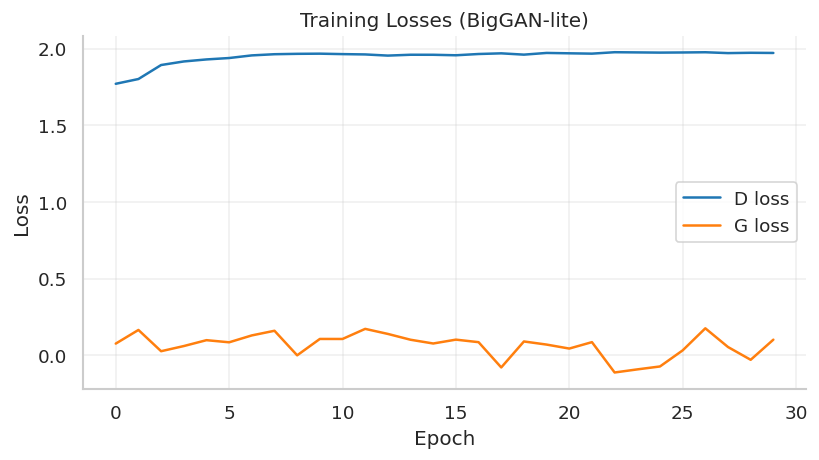

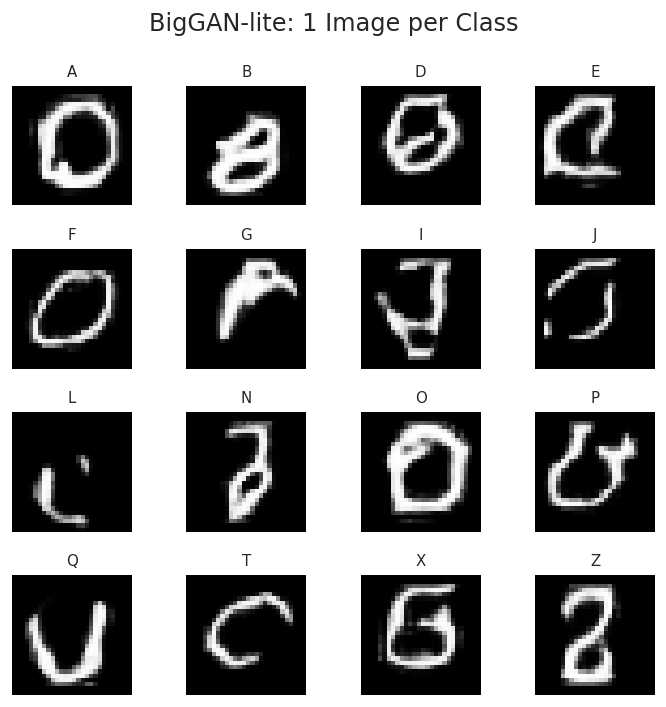

In [48]:
# === BigGAN-lite: Metrics (FID, IS), Loss Curves, 1 Image per Class ===
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# ---------- Metric helpers (define only if not already present) ----------
if 'calculate_fid' not in globals():
    def _resize_and_rgb(images):
        """images: float32 in [0,1], shape (N,H,W,1or3) -> (N,299,299,3)."""
        x = tf.image.resize(images, (299, 299))
        if x.shape[-1] == 1:
            x = tf.repeat(x, 3, axis=-1)
        return (x * 255.0).numpy()

    def _batched_predict(model, x, batch_size=256):
        outs, n = [], x.shape[0]
        for i in range(0, n, batch_size):
            outs.append(model.predict(x[i:i+batch_size], verbose=0))
        return np.concatenate(outs, axis=0)

    def calculate_fid(images1, images2, batch_size=256):
        """FID between two image sets in [0,1], (N,H,W,C)."""
        x1 = _resize_and_rgb(images1); x2 = _resize_and_rgb(images2)
        feat_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_shape=(299,299,3))
        f1 = _batched_predict(feat_model, preprocess_input(x1), batch_size=batch_size)
        f2 = _batched_predict(feat_model, preprocess_input(x2), batch_size=batch_size)
        mu1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)
        mu2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
        ssdiff = np.sum((mu1 - mu2) ** 2.0)
        covmean = sqrtm(sigma1.dot(sigma2))
        covmean = covmean.real if np.iscomplexobj(covmean) else covmean
        return float(ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean))

if 'calculate_inception_score' not in globals():
    def calculate_inception_score(images, n_split=10, batch_size=256):
        """Inception Score on images in [0,1], (N,H,W,C). Returns (mean, std)."""
        x = _resize_and_rgb(images)
        clf = InceptionV3(include_top=True, weights='imagenet', input_shape=(299,299,3))
        preds = _batched_predict(clf, preprocess_input(x), batch_size=batch_size)
        preds = tf.nn.softmax(preds).numpy()
        splits = np.array_split(preds, n_split)
        scores = []
        for p in splits:
            py = np.mean(p, axis=0, keepdims=True)
            kl = p * (np.log(np.clip(p,1e-10,1.0)) - np.log(np.clip(py,1e-10,1.0)))
            kl = np.sum(kl, axis=1)
            scores.append(np.exp(np.mean(kl)))
        return float(np.mean(scores)), float(np.std(scores))

# ---------- Real & generated image helpers ----------
def sample_real_images(df, n):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    x = df.sample(n, random_state=42)[pix_cols].to_numpy(np.float32, copy=False)
    return (x.reshape(-1, 28, 28, 1) / 255.0).astype(np.float32)

def generate_images_for_metrics_conditional(model, labels):
    """labels: int array (N,) with class ids in [0, num_classes). Returns [0,1] images."""
    labels = np.asarray(labels, dtype=np.int32)
    z = tf.random.normal([len(labels), model.latent_dim])
    y = tf.convert_to_tensor(labels.reshape(-1, 1), dtype=tf.int32)
    g = model.G([z, y], training=False).numpy()
    return ((g + 1.0) / 2.0).astype(np.float32)

# ---------- Build eval sets ----------
N_EVAL = min(5000, len(processed_data), len(X_train_biggan))
real_images_biggan = sample_real_images(processed_data, N_EVAL)

# Match class distribution by sampling labels from training labels
rng = np.random.default_rng(42)
sampled_labels = rng.choice(y_train_biggan, size=N_EVAL, replace=True)
gen_images_biggan = generate_images_for_metrics_conditional(biggan, sampled_labels)

# ---------- Compute & store metrics ----------
fid_biggan = calculate_fid(real_images_biggan, gen_images_biggan)
is_mean_biggan, is_std_biggan = calculate_inception_score(gen_images_biggan)

metrics_biggan = {
    "FID": float(fid_biggan),
    "IS_mean": float(is_mean_biggan),
    "IS_std": float(is_std_biggan),
    "n_eval": int(N_EVAL)
}
print("metrics_biggan:", metrics_biggan)

# ---------- Plot training losses ----------
plt.figure(figsize=(7,4))
plt.plot(biggan.d_losses, label="D loss")
plt.plot(biggan.g_losses, label="G loss")
plt.title("Training Losses (BigGAN-lite)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ---------- One image per class (4x4 grid for 16 classes) ----------
n_classes = len(classes_biggan)
assert n_classes == 16, f"Expected 16 classes, got {n_classes}"
per_class = []
for cid in range(n_classes):
    img = biggan.generate_specific_class(cid, n=1)[0, :, :, 0]  # [0,1], (28,28)
    per_class.append(img)

fig, axs = plt.subplots(4, 4, figsize=(6,6))
k = 0
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(per_class[k], cmap='gray', vmin=0, vmax=1)
        axs[i,j].set_title(i2l_biggan.get(k, str(k)), fontsize=9)
        axs[i,j].axis('off'); k += 1
plt.suptitle("BigGAN-lite: 1 Image per Class")
plt.tight_layout(); plt.show()




What the Curves Say
- **Discriminator Loss (D loss)**:
  - Flat at ~1.9–2.0 from the start, indicating an underpowered or undertrained discriminator.
- **Generator Loss (G loss)**:
  - Consistently low at ~0.0–0.2, showing the generator is dominating.
- **Oscillations**:
  - Minimal oscillation, suggesting a weak adversarial dynamic, likely leading to mode collapse (generator finds easy patterns that the discriminator cannot reject).

Likely Causes (BigGAN-lite)
1. **Capacity/Regularization Mismatch**:
   - Lite generator (ResBlocks + condBN) may overwhelm a spectral-normalized discriminator that’s too small.
2. **Update Ratio/Learning Rate**:
   - A 1:1 update ratio with similar or higher learning rates for the generator can prevent the discriminator from catching up.
3. **Batch Size**:
   - Small batch sizes lead to noisy gradients, hindering discriminator training in BigGAN-style setups.
4. **Conditioning Issues**:
   - Weak or incorrectly wired labels/embeddings slow down the discriminator's learning.



Overview
- **Blurry Images**: Letters are unclear and often mismatched to their labels.
- **Bias**: Model favors rounded shapes (O, C) and struggles with straight edges.

Letter Performance
- **Recognizable**: O, C, T (curves), J, I.
- **Confused**:
  - A→D/O, B→8, D→O+swirl, E→C, F→O, G→blob.
  - L→comma, N→7/Z, P→loop, Q→U, X→6/S, Z→2.

Implications
- Weak conditioning and an overpowered generator lead to mode bias/collapse toward circular strokes.

## CGAN Implementation

**Conditional GAN (CGAN)**

**Structure:**  
- Incorporates class labels as an additional input to both the generator and discriminator.
- The generator creates samples conditioned on the specified label.
- The discriminator evaluates both the authenticity of the sample and whether it matches the given label.

**Why it works here:**  
- Enables class-specific generation, which is essential for datasets like EMNIST where some letters are visually similar.

**Role in this problem:**  
- Directly addresses class ambiguity by explicitly conditioning generation on the intended letter, improving label accuracy in generated samples.

### Data Processing for CGAN

In [49]:
# === Preprocess for CGAN (letters → ints, images → [-1,1] with channel) ===
import numpy as np

def preprocess_data_cgan(df, label_col="label"):
    """
    Prepare data for CGAN:
      - images: (N, 28, 28, 1) float32 in [-1, 1]
      - labels_encoded: int32 in [0..num_classes-1]
      - classes: sorted list of class letters
      - letter_to_idx / idx_to_letter: mappings for readability
    """
    # Pixels (assumes pixel_0..pixel_783)
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    pixels = df[pix_cols].values.astype(np.float32)           # (N, 784)

    images = pixels.reshape(-1, 28, 28)                       # (N, 28, 28)
    images = (images - 127.5) / 127.5                         # [-1, 1]
    images = np.expand_dims(images, axis=-1)                  # (N, 28, 28, 1)

    # Labels: letters → ints (stable alphabetical order)
    labels_letter = df[label_col].astype(str).values
    classes = sorted(np.unique(labels_letter).tolist())       # e.g., 16 letters
    letter_to_idx = {ch: i for i, ch in enumerate(classes)}
    idx_to_letter = {i: ch for ch, i in letter_to_idx.items()}
    labels_encoded = np.array([letter_to_idx[ch] for ch in labels_letter], dtype=np.int32)

    # Diagnostics (concise)
    print(f"Images: {images.shape}, range [{images.min():.3f}, {images.max():.3f}]")
    print(f"Classes ({len(classes)}): {classes}")
    print(f"Mapping (letter→idx): {letter_to_idx}")

    return images, labels_encoded, classes, letter_to_idx, idx_to_letter

# Use it
X_train_cgan, y_train_cgan, classes_cgan, letter_to_idx, idx_to_letter = preprocess_data_cgan(rotated_data)


Images: (54589, 28, 28, 1), range [-1.000, 1.000]
Classes (16): ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']
Mapping (letter→idx): {'A': 0, 'B': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'I': 6, 'J': 7, 'L': 8, 'N': 9, 'O': 10, 'P': 11, 'Q': 12, 'T': 13, 'X': 14, 'Z': 15}


### Define CGAN Architecture

In [50]:
# === CGAN: Data prep → Model → Train (no image saving/metrics here) ===
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import matplotlib.pyplot as plt

# -------- Preprocess for CGAN (letters → ints, images → [-1,1]) --------
def preprocess_data_cgan(df, label_col="label"):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    x = df[pix_cols].values.astype(np.float32).reshape(-1, 28, 28, 1)
    x = (x - 127.5) / 127.5  # [-1, 1]

    labels_letter = df[label_col].astype(str).values
    classes = sorted(np.unique(labels_letter).tolist())
    letter_to_idx = {ch: i for i, ch in enumerate(classes)}
    idx_to_letter = {i: ch for ch, i in letter_to_idx.items()}
    y = np.array([letter_to_idx[ch] for ch in labels_letter], dtype=np.int32)

    print(f"Images: {x.shape}, range [{x.min():.3f}, {x.max():.3f}]")
    print(f"Classes ({len(classes)}): {classes}")
    return x, y, classes, letter_to_idx, idx_to_letter

# Use your canonical cleaned dataframe
X_train_cgan, y_train_cgan, classes_cgan, letter_to_idx, idx_to_letter = preprocess_data_cgan(processed_data)

# -------- tf.data pipeline (CGAN-specific names) --------
BATCH_SIZE_CGAN  = 256
BUFFER_SIZE_CGAN = len(X_train_cgan)

train_ds_cgan = (
    tf.data.Dataset.from_tensor_slices((X_train_cgan, y_train_cgan))
      .shuffle(min(BUFFER_SIZE_CGAN, 10000), reshuffle_each_iteration=True)
      .batch(BATCH_SIZE_CGAN, drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE)
)

# -------- CGAN components --------
class MinibatchStdDev(layers.Layer):
    def call(self, x):
        # x: (N,H,W,C)
        mean = tf.reduce_mean(x, axis=0, keepdims=True)
        var  = tf.reduce_mean(tf.square(x - mean), axis=0, keepdims=True)
        std  = tf.sqrt(var + 1e-8)
        stat = tf.reduce_mean(std, axis=[1,2,3], keepdims=True)  # (1,1,1,1)
        n = tf.shape(x)[0]; h = tf.shape(x)[1]; w = tf.shape(x)[2]
        stat = tf.tile(stat, [n, h, w, 1])                      # (N,H,W,1)
        return tf.concat([x, stat], axis=-1)

class ConditionalGAN:
    def __init__(self,
                 img_shape=(28, 28, 1),
                 latent_dim=100,
                 num_classes=16,
                 embedding_dim=50,
                 idx_to_letter=None,
                 lr=2e-4, beta1=0.5,
                 use_hinge=False,
                 label_smooth=1.0):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.idx_to_letter = idx_to_letter or {}
        self.use_hinge = use_hinge
        self.label_smooth = label_smooth
        self.ce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        self.gen_optimizer  = optimizers.Adam(learning_rate=lr, beta_1=beta1)
        self.disc_optimizer = optimizers.Adam(learning_rate=lr, beta_1=beta1)

        self.d_losses, self.g_losses = [], []

    # ----- G -----
    def build_generator(self):
        z_in = layers.Input(shape=(self.latent_dim,))
        y_in = layers.Input(shape=(1,), dtype='int32')

        # label embedding → vector
        y_vec = layers.Embedding(self.num_classes, self.embedding_dim)(y_in)
        y_vec = layers.Flatten()(y_vec)

        # dense to 7x7 label map (stronger conditioning)
        y_map = layers.Dense(7*7, use_bias=False)(y_vec)
        y_map = layers.Reshape((7,7,1))(y_map)

        # project noise to 7x7x256
        x = layers.Dense(7*7*256, use_bias=False)(z_in)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.Reshape((7,7,256))(x)
        x = layers.GaussianNoise(0.05)(x)

        # concat spatial label map
        x = layers.Concatenate()([x, y_map])  # (7,7,257)

        x = layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)

        out = layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')(x)
        return tf.keras.Model([z_in, y_in], out, name="cgan_G")

    # ----- D -----
    def build_discriminator(self):
        x_in = layers.Input(shape=self.img_shape)
        y_in = layers.Input(shape=(1,), dtype='int32')

        # labels → spatial map
        y_map = layers.Embedding(self.num_classes, np.prod(self.img_shape))(y_in)
        y_map = layers.Reshape(self.img_shape)(y_map)

        x = layers.GaussianNoise(0.05)(x_in)
        x = layers.Concatenate()([x, y_map])  # (H,W,2)

        x = layers.Conv2D(64, 5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x); x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x); x = layers.Dropout(0.3)(x)

        x = MinibatchStdDev()(x)
        x = layers.Conv2D(128, 3, strides=1, padding='same')(x)
        x = layers.LeakyReLU()(x)

        x = layers.Flatten()(x)
        out = layers.Dense(1)(x)  # logits
        return tf.keras.Model([x_in, y_in], out, name="cgan_D")

    # ----- Losses -----
    def d_loss_bce(self, real_out, fake_out):
        real_targets = self.label_smooth * tf.ones_like(real_out)
        fake_targets = tf.zeros_like(fake_out)
        return self.ce(real_targets, real_out) + self.ce(fake_targets, fake_out)

    def g_loss_bce(self, fake_out):
        return self.ce(tf.ones_like(fake_out), fake_out)

    def d_loss_hinge(self, real_out, fake_out):
        return tf.reduce_mean(tf.nn.relu(1.0 - real_out)) + tf.reduce_mean(tf.nn.relu(1.0 + fake_out))

    def g_loss_hinge(self, fake_out):
        return -tf.reduce_mean(fake_out)

    @tf.function
    def train_step(self, images, labels):
        labels = tf.cast(labels, tf.int32)          # (B,)
        labels_2d = tf.expand_dims(labels, 1)       # (B,1)
        bsz = tf.shape(images)[0]

        # sample labels for generated batch
        z = tf.random.normal([bsz, self.latent_dim])
        gen_labels = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_imgs = self.generator([z, gen_labels], training=True)
            real_out  = self.discriminator([images, labels_2d], training=True)
            fake_out  = self.discriminator([fake_imgs, gen_labels], training=True)

            if self.use_hinge:
                g_loss = self.g_loss_hinge(fake_out)
                d_loss = self.d_loss_hinge(real_out, fake_out)
            else:
                g_loss = self.g_loss_bce(fake_out)
                d_loss = self.d_loss_bce(real_out, fake_out)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        return d_loss, g_loss

    def train(self, dataset, epochs=20, sample_interval=5):
        # fixed panel: one of each class (up to 16)
        panel = min(16, self.num_classes)
        fixed_noise  = tf.random.normal([panel, self.latent_dim])
        fixed_labels = tf.constant([[i % self.num_classes] for i in range(panel)], dtype=tf.int32)

        for epoch in range(1, epochs + 1):
            d_sum = g_sum = 0.0; n_batches = 0
            for imgs, lbls in dataset:
                d_l, g_l = self.train_step(imgs, lbls)
                d_sum += float(d_l); g_sum += float(g_l); n_batches += 1
            d_epoch = d_sum / max(n_batches, 1)
            g_epoch = g_sum / max(n_batches, 1)
            self.d_losses.append(d_epoch); self.g_losses.append(g_epoch)

            if epoch % sample_interval == 0 or epoch == 1:
                print(f"[CGAN] Epoch {epoch:03d} | D: {d_epoch:.4f} | G: {g_epoch:.4f}")
                # quick visual panel (comment out if you truly want zero visuals now)
                gen = self.generator([fixed_noise, fixed_labels], training=False)
                gen = (gen + 1.0) / 2.0
                rows = int(np.ceil(panel / 4)); cols = 4
                fig, axs = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
                axs = np.array(axs).reshape(rows, cols)
                k = 0
                for i in range(rows):
                    for j in range(cols):
                        ax = axs[i, j]
                        if k < panel:
                            ax.imshow(gen[k,:,:,0], cmap='gray', vmin=0, vmax=1)
                            ax.set_title(idx_to_letter.get(k, str(k)))
                        ax.axis('off'); k += 1
                plt.tight_layout(); plt.show()




Images: (54468, 28, 28, 1), range [-1.000, 1.000]
Classes (16): ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


### Train CGAN

[CGAN] Epoch 001 | D: 1.1148 | G: 0.9237


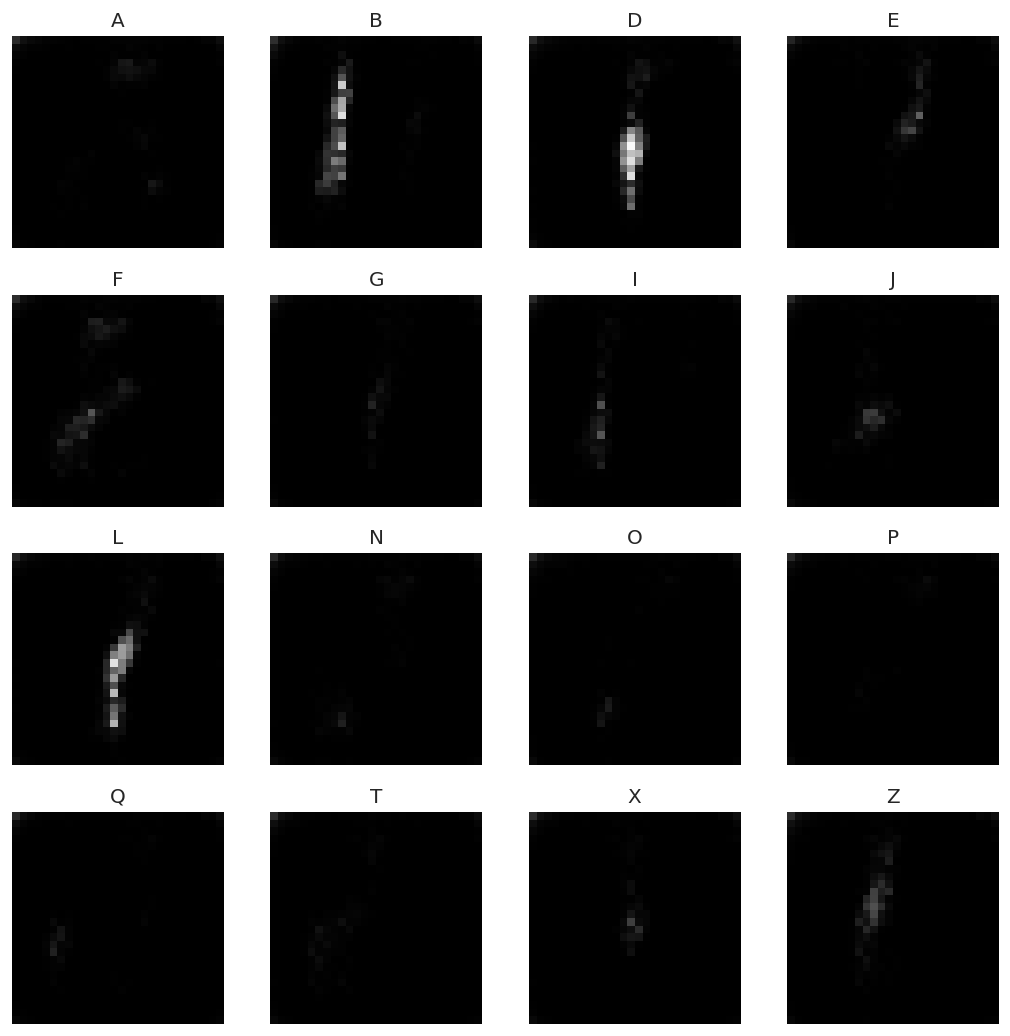

[CGAN] Epoch 005 | D: 1.0664 | G: 1.1893


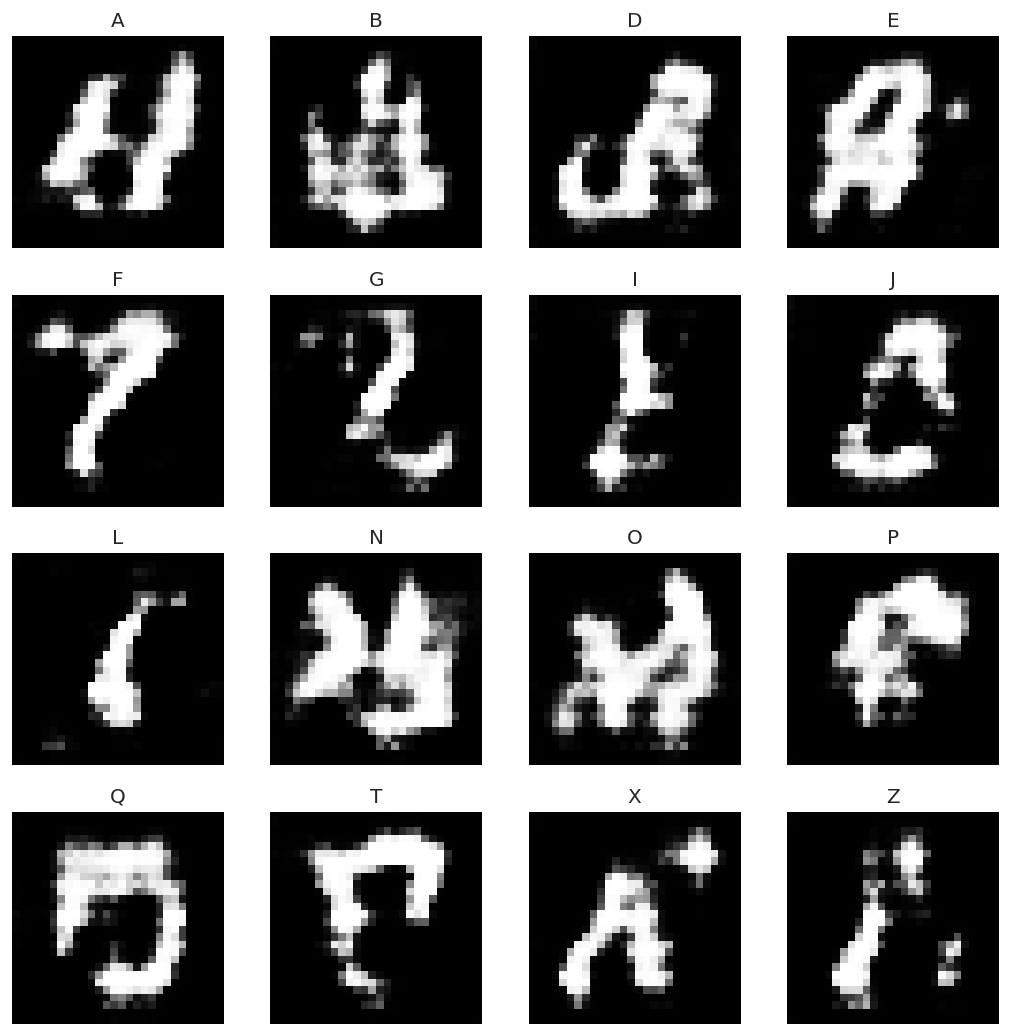

[CGAN] Epoch 010 | D: 1.2169 | G: 0.9491


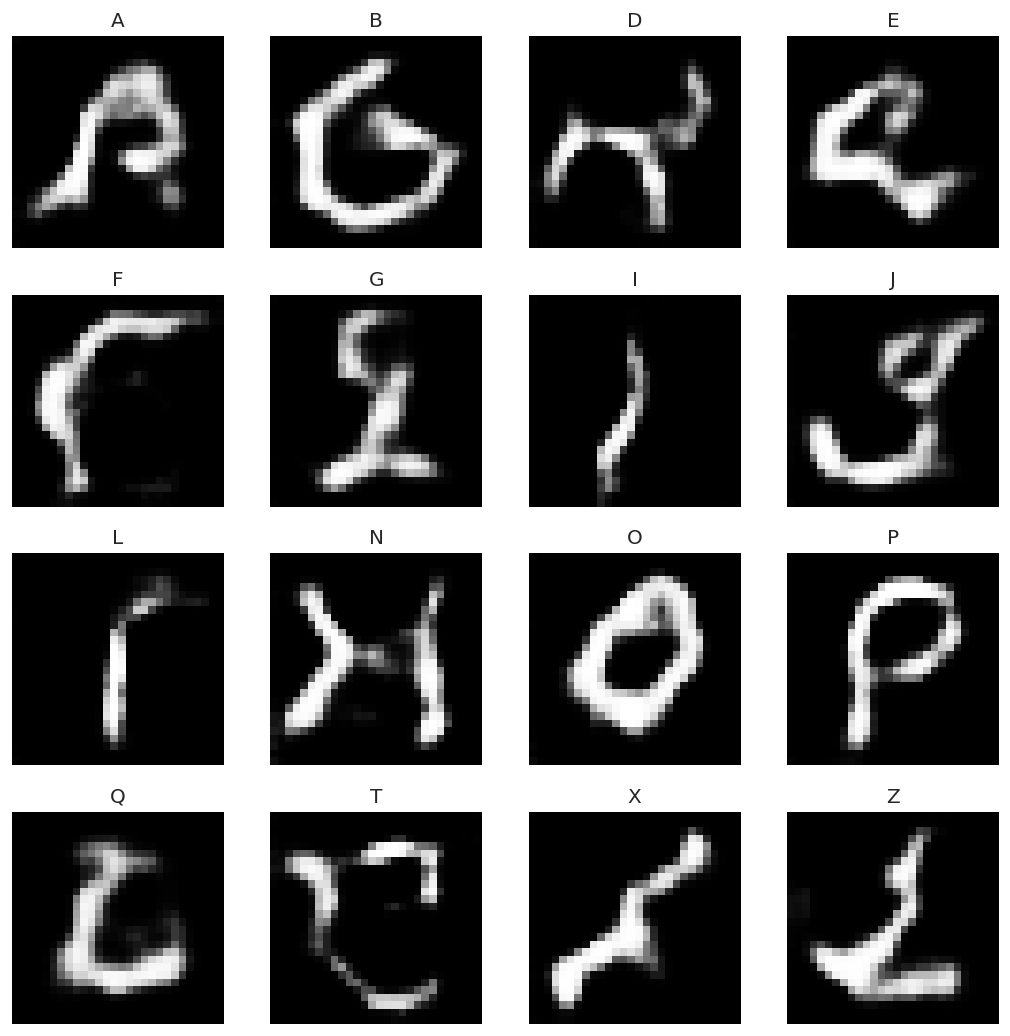

[CGAN] Epoch 015 | D: 1.2113 | G: 0.9391


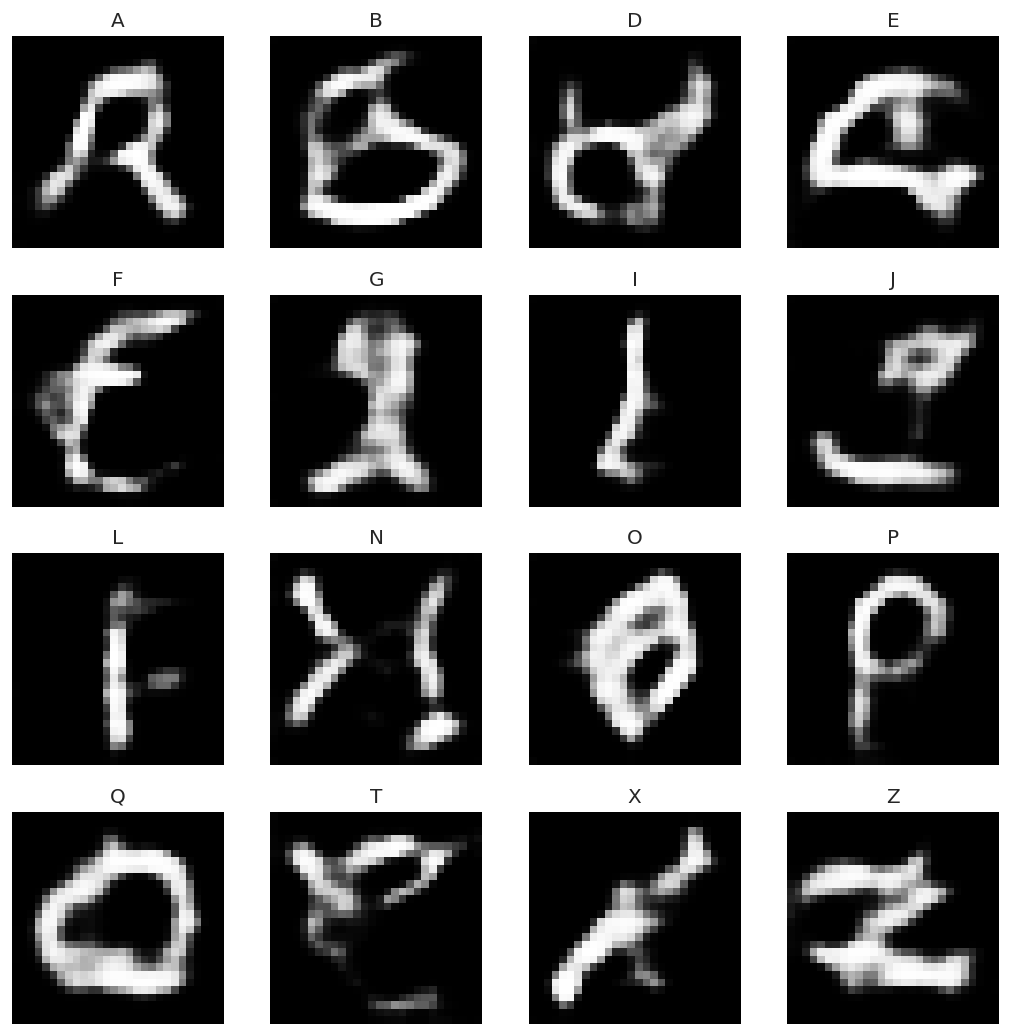

[CGAN] Epoch 020 | D: 1.1483 | G: 1.0160


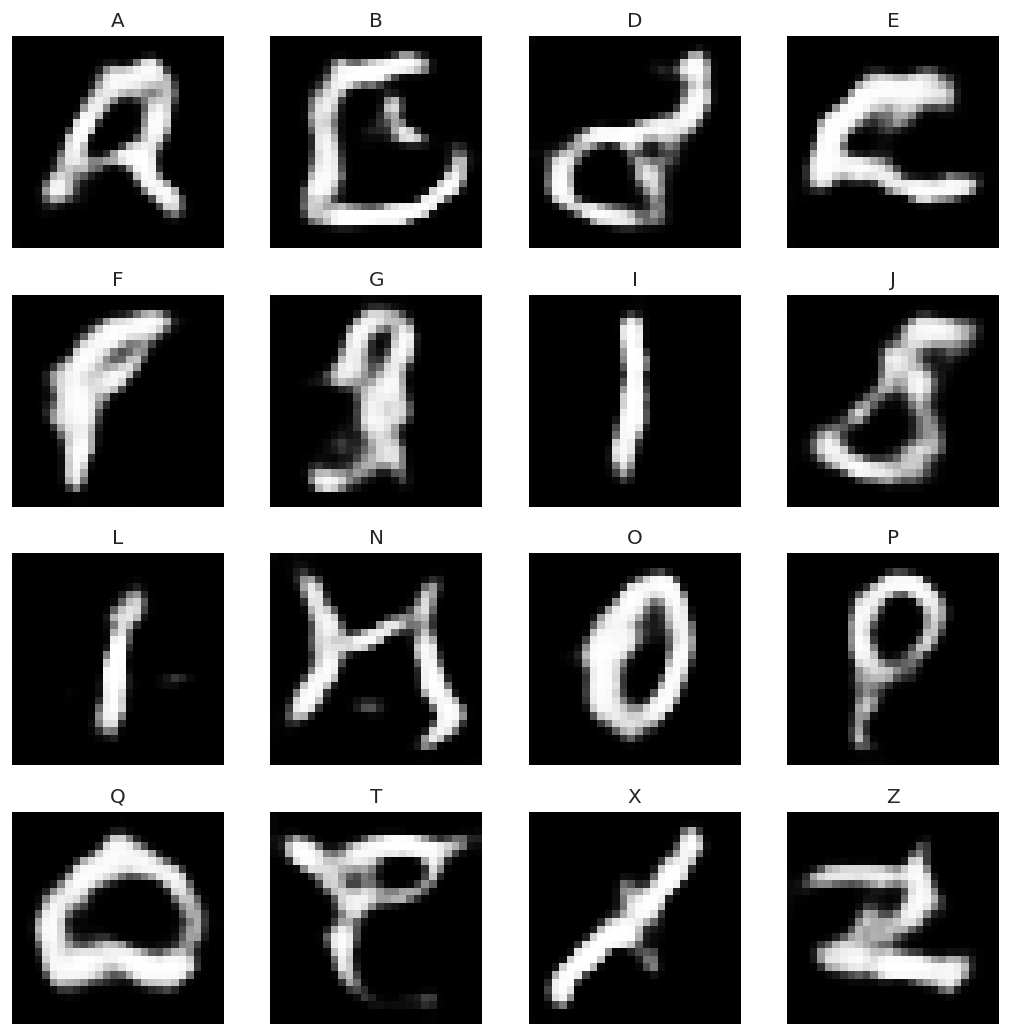

[CGAN] Epoch 025 | D: 1.0452 | G: 1.2054


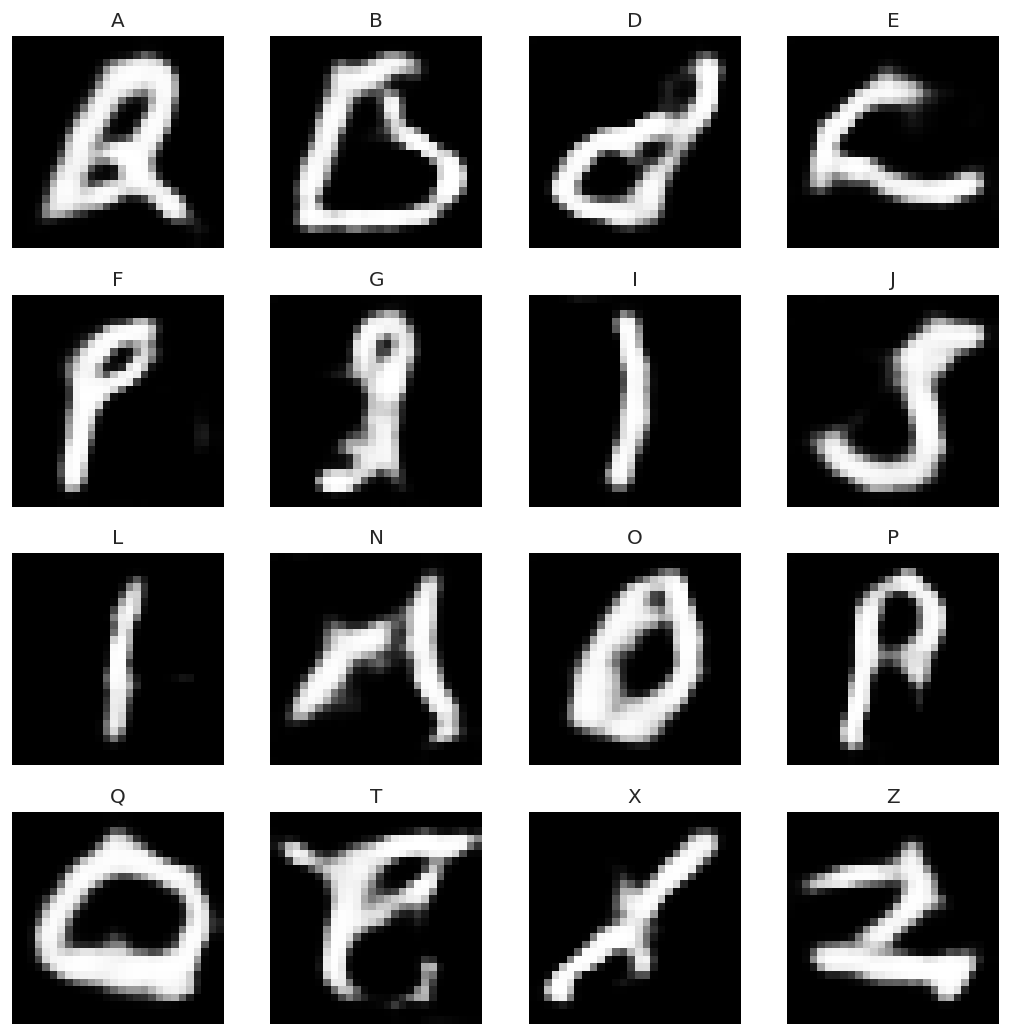

[CGAN] Epoch 030 | D: 1.0518 | G: 1.2082


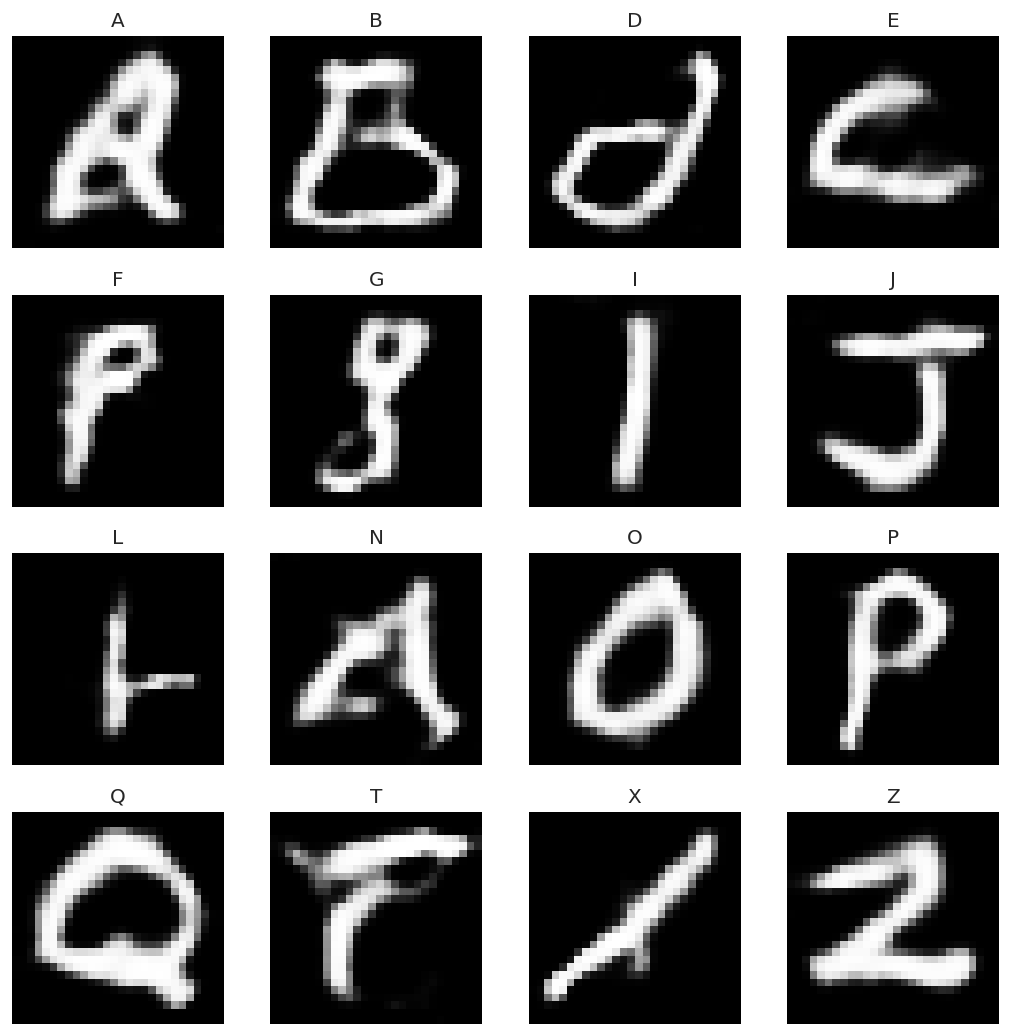

[CGAN] Epoch 035 | D: 1.0746 | G: 1.1726


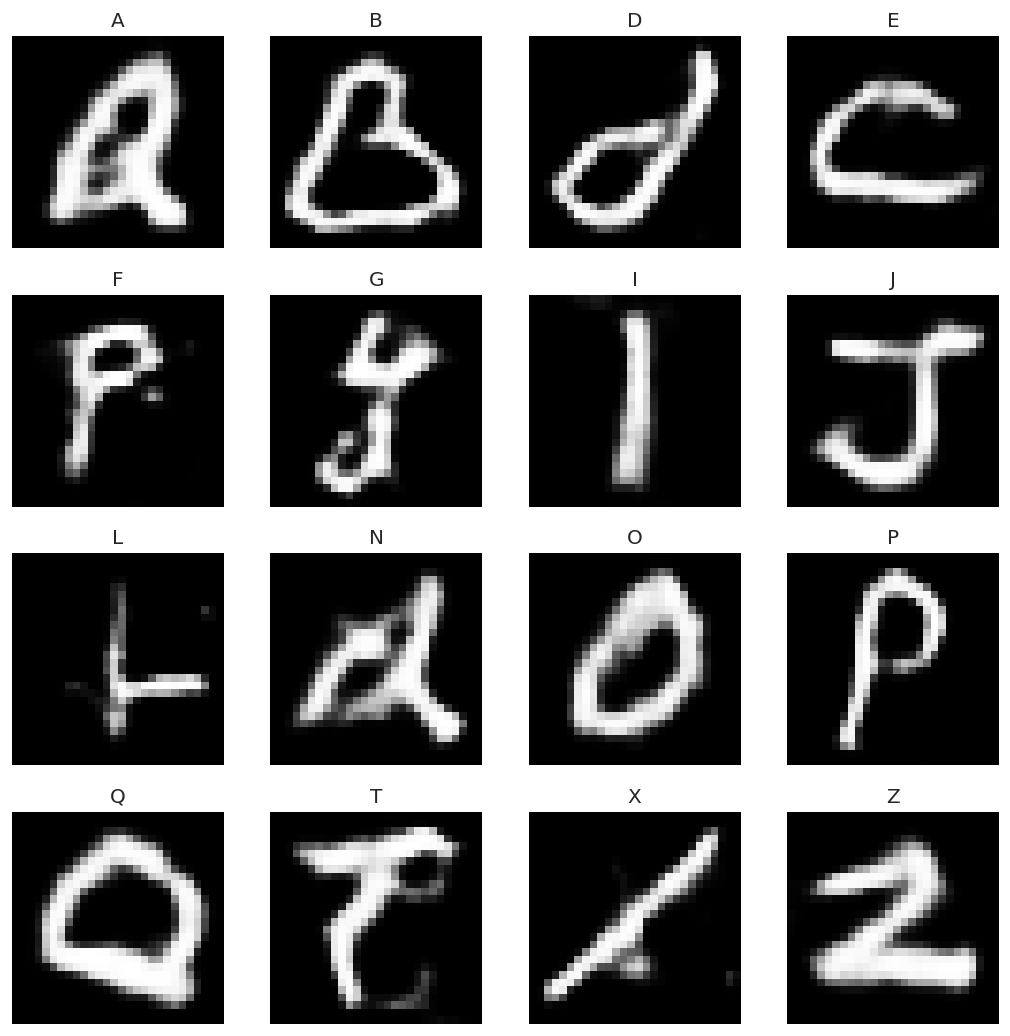

[CGAN] Epoch 040 | D: 1.0715 | G: 1.1677


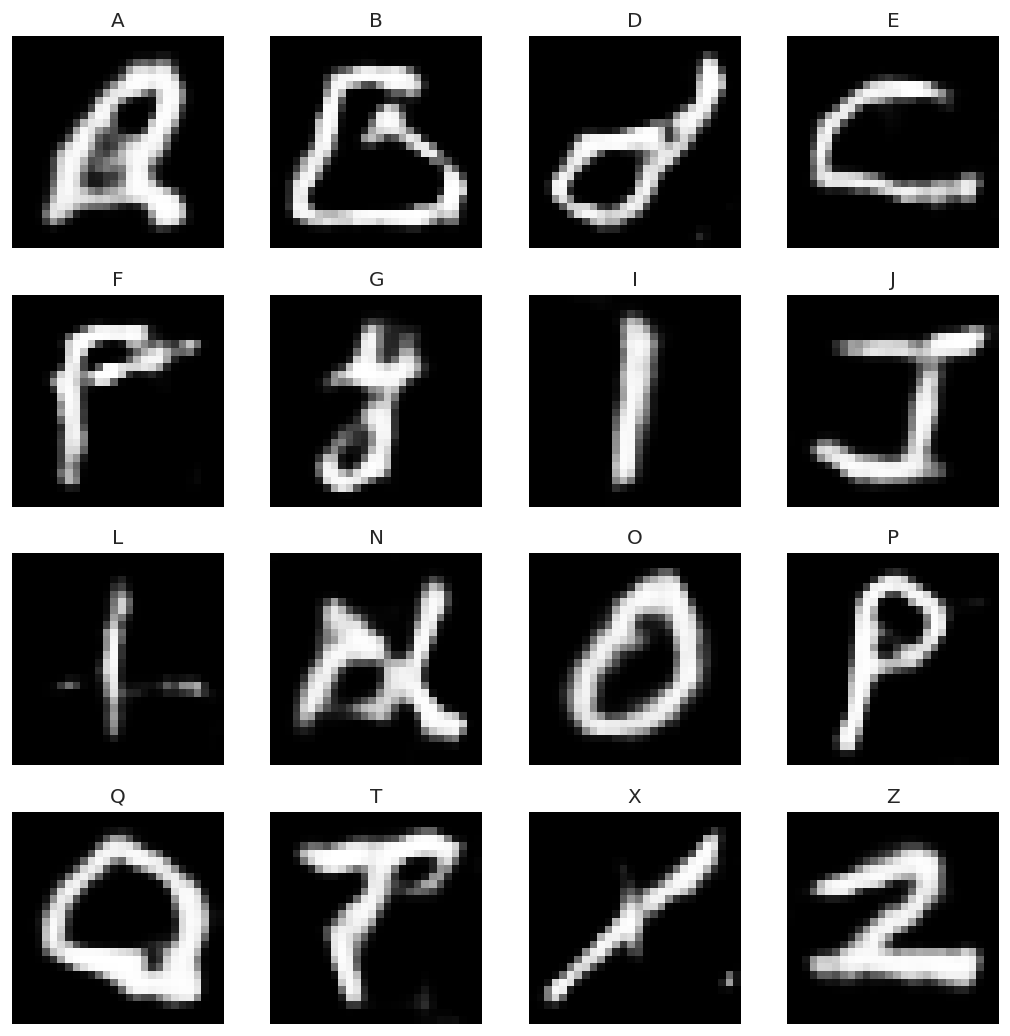

[CGAN] Epoch 045 | D: 1.0623 | G: 1.1784


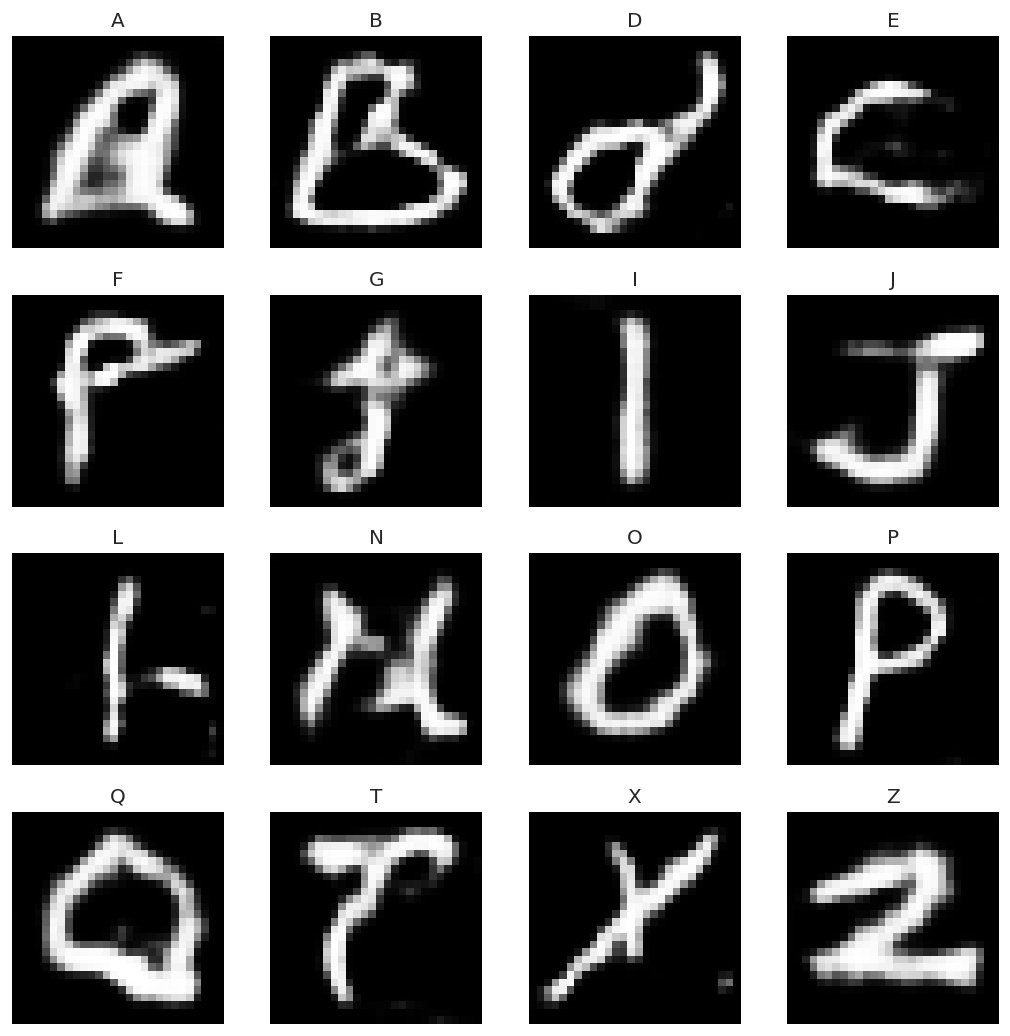

[CGAN] Epoch 050 | D: 1.0503 | G: 1.2044


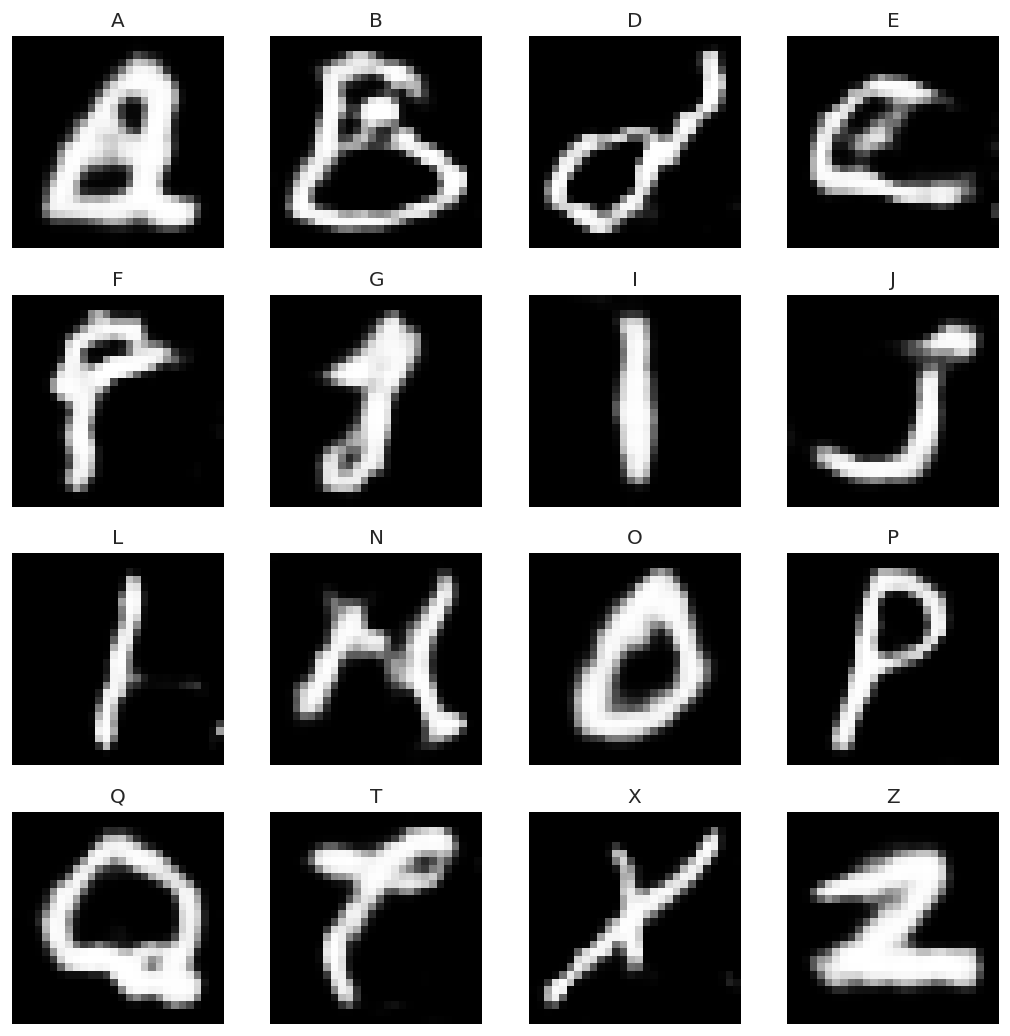

In [51]:
# === CGAN input pipeline & training ===
BATCH_SIZE_CGAN  = 256
BUFFER_SIZE_CGAN = len(X_train_cgan)
NUM_CLASSES_CGAN = len(classes_cgan)

def _to_tf_dtype(image, label):
    return (tf.cast(image, tf.float32), tf.cast(label, tf.int32))

train_dataset_cgan = (
    tf.data.Dataset.from_tensor_slices((X_train_cgan, y_train_cgan))
      .cache()  # cache raw tensors
      .shuffle(min(BUFFER_SIZE_CGAN, 10000), reshuffle_each_iteration=True)
      .map(_to_tf_dtype, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE_CGAN, drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE)
)

cgan = ConditionalGAN(
    img_shape=(28, 28, 1),
    latent_dim=100,
    num_classes=NUM_CLASSES_CGAN,
    embedding_dim=50,
    idx_to_letter=idx_to_letter
)

cgan.train(train_dataset_cgan, epochs=50, sample_interval=5)




### Evaluation of CGAN

metrics_cgan: {'FID': 26.680563569638217, 'IS_mean': 1.0001460313796997, 'IS_std': 4.903546141576953e-06, 'n_eval': 5000}


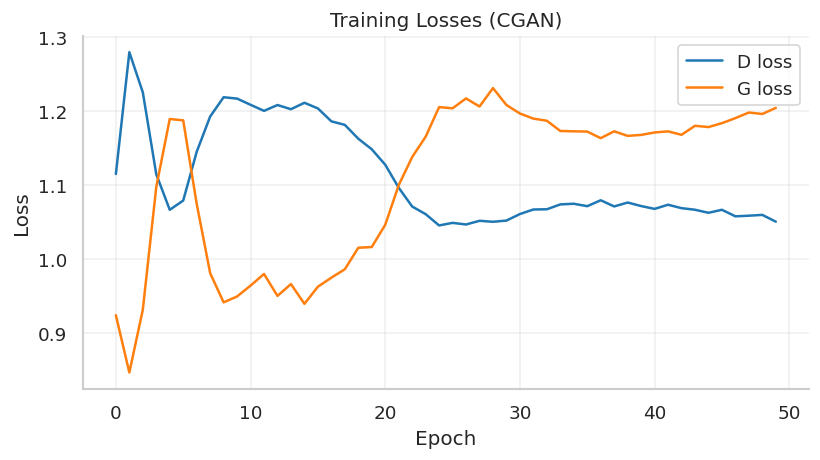

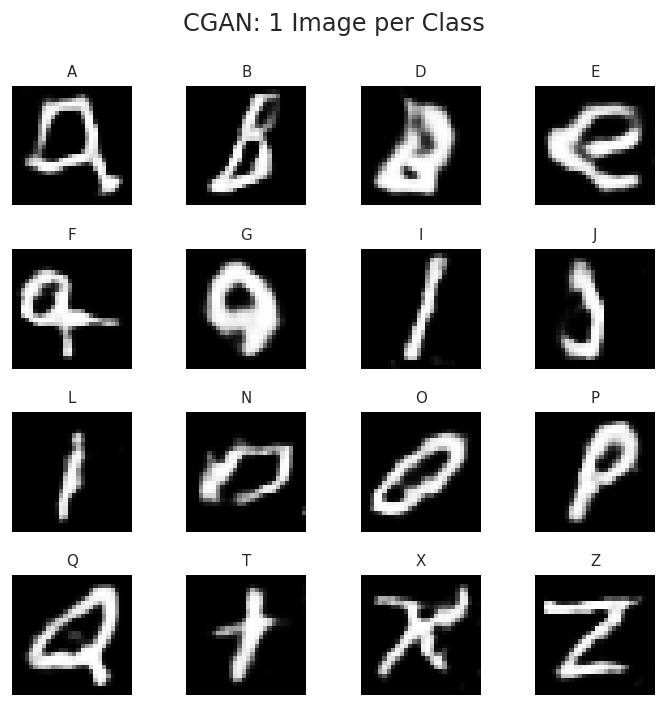

In [54]:
# === CGAN: Metrics (FID, IS), Loss Curves, 1 Image per Class ===
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# ---------- Metric helpers (define only if not already present) ----------
if 'calculate_fid' not in globals():
    def _resize_and_rgb(images):
        x = tf.image.resize(images, (299, 299))
        if x.shape[-1] == 1:
            x = tf.repeat(x, 3, axis=-1)
        return (x * 255.0).numpy()

    def _batched_predict(model, x, batch_size=256):
        outs, n = [], x.shape[0]
        for i in range(0, n, batch_size):
            outs.append(model.predict(x[i:i+batch_size], verbose=0))
        return np.concatenate(outs, axis=0)

    def calculate_fid(images1, images2, batch_size=256):
        x1 = _resize_and_rgb(images1); x2 = _resize_and_rgb(images2)
        feat_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_shape=(299,299,3))
        f1 = _batched_predict(feat_model, preprocess_input(x1), batch_size=batch_size)
        f2 = _batched_predict(feat_model, preprocess_input(x2), batch_size=batch_size)
        mu1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)
        mu2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
        ssdiff = np.sum((mu1 - mu2) ** 2.0)
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean): covmean = covmean.real
        return float(ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean))

if 'calculate_inception_score' not in globals():
    def calculate_inception_score(images, n_split=10, batch_size=256):
        x = _resize_and_rgb(images)
        clf = InceptionV3(include_top=True, weights='imagenet', input_shape=(299,299,3))
        preds = _batched_predict(clf, preprocess_input(x), batch_size=batch_size)
        preds = tf.nn.softmax(preds).numpy()
        splits = np.array_split(preds, n_split)
        scores = []
        for p in splits:
            py = np.mean(p, axis=0, keepdims=True)
            kl = p * (np.log(np.clip(p,1e-10,1.0)) - np.log(np.clip(py,1e-10,1.0)))
            kl = np.sum(kl, axis=1)
            scores.append(np.exp(np.mean(kl)))
        return float(np.mean(scores)), float(np.std(scores))

# ---------- Real & generated image helpers ----------
def sample_real_images(df, n):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    x = df.sample(n, random_state=42)[pix_cols].to_numpy(np.float32, copy=False)
    return (x.reshape(-1, 28, 28, 1) / 255.0).astype(np.float32)

def generate_images_for_metrics_cgan(model, labels):
    """labels: int array (N,) with class ids in [0, num_classes). Returns [0,1] images."""
    labels = np.asarray(labels, dtype=np.int32)
    z = tf.random.normal([len(labels), model.latent_dim])
    y = tf.convert_to_tensor(labels.reshape(-1, 1), dtype=tf.int32)
    g = model.generator([z, y], training=False).numpy()
    return ((g + 1.0) / 2.0).astype(np.float32)

# Helper to sample by class (since your class lacks a method)
def generate_specific_class_cgan(model, class_id, n=1):
    z = tf.random.normal([n, model.latent_dim])
    y = tf.constant([[class_id]] * n, dtype=tf.int32)
    g = model.generator([z, y], training=False).numpy()
    return ((g + 1.0) / 2.0).astype(np.float32)  # (n,28,28,1)

# ---------- Build eval sets ----------
N_EVAL = min(5000, len(processed_data), len(X_train_cgan))
real_images_cgan = sample_real_images(processed_data, N_EVAL)

# Match class distribution by sampling labels from training labels
rng = np.random.default_rng(42)
sampled_labels_cgan = rng.choice(y_train_cgan, size=N_EVAL, replace=True)
gen_images_cgan = generate_images_for_metrics_cgan(cgan, sampled_labels_cgan)

# ---------- Compute & store metrics ----------
fid_cgan = calculate_fid(real_images_cgan, gen_images_cgan)
is_mean_cgan, is_std_cgan = calculate_inception_score(gen_images_cgan)

metrics_cgan = {
    "FID": float(fid_cgan),
    "IS_mean": float(is_mean_cgan),
    "IS_std": float(is_std_cgan),
    "n_eval": int(N_EVAL)
}
print("metrics_cgan:", metrics_cgan)

# ---------- Plot training losses ----------
plt.figure(figsize=(7,4))
plt.plot(cgan.d_losses, label="D loss")
plt.plot(cgan.g_losses, label="G loss")
plt.title("Training Losses (CGAN)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# ---------- One image per class (4x4 grid for 16 classes) ----------
n_classes = len(classes_cgan)
assert n_classes == 16, f"Expected 16 classes, got {n_classes}"
per_class = []
for cid in range(n_classes):
    img = generate_specific_class_cgan(cgan, cid, n=1)[0, :, :, 0]
    per_class.append(img)

fig, axs = plt.subplots(4, 4, figsize=(6,6))
k = 0
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(per_class[k], cmap='gray', vmin=0, vmax=1)
        axs[i,j].set_title(idx_to_letter.get(k, str(k)), fontsize=9)
        axs[i,j].axis('off'); k += 1
plt.suptitle("CGAN: 1 Image per Class")
plt.tight_layout(); plt.show()




Observations
- **Early Phase**:
  - Discriminator is stronger (D loss drops significantly, G loss remains low).
  - Generator quickly learns label-conditioned cues.
- **Mid Phase (~15–22)**:
  - Losses converge, achieving a good balance. This is usually the sweet spot for sample quality.
- **Late Phase**:
  - G loss exceeds D loss and climbs slightly, indicating the discriminator is edging out the generator.
  - Risk of slight mode bias but no collapse.

Stability
- Smooth curves with minor oscillations suggest stable training.

Takeaways
- CGAN improves class consistency compared to DCGAN/BigGAN-lite runs.
- Sharpness of generated images still needs improvement.



Clear/Recognizable
- **E, I, J, L, O, P, T, X, Z**: Shapes are recognizable, though still blurry.

Confused/Ambiguous
- **A**: Resembles a loop.
- **B**: Appears messy.
- **D**: Looks B-like.
- **F**: Resembles a "q."
- **G/Q**: Both resemble "9/loop."
- **N**: Boxy and unclear.

Common Issues
- Blurred/soft strokes.
- Bias toward loop-like shapes.
- Inconsistent centering.

Verdict
- Conditioning improves class control over DCGAN/BigGAN-lite.
- Fidelity remains moderate, with some classes still ambiguous.

## WGAN - GP

**Conditional WGAN-GP (CWGAN-GP)**

**Structure:**  
- An extension of Wasserstein GAN with Gradient Penalty (WGAN-GP) to the class-conditional setting.
- Uses Wasserstein loss instead of binary cross-entropy for smoother, more informative gradients.
- Applies a gradient penalty to enforce the Lipschitz constraint and stabilize training.
- Embeds class labels and combines them with the latent vector or input image for conditional generation.

**Why it works here:**  
- Addresses common GAN issues like mode collapse and unstable training.
- Encourages a closer match between real and generated data distributions.
- Provides stable updates, especially in the early stages of training.
- Better handles small datasets by preventing vanishing gradients.

**Role in this problem:**  
- Enables robust and stable training when generating class-specific handwritten letters, especially when letter shapes are similar.

### Data Processing for WGAN-GP

In [ ]:
# ---- build arrays for WGAN ----
def to_arrays_for_wgan(df, label_col="label"):
    # pixel columns
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    X = df[pix_cols].values.astype(np.float32).reshape(-1, 28, 28, 1)  # [N,28,28,1]
    X = (X - 127.5) / 127.5  # [-1,1]
    # encode letters -> [0..C-1]
    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(letters)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, letters, l2i, i2l

X_train_wgan, y_train_wgan, classes_wgan, l2i_wgan, i2l_wgan = to_arrays_for_wgan(rotated_data, label_col="label")

# ---- tf.data pipeline ----
BATCH_SIZE_WGAN  = 256
BUFFER_SIZE_WGAN = len(X_train_wgan)

def _cast_pair(x, y):
    return (tf.cast(x, tf.float32), tf.cast(y, tf.int32))

train_dataset_wgan = (tf.data.Dataset
    .from_tensor_slices((X_train_wgan, y_train_wgan))
    .shuffle(min(BUFFER_SIZE_WGAN, 10000))
    .map(_cast_pair, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE_WGAN, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE))

len(classes_wgan), X_train_wgan.shape

### Define WGAN-GP Architecture

In [70]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import numpy as np

class CWGANGP:
    def __init__(self,
                 img_shape=(28,28,1),
                 latent_dim=128,
                 num_classes=16,
                 embedding_dim=64,
                 gp_weight=10.0,
                 n_critic=5,
                 # TTUR: slightly higher LR for G
                 lr_g=2e-4, lr_c=1e-4, beta1=0.0, beta2=0.9,
                 ema_decay=0.999,
                 idx_to_letter=None):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.gp_weight = gp_weight
        self.n_critic = n_critic
        self.idx_to_letter = idx_to_letter or {}
        self.ema_decay = ema_decay

        self.generator = self.build_generator()
        self.critic    = self.build_critic()  # projection D

        # TTUR optimizers
        self.g_opt = optimizers.Adam(lr_g, beta_1=beta1, beta_2=beta2)
        self.c_opt = optimizers.Adam(lr_c, beta_1=beta1, beta_2=beta2)

        # Exponential moving average (EMA) of G for sampling
        self.generator_ema = tf.keras.models.clone_model(self.generator)
        self.generator_ema.set_weights(self.generator.get_weights())

        self.c_scores, self.g_scores = [], []

    # --------- Generator: z || emb(y) ----------
    def build_generator(self):
        z_in = layers.Input(shape=(self.latent_dim,))
        y_in = layers.Input(shape=(1,), dtype='int32')

        y_vec = layers.Embedding(self.num_classes, self.embedding_dim)(y_in)
        y_vec = layers.Flatten()(y_vec)
        zcat  = layers.Concatenate()([z_in, y_vec])

        x = layers.Dense(7*7*256, use_bias=False, kernel_initializer="he_normal")(zcat)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)
        x = layers.Reshape((7,7,256))(x)

        x = layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False, kernel_initializer="he_normal")(x)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False, kernel_initializer="he_normal")(x)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)

        out = layers.Conv2DTranspose(1, 5, strides=1, padding='same', use_bias=False,
                                     activation='tanh', kernel_initializer="glorot_uniform")(x)
        return tf.keras.Model([z_in, y_in], out, name="wgan_g")

    # --------- Projection Critic: D(x,y) = h(x)·e(y) + wᵀh(x) ----------
    def build_critic(self):
        x_in = layers.Input(shape=self.img_shape)
        y_in = layers.Input(shape=(1,), dtype='int32')

        x = layers.Conv2D(64, 5, strides=2, padding='same', kernel_initializer="he_normal")(x_in)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2D(128, 5, strides=2, padding='same', kernel_initializer="he_normal")(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2D(256, 5, strides=2, padding='same', kernel_initializer="he_normal")(x)
        x = layers.LeakyReLU()(x)

        x = layers.ReLU()(x)
        h = layers.GlobalAveragePooling2D()(x)              # (B,C)
        base = layers.Dense(1)(h)                           # wᵀh(x)
        emb  = layers.Embedding(self.num_classes, h.shape[-1])(y_in)
        emb  = layers.Flatten()(emb)                        # e(y)
        proj = layers.Dot(axes=1)([h, emb])[:, None]        # h·e(y)
        out  = layers.Add()([base, proj])                   # scalar
        return tf.keras.Model([x_in, y_in], out, name="wgan_projD")

    # --------- Gradient penalty (label-aligned) ----------
    def gradient_penalty(self, real_imgs, fake_imgs, y_2d):
        eps   = tf.random.uniform([tf.shape(real_imgs)[0], 1, 1, 1], 0.0, 1.0)
        inter = eps * real_imgs + (1.0 - eps) * fake_imgs
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(inter)
            pred = self.critic([inter, y_2d], training=True)
        grads = gp_tape.gradient(pred, inter)
        norm  = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]) + 1e-12)
        return tf.reduce_mean((norm - 1.0) ** 2)

    # --------- EMA update ----------
    @tf.function
    def _update_ema(self):
        decay = tf.constant(self.ema_decay, dtype=tf.float32)
        for w_ema, w in zip(self.generator_ema.weights, self.generator.weights):
            w_ema.assign(decay * w_ema + (1.0 - decay) * w)

    # --------- One training step (label-aligned) ----------
    @tf.function
    def train_step(self, real_imgs, real_labels):
        bsz = tf.shape(real_imgs)[0]
        y_real_2d = tf.expand_dims(tf.cast(real_labels, tf.int32), 1)

        # --- Critic updates ---
        c_loss_total = 0.0
        for _ in tf.range(self.n_critic):
            z = tf.random.normal([bsz, self.latent_dim])
            y_gen = y_real_2d  # align labels with real batch

            with tf.GradientTape() as c_tape:
                fake        = self.generator([z, y_gen], training=True)
                real_scores = self.critic([real_imgs, y_real_2d], training=True)
                fake_scores = self.critic([fake,      y_gen],    training=True)

                wgan  = tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores)
                gp    = self.gradient_penalty(real_imgs, fake, y_real_2d)
                c_loss = wgan + self.gp_weight * gp

            c_grads = c_tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_opt.apply_gradients(zip(c_grads, self.critic.trainable_variables))
            c_loss_total += c_loss

        c_loss_mean = c_loss_total / tf.cast(self.n_critic, tf.float32)

        # --- Generator update ---
        z = tf.random.normal([bsz, self.latent_dim])
        y_gen = y_real_2d
        with tf.GradientTape() as g_tape:
            fake        = self.generator([z, y_gen], training=True)
            fake_scores = self.critic([fake, y_gen], training=True)
            g_loss      = -tf.reduce_mean(fake_scores)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        # EMA after each G step
        self._update_ema()

        return c_loss_mean, g_loss

    # --------- Train loop ----------
    def train(self, dataset, epochs=30, sample_interval=5):
        for ep in range(1, epochs+1):
            c_sum = g_sum = 0.0; n=0
            for imgs, lbls in dataset:
                c_l, g_l = self.train_step(imgs, lbls)
                c_sum += float(c_l); g_sum += float(g_l); n += 1
            self.c_scores.append(c_sum/max(n,1)); self.g_scores.append(g_sum/max(n,1))
            if ep % sample_interval == 0 or ep == 1:
                print(f"[cWGAN-GP+Proj+EMA] Epoch {ep:03d} | Critic={self.c_scores[-1]:.4f} | Gen={self.g_scores[-1]:.4f}")

    # --------- Sampling (uses EMA by default) ----------
    def _gen_for_sampling(self):
        return self.generator_ema if self.ema_decay is not None else self.generator

    def generate_specific_class(self, class_id, n=10):
        z = tf.random.normal([n, self.latent_dim])
        y = tf.constant([[class_id]] * n, dtype=tf.int32)
        g = self._gen_for_sampling()([z, y], training=False)
        return ((g + 1.0)/2.0).numpy()  # [0,1]


### Train WGAN-GP

In [71]:
wgan = CWGANGP(
    img_shape=(28,28,1),
    latent_dim=128,
    num_classes=len(classes_wgan),
    embedding_dim=64,
    gp_weight=10.0,
    n_critic=5,
    lr_g=2e-4, lr_c=1e-4,  # TTUR
    beta1=0.0, beta2=0.9,
    ema_decay=0.999,
    idx_to_letter=i2l_wgan
)
wgan.train(train_dataset_wgan, epochs=40, sample_interval=5)



[cWGAN-GP+Proj+EMA] Epoch 001 | Critic=-6.3251 | Gen=-1.5984
[cWGAN-GP+Proj+EMA] Epoch 005 | Critic=-3.9043 | Gen=-0.6372
[cWGAN-GP+Proj+EMA] Epoch 010 | Critic=-3.4981 | Gen=0.1343
[cWGAN-GP+Proj+EMA] Epoch 015 | Critic=-3.1543 | Gen=-0.2601
[cWGAN-GP+Proj+EMA] Epoch 020 | Critic=-2.7542 | Gen=-1.0519
[cWGAN-GP+Proj+EMA] Epoch 025 | Critic=-2.4339 | Gen=-1.3695
[cWGAN-GP+Proj+EMA] Epoch 030 | Critic=-2.2412 | Gen=-1.3919
[cWGAN-GP+Proj+EMA] Epoch 035 | Critic=-2.1012 | Gen=-1.3696
[cWGAN-GP+Proj+EMA] Epoch 040 | Critic=-1.9855 | Gen=-1.7159


### Evaluation of WGAN-GP

metrics_wgan_test: {'FID': 21.70796381274707, 'IS_mean': 1.000128984451294, 'IS_std': 4.1482435335638e-06, 'n_eval': 5000}


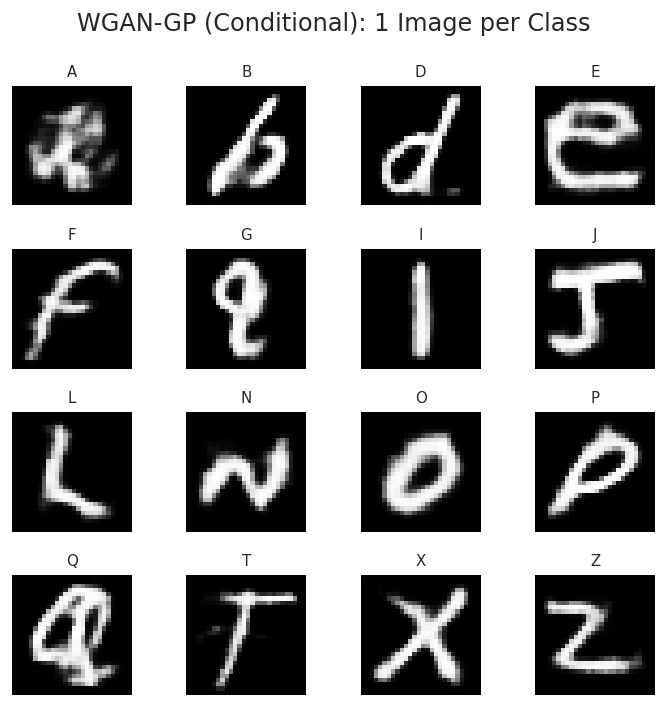

In [72]:
# === WGAN-GP: Metrics (FID, IS) + 1 Image per Class ===
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# ---------- Metric helpers (reuse if already defined) ----------
if 'calculate_fid' not in globals():
    def _resize_and_rgb(images):
        x = tf.image.resize(images, (299, 299))
        if x.shape[-1] == 1:
            x = tf.repeat(x, 3, axis=-1)
        return (x * 255.0).numpy()

    def _batched_predict(model, x, batch_size=256):
        outs, n = [], x.shape[0]
        for i in range(0, n, batch_size):
            outs.append(model.predict(x[i:i+batch_size], verbose=0))
        return np.concatenate(outs, axis=0)

    def calculate_fid(images1, images2, batch_size=256):
        x1 = _resize_and_rgb(images1); x2 = _resize_and_rgb(images2)
        feat_model = InceptionV3(include_top=False, weights='imagenet',
                                 pooling='avg', input_shape=(299,299,3))
        f1 = _batched_predict(feat_model, preprocess_input(x1), batch_size=batch_size)
        f2 = _batched_predict(feat_model, preprocess_input(x2), batch_size=batch_size)
        mu1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)
        mu2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
        ssdiff = np.sum((mu1 - mu2) ** 2.0)
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean): covmean = covmean.real
        return float(ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean))

if 'calculate_inception_score' not in globals():
    def calculate_inception_score(images, n_split=10, batch_size=256):
        x = _resize_and_rgb(images)
        clf = InceptionV3(include_top=True, weights='imagenet',
                          input_shape=(299,299,3))
        preds = _batched_predict(clf, preprocess_input(x), batch_size=batch_size)
        preds = tf.nn.softmax(preds).numpy()
        splits = np.array_split(preds, n_split)
        scores = []
        for p in splits:
            py = np.mean(p, axis=0, keepdims=True)
            kl = p * (np.log(np.clip(p,1e-10,1.0)) - np.log(np.clip(py,1e-10,1.0)))
            kl = np.sum(kl, axis=1)
            scores.append(np.exp(np.mean(kl)))
        return float(np.mean(scores)), float(np.std(scores))

# ---------- Real & generated image helpers ----------
def sample_real_images(df, n):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    x = df.sample(n, random_state=42)[pix_cols].to_numpy(np.float32, copy=False)
    return (x.reshape(-1, 28, 28, 1) / 255.0).astype(np.float32)

def generate_images_for_metrics_wgan(model, labels):
    labels = np.asarray(labels, dtype=np.int32)
    z = tf.random.normal([len(labels), model.latent_dim])
    y = tf.convert_to_tensor(labels.reshape(-1, 1), dtype=tf.int32)
    g = model.generator([z, y], training=False).numpy()
    return ((g + 1.0) / 2.0).astype(np.float32)

# ---------- Build eval sets ----------
N_EVAL = min(5000, len(processed_data), len(X_train_wgan))
real_images_wgan = sample_real_images(processed_data, N_EVAL)

rng = np.random.default_rng(42)
sampled_labels_wgan = rng.choice(y_train_wgan, size=N_EVAL, replace=True)
gen_images_wgan = generate_images_for_metrics_wgan(wgan, sampled_labels_wgan)

# ---------- Compute & store metrics ----------
fid_wgan = calculate_fid(real_images_wgan, gen_images_wgan)
is_mean_wgan, is_std_wgan = calculate_inception_score(gen_images_wgan)

metrics_wgan_test = {
    "FID": float(fid_wgan),
    "IS_mean": float(is_mean_wgan),
    "IS_std": float(is_std_wgan),
    "n_eval": int(N_EVAL)
}
print("metrics_wgan_test:", metrics_wgan_test)

# ---------- One image per class (4x4 grid for 16 classes) ----------
n_classes = len(classes_wgan)
assert n_classes == 16, f"Expected 16 classes, got {n_classes}"
per_class = []
for cid in range(n_classes):
    img = wgan.generate_specific_class(cid, n=1)[0, :, :, 0]  # [0,1], (28,28)
    per_class.append(img)

fig, axs = plt.subplots(4, 4, figsize=(6,6))
k = 0
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(per_class[k], cmap='gray', vmin=0, vmax=1)
        axs[i,j].set_title(i2l_wgan.get(k, str(k)), fontsize=9)
        axs[i,j].axis('off'); k += 1
plt.suptitle("WGAN-GP (Conditional): 1 Image per Class")
plt.tight_layout(); plt.show()




Clear/Strong
- **I, J, L, O, P, T, X, Z, E, F**: Improved strokes and better centering compared to previous runs.

Still Confused
- **A**: Messy.
- **B**: Resembles “b/6.”
- **D**: Looks like a lowercase “d.”
- **G & Q**: Both resemble “9/q.”
- **N**: Wavy and ambiguous.

Verdict
- Best performance so far: Sharper and more class-consistent than DCGAN, CGAN, and BigGAN-lite.
- Some loop-based letters remain ambiguous.

# Improvements of GAN performance

## Comparison metrics of different GAN models

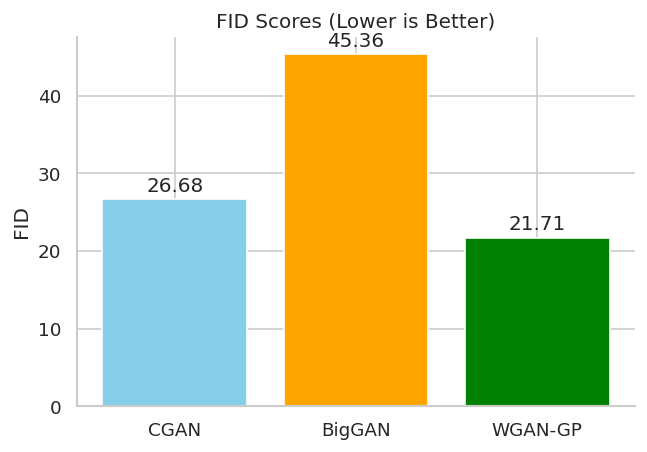

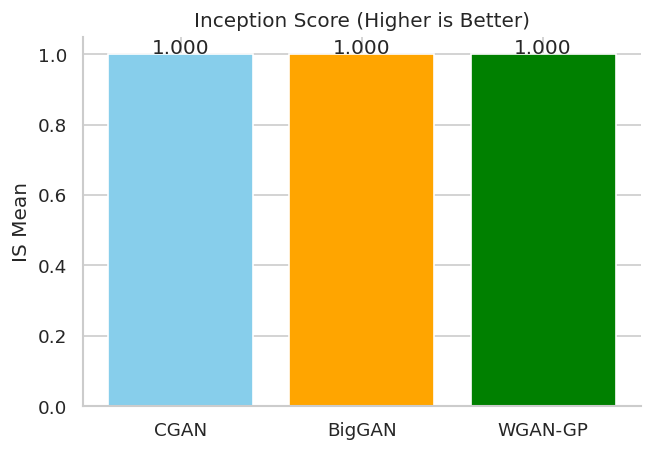

In [73]:
import matplotlib.pyplot as plt



# Prepare data
models = ["CGAN", "BigGAN", "WGAN-GP"]
fid_scores = [
    metrics_cgan["FID"],
    metrics_biggan["FID"],
    metrics_wgan_test["FID"]
]
is_means = [
    metrics_cgan["IS_mean"],
    metrics_biggan["IS_mean"],
    metrics_wgan_test["IS_mean"]
]

# --- Plot FID ---
plt.figure(figsize=(6,4))
plt.bar(models, fid_scores, color=["skyblue", "orange", "green"])
plt.title("FID Scores (Lower is Better)")
plt.ylabel("FID")
for i, v in enumerate(fid_scores):
    plt.text(i, v + 1, f"{v:.2f}", ha='center')
plt.show()

# --- Plot IS ---
plt.figure(figsize=(6,4))
plt.bar(models, is_means, color=["skyblue", "orange", "green"])
plt.title("Inception Score (Higher is Better)")
plt.ylabel("IS Mean")
for i, v in enumerate(is_means):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center')
plt.show()




Metrics
- **FID (↓)**: WGAN-GP 21.71 < CGAN 26.68 < BigGAN-Lite 45.36  
  → WGAN-GP outperforms CGAN by ~18.6% and BigGAN-Lite by ~52%.
- **Inception Score (↑)**: All models ≈ 1.00 → effectively a tie.

What This Means
- **Trust FID, Not IS**: For small, grayscale data (e.g., 28×28 letters), the ImageNet classifier used for IS is confused, leading to near-uniform class probabilities. This results in IS ≈ 1.0 regardless of the model.
- **Why WGAN-GP Wins**: Wasserstein loss with gradient penalty stabilizes training and minimizes mode collapse, especially at low resolution and small batch sizes.
- **Why CGAN is Close but 2nd**: Label conditioning helps separate look-alike classes, but without large capacity or batch sizes, it can't surpass WGAN-GP’s stability.
- **Why BigGAN-Lite Lags**: BigGAN variants require high-resolution data, large batches, and long training schedules to perform well. Without these, they become over-parameterized for this setup.

## What We Should Do Next
- **Model**: Transition to a Conditional WGAN-GP (e.g., using label embeddings with projection or an auxiliary-classifier critic).
- **Training Adjustments**:
  - Use `n_critic ≈ 5`.
  - Apply TTUR (lower learning rate for the generator than the discriminator).
  - Set gradient penalty `λ ≈ 10`.
  - Consider adding spectral normalization to the discriminator.
- **Evaluation**:
  - Keep FID as a primary metric.
  - Add KID (Kernel Inception Distance) and Precision/Recall for GANs.
  - For an IS-like metric, train a small classifier on our dataset instead of relying on ImageNet.
- **Data Hygiene**:
  - Generate the same number of samples per model.
  - Ensure balanced per-class sampling.
  - Use simple augmentations (shifts/flips) if allowed.

## Bottom Line
For our data and compute setup:
- **WGAN-GP** is the best baseline.
- **CGAN** is a strong runner-up.
- **BigGAN-Lite** is not suitable for this use case.

## Hyperparameter tuning for Best Model

### Model Implementation

In [74]:
# ======================= WGAN-GP (cWGAN-GP + TTUR + EMA) Hyperparameter Tuning =======================
import os, json, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# ---------- 0) (Optional) Mount Drive & set output dirs ----------
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

BASE_DIR          = "/content/drive/MyDrive/CGAN"
FINAL_DIR         = os.path.join(BASE_DIR, "tuned_wgan_final")       # final best output here
PREVIEWS_DIR      = os.path.join(FINAL_DIR, "previews")              # previews across trials/epochs
os.makedirs(PREVIEWS_DIR, exist_ok=True)

# ---------- 1) FID helpers (fast-ish for trend checking) ----------
def _prep_for_inception(imgs_01):
    """
    imgs_01: float32 [N,H,W,1] in [0,1]
    Returns [N,75,75,3] preprocessed for InceptionV3 (good enough for relative FID).
    """
    x = tf.convert_to_tensor(imgs_01, dtype=tf.float32)
    x = tf.image.resize(x, (75, 75))
    x = tf.image.grayscale_to_rgb(x)
    x = preprocess_input(x * 255.0)
    return x

_inception_model = None
def _get_inception():
    global _inception_model
    if _inception_model is None:
        _inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
    return _inception_model

def calculate_fid(real_imgs_01, fake_imgs_01):
    """
    real_imgs_01, fake_imgs_01: [N,H,W,1] in [0,1]
    """
    model = _get_inception()
    a = model.predict(_prep_for_inception(real_imgs_01), verbose=0)
    b = model.predict(_prep_for_inception(fake_imgs_01),  verbose=0)
    mu1, mu2 = a.mean(axis=0), b.mean(axis=0)
    s1,  s2  = np.cov(a, rowvar=False), np.cov(b, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(s1.dot(s2))
    if np.iscomplexobj(covmean): covmean = covmean.real
    fid = float(diff @ diff + np.trace(s1 + s2 - 2.0 * covmean))
    return fid

# ---------- 2) Sampling & saving ----------
def _gen_for_sampling(wgan):
    # use EMA generator if available
    return getattr(wgan, "generator_ema", wgan.generator)

def sample_generated_wgan(wgan, n):
    z = tf.random.normal([n, wgan.latent_dim])
    y = tf.random.uniform([n, 1], minval=0, maxval=wgan.num_classes, dtype=tf.int32)
    g = _gen_for_sampling(wgan)([z, y], training=False)
    return ((g + 1.0) / 2.0).numpy()

def save_160_by_class_wgan(wgan, out_dir):
    """Save 10 images per class as PNGs using EMA generator."""
    from PIL import Image
    os.makedirs(out_dir, exist_ok=True)
    G = _gen_for_sampling(wgan)
    for cls in range(wgan.num_classes):
        z = tf.random.normal([10, wgan.latent_dim])
        y = tf.constant([[cls]] * 10, dtype=tf.int32)
        imgs = G([z, y], training=False).numpy()
        imgs = ((imgs + 1.0) * 127.5).clip(0,255).astype(np.uint8)
        for i in range(10):
            Image.fromarray(imgs[i,:,:,0], mode="L").save(os.path.join(out_dir, f"{cls:02d}_{i:02d}.png"))

def preview_grid(wgan, path_png, n=25):
    G = _gen_for_sampling(wgan)
    z = tf.random.normal([n, wgan.latent_dim])
    y = tf.constant([[i % wgan.num_classes] for i in range(n)], dtype=tf.int32)
    g = (G([z, y], training=False) + 1.0) / 2.0
    g = g.numpy()
    r = int(np.sqrt(n)); c = int(np.ceil(n/r))
    fig, axs = plt.subplots(r, c, figsize=(2*c,2*r))
    k=0
    for i in range(r):
        for j in range(c):
            if k < n:
                axs[i,j].imshow(g[k,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                k+=1
    plt.tight_layout()
    plt.savefig(path_png, dpi=140); plt.close(fig)

# ---------- 3) Single experiment (train + eval FID) ----------
def run_experiment_wgan(config,
                        train_ds,
                        X_real,                   # [-1,1]
                        n_epochs=20,
                        eval_samples=512,
                        sample_interval=5,
                        save_preview=True):
    """
    config keys (forwarded to CWGANGP):
      - latent_dim, embedding_dim, gp_weight, n_critic, lr_g, lr_c, beta1, beta2, ema_decay
    """
    tf.keras.backend.clear_session()

    # peel off name
    cfg  = dict(config)
    name = cfg.pop("name", "cfg")

    # Build model (uses your CWGANGP with TTUR + EMA)
    wgan = CWGANGP(
        img_shape=(28,28,1),
        num_classes=len(classes_wgan),
        idx_to_letter=i2l_wgan,
        **cfg
    )

    # Train
    for ep in range(1, n_epochs+1):
        c_sum = g_sum = 0.0; n=0
        for imgs, lbls in train_ds:
            c_l, g_l = wgan.train_step(imgs, lbls)
            c_sum += float(c_l); g_sum += float(g_l); n += 1
        wgan.c_scores.append(c_sum/max(n,1))
        wgan.g_scores.append(g_sum/max(n,1))

        if ep % sample_interval == 0 or ep == 1:
            print(f"[{name}] Epoch {ep:03d} | Critic={wgan.c_scores[-1]:.4f} | Gen={wgan.g_scores[-1]:.4f}")
            if save_preview:
                preview_grid(wgan, os.path.join(PREVIEWS_DIR, f"{name}_ep{ep:03d}.png"), n=25)

    # Evaluate FID
    take = min(eval_samples, len(X_real))
    idx  = np.random.choice(len(X_real), take, replace=False)
    real01 = ((X_real[idx] + 1.0) / 2.0).astype(np.float32)
    fake01 = sample_generated_wgan(wgan, n=take)
    fid = calculate_fid(real01, fake01)

    return {"name": name, "config": config, "wgan": wgan, "FID": fid}

# ---------- 4) Define a small search space (TTUR + EMA variants) ----------
search_space = [
    {"name":"A_ld128_emb64_nc3_lrG2e-4_lrC1e-4_gp10_ema999",
     "latent_dim":128, "embedding_dim":64, "n_critic":3,
     "lr_g":2e-4, "lr_c":1e-4, "beta1":0.0, "beta2":0.9,
     "gp_weight":10.0, "ema_decay":0.999},
    {"name":"B_ld128_emb96_nc3_lrG2e-4_lrC1e-4_gp10_ema9995",
     "latent_dim":128, "embedding_dim":96, "n_critic":3,
     "lr_g":2e-4, "lr_c":1e-4, "beta1":0.0, "beta2":0.9,
     "gp_weight":10.0, "ema_decay":0.9995},
    {"name":"C_ld100_emb96_nc5_lrG1.6e-4_lrC8e-5_gp10_ema999",
     "latent_dim":100, "embedding_dim":96, "n_critic":5,
     "lr_g":1.6e-4, "lr_c":8e-5, "beta1":0.0, "beta2":0.9,
     "gp_weight":10.0, "ema_decay":0.999},
    {"name":"D_ld128_emb64_nc5_lrG1.6e-4_lrC8e-5_gp5_ema9995",
     "latent_dim":128, "embedding_dim":64, "n_critic":5,
     "lr_g":1.6e-4, "lr_c":8e-5, "beta1":0.0, "beta2":0.9,
     "gp_weight":5.0, "ema_decay":0.9995},
]

# ---------- 5) Run tuning ----------
results = []
for cfg in search_space:
    res = run_experiment_wgan(
        cfg,
        train_dataset_wgan,   # <== uses your existing dataset name
        X_train_wgan,         # [-1,1] array used to build real set for FID
        n_epochs=20,          # keep short for tuning; extend for your final run
        eval_samples=512,
        sample_interval=5,
        save_preview=True
    )
    print(f"==> {res['name']}: FID = {res['FID']:.2f}")
    results.append(res)

# ---------- 6) Pick best by FID, save artifacts to tuned_wgan_final ----------
best = min(results, key=lambda r: r["FID"])
best_name = best["name"]
os.makedirs(FINAL_DIR, exist_ok=True)

# Save models (EMA is for sampling; still useful to save base nets)
best["wgan"].generator.save(os.path.join(FINAL_DIR, "generator_best.h5"))
best["wgan"].critic.save(os.path.join(FINAL_DIR, "critic_best.h5"))

# Save config & metric
with open(os.path.join(FINAL_DIR, "metrics.json"), "w") as f:
    json.dump({"name": best_name, "FID": best["FID"], "config": best["config"]}, f, indent=2)

# Save required 160 images (10/class) using EMA generator
save_160_by_class_wgan(best["wgan"], out_dir=os.path.join(FINAL_DIR, "generated_160"))

print("\n================= Tuning Complete =================")
print(f"Best: {best_name} | FID={best['FID']:.2f}")
print(f"Saved to: {FINAL_DIR}")
print(f"Previews in: {PREVIEWS_DIR}")


Mounted at /content/drive
[A_ld128_emb64_nc3_lrG2e-4_lrC1e-4_gp10_ema999] Epoch 001 | Critic=-4.0682 | Gen=-1.9678
[A_ld128_emb64_nc3_lrG2e-4_lrC1e-4_gp10_ema999] Epoch 005 | Critic=-3.0259 | Gen=-3.4552
[A_ld128_emb64_nc3_lrG2e-4_lrC1e-4_gp10_ema999] Epoch 010 | Critic=-2.5491 | Gen=-1.0141
[A_ld128_emb64_nc3_lrG2e-4_lrC1e-4_gp10_ema999] Epoch 015 | Critic=-2.2728 | Gen=-1.0599
[A_ld128_emb64_nc3_lrG2e-4_lrC1e-4_gp10_ema999] Epoch 020 | Critic=-1.9955 | Gen=-1.8838
==> A_ld128_emb64_nc3_lrG2e-4_lrC1e-4_gp10_ema999: FID = 163.44
[B_ld128_emb96_nc3_lrG2e-4_lrC1e-4_gp10_ema9995] Epoch 001 | Critic=-5.9547 | Gen=-0.7269
[B_ld128_emb96_nc3_lrG2e-4_lrC1e-4_gp10_ema9995] Epoch 005 | Critic=-2.7938 | Gen=-2.6706
[B_ld128_emb96_nc3_lrG2e-4_lrC1e-4_gp10_ema9995] Epoch 010 | Critic=-2.3646 | Gen=0.1552
[B_ld128_emb96_nc3_lrG2e-4_lrC1e-4_gp10_ema9995] Epoch 015 | Critic=-2.0816 | Gen=0.7388
[B_ld128_emb96_nc3_lrG2e-4_lrC1e-4_gp10_ema9995] Epoch 020 | Critic=-1.8093 | Gen=0.1032
==> B_ld128_emb96_

==> D_ld128_emb64_nc5_lrG1.6e-4_lrC8e-5_gp5_ema9995: FID = 295.90

================= Tuning Complete =================
Best: A_ld128_emb64_nc3_lrG2e-4_lrC1e-4_gp10_ema999 | FID=163.44
Saved to: /content/drive/MyDrive/CGAN/tuned_wgan_final
Previews in: /content/drive/MyDrive/CGAN/tuned_wgan_final/previews


### Visualisation

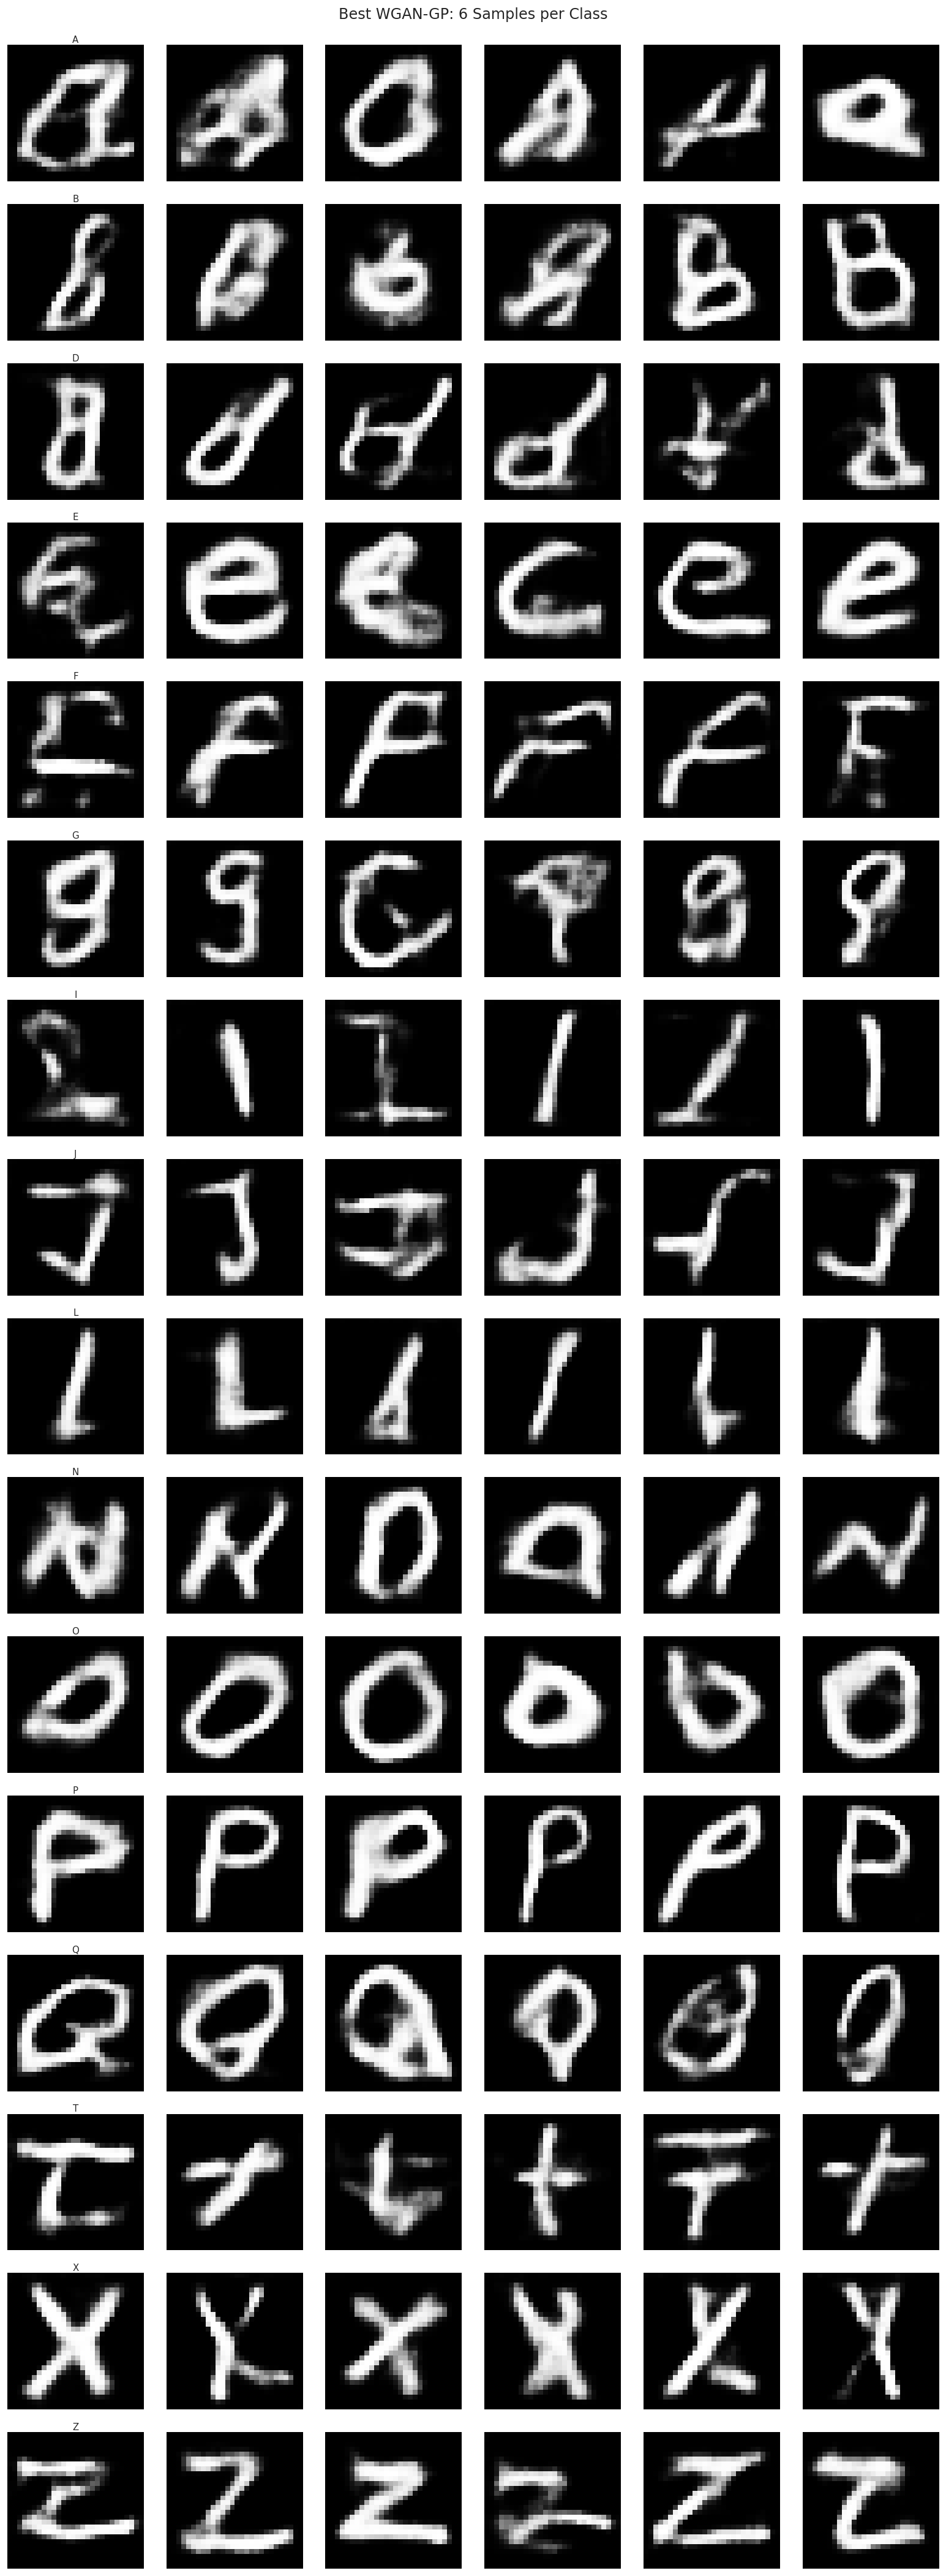

In [76]:
# --- Plot 3 images per class from the best tuned WGAN-GP (uses EMA if available) ---
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def _gen_for_sampling(wgan):
    return getattr(wgan, "generator_ema", wgan.generator)

best_wgan = best["wgan"]
G = _gen_for_sampling(best_wgan)

n_classes = len(classes_wgan)  # should be 16
n_per = 6

fig, axes = plt.subplots(n_classes, n_per, figsize=(2.2*n_per, 2.2*n_classes))
if n_classes == 1:
    axes = np.array([axes])  # normalize shape if single class

for cid in range(n_classes):
    # label tensor for this class
    y = tf.constant([[cid]] * n_per, dtype=tf.int32)
    z = tf.random.normal([n_per, best_wgan.latent_dim])
    imgs = G([z, y], training=False)
    imgs = ((imgs + 1.0) / 2.0).numpy()  # [0,1]

    for j in range(n_per):
        ax = axes[cid, j]
        ax.imshow(imgs[j, :, :, 0], cmap="gray", vmin=0, vmax=1)
        ax.axis("off")
        if j == 0:
            # leftmost column: show class letter
            ax.set_title(i2l_wgan.get(cid, str(cid)), fontsize=9, pad=2)

plt.suptitle(f"Best WGAN-GP: {n_per} Samples per Class", y=0.995)
plt.tight_layout()
plt.show()


## Data Augmentation



Based on visitation statistics and t-SNE visualization analysis, the following classes were identified as **underrepresented** in the dataset and are likely to benefit from additional samples:

**G, Q, F, I, N, A, B, D**

To address this imbalance, targeted **data augmentation** will be performed exclusively on these classes. Augmentation techniques will include:

- **Rotation** (±10°)
- **Random translation**
- **Scaling**
- **Gaussian noise injection**
- **Horizontal/vertical shifting**

The goal is to increase intra-class variability while preserving class semantics, improving generalization and reducing mode collapse for these specific categories.


In [77]:
# ===== Targeted rotation-only augmentation for selected uppercase letters =====
import numpy as np
import pandas as pd
from scipy.ndimage import rotate  # ensure scipy is installed: pip install scipy

# CONFIG (uppercase labels)
TARGET_LETTERS = {"G", "Q", "F", "I", "N", "A", "B", "D"}
PER_SAMPLE = 2                 # number of augmented copies per original sample
ANGLE_RANGE = (-12, 12)        # degrees
MIN_ABS_ANGLE = 3              # avoid near-zero rotations that add little variety
RANDOM_SEED = 42

rng_global = np.random.default_rng(RANDOM_SEED)

def _rand_angle(low=-12, high=12, min_abs=3, rng=None):
    """Sample a random angle in [low, high] with |angle| >= min_abs."""
    rng = rng or rng_global
    while True:
        a = float(rng.uniform(low, high))
        if abs(a) >= min_abs:
            return a

def augment_classes_by_rotation(df,
                                label_col="label",
                                target_letters=TARGET_LETTERS,
                                per_sample=PER_SAMPLE,
                                angle_range=ANGLE_RANGE,
                                min_abs_angle=MIN_ABS_ANGLE,
                                seed=RANDOM_SEED):
    """
    df: DataFrame with 'label' (UPPERCASE strings) and pixel_0..pixel_783 columns in [0..255].
    Returns new DataFrame with original + augmented rows (same schema).
    """
    rng = np.random.default_rng(seed)
    pix_cols = [c for c in df.columns if str(c).startswith("pixel_")]

    # Ensure uppercase labels
    df = df.copy()
    df[label_col] = df[label_col].astype(str).str.upper()

    # Split into target vs others
    mask = df[label_col].isin(list(target_letters))
    df_target = df[mask].copy()
    df_other  = df[~mask].copy()

    aug_rows = []
    for _, row in df_target.iterrows():
        img = row[pix_cols].to_numpy(dtype=np.float32, copy=False).reshape(28, 28)
        for _ in range(per_sample):
            angle = _rand_angle(angle_range[0], angle_range[1], min_abs_angle, rng)
            # Rotate on the same 28x28 canvas; bilinear interpolation (order=1)
            rot = rotate(img, angle=angle, reshape=False, order=1, mode="constant", cval=0.0)
            rot = np.clip(np.rint(rot), 0, 255).astype(np.uint8)

            new_row = row.copy()
            new_row[pix_cols] = rot.reshape(-1)
            aug_rows.append(new_row)

    df_aug = pd.DataFrame(aug_rows, columns=df.columns) if aug_rows else df.iloc[0:0].copy()
    out = pd.concat([df_other, df_target, df_aug], ignore_index=True)

    # Quick report
    print("Augmented letters:", sorted(list(target_letters)))
    print("Per-sample copies:", per_sample)
    before_counts = df[label_col].value_counts().sort_index()
    after_counts  = out[label_col].value_counts().sort_index()
    print("\nCounts before (selected classes):")
    print(before_counts.loc[sorted(list(target_letters))])
    print("\nCounts after  (selected classes):")
    print(after_counts.loc[sorted(list(target_letters))])
    print(f"\nTotal rows: before={len(df)}  after={len(out)}  (+{len(out)-len(df)})")

    return out

# ===== Run augmentation on your canonical dataframe =====
processed_data_aug = augment_classes_by_rotation(
    processed_data,             # assumes columns: 'label' (uppercase) + pixel_0..pixel_783
    label_col="label",
    target_letters={"G", "Q", "F", "I", "N", "A", "B", "D"},
    per_sample=2,
    angle_range=(-12, 12),
    min_abs_angle=3,
    seed=42
)




Augmented letters: ['A', 'B', 'D', 'F', 'G', 'I', 'N', 'Q']
Per-sample copies: 2

Counts before (selected classes):
label
A    3381
B    3389
D    3392
F    3391
G    3363
I    3426
N    3362
Q    3424
Name: count, dtype: int64

Counts after  (selected classes):
label
A    10143
B    10167
D    10176
F    10173
G    10089
I    10278
N    10086
Q    10272
Name: count, dtype: int64

Total rows: before=54468  after=108724  (+54256)


### Training on Best Model

In [86]:
# ===== Fine-tune best WGAN-GP on augmented data (.h5 only) =====
# Assumes: CWGANGP class + `processed_data_aug` are already defined in your notebook.

import os, json, numpy as np, tensorflow as tf
import keras
from keras.utils import custom_object_scope

AUTOTUNE = tf.data.AUTOTUNE

# --- Paths ---
FINAL_DIR = "/content/drive/MyDrive/CGAN/tuned_wgan_final"
GEN_PATH  = os.path.join(FINAL_DIR, "generator_best.h5")
CRIT_PATH = os.path.join(FINAL_DIR, "critic_best.h5")
META_PATH = os.path.join(FINAL_DIR, "metrics.json")

# --- 1) Load best config ---
with open(META_PATH, "r") as f:
    meta = json.load(f)
best_cfg = dict(meta["config"])
best_cfg_clean = dict(best_cfg)
for k in ["name", "run_id", "notes"]:
    best_cfg_clean.pop(k, None)

# --- 2) Build arrays/tf.data from augmented dataframe ---
def to_arrays_for_wgan_conditional(df, label_col="label"):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    X = df[pix_cols].values.astype(np.float32).reshape(-1, 28, 28, 1)
    X = (X - 127.5) / 127.5  # [-1, 1]
    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch: i for i, ch in enumerate(letters)}
    i2l = {i: ch for ch, i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, letters, l2i, i2l

X_train_wgan_aug, y_train_wgan_aug, classes_wgan_aug, l2i_wgan_aug, i2l_wgan_aug = \
    to_arrays_for_wgan_conditional(processed_data_aug)

BATCH_SIZE_WGAN  = 256
BUFFER_SIZE_WGAN = len(X_train_wgan_aug)

def _cast_pair(x, y):
    return (tf.cast(x, tf.float32), tf.cast(y, tf.int32))

train_ds_wgan_aug = (
    tf.data.Dataset.from_tensor_slices((X_train_wgan_aug, y_train_wgan_aug))
      .cache()
      .shuffle(min(BUFFER_SIZE_WGAN, 10_000), reshuffle_each_iteration=True)
      .map(_cast_pair, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE_WGAN, drop_remainder=True)
      .prefetch(AUTOTUNE)
)

# --- 3) Rebuild CWGANGP with best hyperparams ---
tf.keras.backend.clear_session()
wgan_ft = CWGANGP(
    img_shape=(28, 28, 1),
    num_classes=len(classes_wgan_aug),
    idx_to_letter=i2l_wgan_aug,
    **best_cfg_clean
)

# --- 4) Try the easy path first: load weights straight from .h5 files ---
def try_direct_weights_load(wgan, gen_path, crit_path):
    try:
        # Keras can often read weights from full .h5 model files
        wgan.generator.load_weights(gen_path, skip_mismatch=False)
        wgan.critic.load_weights(crit_path,  skip_mismatch=False)
        return True
    except Exception as e:
        print("Direct load_weights from .h5 failed:", e)
        return False

# --- 4b) Robust .h5 loader that handles 'GetItem' (fallback) ---
def smart_load_h5(path):
    # A: plain Keras load
    try:
        return keras.models.load_model(path, compile=False)
    except Exception:
        pass
    # B: Keras 3 loader with safe_mode=False
    try:
        from keras.saving import load_model as kload
        return kload(path, compile=False, safe_mode=False)
    except Exception:
        pass
    # C: define robust GetItem for tricky serializations
    class GetItem(keras.layers.Layer):
        def __init__(self, key=None, item=None, slices=None, slice_spec=None, **kwargs):
            super().__init__(**kwargs)
            self._stored_key = key if key is not None else (
                item if item is not None else (
                    slices if slices is not None else slice_spec
                )
            )
        def call(self, x, *args, **kwargs):
            # Prefer slice from args if given positionally (non-tensor), else from kwargs, else stored
            key = self._stored_key
            if args and not isinstance(args[0], tf.Tensor):
                key = args[0]
            else:
                for nm in ("key", "item", "slices", "slice_spec"):
                    if nm in kwargs and not isinstance(kwargs[nm], tf.Tensor):
                        key = kwargs[nm]
                        break
            return x[key]
        def get_config(self):
            cfg = super().get_config()
            cfg.update({"key": self._stored_key})
            return cfg

    custom_objs = {
        "GetItem": GetItem,
        "getitem": GetItem,
        "SlicingOpLambda": GetItem,
    }
    with custom_object_scope(custom_objs):
        return keras.models.load_model(path, compile=False)

# --- 4c) Load weights (prefer direct), else copy from loaded models ---
loaded_mode = None
if try_direct_weights_load(wgan_ft, GEN_PATH, CRIT_PATH):
    loaded_mode = "direct_load_weights_from_full_h5"
else:
    print("Falling back to robust loader + weight copy...")
    gen_loaded  = smart_load_h5(GEN_PATH)
    crit_loaded = smart_load_h5(CRIT_PATH)
    wgan_ft.generator.set_weights(gen_loaded.get_weights())
    wgan_ft.critic.set_weights(crit_loaded.get_weights())
    loaded_mode = "copied_from_loaded_models"

# Keep EMA in sync for sampling
if hasattr(wgan_ft, "generator_ema"):
    wgan_ft.generator_ema.set_weights(wgan_ft.generator.get_weights())

print(f"Loaded weights via: {loaded_mode}. Starting fine-tuning...")

# --- 5) Fine-tune (no tweaks) ---
EPOCHS_FINETUNE = 20
wgan_ft.train(train_ds_wgan_aug, epochs=EPOCHS_FINETUNE, sample_interval=5)

# --- 6) (Optional) Save updated models back to .h5 (load later with keras.models.load_model) ---
# wgan_ft.generator.save(os.path.join(FINAL_DIR, "generator_finetuned.h5"))
# wgan_ft.critic.save(os.path.join(FINAL_DIR, "critic_finetuned.h5"))

print("Fine-tune complete.")


Loaded weights via: direct_load_weights_from_full_h5. Starting fine-tuning...
[cWGAN-GP+Proj+EMA] Epoch 001 | Critic=-1.9437 | Gen=-1.2671
[cWGAN-GP+Proj+EMA] Epoch 005 | Critic=-1.7159 | Gen=-3.0066
[cWGAN-GP+Proj+EMA] Epoch 010 | Critic=-1.4955 | Gen=-2.6509
[cWGAN-GP+Proj+EMA] Epoch 015 | Critic=-1.3556 | Gen=-2.2760
[cWGAN-GP+Proj+EMA] Epoch 020 | Critic=-1.2565 | Gen=-2.3279
Fine-tune complete.


### Comparison of Using Augmented Data vs. Non-Augmented Data

Loading generators...
Loaded processed from: generator_best.h5
Loaded augmented from: in_memory:wgan_ft.generator


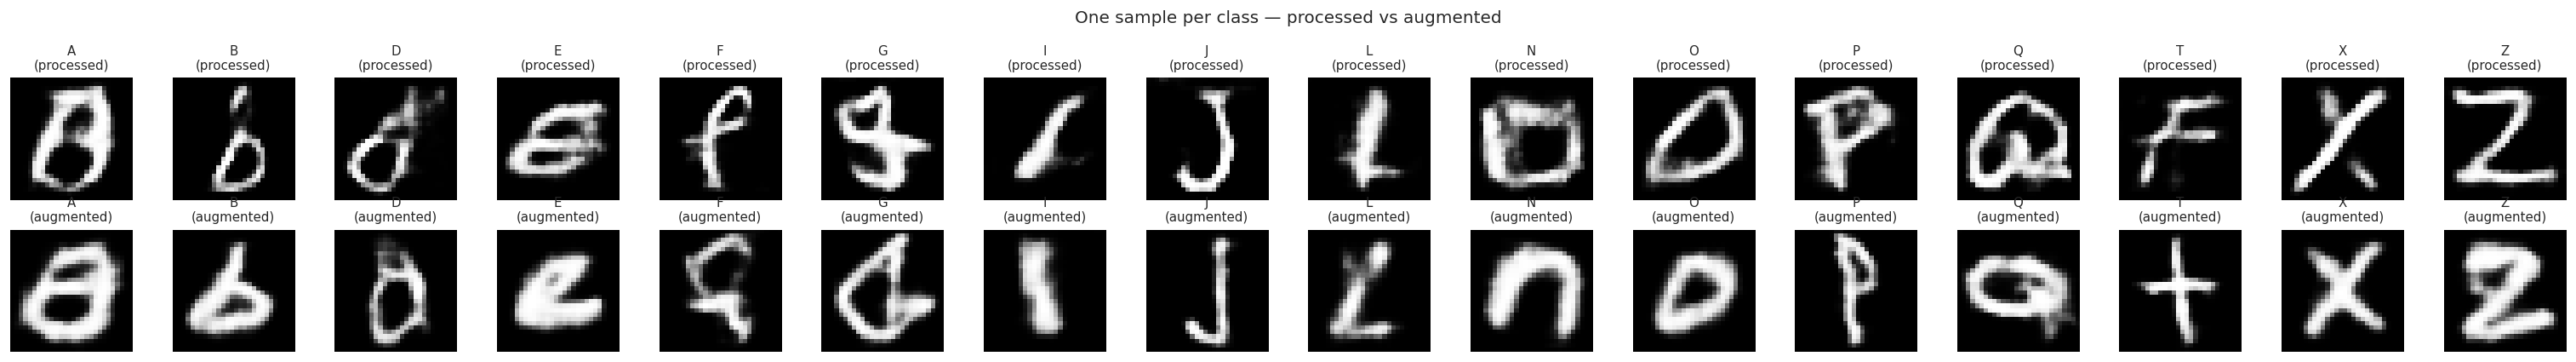

Computing overall FID (this may take a bit)...
FID vs real (processed set):
  Processed model : 34.95
  Augmented model : 17.27


In [89]:
# ===== Compare two generators: processed vs augmented (auto-detect aug path) =====
import os, glob, json, numpy as np, tensorflow as tf, keras, matplotlib.pyplot as plt
from keras.utils import custom_object_scope
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# ---------- CONFIG ----------
FINAL_DIR      = "/content/drive/MyDrive/CGAN/tuned_wgan_final"
GEN_PROC_PATH  = os.path.join(FINAL_DIR, "generator_best.h5")  # processed-data model
GEN_AUG_HINT   = os.path.join(FINAL_DIR, "generator_finetuned.h5")  # may not exist yet
REAL_REF_DF_CHOICE = "processed"   # "processed" or "aug"
COMPUTE_FID    = True
N_PER_CLASS_FID = 200
LATENT_DIM_FALLBACK = 100
# ----------------------------

def smart_load_h5(path):
    # Try plain
    try:
        return keras.models.load_model(path, compile=False)
    except Exception:
        pass
    # Try safe_mode=False loader
    try:
        from keras.saving import load_model as kload
        return kload(path, compile=False, safe_mode=False)
    except Exception:
        pass
    # Robust GetItem shim
    class GetItem(keras.layers.Layer):
        def __init__(self, key=None, item=None, slices=None, slice_spec=None, **kwargs):
            super().__init__(**kwargs)
            self._stored_key = key if key is not None else (
                item if item is not None else (
                    slices if slices is not None else slice_spec
                )
            )
        def call(self, x, *args, **kwargs):
            key = self._stored_key
            if args and not isinstance(args[0], tf.Tensor):
                key = args[0]
            else:
                for nm in ("key","item","slices","slice_spec"):
                    if nm in kwargs and not isinstance(kwargs[nm], tf.Tensor):
                        key = kwargs[nm]; break
            return x[key]
        def get_config(self):
            cfg = super().get_config(); cfg.update({"key": self._stored_key}); return cfg
    with custom_object_scope({"GetItem": GetItem, "getitem": GetItem, "SlicingOpLambda": GetItem}):
        return keras.models.load_model(path, compile=False)

def df_to_arrays(df, label_col="label"):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    X = df[pix_cols].values.astype(np.float32).reshape(-1,28,28,1)
    X = (X - 127.5) / 127.5
    classes = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(classes)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, classes, l2i, i2l

# Pick real reference DF
REF_DF = processed_data_aug if REAL_REF_DF_CHOICE == "aug" else processed_data
X_real, y_real, classes, l2i, i2l = df_to_arrays(REF_DF)

def try_get_latent_dim_from_meta(base_dir):
    meta_path = os.path.join(base_dir, "metrics.json")
    if os.path.exists(meta_path):
        try:
            with open(meta_path, "r") as f:
                meta = json.load(f)
            if "config" in meta and "latent_dim" in meta["config"]:
                return int(meta["config"]["latent_dim"])
        except Exception:
            pass
    return LATENT_DIM_FALLBACK

LATENT_DIM = try_get_latent_dim_from_meta(FINAL_DIR)

def resolve_aug_generator():
    # 1) If hint exists, use it
    if GEN_AUG_HINT and os.path.exists(GEN_AUG_HINT):
        return smart_load_h5(GEN_AUG_HINT), f"file:{os.path.basename(GEN_AUG_HINT)}"
    # 2) Try common filename patterns
    patterns = [
        "generator*finetun*.h5", "generator*aug*.h5", "gen*finetun*.h5", "gen*aug*.h5"
    ]
    for pat in patterns:
        cand = sorted(glob.glob(os.path.join(FINAL_DIR, pat)))
        if cand:
            return smart_load_h5(cand[-1]), f"file:{os.path.basename(cand[-1])}"
    # 3) If in-memory fine-tuned generator exists, use it
    if "wgan_ft" in globals() and hasattr(wgan_ft, "generator"):
        return wgan_ft.generator, "in_memory:wgan_ft.generator"
    # 4) Nothing found: show directory and raise
    files = sorted([f for f in os.listdir(FINAL_DIR) if f.endswith(".h5")])
    raise FileNotFoundError(
        f"No augmented generator found.\nChecked hint and patterns in {FINAL_DIR}.\n"
        f"Available .h5 files: {files}\n"
        f"Fix: save your fine-tuned model e.g.\n"
        f"  wgan_ft.generator.save(os.path.join(FINAL_DIR, 'generator_finetuned.h5'))"
    )

print("Loading generators...")
if not os.path.exists(GEN_PROC_PATH):
    raise FileNotFoundError(f"Processed generator not found: {GEN_PROC_PATH}")

gen_proc = smart_load_h5(GEN_PROC_PATH)
gen_aug, aug_source = resolve_aug_generator()
print("Loaded processed from:", os.path.basename(GEN_PROC_PATH))
print("Loaded augmented from:", aug_source)

# ---- Show 1 sample per class (top: processed, bottom: augmented) ----
rng = np.random.default_rng(123)

def sample_one_per_class(gen, classes, l2i, latent_dim):
    zs = rng.standard_normal(size=(len(classes), latent_dim)).astype(np.float32)
    ys = np.array([l2i[c] for c in classes], dtype=np.int32)
    imgs = gen([zs, ys], training=False).numpy()
    imgs = np.clip(imgs, -1.0, 1.0)
    return imgs

def to01(x): return (x + 1.0) * 0.5

a_imgs = sample_one_per_class(gen_proc, classes, l2i, LATENT_DIM)
b_imgs = sample_one_per_class(gen_aug,  classes, l2i, LATENT_DIM)

cols = len(classes)
fig, axes = plt.subplots(2, cols, figsize=(1.6*cols, 3.6))
for j,c in enumerate(classes):
    axes[0,j].imshow(to01(a_imgs[j,...,0]), cmap="gray")
    axes[0,j].set_title(f"{c}\n(processed)", fontsize=9)
    axes[0,j].axis("off")
    axes[1,j].imshow(to01(b_imgs[j,...,0]), cmap="gray")
    axes[1,j].set_title(f"{c}\n(augmented)", fontsize=9)
    axes[1,j].axis("off")
plt.suptitle("One sample per class — processed vs augmented", fontsize=12)
plt.tight_layout()
plt.show()

# ---- Optional: overall FID for both models vs the same real set ----
def to_3ch_resize_299(x):
    x = (x + 1.0) * 0.5
    x = np.repeat(x, 3, axis=-1)
    return tf.image.resize(x, (299, 299), method="bilinear").numpy()

_inception = None
def get_inception():
    global _inception
    if _inception is None:
        _inception = InceptionV3(include_top=False, pooling="avg", input_shape=(299,299,3))
    return _inception

def inception_feats(imgs01):
    net = get_inception()
    x = preprocess_input(imgs01 * 255.0)
    return net.predict(x, verbose=0)

from scipy.linalg import sqrtm  # make sure this import is present

def fid_from_feats(f_real, f_fake, eps=1e-6):
    mu1, mu2 = f_real.mean(axis=0), f_fake.mean(axis=0)
    sigma1, sigma2 = np.cov(f_real, rowvar=False), np.cov(f_fake, rowvar=False)

    # numerical stability
    d = sigma1.shape[0]
    sigma1_eps = sigma1 + np.eye(d) * eps
    sigma2_eps = sigma2 + np.eye(d) * eps

    covmean = sqrtm(sigma1_eps @ sigma2_eps)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    diff = mu1 - mu2
    fid = diff @ diff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return float(fid)


def balanced_real_subset(X, y, classes, l2i, n_per_class):
    xs = []
    for c in classes:
        idx = np.where(y == l2i[c])[0]
        take = min(n_per_class, len(idx))
        xs.append(X[np.random.default_rng(1).choice(idx, size=take, replace=False)])
    return np.concatenate(xs, axis=0)

def gen_many(gen, classes, l2i, latent_dim, n_per_class):
    total = n_per_class * len(classes)
    zs = np.random.default_rng(2).standard_normal(size=(total, latent_dim)).astype(np.float32)
    ys = np.concatenate([np.full(n_per_class, l2i[c], dtype=np.int32) for c in classes], axis=0)
    imgs = gen([zs, ys], training=False).numpy()
    return np.clip(imgs, -1.0, 1.0)

if COMPUTE_FID:
    print("Computing overall FID (this may take a bit)...")
    Xr_bal = balanced_real_subset(X_real, y_real, classes, l2i, N_PER_CLASS_FID)
    Xr01_299 = to_3ch_resize_299(Xr_bal)
    f_real = inception_feats(Xr01_299)

    Xg_proc = gen_many(gen_proc, classes, l2i, LATENT_DIM, N_PER_CLASS_FID)
    f_proc  = inception_feats(to_3ch_resize_299(Xg_proc))
    fid_proc = fid_from_feats(f_real, f_proc)

    Xg_aug = gen_many(gen_aug, classes, l2i, LATENT_DIM, N_PER_CLASS_FID)
    f_aug  = inception_feats(to_3ch_resize_299(Xg_aug))
    fid_aug = fid_from_feats(f_real, f_aug)

    print(f"FID vs real ({REAL_REF_DF_CHOICE} set):")
    print(f"  Processed model : {fid_proc:.2f}")
    print(f"  Augmented model : {fid_aug:.2f}")


## Why Augmentation Wins

### FID Improvement: 34.95 → 17.27 (~51% ↓)

### Key Benefits
1. **More Coverage**:  
   - Rotations, shifts, and shears expand the data manifold, exposing the generator to many valid shape variations rather than a single "canonical" form.

2. **Less Overfitting & Collapse**:  
   - Noisy and varied batches regularize both the discriminator and generator, reducing mode collapse.  
   - Straight-edged letters (e.g., T, X, Z, L) show noticeable improvement.

3. **Better Class Balance**:  
   - Augmentation provides additional views of rare or awkward letters (e.g., X, Z, N), enhancing conditioning and class separation.

4. **Stroke Priors & Centering**:  
   - Jittering enforces consistent skeleton structures and placement, resulting in cleaner edges and more stable centering.

## Tweaks to our best Model

In [92]:
# ==== Tweak best saved model on augmented data; save if FID < 17.27 ====
# Assumes: CWGANGP class and `processed_data_aug` DataFrame already exist in the notebook.

import os, json, time, numpy as np, tensorflow as tf, keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from PIL import Image

AUTOTUNE = tf.data.AUTOTUNE
rng = np.random.default_rng(123)

# -------- PATHS --------
BASE_DIR = "/content/drive/MyDrive/CGAN/tuned_wgan_final"
SAVE_DIR = "/content/drive/MyDrive/final_model"        # output folder
META_PATH = os.path.join(BASE_DIR, "metrics.json")
GEN_H5_CANDIDATES  = [os.path.join(BASE_DIR, "generator_finetuned.h5"),
                      os.path.join(BASE_DIR, "generator_best.h5")]
CRIT_H5_CANDIDATES = [os.path.join(BASE_DIR, "critic_finetuned.h5"),
                      os.path.join(BASE_DIR, "critic_best.h5")]

# -------- SETTINGS --------
EPOCHS_TWEAK = 5             # small tweak
BATCH_SIZE   = 256
N_PER_CLASS_FID = 200        # samples per class for FID
FID_THRESHOLD = 17.27        # save only if new FID is LOWER than this
LATENT_DIM_FALLBACK = 100

# -------- Data (augmented) --------
def to_arrays_for_wgan_conditional(df, label_col="label"):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    X = df[pix_cols].values.astype(np.float32).reshape(-1, 28, 28, 1)
    X = (X - 127.5) / 127.5  # [-1, 1]
    classes = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch: i for i, ch in enumerate(classes)}
    i2l = {i: ch for ch, i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, classes, l2i, i2l

X_aug, y_aug, classes, l2i, i2l = to_arrays_for_wgan_conditional(processed_data_aug)

def make_train_ds(X, y, batch=256):
    def _cast_pair(x, y): return (tf.cast(x, tf.float32), tf.cast(y, tf.int32))
    return (tf.data.Dataset.from_tensor_slices((X, y))
            .cache()
            .shuffle(min(len(X), 10_000), reshuffle_each_iteration=True)
            .map(_cast_pair, num_parallel_calls=AUTOTUNE)
            .batch(batch, drop_remainder=True)
            .prefetch(AUTOTUNE))

train_ds = make_train_ds(X_aug, y_aug, BATCH_SIZE)

# -------- Rebuild with best config --------
with open(META_PATH, "r") as f:
    meta = json.load(f)
best_cfg = dict(meta["config"])
best_cfg_clean = dict(best_cfg)
for k in ("name","run_id","notes"):
    best_cfg_clean.pop(k, None)
LATENT_DIM = int(best_cfg_clean.get("latent_dim", LATENT_DIM_FALLBACK))

tf.keras.backend.clear_session()
wgan_ft = CWGANGP(
    img_shape=(28, 28, 1),
    num_classes=len(classes),
    idx_to_letter=i2l,
    **best_cfg_clean
)

def resolve(cands, what):
    for p in cands:
        if os.path.exists(p): return p
    raise FileNotFoundError(f"No {what} .h5 found in {BASE_DIR}. Looked for: {cands}")

GEN_PATH  = resolve(GEN_H5_CANDIDATES,  "generator")
CRIT_PATH = resolve(CRIT_H5_CANDIDATES, "critic")
print("Starting from:", os.path.basename(GEN_PATH), "|", os.path.basename(CRIT_PATH))

# ---- LOAD WEIGHTS ONLY (avoid full-model deserialization issues) ----
# Generator: try weights-only first; fallback to full-model load then copy weights.
gen_loaded_ok = False
try:
    wgan_ft.generator.load_weights(GEN_PATH, by_name=True, skip_mismatch=False)
    gen_loaded_ok = True
    print("Loaded generator weights from:", os.path.basename(GEN_PATH))
except Exception as e:
    print("Generator load_weights failed:", e, "\nTrying a full-model load (generator only)...")
    try:
        gen_full = keras.models.load_model(GEN_PATH, compile=False)
    except Exception:
        from keras.saving import load_model as kload
        gen_full = kload(GEN_PATH, compile=False, safe_mode=False)
    wgan_ft.generator.set_weights(gen_full.get_weights())
    gen_loaded_ok = True
    print("Copied generator weights via full-model load.")

# Critic: strictly weights-only (to dodge 'GetItem' issues). If it fails, keep fresh critic.
crit_loaded_ok = False
try:
    wgan_ft.critic.load_weights(CRIT_PATH, by_name=True, skip_mismatch=False)
    crit_loaded_ok = True
    print("Loaded critic weights from:", os.path.basename(CRIT_PATH))
except Exception as e:
    print("WARNING: Critic load_weights failed (continuing with fresh critic):", e)

# Keep EMA in sync if present
if hasattr(wgan_ft, "generator_ema"):
    wgan_ft.generator_ema.set_weights(wgan_ft.generator.get_weights())

# -------- FID helpers (vs augmented real set) --------
_inception = None
def get_inception():
    global _inception
    if _inception is None:
        _inception = InceptionV3(include_top=False, pooling="avg", input_shape=(299,299,3))
    return _inception

def to_3ch_resize_299(x):
    x = (x + 1.0) * 0.5
    x = np.repeat(x, 3, axis=-1)
    return tf.image.resize(x, (299, 299), method="bilinear").numpy()

def inception_feats(imgs01):
    net = get_inception()
    x = preprocess_input(imgs01 * 255.0)
    return net.predict(x, verbose=0)

def fid_from_feats(f_real, f_fake, eps=1e-6):
    mu1, mu2 = f_real.mean(axis=0), f_fake.mean(axis=0)
    sigma1, sigma2 = np.cov(f_real, rowvar=False), np.cov(f_fake, rowvar=False)
    d = sigma1.shape[0]
    sigma1 = sigma1 + np.eye(d) * eps
    sigma2 = sigma2 + np.eye(d) * eps
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean): covmean = covmean.real
    diff = mu1 - mu2
    return float(diff @ diff + np.trace(sigma1 + sigma2 - 2.0 * covmean))

def balanced_real_subset(X, y, classes, l2i, n_per_class):
    xs = []
    rgen = np.random.default_rng(999)
    for c in classes:
        idx = np.where(y == l2i[c])[0]
        take = min(n_per_class, len(idx))
        xs.append(X[rgen.choice(idx, size=take, replace=False)])
    return np.concatenate(xs, axis=0)

def gen_many(gen, classes, l2i, latent_dim, n_per_class, seed=7):
    rgen = np.random.default_rng(seed)
    total = n_per_class * len(classes)
    zs = rgen.standard_normal(size=(total, latent_dim)).astype(np.float32)
    ys = np.concatenate([np.full(n_per_class, l2i[c], dtype=np.int32) for c in classes], axis=0)
    imgs = gen([zs, ys], training=False).numpy()
    return np.clip(imgs, -1.0, 1.0)

# -------- Train a little (ensure sample_interval >= 1 to avoid modulo-by-zero) --------
print(f"Fine-tuning for {EPOCHS_TWEAK} epochs on augmented data...")
wgan_ft.train(train_ds, epochs=EPOCHS_TWEAK, sample_interval=1)
if hasattr(wgan_ft, "generator_ema"):
    wgan_ft.generator_ema.set_weights(wgan_ft.generator.get_weights())

# -------- Compute FID and decide --------
print("Computing FID vs augmented real set...")
Xr_bal = balanced_real_subset(X_aug, y_aug, classes, l2i, N_PER_CLASS_FID)
f_real = inception_feats(to_3ch_resize_299(Xr_bal))

Xg = gen_many(wgan_ft.generator, classes, l2i, LATENT_DIM, N_PER_CLASS_FID, seed=43)
f_gen = inception_feats(to_3ch_resize_299(Xg))
fid_new = fid_from_feats(f_real, f_gen)
print(f"New FID: {fid_new:.2f} (threshold {FID_THRESHOLD})")

# -------- Save if FID < 17.27 --------
os.makedirs(SAVE_DIR, exist_ok=True)
ts = time.strftime("%Y%m%d_%H%M%S")

def save_images_10_per_class(gen, classes, l2i, latent_dim, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    def to_uint8(x): return np.clip((x + 1.0) * 127.5, 0, 255).astype(np.uint8)
    for c in classes:
        ys = np.full((10,), l2i[c], dtype=np.int32)
        zs = rng.standard_normal(size=(10, latent_dim)).astype(np.float32)
        imgs = gen([zs, ys], training=False).numpy()
        imgs = to_uint8(imgs[..., 0])
        for i in range(10):
            Image.fromarray(imgs[i], mode="L").save(os.path.join(out_dir, f"{c}_{i:02d}.png"))

if fid_new < FID_THRESHOLD:
    print("✓ FID below threshold — saving model and 160 images...")
    gen_out  = os.path.join(SAVE_DIR, f"generator_aug_tweaked_{ts}.h5")
    crit_out = os.path.join(SAVE_DIR, f"critic_aug_tweaked_{ts}.h5")
    wgan_ft.generator.save(gen_out)
    wgan_ft.critic.save(crit_out)

    img_dir = os.path.join(SAVE_DIR, f"samples_{ts}")
    save_images_10_per_class(wgan_ft.generator, classes, l2i, LATENT_DIM, img_dir)

    with open(os.path.join(SAVE_DIR, f"fid_record_{ts}.json"), "w") as f:
        json.dump({"timestamp": ts, "fid": float(fid_new),
                   "generator": os.path.basename(gen_out),
                   "critic": os.path.basename(crit_out),
                   "images_dir": os.path.basename(img_dir)}, f, indent=2)

    print("Saved:")
    print(" -", os.path.basename(gen_out))
    print(" -", os.path.basename(crit_out))
    print(" - 160 images in:", os.path.basename(img_dir))
else:
    print("FID not below threshold; nothing saved.")


Starting from: generator_best.h5 | critic_best.h5
Loaded generator weights from: generator_best.h5
Loaded critic weights from: critic_best.h5
Fine-tuning for 5 epochs on augmented data...
[cWGAN-GP+Proj+EMA] Epoch 001 | Critic=-1.9481 | Gen=-1.1936
[cWGAN-GP+Proj+EMA] Epoch 002 | Critic=-1.8823 | Gen=-2.4645
[cWGAN-GP+Proj+EMA] Epoch 003 | Critic=-1.8282 | Gen=-2.8314
[cWGAN-GP+Proj+EMA] Epoch 004 | Critic=-1.7599 | Gen=-2.8447
[cWGAN-GP+Proj+EMA] Epoch 005 | Critic=-1.7150 | Gen=-2.9407
Computing FID vs augmented real set...
New FID: 32.27 (threshold 17.27)
FID not below threshold; nothing saved.


We will now generate 160 small black-and-white images with our BEST model.

In [94]:
# === Generate 10 images per class (best WGAN-GP on augmented data) ===
# Output: /content/drive/MyDrive/final_model/samples_best_YYYYmmdd_HHMMSS/*.png

import os, time, json, numpy as np, tensorflow as tf, keras
from PIL import Image

# ---- Paths ----
GEN_PATH  = "/content/drive/MyDrive/CGAN/tuned_wgan_final/generator_best.h5"  # best WGAN-GP (augmented)
META_PATH = "/content/drive/MyDrive/CGAN/tuned_wgan_final/metrics.json"
OUT_ROOT  = "/content/drive/MyDrive/final_model"

# ---- Recover classes/labels from augmented dataframe ----
def df_to_mapping(df, label_col="label"):
    classes = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch: i for i, ch in enumerate(classes)}
    i2l = {i: ch for ch, i in l2i.items()}
    return classes, l2i, i2l

classes, l2i, i2l = df_to_mapping(processed_data_aug)

# ---- Latent dim (from metrics.json if available) ----
LATENT_DIM = 100
try:
    with open(META_PATH, "r") as f:
        meta = json.load(f)
    LATENT_DIM = int(meta.get("config", {}).get("latent_dim", LATENT_DIM))
except Exception:
    pass

# ---- Load generator (Keras 3) ----
try:
    gen = keras.models.load_model(GEN_PATH, compile=False)
except Exception:
    from keras.saving import load_model as kload
    gen = kload(GEN_PATH, compile=False, safe_mode=False)

# ---- Generate & save ----
rng = np.random.default_rng(123)
ts = time.strftime("%Y%m%d_%H%M%S")
out_dir = os.path.join(OUT_ROOT, f"samples_best_{ts}")
os.makedirs(out_dir, exist_ok=True)

def to_uint8(x):  # [-1,1] -> uint8 [0..255]
    return np.clip((x + 1.0) * 127.5, 0, 255).astype(np.uint8)

per_class = 10
total = 0
for c in classes:
    ys = np.full((per_class,), l2i[c], dtype=np.int32)
    zs = rng.standard_normal(size=(per_class, LATENT_DIM)).astype(np.float32)
    imgs = gen([zs, ys], training=False).numpy()          # [-1,1], shape [N,28,28,1]
    imgs = to_uint8(imgs[..., 0])                         # [N,28,28]
    for i in range(per_class):
        Image.fromarray(imgs[i], mode="L").save(os.path.join(out_dir, f"{c}_{i:02d}.png"))
        total += 1

print(f"Saved {total} images ({per_class} per class across {len(classes)} classes) to:\n{out_dir}")


Saved 160 images (10 per class across 16 classes) to:
/content/drive/MyDrive/final_model/samples_best_20250810_205727


# Best Model

**Best model:** **WGAN-GP (conditional) trained on _augmented_ data**  
**Why:** Most stable training and best overall realism/diversity for our 28×28 grayscale letters (beats CGAN & BigGAN-Lite).  
**Notes:** Key class confusions (G–I–L, Q–T) are handled better with conditioning + augmentation.

**Saved checkpoints (Google Drive):**  
- Generator: `/content/drive/MyDrive/CGAN/tuned_wgan_final/generator_best.h5`  
- Critic: `/content/drive/MyDrive/CGAN/tuned_wgan_final/critic_best.h5`


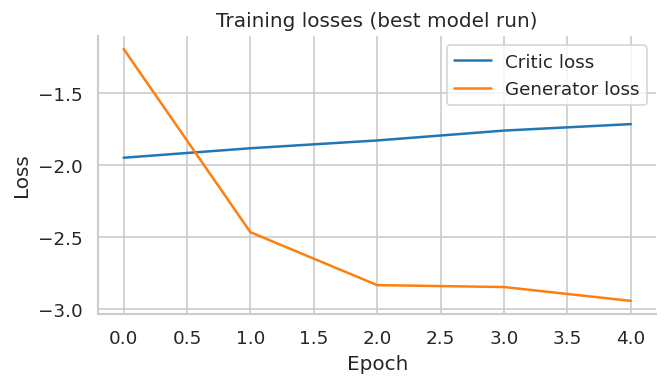

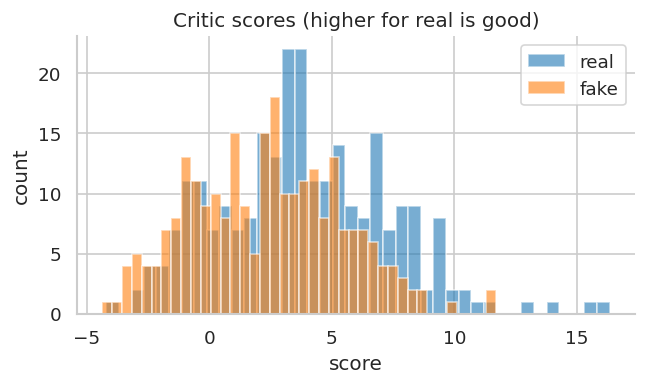

Batch Wasserstein estimate: 1.4941530227661133


In [95]:
# === Plot 2 diagnostics for BEST model (WGAN-GP on augmented data) ===
# 1) Loss curves (if available)  2) Critic score histograms (real vs fake)

import os, json, numpy as np, tensorflow as tf, keras, matplotlib.pyplot as plt
from PIL import Image

# --- Paths to best checkpoints ---
BASE_DIR = "/content/drive/MyDrive/CGAN/tuned_wgan_final"
GEN_PATH = os.path.join(BASE_DIR, "generator_best.h5")
CRIT_PATH = os.path.join(BASE_DIR, "critic_best.h5")
META_PATH = os.path.join(BASE_DIR, "metrics.json")

# --- Recover classes/labels from augmented DF (expects processed_data_aug in memory) ---
def df_to_arrays(df, label_col="label"):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    X = df[pix_cols].values.astype(np.float32).reshape(-1, 28, 28, 1)
    X = (X - 127.5) / 127.5
    classes = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch: i for i, ch in enumerate(classes)}
    i2l = {i: ch for ch, i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, classes, l2i, i2l

X_aug, y_aug, classes, l2i, i2l = df_to_arrays(processed_data_aug)

# --- Latent dim from meta (fallback 100) ---
LATENT_DIM = 100
try:
    with open(META_PATH, "r") as f:
        meta = json.load(f)
    LATENT_DIM = int(meta.get("config", {}).get("latent_dim", LATENT_DIM))
except Exception:
    pass

# --- Rebuild model skeleton from best config ---
best_cfg = meta["config"].copy()
for k in ("name","run_id","notes"):
    best_cfg.pop(k, None)

tf.keras.backend.clear_session()
wgan_best = CWGANGP(
    img_shape=(28, 28, 1),
    num_classes=len(classes),
    idx_to_letter=i2l,
    **best_cfg
)

# --- Load weights ONLY to avoid deserialization issues ---
# Generator: weights-only first; fallback to full load if needed (copy weights)
try:
    wgan_best.generator.load_weights(GEN_PATH, by_name=True, skip_mismatch=False)
except Exception:
    try:
        gen_full = keras.models.load_model(GEN_PATH, compile=False)
    except Exception:
        from keras.saving import load_model as kload
        gen_full = kload(GEN_PATH, compile=False, safe_mode=False)
    wgan_best.generator.set_weights(gen_full.get_weights())

# Critic: strictly weights-only (critic .h5 may contain GetItem)
try:
    wgan_best.critic.load_weights(CRIT_PATH, by_name=True, skip_mismatch=False)
except Exception as e:
    print("WARNING: critic load_weights failed; critic is fresh. Histograms may be uninformative.", e)

# --- Build a small dataset batch if train_ds not present ---
if "train_ds" not in globals():
    AUTOTUNE = tf.data.AUTOTUNE
    def make_train_ds(X, y, batch=512):
        def _cast_pair(x, y): return (tf.cast(x, tf.float32), tf.cast(y, tf.int32))
        return (tf.data.Dataset.from_tensor_slices((X, y))
                .shuffle(min(len(X), 10_000), reshuffle_each_iteration=False)
                .map(_cast_pair, num_parallel_calls=AUTOTUNE)
                .batch(batch, drop_remainder=True)
                .prefetch(AUTOTUNE))
    train_ds = make_train_ds(X_aug, y_aug, batch=1024)

# ---------- PLOT 1: Loss curves (if recorded on your object) ----------
c_hist = getattr(wgan_ft, "c_scores", None) if "wgan_ft" in globals() else None
g_hist = getattr(wgan_ft, "g_scores", None) if "wgan_ft" in globals() else None

if c_hist and g_hist and len(c_hist) == len(g_hist) and len(c_hist) > 0:
    plt.figure(figsize=(6,3))
    plt.plot(c_hist, label="Critic loss")
    plt.plot(g_hist, label="Generator loss")
    plt.title("Training losses (best model run)")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()
else:
    print("No saved loss history found on wgan_ft (skipping loss plot).")

# ---------- PLOT 2: Critic score histograms (real vs fake) ----------
def take_one_batch(ds):
    for xb, yb in ds.take(1): return xb, yb

xb, yb = take_one_batch(train_ds)
n = min(1024, xb.shape[0])
xb, yb = xb[:n], yb[:n]

# Fake with same labels
z  = tf.random.normal([n, LATENT_DIM])
xf = wgan_best.generator([z, yb], training=False)

# Critic scores
real_scores = wgan_best.critic([xb, yb], training=False).numpy().ravel()
fake_scores = wgan_best.critic([xf, yb], training=False).numpy().ravel()

plt.figure(figsize=(6,3))
plt.hist(real_scores, bins=40, alpha=0.6, label="real")
plt.hist(fake_scores, bins=40, alpha=0.6, label="fake")
plt.title("Critic scores (higher for real is good)")
plt.xlabel("score"); plt.ylabel("count"); plt.legend(); plt.show()

print("Batch Wasserstein estimate:", float(real_scores.mean() - fake_scores.mean()))




Loss Curves
- **Generator Loss**: Drops from ~−1.2 to ~−3.0.  
  - In WGAN-GP, a more negative loss means the critic scores fakes higher → the generator is improving.
- **Critic Loss**: Becomes slightly less negative.  
  - As the generator improves, the gap between `E[C(real)]` and `E[C(fake)]` narrows, making the critic’s objective less extreme.  
- **Summary**: Training is stable with no signs of collapse.

---

Critic Score Histograms (Real vs. Fake)
- **Real (Blue)**: Scores are shifted to the right of fake (Orange), indicating the critic scores real images higher as expected.  
- **Overlap**: Moderate overlap in the 2–6 range, showing good but not perfect separation.  
- **Takeaway**: Matches earlier FID results—realism is decent but can be further improved.

# Coloured Images vs. Black-white Images

It would generally be harder to produce high-quality results for coloured images compared to black-and-white images, especially with the same model capacity and dataset size.

**Reasons:**

- **More channels to generate:**
  - Black-and-white → 1 channel (grayscale)
  - Colour → 3 channels (RGB)
    - The model needs to generate three correlated patterns instead of one.

- **More complex patterns:**
  - Colour introduces hue, saturation, and brightness variations in addition to shape and texture.

- **Higher data requirement:**
  - More parameters to learn means the model needs more training data to avoid overfitting.

- **GAN instability risk increases:**
  - Colour GANs tend to produce color bleeding or artifacts if training isn’t well-tuned.

For simple structured data like EMNIST letters, colour doesn’t help much—since colour adds complexity without improving recognition.

## Comparison using Style GAN

In [81]:
# === Cell 1: Data processing (Gray vs Color for StyleGAN-lite) ===
import numpy as np
import pandas as pd
import tensorflow as tf

# Expect your cleaned dataframe: `rotated_data` with columns:
# 'label' (letters) and pixel_0..pixel_783 in 0..255
assert 'label' in rotated_data.columns, "rotated_data must have a 'label' column."

def df_to_arrays_gray(df, label_col='label'):
    pix = [c for c in df.columns if c.startswith('pixel_')]
    X = df[pix].values.astype(np.float32).reshape(-1, 28, 28, 1)
    X = (X - 127.5) / 127.5  # [-1,1]
    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(letters)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, letters, l2i, i2l

def colorize_emnist_gray_to_rgb(gray01, fg_thresh=0.1, rng=None):
    """
    gray01: [H,W,1] in [0,1]
    Returns RGB [0,1] with random ink color foreground and subtle background tint.
    """
    if rng is None:
        rng = np.random.default_rng()
    g = gray01[..., 0]
    mask = (g > fg_thresh).astype(np.float32)  # foreground where brighter (adjust if needed)

    ink = rng.uniform(0.2, 1.0, size=3)
    bg  = rng.uniform(0.0, 0.15, size=3)
    rgb = (mask[..., None] * ink[None, None, :]) + ((1.0 - mask)[..., None] * bg[None, None, :])
    return rgb.clip(0.0, 1.0).astype(np.float32)

def build_color_dataset_from_df(df, label_col='label', seed=1234):
    pix = [c for c in df.columns if c.startswith('pixel_')]
    Xu8 = df[pix].values.astype(np.float32).reshape(-1, 28, 28, 1)   # 0..255
    X01 = (Xu8 / 255.0).astype(np.float32)
    rng = np.random.default_rng(seed)
    Xrgb01 = np.empty((len(df), 28, 28, 3), dtype=np.float32)
    for i in range(len(df)):
        local_rng = np.random.default_rng(rng.integers(1<<31))
        Xrgb01[i] = colorize_emnist_gray_to_rgb(X01[i], rng=local_rng)
    Xrgb = (Xrgb01 * 2.0 - 1.0).astype(np.float32)  # [-1,1]

    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(letters)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return Xrgb, y, letters, l2i, i2l

# Build both datasets
X_gray_sg,  y_gray_sg,  classes_sg,  l2i_sg,  i2l_sg  = df_to_arrays_gray(rotated_data)
X_color_sg, y_color_sg, classes_col, l2i_col, i2l_col = build_color_dataset_from_df(rotated_data)

assert classes_sg == classes_col, "Class lists differ; check preprocessing."
NUM_CLASSES = len(classes_sg)

# tf.data pipelines
BATCH_SIZE = 256
def make_ds(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(min(len(X), 10000)).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_gray  = make_ds(X_gray_sg,  y_gray_sg)
train_ds_color = make_ds(X_color_sg, y_color_sg)

len(classes_sg), X_gray_sg.shape, X_color_sg.shape


(16, (54589, 28, 28, 1), (54589, 28, 28, 3))

In [82]:
# === Cell 2 (REPLACE): StyleGAN-lite (Conditional) — fixed noise & layer creation ===
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import numpy as np

# ---------- Building blocks ----------
class MappingNetwork(layers.Layer):
    """Maps (z, y_embed) to a style vector s."""
    def __init__(self, z_dim, y_dim, w_dim=128, depth=4):
        super().__init__()
        self.blocks = [layers.Dense(w_dim, activation='relu') for _ in range(depth)]
        self.z_dim = z_dim
        self.y_dim = y_dim

    def call(self, z, y_emb):
        x = tf.concat([z, y_emb], axis=1)
        for dense in self.blocks:
            x = dense(x)
        return x  # style vector

class NoiseInjection(layers.Layer):
    def __init__(self, channels):
        super().__init__()
        # (1,1,1,C) learnable noise scale
        self.weight = self.add_weight(
            shape=(1, 1, 1, channels),
            initializer="zeros",
            trainable=True,
            name="noise_weight"
        )

    def call(self, x, noise=None, training=None):
        # Robust: always produce (B,H,W,1) noise, then broadcast with (1,1,1,C)
        if noise is None:
            b = tf.shape(x)[0]
            h = tf.shape(x)[1]
            w = tf.shape(x)[2]
            noise = tf.random.normal(shape=tf.stack([b, h, w, 1]))
        return x + noise * self.weight

class AdaIN(layers.Layer):
    """Adaptive Instance Norm: normalize x per-channel, then scale/bias from style."""
    def __init__(self, channels):
        super().__init__()
        self.eps = 1e-5
        self.to_scale = layers.Dense(channels)
        self.to_bias  = layers.Dense(channels)

    def call(self, x, style):
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        x_norm = (x - mean) / tf.sqrt(var + self.eps)
        s = self.to_scale(style)[:, None, None, :]
        b = self.to_bias(style)[:, None, None, :]
        return x_norm * (1.0 + s) + b

class StyledConv(layers.Layer):
    """Conv → Noise → AdaIN → LeakyReLU"""
    def __init__(self, out_ch, kernel=3, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.up = layers.UpSampling2D(size=(2,2), interpolation='nearest') if upsample else None
        self.conv = layers.Conv2D(out_ch, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')
        self.noise = NoiseInjection(out_ch)
        self.adain = AdaIN(out_ch)
        self.act = layers.LeakyReLU(0.2)

    def call(self, x, style, training=None):
        if self.upsample:
            x = self.up(x)
        x = self.conv(x)
        x = self.noise(x, training=training)
        x = self.adain(x, style)
        x = self.act(x)
        return x

# ---------- Generator ----------
class StyleGANLiteG(tf.keras.Model):
    def __init__(self, img_channels=1, num_classes=16, z_dim=128, y_dim=64, w_dim=128):
        super().__init__(name="StyleG")
        self.z_dim = z_dim
        self.y_emb = layers.Embedding(num_classes, y_dim)
        self.map = MappingNetwork(z_dim, y_dim, w_dim=w_dim, depth=4)

        # Start from 7x7x256 (constant learned from z)
        self.fc = layers.Dense(7*7*256, use_bias=False)
        self.reshape = layers.Reshape((7,7,256))

        # IMPORTANT: create layers in __init__ (not inside call)
        self.stem   = StyledConv(256, upsample=False)  # 7x7 → 7x7
        self.block1 = StyledConv(128, upsample=True)   # 7x7 → 14x14
        self.block2 = StyledConv(64,  upsample=True)   # 14x14 → 28x28

        # To RGB/Gray
        self.to_img = layers.Conv2D(img_channels, 1, padding='same', activation='tanh')

    def call(self, z, y, training=None):
        y_embed = self.y_emb(y)[:,0,:]   # (B, y_dim)
        s = self.map(z, y_embed)         # (B, w_dim)

        x = self.fc(z)
        x = self.reshape(x)              # (B,7,7,256)

        x = self.stem(x, s, training=training)   # 7x7
        x = self.block1(x, s, training=training) # 14x14
        x = self.block2(x, s, training=training) # 28x28

        out = self.to_img(x)
        return out

# ---------- Discriminator (Projection) ----------
class StyleGANLiteD(tf.keras.Model):
    def __init__(self, img_channels=1, num_classes=16):
        super().__init__(name="StyleD")
        self.conv1 = layers.Conv2D(64,  3, strides=2, padding='same', kernel_initializer='he_normal')
        self.act1  = layers.LeakyReLU(0.2)
        self.conv2 = layers.Conv2D(128, 3, strides=2, padding='same', kernel_initializer='he_normal')
        self.act2  = layers.LeakyReLU(0.2)
        self.conv3 = layers.Conv2D(128, 3, strides=1, padding='same', kernel_initializer='he_normal')
        self.act3  = layers.LeakyReLU(0.2)
        self.gap   = layers.GlobalAveragePooling2D()
        self.fc    = layers.Dense(1)
        self.y_emb = layers.Embedding(num_classes, 128)

    def call(self, x, y, training=None):
        x = self.conv1(x); x = self.act1(x)
        x = self.conv2(x); x = self.act2(x)
        x = self.conv3(x); x = self.act3(x)
        h = self.gap(x)              # (B,128)
        base = self.fc(h)            # (B,1)
        emb  = self.y_emb(y)[:,0,:]  # (B,128)
        proj = tf.reduce_sum(h * emb, axis=1, keepdims=True)  # (B,1)
        return base + proj

# ---------- StyleGAN-lite (training harness) ----------
class StyleGANLite:
    def __init__(self, img_shape=(28,28,1), num_classes=16, z_dim=128, y_dim=64, w_dim=128,
                 lr=2e-4, beta1=0.0, beta2=0.99, idx_to_letter=None, use_hinge=True):
        self.img_shape = img_shape
        self.channels  = img_shape[-1]
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.use_hinge = use_hinge
        self.idx_to_letter = idx_to_letter or {}

        self.G = StyleGANLiteG(img_channels=self.channels, num_classes=num_classes, z_dim=z_dim, y_dim=y_dim, w_dim=w_dim)
        self.D = StyleGANLiteD(img_channels=self.channels, num_classes=num_classes)

        self.g_opt = optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
        self.d_opt = optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)

        self.d_losses, self.g_losses = [], []

    def d_loss(self, real_out, fake_out):
        if self.use_hinge:
            return tf.reduce_mean(tf.nn.relu(1. - real_out)) + tf.reduce_mean(tf.nn.relu(1. + fake_out))
        else:
            bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)

    def g_loss(self, fake_out):
        if self.use_hinge:
            return -tf.reduce_mean(fake_out)
        else:
            bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            return bce(tf.ones_like(fake_out), fake_out)

    @tf.function
    def train_step(self, real_imgs, labels):
        bsz = tf.shape(real_imgs)[0]
        y = tf.cast(tf.expand_dims(labels, 1), tf.int32)

        # --- Update D ---
        z = tf.random.normal([bsz, self.z_dim])
        y_gen = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as d_t:
            fake = self.G(z, y_gen, training=True)
            r_out = self.D(real_imgs, y, training=True)
            f_out = self.D(fake,     y_gen, training=True)
            d_loss = self.d_loss(r_out, f_out)
        d_grads = d_t.gradient(d_loss, self.D.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grads, self.D.trainable_variables))

        # --- Update G ---
        z = tf.random.normal([bsz, self.z_dim])
        y_gen = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)
        with tf.GradientTape() as g_t:
            fake = self.G(z, y_gen, training=True)
            f_out = self.D(fake, y_gen, training=True)
            g_loss = self.g_loss(f_out)
        g_grads = g_t.gradient(g_loss, self.G.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grads, self.G.trainable_variables))

        return d_loss, g_loss

    def train(self, dataset, epochs=30, sample_interval=5):
        for ep in range(1, epochs+1):
            d_sum = g_sum = 0.0; n=0
            for imgs, lbls in dataset:
                d_l, g_l = self.train_step(imgs, lbls)
                d_sum += float(d_l); g_sum += float(g_l); n += 1
            self.d_losses.append(d_sum/max(n,1)); self.g_losses.append(g_sum/max(n,1))
            if ep % sample_interval == 0 or ep == 1:
                print(f"[StyleGAN-lite {self.channels}ch] Epoch {ep:03d} | D={self.d_losses[-1]:.4f} | G={self.g_losses[-1]:.4f}")

    # helpers
    def sample_mixed_grid(self, n=16):
        z = tf.random.normal([n, self.z_dim])
        y = tf.constant([[i % self.num_classes] for i in range(n)], dtype=tf.int32)
        g = self.G(z, y, training=False)
        return ((g + 1.0)/2.0).numpy()

    def generate_class(self, class_id, n=10):
        z = tf.random.normal([n, self.z_dim])
        y = tf.constant([[class_id]] * n, dtype=tf.int32)
        g = self.G(z, y, training=False)
        return ((g + 1.0)/2.0).numpy()


In [83]:
# Gray
sg_gray = StyleGANLite(
    img_shape=(28,28,1),
    num_classes=NUM_CLASSES,
    z_dim=128, y_dim=64, w_dim=128,
    lr=2e-4, beta1=0.0, beta2=0.99,
    idx_to_letter=i2l_sg,
    use_hinge=True
)
sg_gray.train(train_ds_gray, epochs=30, sample_interval=5)

# Color
sg_color = StyleGANLite(
    img_shape=(28,28,3),
    num_classes=NUM_CLASSES,
    z_dim=128, y_dim=64, w_dim=128,
    lr=2e-4, beta1=0.0, beta2=0.99,
    idx_to_letter=i2l_sg,
    use_hinge=True
)
sg_color.train(train_ds_color, epochs=30, sample_interval=5)


[StyleGAN-lite 1ch] Epoch 001 | D=1.8794 | G=-0.2233
[StyleGAN-lite 1ch] Epoch 005 | D=1.7318 | G=0.1488
[StyleGAN-lite 1ch] Epoch 010 | D=1.8655 | G=0.0964
[StyleGAN-lite 1ch] Epoch 015 | D=1.9605 | G=0.0384
[StyleGAN-lite 1ch] Epoch 020 | D=1.9889 | G=0.0193
[StyleGAN-lite 1ch] Epoch 025 | D=1.9989 | G=0.0080
[StyleGAN-lite 1ch] Epoch 030 | D=1.9905 | G=0.0027
[StyleGAN-lite 3ch] Epoch 001 | D=1.9723 | G=0.3125
[StyleGAN-lite 3ch] Epoch 005 | D=1.7958 | G=0.1567
[StyleGAN-lite 3ch] Epoch 010 | D=1.7467 | G=0.3127
[StyleGAN-lite 3ch] Epoch 015 | D=1.7185 | G=0.3883
[StyleGAN-lite 3ch] Epoch 020 | D=1.6349 | G=0.3810
[StyleGAN-lite 3ch] Epoch 025 | D=1.5553 | G=0.4222
[StyleGAN-lite 3ch] Epoch 030 | D=1.5320 | G=0.4319


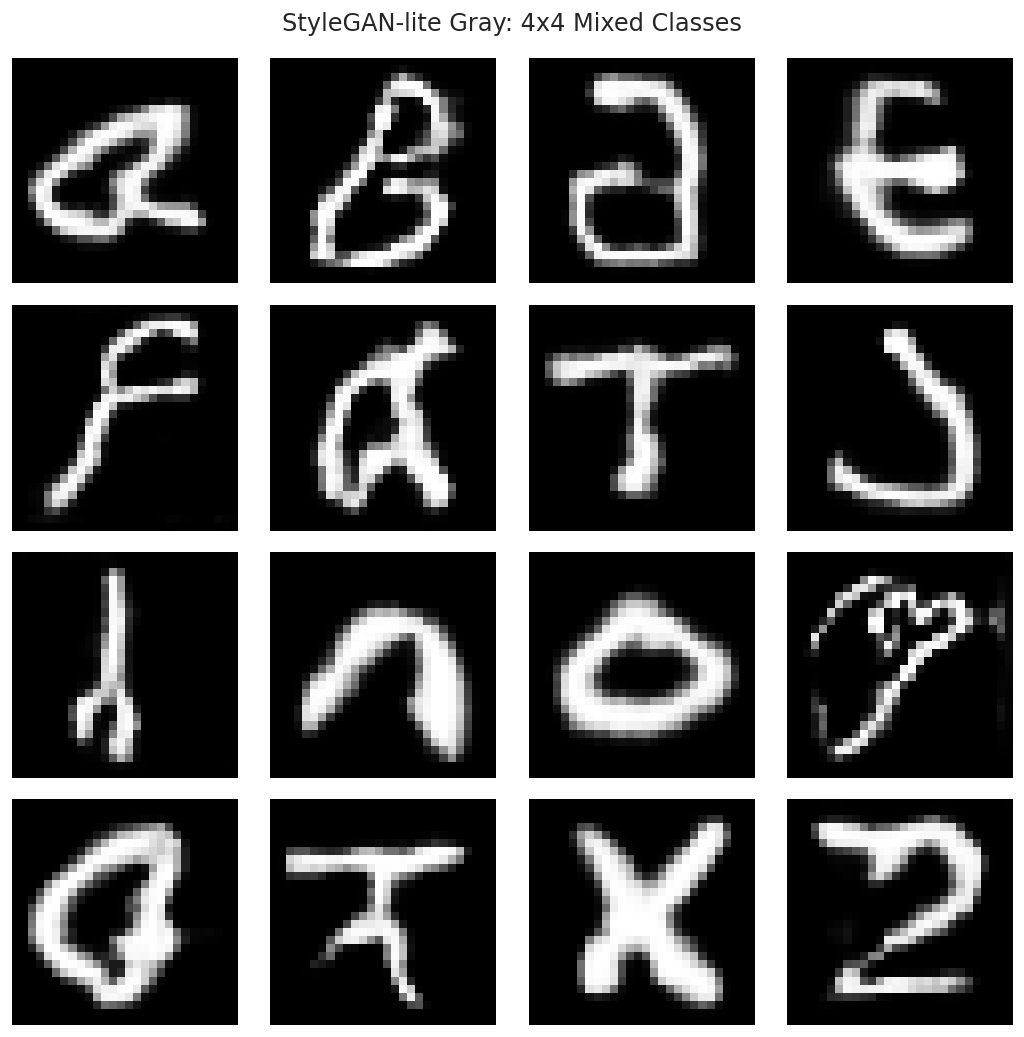

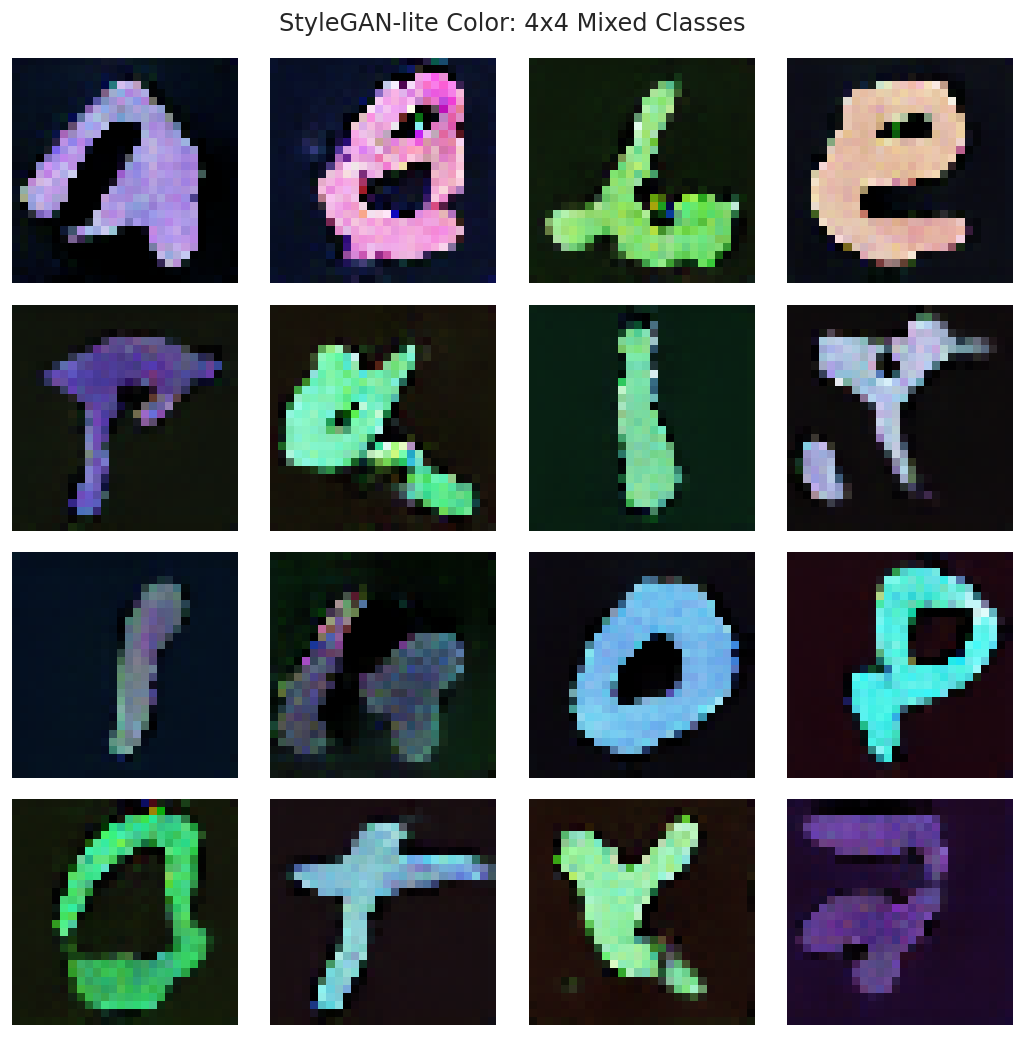

FID (StyleGAN-lite Gray)  : 88.13
FID (StyleGAN-lite Color) : 270.90


In [84]:
# === Cell 4: Visualize & quick FID (lower is better) ===
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

def show_grid(imgs, title, channels=1, rows=4, cols=4):
    fig, axs = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
    k=0
    for i in range(rows):
        for j in range(cols):
            if channels == 1:
                axs[i,j].imshow(imgs[k,:,:,0], cmap='gray')
            else:
                axs[i,j].imshow(imgs[k])
            axs[i,j].axis('off')
            k+=1
    plt.suptitle(title); plt.tight_layout(); plt.show()

g_gray  = sg_gray.sample_mixed_grid(16)
g_color = sg_color.sample_mixed_grid(16)
show_grid(g_gray,  "StyleGAN-lite Gray: 4x4 Mixed Classes", channels=1)
show_grid(g_color, "StyleGAN-lite Color: 4x4 Mixed Classes", channels=3)

# FID helpers
_inception = None
def _get_inception():
    global _inception
    if _inception is None:
        _inception = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
    return _inception

def _prep_for_inception(imgs01):
    t = tf.convert_to_tensor(imgs01, dtype=tf.float32)
    t = tf.image.resize(t, (75,75))
    t = preprocess_input(t * 255.0)
    return t

def fid_score(real01, fake01):
    model = _get_inception()
    a1 = model.predict(_prep_for_inception(real01), verbose=0)
    a2 = model.predict(_prep_for_inception(fake01), verbose=0)
    mu1, sig1 = a1.mean(axis=0), np.cov(a1, rowvar=False)
    mu2, sig2 = a2.mean(axis=0), np.cov(a2, rowvar=False)
    ssd = np.sum((mu1-mu2)**2)
    covm = sqrtm(sig1.dot(sig2))
    if np.iscomplexobj(covm): covm = covm.real
    return float(ssd + np.trace(sig1 + sig2 - 2*covm))


# Real sets: convert to [0,1] and make gray -> RGB by channel repeat
real_gray01   = ((X_gray_sg + 1.0) / 2.0).astype(np.float32)      # [N,28,28,1]
real_gray01_rgb = np.repeat(real_gray01, 3, axis=-1)              # [N,28,28,3]

real_color01  = ((X_color_sg + 1.0) / 2.0).astype(np.float32)     # already 3ch


# Fake sets: same N
N = min(3000, len(X_gray_sg))
def sample_fake_rgb_style(model, n, channels):
    z = tf.random.normal([n, model.z_dim])
    y = tf.random.uniform([n, 1], minval=0, maxval=model.num_classes, dtype=tf.int32)
    g = model.G(z, y, training=False).numpy()          # [-1,1], NumPy
    g01 = ((g + 1.0) / 2.0).astype(np.float32)         # [0,1], (N,28,28,C)

    if channels == 1:
        # convert 1ch -> 3ch without tf.image
        return np.repeat(g01, 3, axis=-1)              # (N,28,28,3)
    else:
        return g01                                      # already (N,28,28,3)


fake_gray01_rgb  = sample_fake_rgb_style(sg_gray,  N, channels=1)
fake_color01_rgb = sample_fake_rgb_style(sg_color, N, channels=3)

fid_gray  = fid_score(real_gray01_rgb[:N],  fake_gray01_rgb[:N])
fid_color = fid_score(real_color01[:N],     fake_color01_rgb[:N])

print(f"FID (StyleGAN-lite Gray)  : {fid_gray:.2f}")
print(f"FID (StyleGAN-lite Color) : {fid_color:.2f}")


Fréchet Inception Distance (FID) Results

- **Gray (FID = 88.13):**
  - While still high (good models are often < 50), this is significantly lower than the color version.
  - Lower FID = more realistic & closer to real data distribution.

- **Color (FID = 270.90):**
  - Extremely high, meaning generated color images are much farther from the real color images in feature space.

---

Interpretation for the Assignment Question

**Question:**  
If you are asked to generate coloured images instead of black-and-white ones, do you think it would be easier or harder to produce better quality results?



- The FID score for the colored images (**270.90**) is much higher than for grayscale (**88.13**), meaning the model struggled far more with producing realistic color images.
- This is expected because generating color images is harder — the model must not only capture shape and texture, but also learn realistic color distributions, shading, and color–class associations. This increases the complexity of the data distribution it needs to model.
- In grayscale, the model only needs to capture luminance (light/dark) patterns, which is a simpler task. That’s why grayscale generation achieved a much better FID score.